In [2]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Parameters

In [2]:
device = torch.device("cuda")

In [15]:
class TmpDataset(Dataset):
    # defining values in the constructor
    def __init__(self, 
                 x, 
                 y
                ):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
     
    # Getting the data samples
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    # Getting data size/length
    def __len__(self):
        return len(self.x)

# Define the neural network architecture with leaky ReLU activation
class OptionPricingModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, leaky_slope=0.01):
        super(OptionPricingModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.leaky_relu1 = nn.LeakyReLU(leaky_slope)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.leaky_relu2 = nn.LeakyReLU(leaky_slope)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.leaky_relu3 = nn.LeakyReLU(leaky_slope)
        self.layer4 = nn.Linear(hidden_size3, hidden_size4)
        self.leaky_relu4= nn.LeakyReLU(leaky_slope)
        self.layer5 = nn.Linear(hidden_size4, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.leaky_relu1(x)
        x = self.layer2(x)
        x = self.leaky_relu2(x)
        x = self.layer3(x)
        x = self.leaky_relu3(x)
        x = self.layer4(x)
        x = self.leaky_relu4(x)
        x = self.layer5(x)
        return x    

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.min_loss = 999999
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, loss):
        if loss < self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False    

def train_one_epoch(dataloader, 
                     test_dataloader, 
                     epoch_index, 
                     device,
                     model,
                     optimizer,
                     loss_fn,
                     scheduler):
    running_loss = 0.
    
    running_vloss = 0.
    sum_loss = 0
    # Here, we use enumerate(dataloader) instead of
    # iter(dataloader) so that we can track the batch
    # index and do some intra-epoch reporting
    ##################### TRAINING  ##################################
    model.train(True)
    for i, data in enumerate(dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.to(device))

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        sum_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
#             print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(dataloader) + i + 1
            running_loss = 0.
#     print('sum_loss:',sum_loss, 'i + 1:', i+1)
    avg_loss = sum_loss / (i + 1)
    
    ##################### TEST EVALUATION  ##################################
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs.to(device))
            vloss = loss_fn(voutputs, vlabels.to(device))
            running_vloss += vloss
#     print('running_vloss:',running_vloss, 'i + 1:', i+1)
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    scheduler.step(avg_loss)
    
    return avg_loss, avg_vloss.item()

In [4]:
train_data = pd.read_csv('training_set.csv')
test_data = pd.read_csv('test_set.csv')
val_data = pd.read_csv('val_set.csv')

In [5]:
tmp_train = pd.concat([train_data, val_data]).reset_index(drop=True)

In [6]:
features = ['T', 'r', 'q', 'v0', 'theta', 'kappa', 'sigma', 'rho', 'm']
label = ['option_price']

In [7]:
len(tmp_train)

1345495

In [8]:
len(train_data)

1108054

In [9]:
len(test_data)

237440

In [10]:
len(val_data)

237441

In [11]:
te = TmpDataset(x = test_data[features].values,
                 y = test_data[label].values)

In [12]:
bs = 1024 * 4

test_dataloader = DataLoader(te, 
                            batch_size=bs, 
                            shuffle=False)

data_size: 10000
--------------------  EPOCH: 0  --------------------
LOSS train 12.438969612121582 valid 12.403207778930664
--------------------  EPOCH: 1  --------------------
LOSS train 12.38660462697347 valid 12.354302406311035
--------------------  EPOCH: 2  --------------------
LOSS train 12.351737022399902 valid 12.303141593933105
--------------------  EPOCH: 3  --------------------
LOSS train 12.293856620788574 valid 12.2464017868042
--------------------  EPOCH: 4  --------------------
LOSS train 12.22077751159668 valid 12.17816162109375
--------------------  EPOCH: 5  --------------------
LOSS train 12.134357452392578 valid 12.09197998046875
--------------------  EPOCH: 6  --------------------
LOSS train 11.976389249165853 valid 11.981619834899902
--------------------  EPOCH: 7  --------------------
LOSS train 11.956068992614746 valid 11.83864974975586
--------------------  EPOCH: 8  --------------------
LOSS train 11.770763079325357 valid 11.652180671691895
------------------

LOSS train 2.1970624923706055 valid 2.225750684738159
--------------------  EPOCH: 77  --------------------
LOSS train 2.1766279538472495 valid 2.2043163776397705
--------------------  EPOCH: 78  --------------------
LOSS train 2.1651558081309 valid 2.1836094856262207
--------------------  EPOCH: 79  --------------------
LOSS train 2.140287478764852 valid 2.165386199951172
--------------------  EPOCH: 80  --------------------
LOSS train 2.108496109644572 valid 2.146515369415283
--------------------  EPOCH: 81  --------------------
LOSS train 2.0913402239481607 valid 2.1293857097625732
--------------------  EPOCH: 82  --------------------
LOSS train 2.079774856567383 valid 2.114973783493042
--------------------  EPOCH: 83  --------------------
LOSS train 2.0652225017547607 valid 2.099790334701538
--------------------  EPOCH: 84  --------------------
LOSS train 2.072378396987915 valid 2.091259241104126
--------------------  EPOCH: 85  --------------------
LOSS train 2.048345963160197 val

LOSS train 0.84015953540802 valid 0.8569679856300354
--------------------  EPOCH: 153  --------------------
LOSS train 0.8155040542284647 valid 0.8772221207618713
--------------------  EPOCH: 154  --------------------
LOSS train 0.8128631313641866 valid 0.8302057981491089
--------------------  EPOCH: 155  --------------------
LOSS train 0.7848503589630127 valid 0.7956127524375916
--------------------  EPOCH: 156  --------------------
LOSS train 0.7642579277356466 valid 0.7892089486122131
--------------------  EPOCH: 157  --------------------
LOSS train 0.7628358205159506 valid 0.774207592010498
--------------------  EPOCH: 158  --------------------
LOSS train 0.7483269174893697 valid 0.7659857869148254
--------------------  EPOCH: 159  --------------------
LOSS train 0.7371164759000143 valid 0.7589653134346008
--------------------  EPOCH: 160  --------------------
LOSS train 0.736310084660848 valid 0.7500203847885132
--------------------  EPOCH: 161  --------------------
LOSS train 0.7

LOSS train 0.6177549759546915 valid 0.6282914280891418
--------------------  EPOCH: 228  --------------------
LOSS train 0.6278933882713318 valid 0.6273571252822876
--------------------  EPOCH: 229  --------------------
LOSS train 0.6233627597490946 valid 0.6239542365074158
--------------------  EPOCH: 230  --------------------
LOSS train 0.6183567841847738 valid 0.629682719707489
--------------------  EPOCH: 231  --------------------
LOSS train 0.6390120983123779 valid 0.6271967887878418
--------------------  EPOCH: 232  --------------------
LOSS train 0.6260169545809428 valid 0.6234293580055237
--------------------  EPOCH: 233  --------------------
LOSS train 0.6168407996495565 valid 0.6226915121078491
--------------------  EPOCH: 234  --------------------
LOSS train 0.6058294574419657 valid 0.6203237175941467
--------------------  EPOCH: 235  --------------------
LOSS train 0.6047441562016805 valid 0.6196256279945374
--------------------  EPOCH: 236  --------------------
LOSS train 

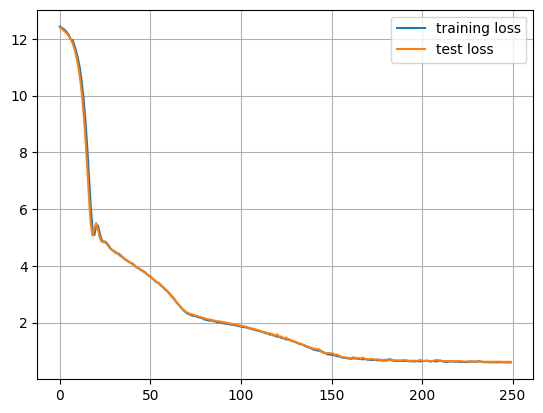

--------------------  EPOCH: 250  --------------------
LOSS train 0.5861755013465881 valid 0.6137184500694275
--------------------  EPOCH: 251  --------------------
LOSS train 0.5883845686912537 valid 0.6173501014709473
--------------------  EPOCH: 252  --------------------
LOSS train 0.5956156849861145 valid 0.6115643978118896
--------------------  EPOCH: 253  --------------------
LOSS train 0.5888622005780538 valid 0.609826922416687
--------------------  EPOCH: 254  --------------------
LOSS train 0.594060997168223 valid 0.6182389855384827
--------------------  EPOCH: 255  --------------------
LOSS train 0.5979098280270895 valid 0.6261568665504456
--------------------  EPOCH: 256  --------------------
LOSS train 0.592034657796224 valid 0.6239726543426514
--------------------  EPOCH: 257  --------------------
LOSS train 0.5999208688735962 valid 0.6347059011459351
--------------------  EPOCH: 258  --------------------
LOSS train 0.6070078214009603 valid 0.6193758249282837
-------------

LOSS train 0.559067447980245 valid 0.5807597637176514
--------------------  EPOCH: 326  --------------------
LOSS train 0.5596004923184713 valid 0.5800381302833557
--------------------  EPOCH: 327  --------------------
LOSS train 0.5571259061495463 valid 0.5831367373466492
--------------------  EPOCH: 328  --------------------
LOSS train 0.5665916601816813 valid 0.5767043232917786
--------------------  EPOCH: 329  --------------------
LOSS train 0.5607190132141113 valid 0.5846423506736755
--------------------  EPOCH: 330  --------------------
LOSS train 0.5646635095278422 valid 0.580287516117096
--------------------  EPOCH: 331  --------------------
LOSS train 0.5613334973653158 valid 0.5800212025642395
--------------------  EPOCH: 332  --------------------
LOSS train 0.5659642219543457 valid 0.5751484632492065
--------------------  EPOCH: 333  --------------------
LOSS train 0.5743936697642008 valid 0.5792058706283569
--------------------  EPOCH: 334  --------------------
LOSS train 0

LOSS train 0.5368203520774841 valid 0.552971601486206
--------------------  EPOCH: 401  --------------------
LOSS train 0.5305195848147074 valid 0.5600524544715881
--------------------  EPOCH: 402  --------------------
LOSS train 0.531984806060791 valid 0.551476776599884
--------------------  EPOCH: 403  --------------------
LOSS train 0.5319113930066427 valid 0.5508195757865906
--------------------  EPOCH: 404  --------------------
LOSS train 0.5321508646011353 valid 0.5567035675048828
--------------------  EPOCH: 405  --------------------
LOSS train 0.5432832638422648 valid 0.5481871962547302
--------------------  EPOCH: 406  --------------------
LOSS train 0.5446901718775431 valid 0.5459879636764526
--------------------  EPOCH: 407  --------------------
LOSS train 0.5420813957850138 valid 0.5596438646316528
--------------------  EPOCH: 408  --------------------
LOSS train 0.5339237650235494 valid 0.5504822731018066
--------------------  EPOCH: 409  --------------------
LOSS train 0.

LOSS train 0.5102482835451762 valid 0.527686595916748
--------------------  EPOCH: 476  --------------------
LOSS train 0.5156366229057312 valid 0.5276622176170349
--------------------  EPOCH: 477  --------------------
LOSS train 0.5100279649098715 valid 0.5278016328811646
--------------------  EPOCH: 478  --------------------
LOSS train 0.5094831784566244 valid 0.5275864601135254
--------------------  EPOCH: 479  --------------------
LOSS train 0.5122546950976054 valid 0.5275527834892273
--------------------  EPOCH: 480  --------------------
LOSS train 0.5130933523178101 valid 0.5276561379432678
--------------------  EPOCH: 481  --------------------
LOSS train 0.5131793816884359 valid 0.527512788772583
--------------------  EPOCH: 482  --------------------
LOSS train 0.5105502804120382 valid 0.5274286270141602
--------------------  EPOCH: 483  --------------------
LOSS train 0.5106967091560364 valid 0.5274274945259094
--------------------  EPOCH: 484  --------------------
LOSS train 0

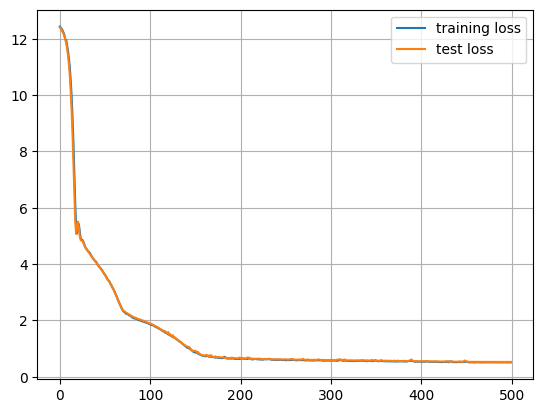

--------------------  EPOCH: 500  --------------------
LOSS train 0.5125840504964193 valid 0.5269941091537476
--------------------  EPOCH: 501  --------------------
LOSS train 0.5097031792004904 valid 0.5269147753715515
--------------------  EPOCH: 502  --------------------
LOSS train 0.5148683587710062 valid 0.5266324877738953
--------------------  EPOCH: 503  --------------------
LOSS train 0.5089407960573832 valid 0.5266481041908264
--------------------  EPOCH: 504  --------------------
LOSS train 0.5094709793726603 valid 0.5267359614372253
--------------------  EPOCH: 505  --------------------
LOSS train 0.510100245475769 valid 0.5265377759933472
--------------------  EPOCH: 506  --------------------
LOSS train 0.5077649851640066 valid 0.5264987945556641
--------------------  EPOCH: 507  --------------------
LOSS train 0.513424277305603 valid 0.5264936089515686
--------------------  EPOCH: 508  --------------------
LOSS train 0.5136296153068542 valid 0.5271545648574829
------------

LOSS train 0.5063686470190684 valid 0.5263481140136719
--------------------  EPOCH: 574  --------------------
LOSS train 0.5086183150609335 valid 0.5263466238975525
--------------------  EPOCH: 575  --------------------
LOSS train 0.508903702100118 valid 0.5263468027114868
--------------------  EPOCH: 576  --------------------
LOSS train 0.5123676061630249 valid 0.5263459086418152
--------------------  EPOCH: 577  --------------------
LOSS train 0.5112059513727824 valid 0.5263442397117615
--------------------  EPOCH: 578  --------------------
LOSS train 0.5093902548154196 valid 0.5263426899909973
Epoch 00579: reducing learning rate of group 0 to 1.0000e-07.
--------------------  EPOCH: 579  --------------------
LOSS train 0.5120480259259542 valid 0.5263425707817078
--------------------  EPOCH: 580  --------------------
LOSS train 0.5108424623807272 valid 0.5263425707817078
--------------------  EPOCH: 581  --------------------
LOSS train 0.5071574250857035 valid 0.5263425707817078
----

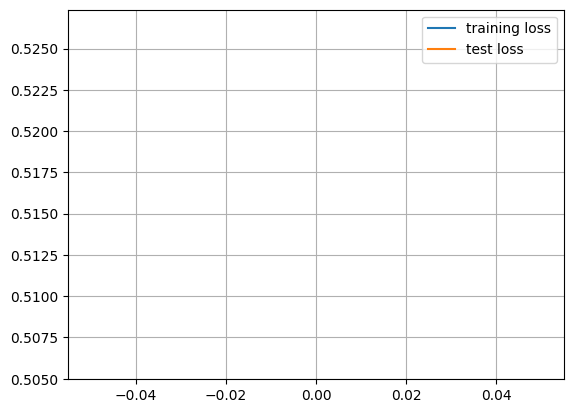

data_size: 20000
--------------------  EPOCH: 0  --------------------
LOSS train 12.369276809692384 valid 12.33115291595459
--------------------  EPOCH: 1  --------------------
LOSS train 12.324978065490722 valid 12.28446102142334
--------------------  EPOCH: 2  --------------------
LOSS train 12.276294898986816 valid 12.224322319030762
--------------------  EPOCH: 3  --------------------
LOSS train 12.210497856140137 valid 12.138400077819824
--------------------  EPOCH: 4  --------------------
LOSS train 12.10332088470459 valid 12.008334159851074
--------------------  EPOCH: 5  --------------------
LOSS train 11.948508834838867 valid 11.806344032287598
--------------------  EPOCH: 6  --------------------
LOSS train 11.703454780578614 valid 11.48803424835205
--------------------  EPOCH: 7  --------------------
LOSS train 11.313935089111329 valid 10.974837303161621
--------------------  EPOCH: 8  --------------------
LOSS train 10.687239265441894 valid 10.156323432922363
---------------

LOSS train 1.476752758026123 valid 1.4736723899841309
--------------------  EPOCH: 77  --------------------
LOSS train 1.4423463106155396 valid 1.4239835739135742
--------------------  EPOCH: 78  --------------------
LOSS train 1.4026368141174317 valid 1.3846389055252075
--------------------  EPOCH: 79  --------------------
LOSS train 1.3627070426940917 valid 1.3432456254959106
--------------------  EPOCH: 80  --------------------
LOSS train 1.3172756671905517 valid 1.324732780456543
--------------------  EPOCH: 81  --------------------
LOSS train 1.289433217048645 valid 1.269587755203247
--------------------  EPOCH: 82  --------------------
LOSS train 1.2461133003234863 valid 1.22919762134552
--------------------  EPOCH: 83  --------------------
LOSS train 1.2079715251922607 valid 1.1930996179580688
--------------------  EPOCH: 84  --------------------
LOSS train 1.1737486124038696 valid 1.1556215286254883
--------------------  EPOCH: 85  --------------------
LOSS train 1.145454573631

LOSS train 0.6361765146255494 valid 0.63570636510849
--------------------  EPOCH: 152  --------------------
LOSS train 0.6325853705406189 valid 0.634185254573822
--------------------  EPOCH: 153  --------------------
LOSS train 0.6320218920707703 valid 0.6377219557762146
--------------------  EPOCH: 154  --------------------
LOSS train 0.6435181379318238 valid 0.6447656750679016
--------------------  EPOCH: 155  --------------------
LOSS train 0.6349838376045227 valid 0.6563987731933594
--------------------  EPOCH: 156  --------------------
LOSS train 0.6338698387145996 valid 0.6286393404006958
--------------------  EPOCH: 157  --------------------
LOSS train 0.6248807907104492 valid 0.6272532939910889
--------------------  EPOCH: 158  --------------------
LOSS train 0.6300970911979675 valid 0.6320917010307312
--------------------  EPOCH: 159  --------------------
LOSS train 0.6260774254798889 valid 0.6208025813102722
--------------------  EPOCH: 160  --------------------
LOSS train 0.

LOSS train 0.5308311581611633 valid 0.5292273163795471
--------------------  EPOCH: 227  --------------------
LOSS train 0.5362514853477478 valid 0.5393149852752686
--------------------  EPOCH: 228  --------------------
LOSS train 0.5280913352966309 valid 0.5258358716964722
--------------------  EPOCH: 229  --------------------
LOSS train 0.5214098930358887 valid 0.5346176028251648
--------------------  EPOCH: 230  --------------------
LOSS train 0.5261124610900879 valid 0.5207003355026245
--------------------  EPOCH: 231  --------------------
LOSS train 0.5162836670875549 valid 0.5201033353805542
--------------------  EPOCH: 232  --------------------
LOSS train 0.5179816246032715 valid 0.5163685083389282
--------------------  EPOCH: 233  --------------------
LOSS train 0.5177346110343933 valid 0.5191087126731873
--------------------  EPOCH: 234  --------------------
LOSS train 0.5127831220626831 valid 0.5130625367164612
--------------------  EPOCH: 235  --------------------
LOSS train

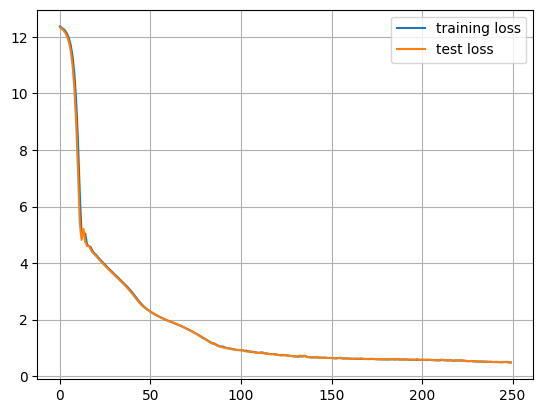

--------------------  EPOCH: 250  --------------------
LOSS train 0.48330665826797486 valid 0.4852841794490814
--------------------  EPOCH: 251  --------------------
LOSS train 0.48050105571746826 valid 0.4847526550292969
--------------------  EPOCH: 252  --------------------
LOSS train 0.48103225231170654 valid 0.48559513688087463
--------------------  EPOCH: 253  --------------------
LOSS train 0.4956770360469818 valid 0.4833293557167053
--------------------  EPOCH: 254  --------------------
LOSS train 0.488411009311676 valid 0.49760332703590393
--------------------  EPOCH: 255  --------------------
LOSS train 0.4836037278175354 valid 0.48659417033195496
--------------------  EPOCH: 256  --------------------
LOSS train 0.47621321082115176 valid 0.47711819410324097
--------------------  EPOCH: 257  --------------------
LOSS train 0.47542988657951357 valid 0.48374831676483154
--------------------  EPOCH: 258  --------------------
LOSS train 0.4760075509548187 valid 0.48318418860435486


LOSS train 0.41389729380607604 valid 0.42021775245666504
--------------------  EPOCH: 325  --------------------
LOSS train 0.42431309819221497 valid 0.43195390701293945
--------------------  EPOCH: 326  --------------------
LOSS train 0.4279794812202454 valid 0.41379472613334656
--------------------  EPOCH: 327  --------------------
LOSS train 0.4142961859703064 valid 0.4260101020336151
--------------------  EPOCH: 328  --------------------
LOSS train 0.4200453221797943 valid 0.42150288820266724
--------------------  EPOCH: 329  --------------------
LOSS train 0.4227586030960083 valid 0.4319351017475128
--------------------  EPOCH: 330  --------------------
LOSS train 0.441054093837738 valid 0.43584614992141724
--------------------  EPOCH: 331  --------------------
LOSS train 0.42899203300476074 valid 0.43405279517173767
--------------------  EPOCH: 332  --------------------
LOSS train 0.42181840538978577 valid 0.4385990798473358
--------------------  EPOCH: 333  --------------------
L

LOSS train 0.3893118679523468 valid 0.41661518812179565
--------------------  EPOCH: 399  --------------------
LOSS train 0.3966991603374481 valid 0.39798083901405334
--------------------  EPOCH: 400  --------------------
LOSS train 0.39031476378440855 valid 0.39093872904777527
--------------------  EPOCH: 401  --------------------
LOSS train 0.3845519065856934 valid 0.38552653789520264
--------------------  EPOCH: 402  --------------------
LOSS train 0.389572811126709 valid 0.38567695021629333
--------------------  EPOCH: 403  --------------------
LOSS train 0.38209566473960876 valid 0.3878214359283447
--------------------  EPOCH: 404  --------------------
LOSS train 0.3819625794887543 valid 0.3859872817993164
--------------------  EPOCH: 405  --------------------
LOSS train 0.3898626446723938 valid 0.3990040123462677
--------------------  EPOCH: 406  --------------------
LOSS train 0.3914503753185272 valid 0.39597752690315247
--------------------  EPOCH: 407  --------------------
LOS

LOSS train 0.3692565500736237 valid 0.3782367408275604
--------------------  EPOCH: 473  --------------------
LOSS train 0.37345647215843203 valid 0.38636884093284607
--------------------  EPOCH: 474  --------------------
LOSS train 0.3807883858680725 valid 0.37616273760795593
--------------------  EPOCH: 475  --------------------
LOSS train 0.38080303072929383 valid 0.38574692606925964
--------------------  EPOCH: 476  --------------------
LOSS train 0.3777314186096191 valid 0.3889756500720978
--------------------  EPOCH: 477  --------------------
LOSS train 0.3755113482475281 valid 0.3741951286792755
--------------------  EPOCH: 478  --------------------
LOSS train 0.38739095330238343 valid 0.37645360827445984
--------------------  EPOCH: 479  --------------------
LOSS train 0.3749039888381958 valid 0.37528398633003235
--------------------  EPOCH: 480  --------------------
LOSS train 0.3704711735248566 valid 0.3792324960231781
--------------------  EPOCH: 481  --------------------
LO

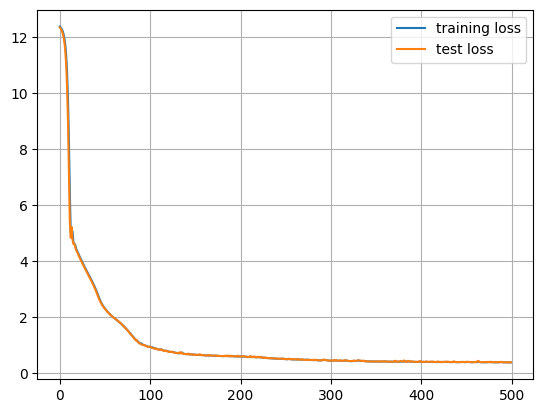

--------------------  EPOCH: 500  --------------------
LOSS train 0.36491567492485044 valid 0.37823405861854553
--------------------  EPOCH: 501  --------------------
LOSS train 0.37032018303871156 valid 0.36807283759117126
--------------------  EPOCH: 502  --------------------
LOSS train 0.36376731991767886 valid 0.36998873949050903
--------------------  EPOCH: 503  --------------------
LOSS train 0.36695491075515746 valid 0.36761292815208435
--------------------  EPOCH: 504  --------------------
LOSS train 0.36748993396759033 valid 0.37882477045059204
--------------------  EPOCH: 505  --------------------
LOSS train 0.3731260895729065 valid 0.3802541196346283
--------------------  EPOCH: 506  --------------------
LOSS train 0.37009611129760744 valid 0.3669113218784332
--------------------  EPOCH: 507  --------------------
LOSS train 0.3663794219493866 valid 0.366925448179245
--------------------  EPOCH: 508  --------------------
LOSS train 0.3638008117675781 valid 0.36757004261016846

LOSS train 0.35832305550575255 valid 0.3746190369129181
--------------------  EPOCH: 575  --------------------
LOSS train 0.3624792754650116 valid 0.36297741532325745
--------------------  EPOCH: 576  --------------------
LOSS train 0.3579512059688568 valid 0.3582434058189392
--------------------  EPOCH: 577  --------------------
LOSS train 0.35802688598632815 valid 0.35985270142555237
--------------------  EPOCH: 578  --------------------
LOSS train 0.3547087132930756 valid 0.3565061390399933
--------------------  EPOCH: 579  --------------------
LOSS train 0.35276995301246644 valid 0.35829272866249084
--------------------  EPOCH: 580  --------------------
LOSS train 0.3529216170310974 valid 0.3572867214679718
--------------------  EPOCH: 581  --------------------
LOSS train 0.35580182671546934 valid 0.3584950864315033
--------------------  EPOCH: 582  --------------------
LOSS train 0.36654403805732727 valid 0.3706569969654083
--------------------  EPOCH: 583  --------------------
LO

LOSS train 0.349263596534729 valid 0.3532205820083618
--------------------  EPOCH: 649  --------------------
LOSS train 0.3493041217327118 valid 0.353264182806015
--------------------  EPOCH: 650  --------------------
LOSS train 0.34905771613121034 valid 0.35320472717285156
--------------------  EPOCH: 651  --------------------
LOSS train 0.3490325391292572 valid 0.3533025085926056
--------------------  EPOCH: 652  --------------------
LOSS train 0.3492866575717926 valid 0.3531911373138428
--------------------  EPOCH: 653  --------------------
LOSS train 0.34901679754257203 valid 0.35318028926849365
--------------------  EPOCH: 654  --------------------
LOSS train 0.3491998553276062 valid 0.3531632125377655
--------------------  EPOCH: 655  --------------------
LOSS train 0.34907527565956115 valid 0.35323506593704224
--------------------  EPOCH: 656  --------------------
LOSS train 0.3492094874382019 valid 0.35314157605171204
--------------------  EPOCH: 657  --------------------
LOSS 

LOSS train 0.34789849519729615 valid 0.35242146253585815
--------------------  EPOCH: 723  --------------------
LOSS train 0.34825299978256224 valid 0.35231640934944153
--------------------  EPOCH: 724  --------------------
LOSS train 0.3483402729034424 valid 0.35249945521354675
--------------------  EPOCH: 725  --------------------
LOSS train 0.34838998317718506 valid 0.35237962007522583
--------------------  EPOCH: 726  --------------------
LOSS train 0.34824825525283815 valid 0.3524538576602936
--------------------  EPOCH: 727  --------------------
LOSS train 0.34788923859596255 valid 0.3522939383983612
--------------------  EPOCH: 728  --------------------
LOSS train 0.3483080446720123 valid 0.35248735547065735
--------------------  EPOCH: 729  --------------------
LOSS train 0.34809502959251404 valid 0.35253089666366577
--------------------  EPOCH: 730  --------------------
LOSS train 0.3483501970767975 valid 0.3525490462779999
--------------------  EPOCH: 731  -------------------

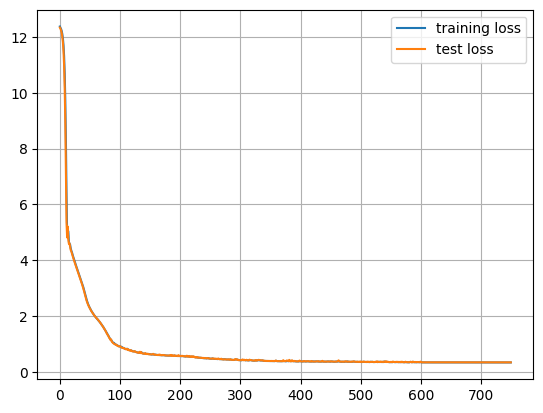

--------------------  EPOCH: 750  --------------------
LOSS train 0.3479271650314331 valid 0.35193535685539246
--------------------  EPOCH: 751  --------------------
LOSS train 0.34804287552833557 valid 0.3519115447998047
--------------------  EPOCH: 752  --------------------
LOSS train 0.34779205322265627 valid 0.3519355058670044
--------------------  EPOCH: 753  --------------------
LOSS train 0.34781094193458556 valid 0.35189950466156006
--------------------  EPOCH: 754  --------------------
LOSS train 0.34778682589530946 valid 0.35191595554351807
--------------------  EPOCH: 755  --------------------
LOSS train 0.34779635071754456 valid 0.351961225271225
--------------------  EPOCH: 756  --------------------
LOSS train 0.34788382053375244 valid 0.3519907593727112
--------------------  EPOCH: 757  --------------------
LOSS train 0.3477439284324646 valid 0.3521099388599396
--------------------  EPOCH: 758  --------------------
LOSS train 0.34785162210464476 valid 0.3518814444541931
-

LOSS train 0.3467016458511353 valid 0.3512219786643982
--------------------  EPOCH: 825  --------------------
LOSS train 0.3469976007938385 valid 0.3511500656604767
--------------------  EPOCH: 826  --------------------
LOSS train 0.34692310690879824 valid 0.35084354877471924
--------------------  EPOCH: 827  --------------------
LOSS train 0.34717437624931335 valid 0.3512170612812042
--------------------  EPOCH: 828  --------------------
LOSS train 0.346673184633255 valid 0.3512715697288513
--------------------  EPOCH: 829  --------------------
LOSS train 0.34743293523788454 valid 0.35087835788726807
--------------------  EPOCH: 830  --------------------
LOSS train 0.34704158902168275 valid 0.3510211706161499
--------------------  EPOCH: 831  --------------------
LOSS train 0.34694343209266665 valid 0.35089612007141113
--------------------  EPOCH: 832  --------------------
LOSS train 0.34672462940216064 valid 0.35082629323005676
--------------------  EPOCH: 833  --------------------
L

LOSS train 0.344957435131073 valid 0.3497410714626312
--------------------  EPOCH: 899  --------------------
LOSS train 0.34540776014328 valid 0.34967389702796936
--------------------  EPOCH: 900  --------------------
LOSS train 0.34522290229797364 valid 0.34950968623161316
--------------------  EPOCH: 901  --------------------
LOSS train 0.34535432457923887 valid 0.3494468331336975
--------------------  EPOCH: 902  --------------------
LOSS train 0.3452442824840546 valid 0.34946030378341675
--------------------  EPOCH: 903  --------------------
LOSS train 0.3450587451457977 valid 0.3494122326374054
--------------------  EPOCH: 904  --------------------
LOSS train 0.34514219760894777 valid 0.3494888246059418
--------------------  EPOCH: 905  --------------------
LOSS train 0.3451714634895325 valid 0.3493601679801941
--------------------  EPOCH: 906  --------------------
LOSS train 0.34495715498924256 valid 0.3493575155735016
--------------------  EPOCH: 907  --------------------
LOSS t

LOSS train 0.3437149882316589 valid 0.34806159138679504
--------------------  EPOCH: 974  --------------------
LOSS train 0.34385066032409667 valid 0.34813255071640015
--------------------  EPOCH: 975  --------------------
LOSS train 0.34387012124061583 valid 0.3483487665653229
--------------------  EPOCH: 976  --------------------
LOSS train 0.34379897713661195 valid 0.3491760492324829
--------------------  EPOCH: 977  --------------------
LOSS train 0.3441284239292145 valid 0.34798261523246765
--------------------  EPOCH: 978  --------------------
LOSS train 0.34385167956352236 valid 0.3479691743850708
--------------------  EPOCH: 979  --------------------
LOSS train 0.34335765838623045 valid 0.3479130268096924
--------------------  EPOCH: 980  --------------------
LOSS train 0.3436435520648956 valid 0.34798482060432434
--------------------  EPOCH: 981  --------------------
LOSS train 0.3434806227684021 valid 0.34825006127357483
--------------------  EPOCH: 982  --------------------


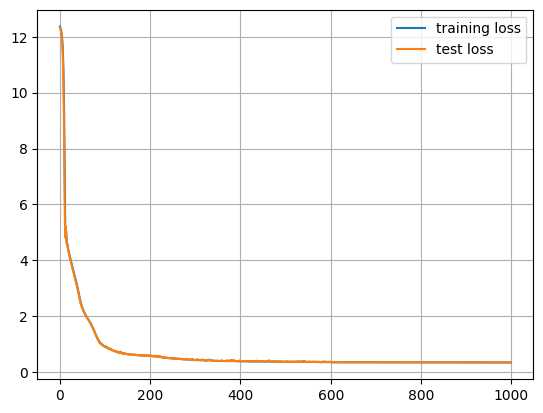

--------------------  EPOCH: 1000  --------------------
LOSS train 0.3430193364620209 valid 0.3476792573928833
--------------------  EPOCH: 1001  --------------------
LOSS train 0.34343003630638125 valid 0.3474390208721161
--------------------  EPOCH: 1002  --------------------
LOSS train 0.3430995523929596 valid 0.34934478998184204
--------------------  EPOCH: 1003  --------------------
LOSS train 0.34388707280159 valid 0.3477976620197296
--------------------  EPOCH: 1004  --------------------
LOSS train 0.34309126138687135 valid 0.3474554717540741
--------------------  EPOCH: 1005  --------------------
LOSS train 0.3427446484565735 valid 0.34745410084724426
--------------------  EPOCH: 1006  --------------------
LOSS train 0.3429033398628235 valid 0.3473452627658844
--------------------  EPOCH: 1007  --------------------
LOSS train 0.34291892051696776 valid 0.3473605513572693
--------------------  EPOCH: 1008  --------------------
LOSS train 0.3431334555149078 valid 0.347621798515319

LOSS train 0.34188187718391416 valid 0.3460143208503723
--------------------  EPOCH: 1074  --------------------
LOSS train 0.34143579602241514 valid 0.346121221780777
--------------------  EPOCH: 1075  --------------------
LOSS train 0.34150386452674864 valid 0.3459911048412323
--------------------  EPOCH: 1076  --------------------
LOSS train 0.3416269838809967 valid 0.34602871537208557
--------------------  EPOCH: 1077  --------------------
LOSS train 0.34124436378479006 valid 0.34702780842781067
--------------------  EPOCH: 1078  --------------------
LOSS train 0.34156760573387146 valid 0.34591224789619446
--------------------  EPOCH: 1079  --------------------
LOSS train 0.3413865327835083 valid 0.3458211421966553
--------------------  EPOCH: 1080  --------------------
LOSS train 0.3411782026290894 valid 0.3459133803844452
--------------------  EPOCH: 1081  --------------------
LOSS train 0.3414573848247528 valid 0.34577617049217224
--------------------  EPOCH: 1082  --------------

LOSS train 0.34067835211753844 valid 0.34441956877708435
--------------------  EPOCH: 1148  --------------------
LOSS train 0.3404471933841705 valid 0.3458862602710724
--------------------  EPOCH: 1149  --------------------
LOSS train 0.3404027223587036 valid 0.3454000949859619
--------------------  EPOCH: 1150  --------------------
LOSS train 0.340473884344101 valid 0.34440863132476807
--------------------  EPOCH: 1151  --------------------
LOSS train 0.3398054540157318 valid 0.34422048926353455
--------------------  EPOCH: 1152  --------------------
LOSS train 0.33948596715927126 valid 0.34426820278167725
--------------------  EPOCH: 1153  --------------------
LOSS train 0.3394071817398071 valid 0.344262033700943
--------------------  EPOCH: 1154  --------------------
LOSS train 0.3400352120399475 valid 0.3444688618183136
--------------------  EPOCH: 1155  --------------------
LOSS train 0.3403986692428589 valid 0.3459826707839966
--------------------  EPOCH: 1156  ------------------

LOSS train 0.3381205201148987 valid 0.3429723083972931
--------------------  EPOCH: 1221  --------------------
LOSS train 0.3380019128322601 valid 0.3428632915019989
--------------------  EPOCH: 1222  --------------------
LOSS train 0.3379957973957062 valid 0.3428391218185425
--------------------  EPOCH: 1223  --------------------
LOSS train 0.33799619078636167 valid 0.3428971469402313
--------------------  EPOCH: 1224  --------------------
LOSS train 0.33833305835723876 valid 0.3428942561149597
--------------------  EPOCH: 1225  --------------------
LOSS train 0.3380483269691467 valid 0.34286490082740784
--------------------  EPOCH: 1226  --------------------
LOSS train 0.3381037175655365 valid 0.3428296148777008
--------------------  EPOCH: 1227  --------------------
LOSS train 0.3379512965679169 valid 0.3428609371185303
--------------------  EPOCH: 1228  --------------------
LOSS train 0.33816508650779725 valid 0.3428523540496826
--------------------  EPOCH: 1229  ------------------

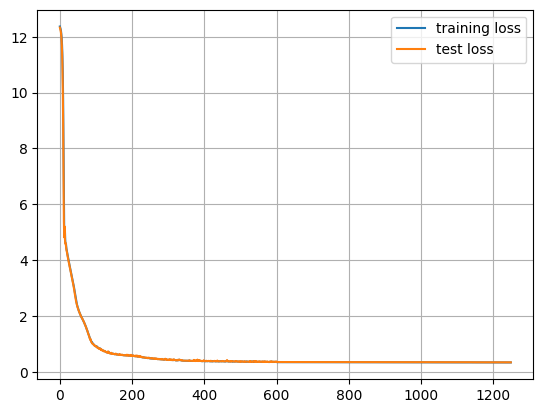

--------------------  EPOCH: 1250  --------------------
LOSS train 0.33807337284088135 valid 0.3427763283252716
--------------------  EPOCH: 1251  --------------------
LOSS train 0.33815587759017945 valid 0.3428340256214142
--------------------  EPOCH: 1252  --------------------
LOSS train 0.3380139470100403 valid 0.3427647352218628
--------------------  EPOCH: 1253  --------------------
LOSS train 0.33789571523666384 valid 0.34278541803359985
--------------------  EPOCH: 1254  --------------------
LOSS train 0.33789133429527285 valid 0.3428128659725189
--------------------  EPOCH: 1255  --------------------
LOSS train 0.33802029490470886 valid 0.34276479482650757
--------------------  EPOCH: 1256  --------------------
LOSS train 0.3380967378616333 valid 0.3427457809448242
--------------------  EPOCH: 1257  --------------------
LOSS train 0.33794512748718264 valid 0.34278926253318787
--------------------  EPOCH: 1258  --------------------
LOSS train 0.3378386676311493 valid 0.342782646

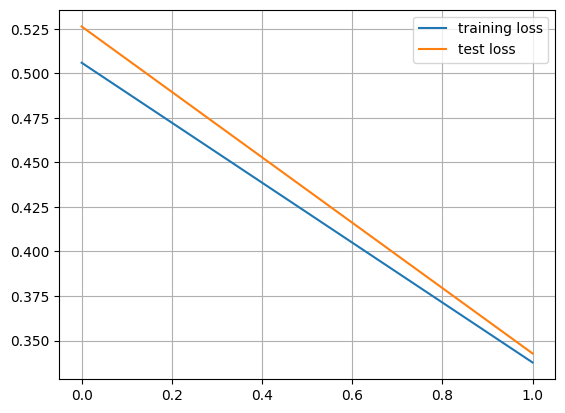

data_size: 40000
--------------------  EPOCH: 0  --------------------
LOSS train 12.431265068054199 valid 12.315726280212402
--------------------  EPOCH: 1  --------------------
LOSS train 12.2243408203125 valid 12.044412612915039
--------------------  EPOCH: 2  --------------------
LOSS train 11.790558433532714 valid 11.317763328552246
--------------------  EPOCH: 3  --------------------
LOSS train 10.609651374816895 valid 9.40936279296875
--------------------  EPOCH: 4  --------------------
LOSS train 7.863296127319336 valid 5.783416748046875
--------------------  EPOCH: 5  --------------------
LOSS train 5.2421722412109375 valid 5.40506649017334
--------------------  EPOCH: 6  --------------------
LOSS train 5.006769704818725 valid 4.6861724853515625
--------------------  EPOCH: 7  --------------------
LOSS train 4.652035284042358 valid 4.495239734649658
--------------------  EPOCH: 8  --------------------
LOSS train 4.3949137210845945 valid 4.300830841064453
--------------------  E

LOSS train 0.8867354929447174 valid 0.9122722744941711
--------------------  EPOCH: 77  --------------------
LOSS train 0.8558993577957154 valid 0.8646239638328552
--------------------  EPOCH: 78  --------------------
LOSS train 0.8503432512283325 valid 0.8579233884811401
--------------------  EPOCH: 79  --------------------
LOSS train 0.8352627217769623 valid 0.837051272392273
--------------------  EPOCH: 80  --------------------
LOSS train 0.8167192876338959 valid 0.8201417326927185
--------------------  EPOCH: 81  --------------------
LOSS train 0.8045885324478149 valid 0.8090387582778931
--------------------  EPOCH: 82  --------------------
LOSS train 0.7953724443912507 valid 0.7998837232589722
--------------------  EPOCH: 83  --------------------
LOSS train 0.7842145681381225 valid 0.7928524613380432
--------------------  EPOCH: 84  --------------------
LOSS train 0.7783906102180481 valid 0.7816072702407837
--------------------  EPOCH: 85  --------------------
LOSS train 0.7675265

LOSS train 0.4701684474945068 valid 0.4725441634654999
--------------------  EPOCH: 152  --------------------
LOSS train 0.46640290021896363 valid 0.4792976975440979
--------------------  EPOCH: 153  --------------------
LOSS train 0.4809600323438644 valid 0.47305169701576233
--------------------  EPOCH: 154  --------------------
LOSS train 0.47440009713172915 valid 0.48020970821380615
--------------------  EPOCH: 155  --------------------
LOSS train 0.47024221122264864 valid 0.4762151837348938
--------------------  EPOCH: 156  --------------------
LOSS train 0.4620282620191574 valid 0.47522807121276855
--------------------  EPOCH: 157  --------------------
LOSS train 0.4655967354774475 valid 0.4663916528224945
--------------------  EPOCH: 158  --------------------
LOSS train 0.4601586639881134 valid 0.4653685986995697
--------------------  EPOCH: 159  --------------------
LOSS train 0.4572634607553482 valid 0.46332913637161255
--------------------  EPOCH: 160  --------------------
LOS

LOSS train 0.4323269158601761 valid 0.4264969229698181
--------------------  EPOCH: 227  --------------------
LOSS train 0.4187053918838501 valid 0.4211548864841461
--------------------  EPOCH: 228  --------------------
LOSS train 0.4170387536287308 valid 0.4227851927280426
--------------------  EPOCH: 229  --------------------
LOSS train 0.4186913311481476 valid 0.44758906960487366
--------------------  EPOCH: 230  --------------------
LOSS train 0.4233727723360062 valid 0.4204215109348297
--------------------  EPOCH: 231  --------------------
LOSS train 0.4178468555212021 valid 0.4199609160423279
--------------------  EPOCH: 232  --------------------
LOSS train 0.41576539278030394 valid 0.42186450958251953
--------------------  EPOCH: 233  --------------------
LOSS train 0.41711110472679136 valid 0.4201718270778656
--------------------  EPOCH: 234  --------------------
LOSS train 0.41683065295219424 valid 0.42058074474334717
--------------------  EPOCH: 235  --------------------
LOSS

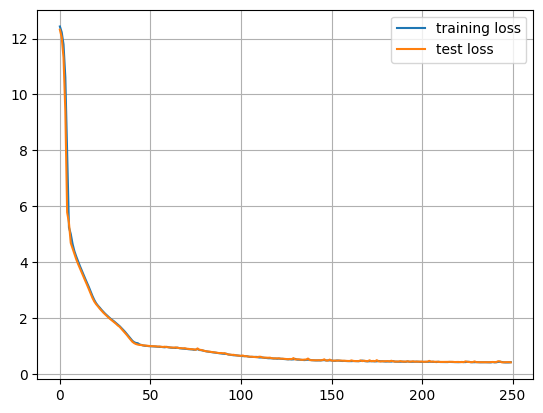

--------------------  EPOCH: 250  --------------------
LOSS train 0.4174742937088013 valid 0.4168352782726288
--------------------  EPOCH: 251  --------------------
LOSS train 0.40944583117961886 valid 0.4148622751235962
--------------------  EPOCH: 252  --------------------
LOSS train 0.4131824284791946 valid 0.433193564414978
--------------------  EPOCH: 253  --------------------
LOSS train 0.41372605264186857 valid 0.41193708777427673
--------------------  EPOCH: 254  --------------------
LOSS train 0.41293349862098694 valid 0.45591622591018677
--------------------  EPOCH: 255  --------------------
LOSS train 0.4149133235216141 valid 0.4173114597797394
--------------------  EPOCH: 256  --------------------
LOSS train 0.41038698554039 valid 0.4107317626476288
--------------------  EPOCH: 257  --------------------
LOSS train 0.40616626143455503 valid 0.41058576107025146
--------------------  EPOCH: 258  --------------------
LOSS train 0.4100331008434296 valid 0.41978010535240173
-----

LOSS train 0.3818653494119644 valid 0.38122469186782837
--------------------  EPOCH: 325  --------------------
LOSS train 0.38330161571502686 valid 0.39912277460098267
--------------------  EPOCH: 326  --------------------
LOSS train 0.3821686327457428 valid 0.40823304653167725
--------------------  EPOCH: 327  --------------------
LOSS train 0.38781494498252866 valid 0.38535717129707336
--------------------  EPOCH: 328  --------------------
LOSS train 0.38346831798553466 valid 0.3754592835903168
--------------------  EPOCH: 329  --------------------
LOSS train 0.37343125641345976 valid 0.3923383951187134
--------------------  EPOCH: 330  --------------------
LOSS train 0.3817011058330536 valid 0.3728237450122833
--------------------  EPOCH: 331  --------------------
LOSS train 0.3741486340761185 valid 0.3776986002922058
--------------------  EPOCH: 332  --------------------
LOSS train 0.36821265816688536 valid 0.3759516477584839
--------------------  EPOCH: 333  --------------------
L

LOSS train 0.31744888722896575 valid 0.3221566081047058
--------------------  EPOCH: 400  --------------------
LOSS train 0.3166216403245926 valid 0.31510111689567566
--------------------  EPOCH: 401  --------------------
LOSS train 0.3099328100681305 valid 0.3129712641239166
--------------------  EPOCH: 402  --------------------
LOSS train 0.3320688784122467 valid 0.33812713623046875
--------------------  EPOCH: 403  --------------------
LOSS train 0.3384425938129425 valid 0.3117271363735199
--------------------  EPOCH: 404  --------------------
LOSS train 0.3196577161550522 valid 0.31613343954086304
--------------------  EPOCH: 405  --------------------
LOSS train 0.3183256447315216 valid 0.31236523389816284
--------------------  EPOCH: 406  --------------------
LOSS train 0.34189940690994264 valid 0.4111320674419403
--------------------  EPOCH: 407  --------------------
LOSS train 0.3439528107643127 valid 0.3464764952659607
--------------------  EPOCH: 408  --------------------
LOSS

LOSS train 0.2992380201816559 valid 0.29468315839767456
--------------------  EPOCH: 474  --------------------
LOSS train 0.2858994483947754 valid 0.2855246365070343
--------------------  EPOCH: 475  --------------------
LOSS train 0.2811457395553589 valid 0.2876587212085724
--------------------  EPOCH: 476  --------------------
LOSS train 0.28825671076774595 valid 0.29513728618621826
--------------------  EPOCH: 477  --------------------
LOSS train 0.2887119323015213 valid 0.2836145758628845
--------------------  EPOCH: 478  --------------------
LOSS train 0.2946879923343658 valid 0.2958727180957794
--------------------  EPOCH: 479  --------------------
LOSS train 0.28330229222774506 valid 0.28457605838775635
--------------------  EPOCH: 480  --------------------
LOSS train 0.2805773913860321 valid 0.288731187582016
--------------------  EPOCH: 481  --------------------
LOSS train 0.28690294921398163 valid 0.28223058581352234
--------------------  EPOCH: 482  --------------------
LOSS

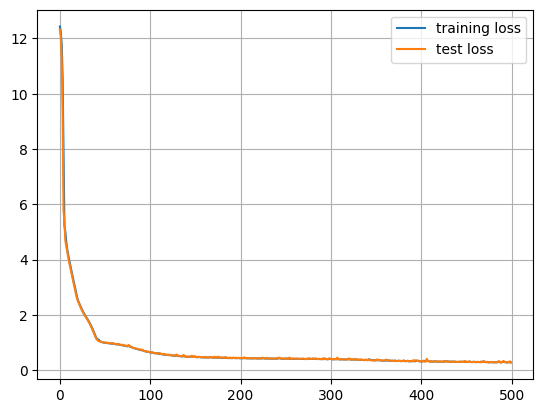

--------------------  EPOCH: 500  --------------------
LOSS train 0.27473911046981814 valid 0.2790012061595917
--------------------  EPOCH: 501  --------------------
LOSS train 0.2748535305261612 valid 0.2865625321865082
--------------------  EPOCH: 502  --------------------
LOSS train 0.2858983725309372 valid 0.2815447449684143
--------------------  EPOCH: 503  --------------------
LOSS train 0.2837865620851517 valid 0.2873828113079071
--------------------  EPOCH: 504  --------------------
LOSS train 0.2775291234254837 valid 0.2964850962162018
--------------------  EPOCH: 505  --------------------
LOSS train 0.2774908781051636 valid 0.27528226375579834
--------------------  EPOCH: 506  --------------------
LOSS train 0.2760364919900894 valid 0.28815722465515137
--------------------  EPOCH: 507  --------------------
LOSS train 0.2764709621667862 valid 0.28972184658050537
--------------------  EPOCH: 508  --------------------
LOSS train 0.2732420086860657 valid 0.2871335744857788
------

LOSS train 0.25155842751264573 valid 0.25831499695777893
--------------------  EPOCH: 575  --------------------
LOSS train 0.2519636958837509 valid 0.2626549303531647
--------------------  EPOCH: 576  --------------------
LOSS train 0.2691650688648224 valid 0.26362308859825134
--------------------  EPOCH: 577  --------------------
LOSS train 0.2558111548423767 valid 0.29574161767959595
--------------------  EPOCH: 578  --------------------
LOSS train 0.26774658262729645 valid 0.2505982518196106
--------------------  EPOCH: 579  --------------------
LOSS train 0.25747397541999817 valid 0.2504284083843231
--------------------  EPOCH: 580  --------------------
LOSS train 0.2593120664358139 valid 0.2500505745410919
--------------------  EPOCH: 581  --------------------
LOSS train 0.25570785254240036 valid 0.2744261920452118
--------------------  EPOCH: 582  --------------------
LOSS train 0.2650130897760391 valid 0.283430814743042
--------------------  EPOCH: 583  --------------------
LOSS

LOSS train 0.24160110652446748 valid 0.2455330193042755
--------------------  EPOCH: 649  --------------------
LOSS train 0.2416534408926964 valid 0.24567490816116333
--------------------  EPOCH: 650  --------------------
LOSS train 0.24174367934465407 valid 0.24538284540176392
--------------------  EPOCH: 651  --------------------
LOSS train 0.2416754573583603 valid 0.24555842578411102
--------------------  EPOCH: 652  --------------------
LOSS train 0.24195715487003328 valid 0.2456546574831009
--------------------  EPOCH: 653  --------------------
LOSS train 0.24139696210622788 valid 0.24525785446166992
--------------------  EPOCH: 654  --------------------
LOSS train 0.2414627954363823 valid 0.2454710602760315
--------------------  EPOCH: 655  --------------------
LOSS train 0.24144060164690018 valid 0.2452680468559265
--------------------  EPOCH: 656  --------------------
LOSS train 0.2414539039134979 valid 0.24515405297279358
--------------------  EPOCH: 657  --------------------


LOSS train 0.23858529329299927 valid 0.2425248920917511
--------------------  EPOCH: 723  --------------------
LOSS train 0.23838533759117125 valid 0.24268944561481476
--------------------  EPOCH: 724  --------------------
LOSS train 0.23843347132205964 valid 0.24228738248348236
--------------------  EPOCH: 725  --------------------
LOSS train 0.2384180024266243 valid 0.24191445112228394
--------------------  EPOCH: 726  --------------------
LOSS train 0.23824530690908433 valid 0.2417934536933899
--------------------  EPOCH: 727  --------------------
LOSS train 0.23803006261587142 valid 0.2422112375497818
--------------------  EPOCH: 728  --------------------
LOSS train 0.23828617483377457 valid 0.242171511054039
--------------------  EPOCH: 729  --------------------
LOSS train 0.2378376916050911 valid 0.24168610572814941
--------------------  EPOCH: 730  --------------------
LOSS train 0.23782207816839218 valid 0.24159079790115356
--------------------  EPOCH: 731  --------------------

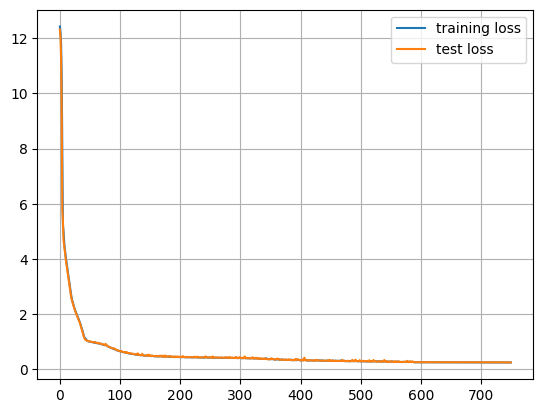

--------------------  EPOCH: 750  --------------------
LOSS train 0.2366976872086525 valid 0.2408595234155655
--------------------  EPOCH: 751  --------------------
LOSS train 0.23669397979974746 valid 0.24034808576107025
--------------------  EPOCH: 752  --------------------
LOSS train 0.23725671619176864 valid 0.24050605297088623
--------------------  EPOCH: 753  --------------------
LOSS train 0.23712648451328278 valid 0.24048744142055511
--------------------  EPOCH: 754  --------------------
LOSS train 0.23664741963148117 valid 0.24026328325271606
--------------------  EPOCH: 755  --------------------
LOSS train 0.23636191487312316 valid 0.24030517041683197
--------------------  EPOCH: 756  --------------------
LOSS train 0.23639077693223953 valid 0.2401733100414276
--------------------  EPOCH: 757  --------------------
LOSS train 0.23634717911481856 valid 0.24018818140029907
--------------------  EPOCH: 758  --------------------
LOSS train 0.23630370944738388 valid 0.2400466203689

LOSS train 0.23252951949834824 valid 0.23600400984287262
--------------------  EPOCH: 824  --------------------
LOSS train 0.23240074068307875 valid 0.23613879084587097
--------------------  EPOCH: 825  --------------------
LOSS train 0.23226969689130783 valid 0.23618215322494507
--------------------  EPOCH: 826  --------------------
LOSS train 0.2325533151626587 valid 0.23614484071731567
--------------------  EPOCH: 827  --------------------
LOSS train 0.23210762888193132 valid 0.23640255630016327
--------------------  EPOCH: 828  --------------------
LOSS train 0.23219808489084243 valid 0.2356354296207428
--------------------  EPOCH: 829  --------------------
LOSS train 0.23220399916172027 valid 0.2356037050485611
--------------------  EPOCH: 830  --------------------
LOSS train 0.2319654941558838 valid 0.23643489181995392
--------------------  EPOCH: 831  --------------------
LOSS train 0.2322957456111908 valid 0.235727921128273
--------------------  EPOCH: 832  --------------------

LOSS train 0.22703707367181777 valid 0.23091553151607513
--------------------  EPOCH: 898  --------------------
LOSS train 0.22719680070877074 valid 0.23080764710903168
--------------------  EPOCH: 899  --------------------
LOSS train 0.22732586562633514 valid 0.23095694184303284
--------------------  EPOCH: 900  --------------------
LOSS train 0.22700562030076982 valid 0.23074577748775482
--------------------  EPOCH: 901  --------------------
LOSS train 0.22688636630773545 valid 0.23060554265975952
--------------------  EPOCH: 902  --------------------
LOSS train 0.22744286358356475 valid 0.2310188263654709
--------------------  EPOCH: 903  --------------------
LOSS train 0.22788905054330827 valid 0.23143041133880615
--------------------  EPOCH: 904  --------------------
LOSS train 0.22700848877429963 valid 0.23045888543128967
--------------------  EPOCH: 905  --------------------
LOSS train 0.2271342396736145 valid 0.23102650046348572
--------------------  EPOCH: 906  ---------------

LOSS train 0.22222135663032533 valid 0.22601325809955597
--------------------  EPOCH: 972  --------------------
LOSS train 0.22215375900268555 valid 0.22590546309947968
--------------------  EPOCH: 973  --------------------
LOSS train 0.2219632312655449 valid 0.22557345032691956
--------------------  EPOCH: 974  --------------------
LOSS train 0.22269818782806397 valid 0.23011857271194458
--------------------  EPOCH: 975  --------------------
LOSS train 0.22512604743242265 valid 0.22879694402217865
--------------------  EPOCH: 976  --------------------
LOSS train 0.22384083569049834 valid 0.2253454625606537
--------------------  EPOCH: 977  --------------------
LOSS train 0.2216268450021744 valid 0.22530411183834076
--------------------  EPOCH: 978  --------------------
LOSS train 0.22163831442594528 valid 0.22571437060832977
--------------------  EPOCH: 979  --------------------
LOSS train 0.22171025723218918 valid 0.22546948492527008
--------------------  EPOCH: 980  ----------------

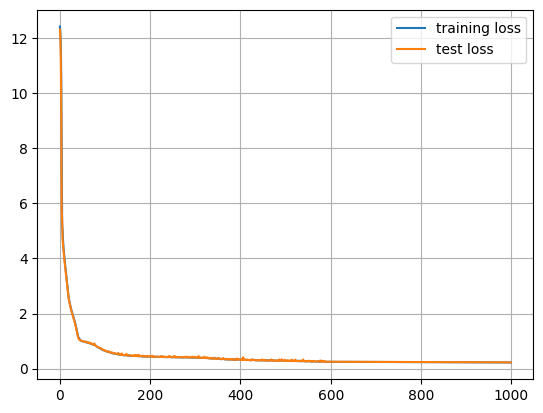

--------------------  EPOCH: 1000  --------------------
LOSS train 0.2205958679318428 valid 0.22408322989940643
--------------------  EPOCH: 1001  --------------------
LOSS train 0.22031180411577225 valid 0.22375516593456268
--------------------  EPOCH: 1002  --------------------
LOSS train 0.22032305151224135 valid 0.22376680374145508
--------------------  EPOCH: 1003  --------------------
LOSS train 0.22085603326559067 valid 0.22468805313110352
--------------------  EPOCH: 1004  --------------------
LOSS train 0.22088864743709563 valid 0.22350959479808807
--------------------  EPOCH: 1005  --------------------
LOSS train 0.220965014398098 valid 0.22589591145515442
--------------------  EPOCH: 1006  --------------------
LOSS train 0.22101041227579116 valid 0.22541779279708862
--------------------  EPOCH: 1007  --------------------
LOSS train 0.22055222243070602 valid 0.22333286702632904
--------------------  EPOCH: 1008  --------------------
LOSS train 0.21948712170124055 valid 0.2232

LOSS train 0.21566051095724106 valid 0.21909788250923157
--------------------  EPOCH: 1074  --------------------
LOSS train 0.2156716540455818 valid 0.2197885513305664
--------------------  EPOCH: 1075  --------------------
LOSS train 0.21566167771816253 valid 0.2190389335155487
--------------------  EPOCH: 1076  --------------------
LOSS train 0.21564052551984786 valid 0.21902266144752502
--------------------  EPOCH: 1077  --------------------
LOSS train 0.21550679057836533 valid 0.21882444620132446
--------------------  EPOCH: 1078  --------------------
LOSS train 0.21517980396747588 valid 0.2193049043416977
--------------------  EPOCH: 1079  --------------------
LOSS train 0.21564461439847946 valid 0.22087781131267548
--------------------  EPOCH: 1080  --------------------
LOSS train 0.21586798876523972 valid 0.21861238777637482
--------------------  EPOCH: 1081  --------------------
LOSS train 0.2157914400100708 valid 0.21954038739204407
--------------------  EPOCH: 1082  ---------

LOSS train 0.21166472584009172 valid 0.21503034234046936
--------------------  EPOCH: 1147  --------------------
LOSS train 0.2112517774105072 valid 0.21487370133399963
--------------------  EPOCH: 1148  --------------------
LOSS train 0.2114013820886612 valid 0.21652114391326904
--------------------  EPOCH: 1149  --------------------
LOSS train 0.21226599663496018 valid 0.21466706693172455
--------------------  EPOCH: 1150  --------------------
LOSS train 0.21159978806972504 valid 0.21521539986133575
--------------------  EPOCH: 1151  --------------------
LOSS train 0.21117466539144517 valid 0.2146572470664978
--------------------  EPOCH: 1152  --------------------
LOSS train 0.2116104856133461 valid 0.21656814217567444
--------------------  EPOCH: 1153  --------------------
LOSS train 0.21127117723226546 valid 0.21459516882896423
--------------------  EPOCH: 1154  --------------------
LOSS train 0.21146008968353272 valid 0.21458598971366882
--------------------  EPOCH: 1155  --------

LOSS train 0.20753009766340255 valid 0.21101263165473938
--------------------  EPOCH: 1220  --------------------
LOSS train 0.20788203775882722 valid 0.21120807528495789
--------------------  EPOCH: 1221  --------------------
LOSS train 0.20784693360328674 valid 0.21099631488323212
--------------------  EPOCH: 1222  --------------------
LOSS train 0.20777061879634856 valid 0.21130424737930298
--------------------  EPOCH: 1223  --------------------
LOSS train 0.2073638528585434 valid 0.21062640845775604
--------------------  EPOCH: 1224  --------------------
LOSS train 0.20750877559185027 valid 0.2105279564857483
--------------------  EPOCH: 1225  --------------------
LOSS train 0.20764874815940856 valid 0.21090155839920044
--------------------  EPOCH: 1226  --------------------
LOSS train 0.2072880744934082 valid 0.2104385495185852
--------------------  EPOCH: 1227  --------------------
LOSS train 0.207157926261425 valid 0.2117074429988861
--------------------  EPOCH: 1228  -----------

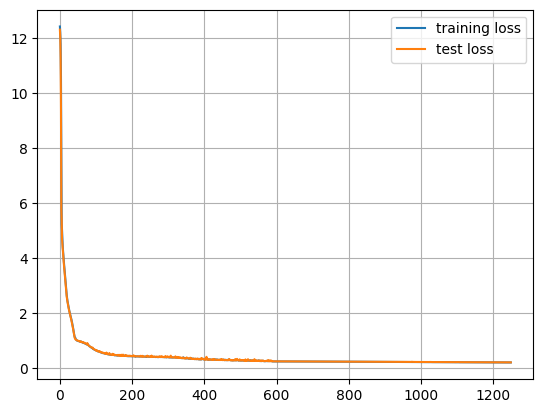

--------------------  EPOCH: 1250  --------------------
LOSS train 0.20651151984930038 valid 0.20944011211395264
--------------------  EPOCH: 1251  --------------------
LOSS train 0.20650373101234437 valid 0.209088996052742
--------------------  EPOCH: 1252  --------------------
LOSS train 0.2061672478914261 valid 0.20947898924350739
--------------------  EPOCH: 1253  --------------------
LOSS train 0.20568428337574005 valid 0.20903006196022034
--------------------  EPOCH: 1254  --------------------
LOSS train 0.20623268634080888 valid 0.21011756360530853
--------------------  EPOCH: 1255  --------------------
LOSS train 0.20616578906774521 valid 0.2098727524280548
--------------------  EPOCH: 1256  --------------------
LOSS train 0.20754189193248748 valid 0.20904555916786194
--------------------  EPOCH: 1257  --------------------
LOSS train 0.20653456896543504 valid 0.2113412320613861
--------------------  EPOCH: 1258  --------------------
LOSS train 0.20668029487133027 valid 0.209121

LOSS train 0.20307829976081848 valid 0.20579642057418823
--------------------  EPOCH: 1324  --------------------
LOSS train 0.20262226462364197 valid 0.20556290447711945
--------------------  EPOCH: 1325  --------------------
LOSS train 0.20249253362417222 valid 0.20583975315093994
--------------------  EPOCH: 1326  --------------------
LOSS train 0.2029593527317047 valid 0.20515665411949158
--------------------  EPOCH: 1327  --------------------
LOSS train 0.20286855697631836 valid 0.2056247442960739
--------------------  EPOCH: 1328  --------------------
LOSS train 0.20258113294839858 valid 0.20602436363697052
--------------------  EPOCH: 1329  --------------------
LOSS train 0.2024430200457573 valid 0.2064623385667801
--------------------  EPOCH: 1330  --------------------
LOSS train 0.20244178771972657 valid 0.20512060821056366
--------------------  EPOCH: 1331  --------------------
LOSS train 0.20262015759944915 valid 0.20504885911941528
--------------------  EPOCH: 1332  --------

LOSS train 0.19886863380670547 valid 0.20214496552944183
--------------------  EPOCH: 1397  --------------------
LOSS train 0.19918882846832275 valid 0.2018849402666092
--------------------  EPOCH: 1398  --------------------
LOSS train 0.19959539473056792 valid 0.20197297632694244
--------------------  EPOCH: 1399  --------------------
LOSS train 0.20086511969566345 valid 0.20412783324718475
--------------------  EPOCH: 1400  --------------------
LOSS train 0.1996014356613159 valid 0.2028605043888092
--------------------  EPOCH: 1401  --------------------
LOSS train 0.1996181234717369 valid 0.2028336524963379
--------------------  EPOCH: 1402  --------------------
LOSS train 0.19947781413793564 valid 0.20192866027355194
--------------------  EPOCH: 1403  --------------------
LOSS train 0.199497252702713 valid 0.20245786011219025
--------------------  EPOCH: 1404  --------------------
LOSS train 0.19935346245765687 valid 0.20231947302818298
--------------------  EPOCH: 1405  -----------

LOSS train 0.19715213775634766 valid 0.20065651834011078
--------------------  EPOCH: 1470  --------------------
LOSS train 0.19685696214437484 valid 0.19868341088294983
--------------------  EPOCH: 1471  --------------------
LOSS train 0.19567375332117082 valid 0.19833630323410034
--------------------  EPOCH: 1472  --------------------
LOSS train 0.19549547582864762 valid 0.19836507737636566
--------------------  EPOCH: 1473  --------------------
LOSS train 0.1954891175031662 valid 0.19841036200523376
--------------------  EPOCH: 1474  --------------------
LOSS train 0.19550506621599198 valid 0.19911232590675354
--------------------  EPOCH: 1475  --------------------
LOSS train 0.1958610638976097 valid 0.19826669991016388
--------------------  EPOCH: 1476  --------------------
LOSS train 0.19553785324096679 valid 0.19811409711837769
--------------------  EPOCH: 1477  --------------------
LOSS train 0.19547304958105088 valid 0.20017968118190765
--------------------  EPOCH: 1478  ------

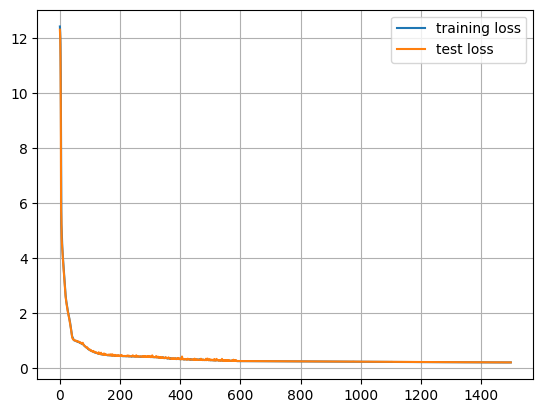

--------------------  EPOCH: 1500  --------------------
LOSS train 0.19606955498456954 valid 0.1990511268377304
--------------------  EPOCH: 1501  --------------------
LOSS train 0.19509279876947402 valid 0.1970285028219223
--------------------  EPOCH: 1502  --------------------
LOSS train 0.1943326249718666 valid 0.19709685444831848
--------------------  EPOCH: 1503  --------------------
LOSS train 0.19422799795866014 valid 0.19702741503715515
--------------------  EPOCH: 1504  --------------------
LOSS train 0.1941551148891449 valid 0.1968742460012436
--------------------  EPOCH: 1505  --------------------
LOSS train 0.19401964992284776 valid 0.19687922298908234
--------------------  EPOCH: 1506  --------------------
LOSS train 0.19401177763938904 valid 0.19679895043373108
--------------------  EPOCH: 1507  --------------------
LOSS train 0.19413239806890487 valid 0.19678182899951935
--------------------  EPOCH: 1508  --------------------
LOSS train 0.194255967438221 valid 0.19708237

LOSS train 0.19126487225294114 valid 0.19492071866989136
--------------------  EPOCH: 1574  --------------------
LOSS train 0.191560235619545 valid 0.19438780844211578
--------------------  EPOCH: 1575  --------------------
LOSS train 0.19127291440963745 valid 0.1940842866897583
--------------------  EPOCH: 1576  --------------------
LOSS train 0.19140892326831818 valid 0.1941177397966385
--------------------  EPOCH: 1577  --------------------
LOSS train 0.19138720780611038 valid 0.19478338956832886
--------------------  EPOCH: 1578  --------------------
LOSS train 0.19133525788784028 valid 0.19400770962238312
--------------------  EPOCH: 1579  --------------------
LOSS train 0.19099263846874237 valid 0.19409781694412231
--------------------  EPOCH: 1580  --------------------
LOSS train 0.191021329164505 valid 0.1945086568593979
--------------------  EPOCH: 1581  --------------------
LOSS train 0.19088262021541597 valid 0.19408537447452545
--------------------  EPOCH: 1582  -----------

LOSS train 0.18850795030593873 valid 0.19142532348632812
--------------------  EPOCH: 1647  --------------------
LOSS train 0.18885421454906465 valid 0.19303542375564575
--------------------  EPOCH: 1648  --------------------
LOSS train 0.1889823243021965 valid 0.19134080410003662
--------------------  EPOCH: 1649  --------------------
LOSS train 0.18863147646188735 valid 0.19138433039188385
--------------------  EPOCH: 1650  --------------------
LOSS train 0.18874590694904328 valid 0.1921486258506775
--------------------  EPOCH: 1651  --------------------
LOSS train 0.1886191412806511 valid 0.19146068394184113
--------------------  EPOCH: 1652  --------------------
LOSS train 0.18823878914117814 valid 0.19122137129306793
--------------------  EPOCH: 1653  --------------------
LOSS train 0.18832357078790665 valid 0.1912236511707306
--------------------  EPOCH: 1654  --------------------
LOSS train 0.18814350813627242 valid 0.19129489362239838
--------------------  EPOCH: 1655  --------

LOSS train 0.18662301898002626 valid 0.1891041398048401
--------------------  EPOCH: 1720  --------------------
LOSS train 0.18594104498624803 valid 0.18948498368263245
--------------------  EPOCH: 1721  --------------------
LOSS train 0.18632326126098633 valid 0.18972159922122955
--------------------  EPOCH: 1722  --------------------
LOSS train 0.18597399145364762 valid 0.18921782076358795
--------------------  EPOCH: 1723  --------------------
LOSS train 0.18609235882759095 valid 0.18896228075027466
--------------------  EPOCH: 1724  --------------------
LOSS train 0.1860343709588051 valid 0.18900808691978455
--------------------  EPOCH: 1725  --------------------
LOSS train 0.1859360933303833 valid 0.18898522853851318
--------------------  EPOCH: 1726  --------------------
LOSS train 0.18598855882883072 valid 0.1888161152601242
--------------------  EPOCH: 1727  --------------------
LOSS train 0.18588301539421082 valid 0.1890486478805542
--------------------  EPOCH: 1728  ---------

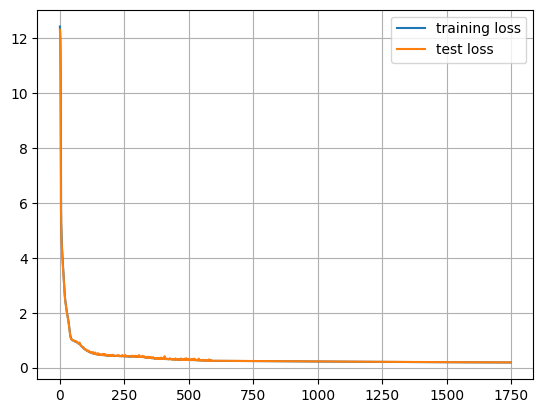

--------------------  EPOCH: 1750  --------------------
LOSS train 0.1855231925845146 valid 0.1890052855014801
--------------------  EPOCH: 1751  --------------------
LOSS train 0.18598198741674424 valid 0.18876470625400543
--------------------  EPOCH: 1752  --------------------
LOSS train 0.18556412905454636 valid 0.18867386877536774
--------------------  EPOCH: 1753  --------------------
LOSS train 0.18494114875793458 valid 0.18795888125896454
--------------------  EPOCH: 1754  --------------------
LOSS train 0.18531352877616883 valid 0.18823875486850739
--------------------  EPOCH: 1755  --------------------
LOSS train 0.18534812331199646 valid 0.18898677825927734
--------------------  EPOCH: 1756  --------------------
LOSS train 0.18602130711078643 valid 0.1882980465888977
--------------------  EPOCH: 1757  --------------------
LOSS train 0.18531832695007325 valid 0.18818813562393188
--------------------  EPOCH: 1758  --------------------
LOSS train 0.18477634638547896 valid 0.1878

LOSS train 0.1831050619482994 valid 0.18610087037086487
--------------------  EPOCH: 1824  --------------------
LOSS train 0.18336572051048278 valid 0.18603114783763885
--------------------  EPOCH: 1825  --------------------
LOSS train 0.18302363008260727 valid 0.18598462641239166
--------------------  EPOCH: 1826  --------------------
LOSS train 0.1829379603266716 valid 0.18603217601776123
--------------------  EPOCH: 1827  --------------------
LOSS train 0.1831457570195198 valid 0.1864488571882248
--------------------  EPOCH: 1828  --------------------
LOSS train 0.1834868386387825 valid 0.18588443100452423
--------------------  EPOCH: 1829  --------------------
LOSS train 0.18378522843122483 valid 0.1874731332063675
--------------------  EPOCH: 1830  --------------------
LOSS train 0.18427447676658631 valid 0.1880771815776825
--------------------  EPOCH: 1831  --------------------
LOSS train 0.18403065353631973 valid 0.18603605031967163
--------------------  EPOCH: 1832  -----------

LOSS train 0.18135607987642288 valid 0.18554440140724182
--------------------  EPOCH: 1897  --------------------
LOSS train 0.1821603685617447 valid 0.18485257029533386
--------------------  EPOCH: 1898  --------------------
LOSS train 0.18114893585443498 valid 0.18424636125564575
--------------------  EPOCH: 1899  --------------------
LOSS train 0.18111201822757722 valid 0.1842850297689438
--------------------  EPOCH: 1900  --------------------
LOSS train 0.18102598339319229 valid 0.18470130860805511
--------------------  EPOCH: 1901  --------------------
LOSS train 0.18231787979602815 valid 0.1839643120765686
--------------------  EPOCH: 1902  --------------------
LOSS train 0.18212339133024216 valid 0.18396103382110596
--------------------  EPOCH: 1903  --------------------
LOSS train 0.18112081289291382 valid 0.18399764597415924
--------------------  EPOCH: 1904  --------------------
LOSS train 0.1811672940850258 valid 0.1838514506816864
--------------------  EPOCH: 1905  ---------

LOSS train 0.17954563051462175 valid 0.18279363214969635
--------------------  EPOCH: 1970  --------------------
LOSS train 0.17946821302175522 valid 0.18304580450057983
--------------------  EPOCH: 1971  --------------------
LOSS train 0.1797419786453247 valid 0.18226827681064606
--------------------  EPOCH: 1972  --------------------
LOSS train 0.17927159368991852 valid 0.18298599123954773
--------------------  EPOCH: 1973  --------------------
LOSS train 0.17967727184295654 valid 0.18267227709293365
--------------------  EPOCH: 1974  --------------------
LOSS train 0.17944323569536208 valid 0.18227937817573547
--------------------  EPOCH: 1975  --------------------
LOSS train 0.1791481241583824 valid 0.18228985369205475
--------------------  EPOCH: 1976  --------------------
LOSS train 0.17890963107347488 valid 0.18249528110027313
--------------------  EPOCH: 1977  --------------------
LOSS train 0.17946241348981856 valid 0.18232309818267822
--------------------  EPOCH: 1978  ------

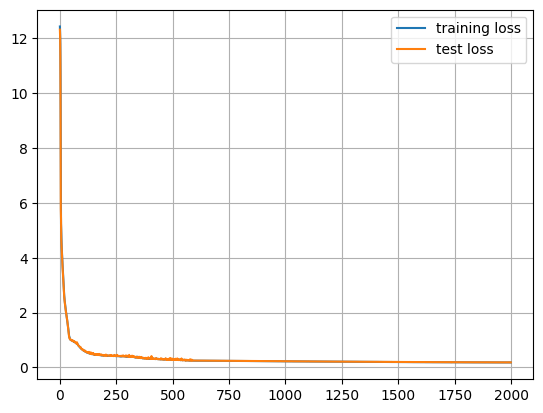

--------------------  EPOCH: 2000  --------------------
LOSS train 0.17899998426437377 valid 0.18196001648902893
--------------------  EPOCH: 2001  --------------------
LOSS train 0.17888289988040923 valid 0.18180955946445465
--------------------  EPOCH: 2002  --------------------
LOSS train 0.17892707735300065 valid 0.18238192796707153
--------------------  EPOCH: 2003  --------------------
LOSS train 0.17942189574241638 valid 0.18163977563381195
--------------------  EPOCH: 2004  --------------------
LOSS train 0.17924826741218566 valid 0.1824103146791458
--------------------  EPOCH: 2005  --------------------
LOSS train 0.17918887883424758 valid 0.1815376728773117
--------------------  EPOCH: 2006  --------------------
LOSS train 0.17861254513263702 valid 0.1815946251153946
--------------------  EPOCH: 2007  --------------------
LOSS train 0.17847933173179625 valid 0.1823902130126953
--------------------  EPOCH: 2008  --------------------
LOSS train 0.178660249710083 valid 0.1829921

LOSS train 0.17686930447816848 valid 0.18011145293712616
--------------------  EPOCH: 2074  --------------------
LOSS train 0.17689217925071715 valid 0.17996357381343842
--------------------  EPOCH: 2075  --------------------
LOSS train 0.17712142318487167 valid 0.17998278141021729
--------------------  EPOCH: 2076  --------------------
LOSS train 0.17711451947689055 valid 0.17992070317268372
--------------------  EPOCH: 2077  --------------------
LOSS train 0.17654586732387542 valid 0.1799565553665161
--------------------  EPOCH: 2078  --------------------
LOSS train 0.17700489312410356 valid 0.18029125034809113
--------------------  EPOCH: 2079  --------------------
LOSS train 0.17690009772777557 valid 0.17989416420459747
--------------------  EPOCH: 2080  --------------------
LOSS train 0.17664642333984376 valid 0.18051114678382874
--------------------  EPOCH: 2081  --------------------
LOSS train 0.1768785983324051 valid 0.18023203313350677
--------------------  EPOCH: 2082  ------

LOSS train 0.17619977742433549 valid 0.17856262624263763
--------------------  EPOCH: 2147  --------------------
LOSS train 0.17533646672964096 valid 0.17856134474277496
--------------------  EPOCH: 2148  --------------------
LOSS train 0.1755291312932968 valid 0.17857740819454193
--------------------  EPOCH: 2149  --------------------
LOSS train 0.17511341273784636 valid 0.17905691266059875
--------------------  EPOCH: 2150  --------------------
LOSS train 0.17519424706697465 valid 0.17850813269615173
--------------------  EPOCH: 2151  --------------------
LOSS train 0.17523788064718246 valid 0.1787794828414917
--------------------  EPOCH: 2152  --------------------
LOSS train 0.17523758560419084 valid 0.17862460017204285
--------------------  EPOCH: 2153  --------------------
LOSS train 0.17516914159059524 valid 0.17828719317913055
--------------------  EPOCH: 2154  --------------------
LOSS train 0.1753173589706421 valid 0.18028755486011505
--------------------  EPOCH: 2155  -------

LOSS train 0.17554402202367783 valid 0.1771293729543686
--------------------  EPOCH: 2220  --------------------
LOSS train 0.17436693757772445 valid 0.17709587514400482
--------------------  EPOCH: 2221  --------------------
LOSS train 0.1740935117006302 valid 0.177153542637825
--------------------  EPOCH: 2222  --------------------
LOSS train 0.17435017079114914 valid 0.17755547165870667
--------------------  EPOCH: 2223  --------------------
LOSS train 0.17442478239536285 valid 0.1800093799829483
--------------------  EPOCH: 2224  --------------------
LOSS train 0.17485396265983583 valid 0.1778971254825592
--------------------  EPOCH: 2225  --------------------
LOSS train 0.17397310435771943 valid 0.17760802805423737
--------------------  EPOCH: 2226  --------------------
LOSS train 0.17373968660831451 valid 0.17710094153881073
--------------------  EPOCH: 2227  --------------------
LOSS train 0.1737738683819771 valid 0.17710359394550323
--------------------  EPOCH: 2228  -----------

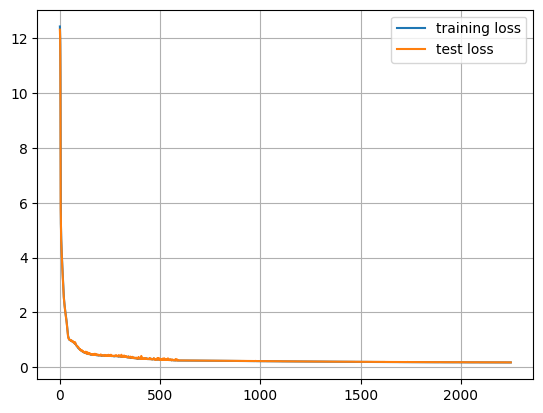

--------------------  EPOCH: 2250  --------------------
LOSS train 0.17348966896533966 valid 0.17675291001796722
--------------------  EPOCH: 2251  --------------------
LOSS train 0.17350181937217712 valid 0.17661242187023163
--------------------  EPOCH: 2252  --------------------
LOSS train 0.1735573172569275 valid 0.17669647932052612
--------------------  EPOCH: 2253  --------------------
LOSS train 0.17314746081829072 valid 0.1766739934682846
--------------------  EPOCH: 2254  --------------------
LOSS train 0.17341362982988356 valid 0.17691393196582794
--------------------  EPOCH: 2255  --------------------
LOSS train 0.17378258109092712 valid 0.17654365301132202
--------------------  EPOCH: 2256  --------------------
LOSS train 0.17318814098834992 valid 0.1765616536140442
--------------------  EPOCH: 2257  --------------------
LOSS train 0.17318311631679534 valid 0.1763533651828766
--------------------  EPOCH: 2258  --------------------
LOSS train 0.1732493132352829 valid 0.176482

LOSS train 0.17195105254650117 valid 0.17547152936458588
--------------------  EPOCH: 2323  --------------------
LOSS train 0.17186826318502427 valid 0.17549452185630798
--------------------  EPOCH: 2324  --------------------
LOSS train 0.1719169318675995 valid 0.17545060813426971
--------------------  EPOCH: 2325  --------------------
LOSS train 0.1719682201743126 valid 0.17546509206295013
--------------------  EPOCH: 2326  --------------------
LOSS train 0.17188621908426285 valid 0.17543433606624603
--------------------  EPOCH: 2327  --------------------
LOSS train 0.1719032570719719 valid 0.17546111345291138
--------------------  EPOCH: 2328  --------------------
LOSS train 0.1718950316309929 valid 0.17547032237052917
--------------------  EPOCH: 2329  --------------------
LOSS train 0.17211053669452667 valid 0.17546497285366058
--------------------  EPOCH: 2330  --------------------
LOSS train 0.17198934108018876 valid 0.1754351705312729
--------------------  EPOCH: 2331  ---------

LOSS train 0.1717461809515953 valid 0.1753147691488266
--------------------  EPOCH: 2396  --------------------
LOSS train 0.17176590263843536 valid 0.17531445622444153
--------------------  EPOCH: 2397  --------------------
LOSS train 0.1717944085597992 valid 0.17531676590442657
--------------------  EPOCH: 2398  --------------------
LOSS train 0.17172398567199706 valid 0.1753145009279251
--------------------  EPOCH: 2399  --------------------
LOSS train 0.17178460508584975 valid 0.17531439661979675
--------------------  EPOCH: 2400  --------------------
LOSS train 0.17167081236839293 valid 0.17531415820121765
--------------------  EPOCH: 2401  --------------------
LOSS train 0.17172143161296843 valid 0.17531439661979675
--------------------  EPOCH: 2402  --------------------
LOSS train 0.1717945858836174 valid 0.1753150075674057
--------------------  EPOCH: 2403  --------------------
LOSS train 0.17182548493146896 valid 0.17531335353851318
--------------------  EPOCH: 2404  ----------

LOSS train 0.1718566372990608 valid 0.17531238496303558
--------------------  EPOCH: 2469  --------------------
LOSS train 0.1716757282614708 valid 0.175312340259552
--------------------  EPOCH: 2470  --------------------
LOSS train 0.17178357392549515 valid 0.17531226575374603
--------------------  EPOCH: 2471  --------------------
LOSS train 0.17176086455583572 valid 0.17531222105026245
--------------------  EPOCH: 2472  --------------------
LOSS train 0.17177098095417023 valid 0.17531219124794006
--------------------  EPOCH: 2473  --------------------
LOSS train 0.17168441265821457 valid 0.175312340259552
--------------------  EPOCH: 2474  --------------------
LOSS train 0.17173340171575546 valid 0.17531222105026245
--------------------  EPOCH: 2475  --------------------
LOSS train 0.17169631123542786 valid 0.1753123253583908
--------------------  EPOCH: 2476  --------------------
LOSS train 0.1718502551317215 valid 0.17531214654445648
--------------------  EPOCH: 2477  ------------

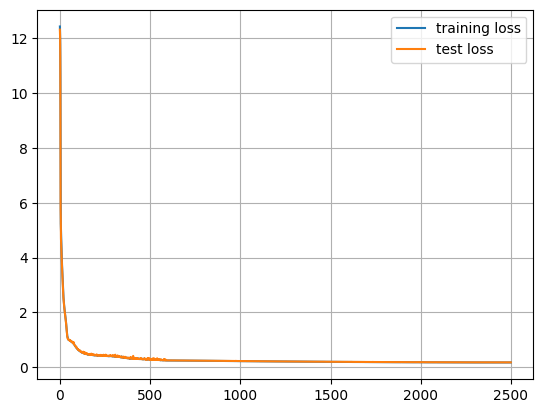

--------------------  EPOCH: 2500  --------------------
LOSS train 0.17174759209156037 valid 0.1753115952014923
--------------------  EPOCH: 2501  --------------------
LOSS train 0.17186686843633653 valid 0.17531156539916992
--------------------  EPOCH: 2502  --------------------
LOSS train 0.17176670879125594 valid 0.1753115952014923
--------------------  EPOCH: 2503  --------------------
LOSS train 0.1718301922082901 valid 0.17531166970729828
--------------------  EPOCH: 2504  --------------------
LOSS train 0.17166040390729903 valid 0.17531168460845947
--------------------  EPOCH: 2505  --------------------
LOSS train 0.17169963866472243 valid 0.17531166970729828
--------------------  EPOCH: 2506  --------------------
LOSS train 0.17168783396482468 valid 0.17531171441078186
--------------------  EPOCH: 2507  --------------------
LOSS train 0.17179421931505204 valid 0.17531166970729828
--------------------  EPOCH: 2508  --------------------
LOSS train 0.17159190475940705 valid 0.1753

LOSS train 0.1717780724167824 valid 0.1753104329109192
--------------------  EPOCH: 2574  --------------------
LOSS train 0.17174312472343445 valid 0.17531044781208038
--------------------  EPOCH: 2575  --------------------
LOSS train 0.1717293828725815 valid 0.17531061172485352
--------------------  EPOCH: 2576  --------------------
LOSS train 0.171754889190197 valid 0.175310418009758
--------------------  EPOCH: 2577  --------------------
LOSS train 0.17179688215255737 valid 0.17531055212020874
--------------------  EPOCH: 2578  --------------------
LOSS train 0.17163555771112443 valid 0.17531052231788635
--------------------  EPOCH: 2579  --------------------
LOSS train 0.17176470458507537 valid 0.17531032860279083
--------------------  EPOCH: 2580  --------------------
LOSS train 0.17177900820970535 valid 0.17531047761440277
--------------------  EPOCH: 2581  --------------------
LOSS train 0.17180184721946717 valid 0.1753106266260147
--------------------  EPOCH: 2582  ------------

LOSS train 0.17180588841438293 valid 0.17530885338783264
--------------------  EPOCH: 2647  --------------------
LOSS train 0.1717453196644783 valid 0.1753087192773819
--------------------  EPOCH: 2648  --------------------
LOSS train 0.17177298665046692 valid 0.17530876398086548
--------------------  EPOCH: 2649  --------------------
LOSS train 0.1718747928738594 valid 0.1753087341785431
--------------------  EPOCH: 2650  --------------------
LOSS train 0.17164317816495894 valid 0.17530886828899384
--------------------  EPOCH: 2651  --------------------
LOSS train 0.171882526576519 valid 0.17530885338783264
--------------------  EPOCH: 2652  --------------------
LOSS train 0.1718464896082878 valid 0.17530861496925354
--------------------  EPOCH: 2653  --------------------
LOSS train 0.17171389758586883 valid 0.175308495759964
--------------------  EPOCH: 2654  --------------------
LOSS train 0.1717139720916748 valid 0.17530861496925354
--------------------  EPOCH: 2655  --------------

LOSS train 0.17174530476331712 valid 0.17530661821365356
--------------------  EPOCH: 2720  --------------------
LOSS train 0.1716817408800125 valid 0.17530634999275208
--------------------  EPOCH: 2721  --------------------
LOSS train 0.17172559201717377 valid 0.17530673742294312
--------------------  EPOCH: 2722  --------------------
LOSS train 0.17189212739467621 valid 0.17530658841133118
--------------------  EPOCH: 2723  --------------------
LOSS train 0.17177176624536514 valid 0.1753062605857849
--------------------  EPOCH: 2724  --------------------
LOSS train 0.17173437029123306 valid 0.17530617117881775
--------------------  EPOCH: 2725  --------------------
LOSS train 0.17167050689458846 valid 0.17530661821365356
--------------------  EPOCH: 2726  --------------------
LOSS train 0.17180316001176835 valid 0.1753062754869461
--------------------  EPOCH: 2727  --------------------
LOSS train 0.17180391848087312 valid 0.1753063052892685
--------------------  EPOCH: 2728  --------

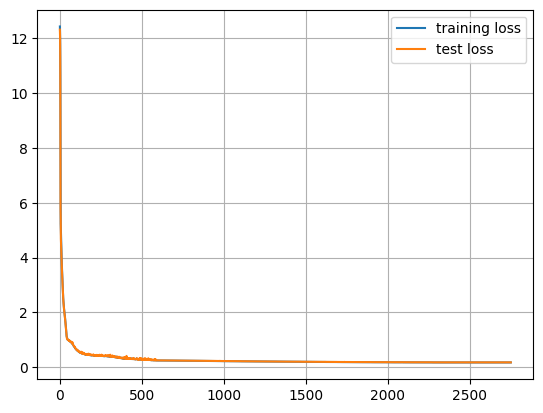

--------------------  EPOCH: 2750  --------------------
LOSS train 0.1717842474579811 valid 0.17530538141727448
--------------------  EPOCH: 2751  --------------------
LOSS train 0.17176647633314132 valid 0.17530538141727448
--------------------  EPOCH: 2752  --------------------
LOSS train 0.17177217602729797 valid 0.17530538141727448
--------------------  EPOCH: 2753  --------------------
LOSS train 0.17179709076881408 valid 0.1753057986497879
--------------------  EPOCH: 2754  --------------------
LOSS train 0.17183757424354554 valid 0.17530551552772522
--------------------  EPOCH: 2755  --------------------
LOSS train 0.17167870104312896 valid 0.1753053516149521
--------------------  EPOCH: 2756  --------------------
LOSS train 0.17167864888906478 valid 0.17530567944049835
--------------------  EPOCH: 2757  --------------------
LOSS train 0.1717169001698494 valid 0.17530567944049835
--------------------  EPOCH: 2758  --------------------
LOSS train 0.17170232832431792 valid 0.17530

LOSS train 0.17169961035251619 valid 0.17530317604541779
--------------------  EPOCH: 2824  --------------------
LOSS train 0.17185202687978746 valid 0.17530320584774017
--------------------  EPOCH: 2825  --------------------
LOSS train 0.1716684266924858 valid 0.17530320584774017
--------------------  EPOCH: 2826  --------------------
LOSS train 0.17169926166534424 valid 0.17530332505702972
--------------------  EPOCH: 2827  --------------------
LOSS train 0.1716931641101837 valid 0.1753031313419342
--------------------  EPOCH: 2828  --------------------
LOSS train 0.17180971652269364 valid 0.17530299723148346
--------------------  EPOCH: 2829  --------------------
LOSS train 0.17172226756811143 valid 0.17530286312103271
--------------------  EPOCH: 2830  --------------------
LOSS train 0.17181724607944487 valid 0.17530295252799988
--------------------  EPOCH: 2831  --------------------
LOSS train 0.17177259624004365 valid 0.1753026843070984
--------------------  EPOCH: 2832  --------

LOSS train 0.17177382707595826 valid 0.17530076205730438
--------------------  EPOCH: 2897  --------------------
LOSS train 0.17167291045188904 valid 0.17530038952827454
--------------------  EPOCH: 2898  --------------------
LOSS train 0.17178887575864793 valid 0.1753004789352417
--------------------  EPOCH: 2899  --------------------
LOSS train 0.17190099209547044 valid 0.17530038952827454
--------------------  EPOCH: 2900  --------------------
LOSS train 0.17172192633152009 valid 0.17530056834220886
--------------------  EPOCH: 2901  --------------------
LOSS train 0.17175027579069138 valid 0.1753007471561432
--------------------  EPOCH: 2902  --------------------
LOSS train 0.17182720452547073 valid 0.1753007024526596
--------------------  EPOCH: 2903  --------------------
LOSS train 0.1718299776315689 valid 0.17530088126659393
--------------------  EPOCH: 2904  --------------------
LOSS train 0.1718045577406883 valid 0.17530058324337006
--------------------  EPOCH: 2905  ---------

LOSS train 0.1716701567173004 valid 0.175298273563385
--------------------  EPOCH: 2970  --------------------
LOSS train 0.17160505503416063 valid 0.17529816925525665
--------------------  EPOCH: 2971  --------------------
LOSS train 0.171762216091156 valid 0.17529822885990143
--------------------  EPOCH: 2972  --------------------
LOSS train 0.17182384431362152 valid 0.17529863119125366
--------------------  EPOCH: 2973  --------------------
LOSS train 0.17179752737283707 valid 0.17529840767383575
--------------------  EPOCH: 2974  --------------------
LOSS train 0.17165084928274155 valid 0.17529882490634918
--------------------  EPOCH: 2975  --------------------
LOSS train 0.17165238559246063 valid 0.17529866099357605
--------------------  EPOCH: 2976  --------------------
LOSS train 0.17180015593767167 valid 0.17529810965061188
--------------------  EPOCH: 2977  --------------------
LOSS train 0.17169950902462006 valid 0.17529800534248352
--------------------  EPOCH: 2978  ---------

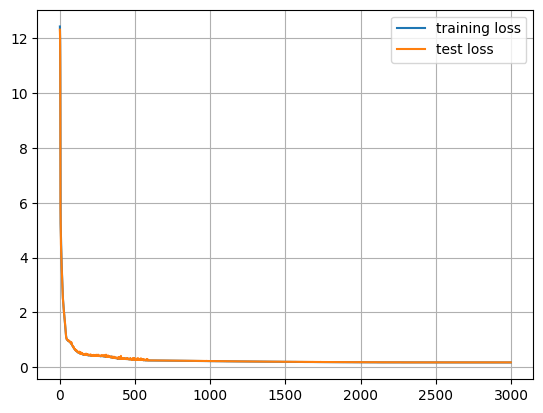

--------------------  EPOCH: 3000  --------------------
LOSS train 0.17160147726535796 valid 0.17529742419719696
--------------------  EPOCH: 3001  --------------------
LOSS train 0.17167241275310516 valid 0.17529799044132233
--------------------  EPOCH: 3002  --------------------
LOSS train 0.1717831552028656 valid 0.17529723048210144
--------------------  EPOCH: 3003  --------------------
LOSS train 0.17174499481916428 valid 0.17529720067977905
--------------------  EPOCH: 3004  --------------------
LOSS train 0.1716644883155823 valid 0.17529751360416412
--------------------  EPOCH: 3005  --------------------
LOSS train 0.17170432060956956 valid 0.1752980649471283
--------------------  EPOCH: 3006  --------------------
LOSS train 0.17186980247497557 valid 0.17529788613319397
--------------------  EPOCH: 3007  --------------------
LOSS train 0.17177158147096633 valid 0.1752970665693283
--------------------  EPOCH: 3008  --------------------
LOSS train 0.17161257416009904 valid 0.17529

LOSS train 0.17174962610006334 valid 0.1752943992614746
--------------------  EPOCH: 3074  --------------------
LOSS train 0.17171811014413835 valid 0.17529456317424774
--------------------  EPOCH: 3075  --------------------
LOSS train 0.17183243930339814 valid 0.17529472708702087
--------------------  EPOCH: 3076  --------------------
LOSS train 0.17178566455841066 valid 0.1752946525812149
--------------------  EPOCH: 3077  --------------------
LOSS train 0.17172988504171371 valid 0.1752943992614746
--------------------  EPOCH: 3078  --------------------
LOSS train 0.17174131721258162 valid 0.17529459297657013
--------------------  EPOCH: 3079  --------------------
LOSS train 0.17176093608140947 valid 0.17529447376728058
--------------------  EPOCH: 3080  --------------------
LOSS train 0.17169539332389833 valid 0.17529422044754028
--------------------  EPOCH: 3081  --------------------
LOSS train 0.17178477048873902 valid 0.17529422044754028
--------------------  EPOCH: 3082  -------

LOSS train 0.17174872159957885 valid 0.17529179155826569
--------------------  EPOCH: 3148  --------------------
LOSS train 0.17180375158786773 valid 0.17529216408729553
--------------------  EPOCH: 3149  --------------------
LOSS train 0.17165253609418868 valid 0.17529234290122986
--------------------  EPOCH: 3150  --------------------
LOSS train 0.17173360735177995 valid 0.17529159784317017
--------------------  EPOCH: 3151  --------------------
LOSS train 0.17163973450660705 valid 0.17529165744781494
--------------------  EPOCH: 3152  --------------------
LOSS train 0.17180438190698624 valid 0.1752917617559433
--------------------  EPOCH: 3153  --------------------
LOSS train 0.17177196443080903 valid 0.17529208958148956
--------------------  EPOCH: 3154  --------------------
LOSS train 0.17181076109409332 valid 0.17529141902923584
--------------------  EPOCH: 3155  --------------------
LOSS train 0.17175931632518768 valid 0.17529156804084778
--------------------  EPOCH: 3156  -----

LOSS train 0.17172747999429702 valid 0.17528916895389557
--------------------  EPOCH: 3221  --------------------
LOSS train 0.17179175168275834 valid 0.17528888583183289
--------------------  EPOCH: 3222  --------------------
LOSS train 0.17156920433044434 valid 0.1752888709306717
--------------------  EPOCH: 3223  --------------------
LOSS train 0.17166200578212737 valid 0.17528878152370453
--------------------  EPOCH: 3224  --------------------
LOSS train 0.1717524364590645 valid 0.1752888262271881
--------------------  EPOCH: 3225  --------------------
LOSS train 0.17176464796066285 valid 0.17528897523880005
--------------------  EPOCH: 3226  --------------------
LOSS train 0.1718289867043495 valid 0.17528878152370453
--------------------  EPOCH: 3227  --------------------
LOSS train 0.17174696177244186 valid 0.17528881132602692
--------------------  EPOCH: 3228  --------------------
LOSS train 0.17173079401254654 valid 0.1752888262271881
--------------------  EPOCH: 3229  ---------

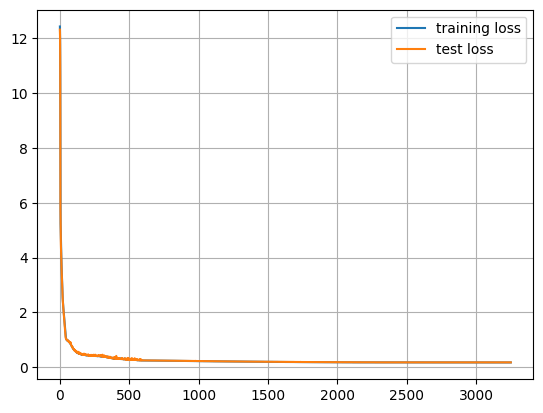

--------------------  EPOCH: 3250  --------------------
LOSS train 0.1717905580997467 valid 0.17528821527957916
--------------------  EPOCH: 3251  --------------------
LOSS train 0.1717073753476143 valid 0.17528797686100006
--------------------  EPOCH: 3252  --------------------
LOSS train 0.17166237980127336 valid 0.1752876341342926
--------------------  EPOCH: 3253  --------------------
LOSS train 0.17166041433811188 valid 0.17528769373893738
--------------------  EPOCH: 3254  --------------------
LOSS train 0.17154409140348434 valid 0.17528772354125977
--------------------  EPOCH: 3255  --------------------
LOSS train 0.1717871308326721 valid 0.1752881407737732
--------------------  EPOCH: 3256  --------------------
LOSS train 0.17164286226034164 valid 0.1752878874540329
--------------------  EPOCH: 3257  --------------------
LOSS train 0.17163359522819518 valid 0.1752878576517105
--------------------  EPOCH: 3258  --------------------
LOSS train 0.1716821536421776 valid 0.175287634

LOSS train 0.17175366431474687 valid 0.17528562247753143
--------------------  EPOCH: 3324  --------------------
LOSS train 0.1717724621295929 valid 0.17528536915779114
--------------------  EPOCH: 3325  --------------------
LOSS train 0.17168681770563127 valid 0.17528514564037323
--------------------  EPOCH: 3326  --------------------
LOSS train 0.17182762175798416 valid 0.17528483271598816
--------------------  EPOCH: 3327  --------------------
LOSS train 0.17185309231281282 valid 0.17528486251831055
--------------------  EPOCH: 3328  --------------------
LOSS train 0.17179034501314164 valid 0.17528477311134338
--------------------  EPOCH: 3329  --------------------
LOSS train 0.17168016582727433 valid 0.17528480291366577
--------------------  EPOCH: 3330  --------------------
LOSS train 0.171680349111557 valid 0.17528517544269562
--------------------  EPOCH: 3331  --------------------
LOSS train 0.17177677601575853 valid 0.1752849668264389
--------------------  EPOCH: 3332  --------

LOSS train 0.17171100825071334 valid 0.17528201639652252
--------------------  EPOCH: 3397  --------------------
LOSS train 0.17188182324171067 valid 0.17528295516967773
--------------------  EPOCH: 3398  --------------------
LOSS train 0.1717775970697403 valid 0.17528249323368073
--------------------  EPOCH: 3399  --------------------
LOSS train 0.17180392146110535 valid 0.17528188228607178
--------------------  EPOCH: 3400  --------------------
LOSS train 0.17169928103685378 valid 0.17528167366981506
--------------------  EPOCH: 3401  --------------------
LOSS train 0.1715986669063568 valid 0.17528171837329865
--------------------  EPOCH: 3402  --------------------
LOSS train 0.1717299833893776 valid 0.17528164386749268
--------------------  EPOCH: 3403  --------------------
LOSS train 0.17162175327539445 valid 0.17528177797794342
--------------------  EPOCH: 3404  --------------------
LOSS train 0.17182157933712006 valid 0.17528165876865387
--------------------  EPOCH: 3405  -------

LOSS train 0.1716715544462204 valid 0.17527900636196136
--------------------  EPOCH: 3470  --------------------
LOSS train 0.1717291623353958 valid 0.175279438495636
--------------------  EPOCH: 3471  --------------------
LOSS train 0.1719433158636093 valid 0.17527900636196136
--------------------  EPOCH: 3472  --------------------
LOSS train 0.17167822122573853 valid 0.17527903616428375
--------------------  EPOCH: 3473  --------------------
LOSS train 0.17185299843549728 valid 0.17527905106544495
--------------------  EPOCH: 3474  --------------------
LOSS train 0.17176827192306518 valid 0.17527878284454346
--------------------  EPOCH: 3475  --------------------
LOSS train 0.1717076286673546 valid 0.1752786785364151
--------------------  EPOCH: 3476  --------------------
LOSS train 0.1716359496116638 valid 0.17527876794338226
--------------------  EPOCH: 3477  --------------------
LOSS train 0.17166862934827803 valid 0.17527887225151062
--------------------  EPOCH: 3478  ------------

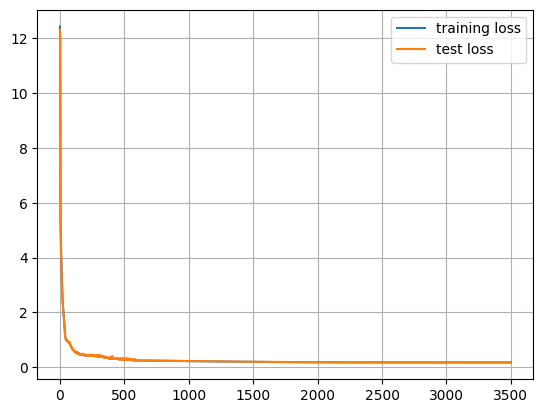

--------------------  EPOCH: 3500  --------------------
LOSS train 0.1716870352625847 valid 0.17527765035629272
--------------------  EPOCH: 3501  --------------------
LOSS train 0.171583653986454 valid 0.17527814209461212
--------------------  EPOCH: 3502  --------------------
LOSS train 0.17163523733615876 valid 0.1752779334783554
--------------------  EPOCH: 3503  --------------------
LOSS train 0.17164866477251053 valid 0.17527756094932556
--------------------  EPOCH: 3504  --------------------
LOSS train 0.1716857373714447 valid 0.1752776950597763
--------------------  EPOCH: 3505  --------------------
LOSS train 0.17178334593772887 valid 0.17527790367603302
--------------------  EPOCH: 3506  --------------------
LOSS train 0.17184188961982727 valid 0.1752777397632599
--------------------  EPOCH: 3507  --------------------
LOSS train 0.1717250496149063 valid 0.17527753114700317
--------------------  EPOCH: 3508  --------------------
LOSS train 0.17179778069257737 valid 0.175277456

LOSS train 0.17163700014352798 valid 0.1752747893333435
--------------------  EPOCH: 3574  --------------------
LOSS train 0.17173768877983092 valid 0.17527459561824799
--------------------  EPOCH: 3575  --------------------
LOSS train 0.17161419689655305 valid 0.1752743422985077
--------------------  EPOCH: 3576  --------------------
LOSS train 0.17173850238323213 valid 0.17527438700199127
--------------------  EPOCH: 3577  --------------------
LOSS train 0.1718893513083458 valid 0.1752743124961853
--------------------  EPOCH: 3578  --------------------
LOSS train 0.17185542434453965 valid 0.17527428269386292
--------------------  EPOCH: 3579  --------------------
LOSS train 0.1716713786125183 valid 0.17527444660663605
--------------------  EPOCH: 3580  --------------------
LOSS train 0.1717108353972435 valid 0.17527468502521515
--------------------  EPOCH: 3581  --------------------
LOSS train 0.1717801034450531 valid 0.17527438700199127
--------------------  EPOCH: 3582  -----------

LOSS train 0.17164474427700044 valid 0.17527124285697937
--------------------  EPOCH: 3648  --------------------
LOSS train 0.17166764587163924 valid 0.17527110874652863
--------------------  EPOCH: 3649  --------------------
LOSS train 0.17168935686349868 valid 0.17527110874652863
--------------------  EPOCH: 3650  --------------------
LOSS train 0.1717127740383148 valid 0.17527109384536743
--------------------  EPOCH: 3651  --------------------
LOSS train 0.1716807171702385 valid 0.1752716302871704
--------------------  EPOCH: 3652  --------------------
LOSS train 0.171617229282856 valid 0.1752709448337555
--------------------  EPOCH: 3653  --------------------
LOSS train 0.1717076927423477 valid 0.1752709448337555
--------------------  EPOCH: 3654  --------------------
LOSS train 0.17159511297941207 valid 0.17527084052562714
--------------------  EPOCH: 3655  --------------------
LOSS train 0.17162629812955857 valid 0.1752709001302719
--------------------  EPOCH: 3656  -------------

LOSS train 0.17167563140392303 valid 0.17526791989803314
--------------------  EPOCH: 3721  --------------------
LOSS train 0.17177353352308272 valid 0.1752680242061615
--------------------  EPOCH: 3722  --------------------
LOSS train 0.17163477838039398 valid 0.17526786029338837
--------------------  EPOCH: 3723  --------------------
LOSS train 0.17183906435966492 valid 0.1752679944038391
--------------------  EPOCH: 3724  --------------------
LOSS train 0.17160944044589996 valid 0.1752678006887436
--------------------  EPOCH: 3725  --------------------
LOSS train 0.1716740295290947 valid 0.1752677708864212
--------------------  EPOCH: 3726  --------------------
LOSS train 0.17180133014917373 valid 0.17526768147945404
--------------------  EPOCH: 3727  --------------------
LOSS train 0.17169640362262725 valid 0.17526774108409882
--------------------  EPOCH: 3728  --------------------
LOSS train 0.1715927317738533 valid 0.17526781558990479
--------------------  EPOCH: 3729  ----------

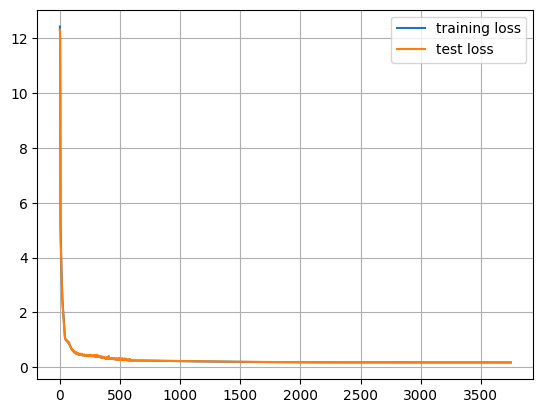

--------------------  EPOCH: 3750  --------------------
LOSS train 0.17165632396936417 valid 0.1752668023109436
--------------------  EPOCH: 3751  --------------------
LOSS train 0.17173047363758087 valid 0.17526653409004211
--------------------  EPOCH: 3752  --------------------
LOSS train 0.1717962458729744 valid 0.17526651918888092
--------------------  EPOCH: 3753  --------------------
LOSS train 0.17167204916477202 valid 0.1752668023109436
--------------------  EPOCH: 3754  --------------------
LOSS train 0.171724371612072 valid 0.17526668310165405
--------------------  EPOCH: 3755  --------------------
LOSS train 0.17182590961456298 valid 0.17526644468307495
--------------------  EPOCH: 3756  --------------------
LOSS train 0.1716226190328598 valid 0.17526653409004211
--------------------  EPOCH: 3757  --------------------
LOSS train 0.17173516899347305 valid 0.17526674270629883
--------------------  EPOCH: 3758  --------------------
LOSS train 0.17174209505319596 valid 0.1752664

LOSS train 0.17171908915042877 valid 0.17526330053806305
--------------------  EPOCH: 3824  --------------------
LOSS train 0.1717257633805275 valid 0.17526313662528992
--------------------  EPOCH: 3825  --------------------
LOSS train 0.17153631895780563 valid 0.17526312172412872
--------------------  EPOCH: 3826  --------------------
LOSS train 0.17178047746419906 valid 0.1752632111310959
--------------------  EPOCH: 3827  --------------------
LOSS train 0.17173064053058623 valid 0.1752634346485138
--------------------  EPOCH: 3828  --------------------
LOSS train 0.17170558720827103 valid 0.17526306211948395
--------------------  EPOCH: 3829  --------------------
LOSS train 0.17164604514837264 valid 0.1752631962299347
--------------------  EPOCH: 3830  --------------------
LOSS train 0.17164013236761094 valid 0.17526324093341827
--------------------  EPOCH: 3831  --------------------
LOSS train 0.1716640055179596 valid 0.17526331543922424
--------------------  EPOCH: 3832  ---------

LOSS train 0.1716316044330597 valid 0.1752597987651825
--------------------  EPOCH: 3897  --------------------
LOSS train 0.17185821235179902 valid 0.17525966465473175
--------------------  EPOCH: 3898  --------------------
LOSS train 0.1716816857457161 valid 0.1752598136663437
--------------------  EPOCH: 3899  --------------------
LOSS train 0.17171767055988313 valid 0.1752597540616989
--------------------  EPOCH: 3900  --------------------
LOSS train 0.1716074675321579 valid 0.17525994777679443
--------------------  EPOCH: 3901  --------------------
LOSS train 0.1718699648976326 valid 0.17525963485240936
--------------------  EPOCH: 3902  --------------------
LOSS train 0.1717186838388443 valid 0.17525963485240936
--------------------  EPOCH: 3903  --------------------
LOSS train 0.1716003179550171 valid 0.17525950074195862
--------------------  EPOCH: 3904  --------------------
LOSS train 0.17165412604808808 valid 0.1752597540616989
--------------------  EPOCH: 3905  --------------

LOSS train 0.17172488421201706 valid 0.1752568930387497
--------------------  EPOCH: 3970  --------------------
LOSS train 0.17160583287477493 valid 0.17525653541088104
--------------------  EPOCH: 3971  --------------------
LOSS train 0.17163069248199464 valid 0.17525628209114075
--------------------  EPOCH: 3972  --------------------
LOSS train 0.17162076234817505 valid 0.1752564162015915
--------------------  EPOCH: 3973  --------------------
LOSS train 0.1717072531580925 valid 0.17525623738765717
--------------------  EPOCH: 3974  --------------------
LOSS train 0.17165346294641495 valid 0.17525620758533478
--------------------  EPOCH: 3975  --------------------
LOSS train 0.17164669185876846 valid 0.17525610327720642
--------------------  EPOCH: 3976  --------------------
LOSS train 0.1716853231191635 valid 0.17525607347488403
--------------------  EPOCH: 3977  --------------------
LOSS train 0.17160698026418686 valid 0.17525611817836761
--------------------  EPOCH: 3978  --------

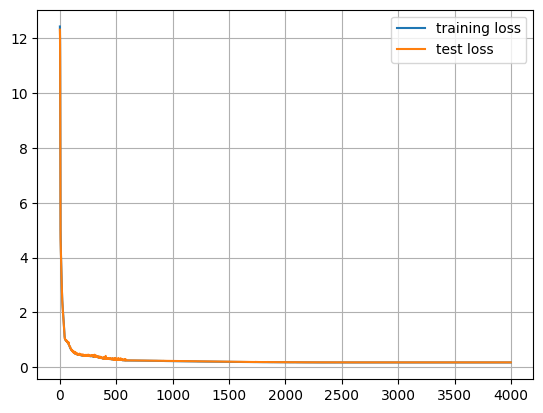

--------------------  EPOCH: 4000  --------------------
LOSS train 0.17170336544513704 valid 0.17525531351566315
--------------------  EPOCH: 4001  --------------------
LOSS train 0.1716294288635254 valid 0.17525510489940643
--------------------  EPOCH: 4002  --------------------
LOSS train 0.17167633324861525 valid 0.17525508999824524
--------------------  EPOCH: 4003  --------------------
LOSS train 0.17160327583551407 valid 0.1752551943063736
--------------------  EPOCH: 4004  --------------------
LOSS train 0.17156855762004852 valid 0.1752551943063736
--------------------  EPOCH: 4005  --------------------
LOSS train 0.17165754437446595 valid 0.1752547174692154
--------------------  EPOCH: 4006  --------------------
LOSS train 0.1715794712305069 valid 0.17525477707386017
--------------------  EPOCH: 4007  --------------------
LOSS train 0.1716397523880005 valid 0.17525477707386017
--------------------  EPOCH: 4008  --------------------
LOSS train 0.17168761938810348 valid 0.1752545

LOSS train 0.17171773463487625 valid 0.17525137960910797
--------------------  EPOCH: 4074  --------------------
LOSS train 0.17175789177417755 valid 0.17525145411491394
--------------------  EPOCH: 4075  --------------------
LOSS train 0.17176621705293654 valid 0.17525167763233185
--------------------  EPOCH: 4076  --------------------
LOSS train 0.17173476368188859 valid 0.17525148391723633
--------------------  EPOCH: 4077  --------------------
LOSS train 0.17171443104743958 valid 0.17525142431259155
--------------------  EPOCH: 4078  --------------------
LOSS train 0.1716507464647293 valid 0.1752510815858841
--------------------  EPOCH: 4079  --------------------
LOSS train 0.1716836839914322 valid 0.17525112628936768
--------------------  EPOCH: 4080  --------------------
LOSS train 0.17162365913391114 valid 0.17525118589401245
--------------------  EPOCH: 4081  --------------------
LOSS train 0.171745166182518 valid 0.17525145411491394
--------------------  EPOCH: 4082  ---------

LOSS train 0.1717572256922722 valid 0.17524796724319458
--------------------  EPOCH: 4147  --------------------
LOSS train 0.17163353860378266 valid 0.1752479523420334
--------------------  EPOCH: 4148  --------------------
LOSS train 0.1717053934931755 valid 0.17524786293506622
--------------------  EPOCH: 4149  --------------------
LOSS train 0.1717122822999954 valid 0.1752479374408722
--------------------  EPOCH: 4150  --------------------
LOSS train 0.17156219333410264 valid 0.17524844408035278
--------------------  EPOCH: 4151  --------------------
LOSS train 0.17153173089027404 valid 0.1752476841211319
--------------------  EPOCH: 4152  --------------------
LOSS train 0.17175305634737015 valid 0.17524781823158264
--------------------  EPOCH: 4153  --------------------
LOSS train 0.17170011699199678 valid 0.17524787783622742
--------------------  EPOCH: 4154  --------------------
LOSS train 0.17157651782035827 valid 0.1752476692199707
--------------------  EPOCH: 4155  -----------

LOSS train 0.17167514115571975 valid 0.1752447634935379
--------------------  EPOCH: 4220  --------------------
LOSS train 0.17169252336025237 valid 0.17524465918540955
--------------------  EPOCH: 4221  --------------------
LOSS train 0.17166851758956908 valid 0.1752445250749588
--------------------  EPOCH: 4222  --------------------
LOSS train 0.1716405436396599 valid 0.17524453997612
--------------------  EPOCH: 4223  --------------------
LOSS train 0.17170298993587493 valid 0.17524465918540955
--------------------  EPOCH: 4224  --------------------
LOSS train 0.1715780034661293 valid 0.17524437606334686
--------------------  EPOCH: 4225  --------------------
LOSS train 0.17174733579158782 valid 0.1752445548772812
--------------------  EPOCH: 4226  --------------------
LOSS train 0.17179955244064332 valid 0.17524443566799164
--------------------  EPOCH: 4227  --------------------
LOSS train 0.17169313430786132 valid 0.1752443015575409
--------------------  EPOCH: 4228  -------------

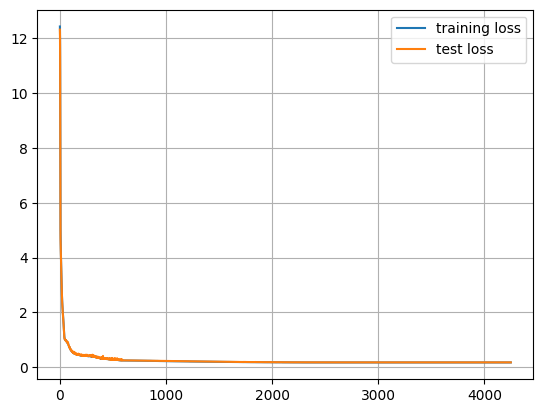

--------------------  EPOCH: 4250  --------------------
LOSS train 0.1716805651783943 valid 0.1752430498600006
--------------------  EPOCH: 4251  --------------------
LOSS train 0.1715143531560898 valid 0.17524303495883942
--------------------  EPOCH: 4252  --------------------
LOSS train 0.17175235748291015 valid 0.17524296045303345
--------------------  EPOCH: 4253  --------------------
LOSS train 0.17168767899274825 valid 0.17524296045303345
--------------------  EPOCH: 4254  --------------------
LOSS train 0.17154864370822906 valid 0.17524279654026031
--------------------  EPOCH: 4255  --------------------
LOSS train 0.17164019793272017 valid 0.17524297535419464
--------------------  EPOCH: 4256  --------------------
LOSS train 0.1716749519109726 valid 0.1752428561449051
--------------------  EPOCH: 4257  --------------------
LOSS train 0.1716041162610054 valid 0.17524263262748718
--------------------  EPOCH: 4258  --------------------
LOSS train 0.1717517465353012 valid 0.17524276

LOSS train 0.17162184417247772 valid 0.17523957788944244
--------------------  EPOCH: 4324  --------------------
LOSS train 0.17170230597257613 valid 0.17523938417434692
--------------------  EPOCH: 4325  --------------------
LOSS train 0.17166360914707185 valid 0.17523936927318573
--------------------  EPOCH: 4326  --------------------
LOSS train 0.17171494364738465 valid 0.1752401441335678
--------------------  EPOCH: 4327  --------------------
LOSS train 0.17169097512960435 valid 0.1752394437789917
--------------------  EPOCH: 4328  --------------------
LOSS train 0.17165763080120086 valid 0.1752394586801529
--------------------  EPOCH: 4329  --------------------
LOSS train 0.17164302468299866 valid 0.17523933947086334
--------------------  EPOCH: 4330  --------------------
LOSS train 0.17165932357311248 valid 0.17523913085460663
--------------------  EPOCH: 4331  --------------------
LOSS train 0.17164144963026046 valid 0.1752391904592514
--------------------  EPOCH: 4332  --------

LOSS train 0.17170867174863816 valid 0.17523613572120667
--------------------  EPOCH: 4397  --------------------
LOSS train 0.17155429422855378 valid 0.17523638904094696
--------------------  EPOCH: 4398  --------------------
LOSS train 0.1715923458337784 valid 0.17523622512817383
--------------------  EPOCH: 4399  --------------------
LOSS train 0.17162860035896302 valid 0.17523592710494995
--------------------  EPOCH: 4400  --------------------
LOSS train 0.17163971215486526 valid 0.17523589730262756
--------------------  EPOCH: 4401  --------------------
LOSS train 0.17166476398706437 valid 0.175235778093338
--------------------  EPOCH: 4402  --------------------
LOSS train 0.17174949645996093 valid 0.17523570358753204
--------------------  EPOCH: 4403  --------------------
LOSS train 0.1715661883354187 valid 0.1752355992794037
--------------------  EPOCH: 4404  --------------------
LOSS train 0.1716911166906357 valid 0.17523573338985443
--------------------  EPOCH: 4405  ----------

LOSS train 0.17163583636283875 valid 0.17523279786109924
--------------------  EPOCH: 4470  --------------------
LOSS train 0.17165768295526504 valid 0.17523276805877686
--------------------  EPOCH: 4471  --------------------
LOSS train 0.1715068370103836 valid 0.17523273825645447
--------------------  EPOCH: 4472  --------------------
LOSS train 0.17175599932670593 valid 0.1752326935529709
--------------------  EPOCH: 4473  --------------------
LOSS train 0.1717754453420639 valid 0.17523252964019775
--------------------  EPOCH: 4474  --------------------
LOSS train 0.17156503200531006 valid 0.17523278295993805
--------------------  EPOCH: 4475  --------------------
LOSS train 0.17175663262605667 valid 0.17523282766342163
--------------------  EPOCH: 4476  --------------------
LOSS train 0.17160270363092422 valid 0.17523238062858582
--------------------  EPOCH: 4477  --------------------
LOSS train 0.17153643369674682 valid 0.1752322018146515
--------------------  EPOCH: 4478  --------

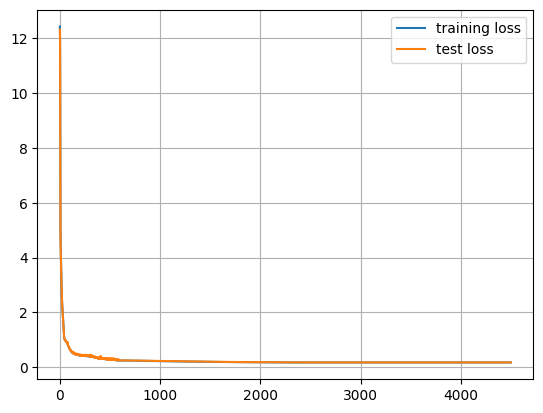

--------------------  EPOCH: 4500  --------------------
LOSS train 0.17156824469566345 valid 0.17523112893104553
--------------------  EPOCH: 4501  --------------------
LOSS train 0.1716398134827614 valid 0.17523129284381866
--------------------  EPOCH: 4502  --------------------
LOSS train 0.17149820178747177 valid 0.17523141205310822
--------------------  EPOCH: 4503  --------------------
LOSS train 0.17181536257267 valid 0.17523112893104553
--------------------  EPOCH: 4504  --------------------
LOSS train 0.17160344868898392 valid 0.17523109912872314
--------------------  EPOCH: 4505  --------------------
LOSS train 0.17180642634630203 valid 0.17523093521595
--------------------  EPOCH: 4506  --------------------
LOSS train 0.1715705618262291 valid 0.17523089051246643
--------------------  EPOCH: 4507  --------------------
LOSS train 0.17159530520439148 valid 0.17523080110549927
--------------------  EPOCH: 4508  --------------------
LOSS train 0.17151010483503343 valid 0.175230965

LOSS train 0.17165453284978865 valid 0.1752275824546814
--------------------  EPOCH: 4574  --------------------
LOSS train 0.17174039781093597 valid 0.17522753775119781
--------------------  EPOCH: 4575  --------------------
LOSS train 0.17153491973876953 valid 0.17522746324539185
--------------------  EPOCH: 4576  --------------------
LOSS train 0.17163360565900804 valid 0.17522741854190826
--------------------  EPOCH: 4577  --------------------
LOSS train 0.17163326889276503 valid 0.17522753775119781
--------------------  EPOCH: 4578  --------------------
LOSS train 0.17176488786935806 valid 0.17522747814655304
--------------------  EPOCH: 4579  --------------------
LOSS train 0.17167599946260453 valid 0.17522744834423065
--------------------  EPOCH: 4580  --------------------
LOSS train 0.17150504738092423 valid 0.17522720992565155
--------------------  EPOCH: 4581  --------------------
LOSS train 0.1717435285449028 valid 0.1752270609140396
--------------------  EPOCH: 4582  -------

LOSS train 0.17172470539808274 valid 0.1752244085073471
--------------------  EPOCH: 4647  --------------------
LOSS train 0.17159536480903625 valid 0.17522433400154114
--------------------  EPOCH: 4648  --------------------
LOSS train 0.17165922224521638 valid 0.17522430419921875
--------------------  EPOCH: 4649  --------------------
LOSS train 0.1716045543551445 valid 0.17522434890270233
--------------------  EPOCH: 4650  --------------------
LOSS train 0.17161909788846968 valid 0.17522433400154114
--------------------  EPOCH: 4651  --------------------
LOSS train 0.1714976966381073 valid 0.17522424459457397
--------------------  EPOCH: 4652  --------------------
LOSS train 0.1714997261762619 valid 0.1752241849899292
--------------------  EPOCH: 4653  --------------------
LOSS train 0.17157486379146575 valid 0.17522434890270233
--------------------  EPOCH: 4654  --------------------
LOSS train 0.17171818166971206 valid 0.1752241551876068
--------------------  EPOCH: 4655  ----------

LOSS train 0.17158759534358978 valid 0.17522098124027252
--------------------  EPOCH: 4720  --------------------
LOSS train 0.1716951012611389 valid 0.17522092163562775
--------------------  EPOCH: 4721  --------------------
LOSS train 0.1714678958058357 valid 0.17522087693214417
--------------------  EPOCH: 4722  --------------------
LOSS train 0.17167078256607055 valid 0.17522114515304565
--------------------  EPOCH: 4723  --------------------
LOSS train 0.17167875468730925 valid 0.17522086203098297
--------------------  EPOCH: 4724  --------------------
LOSS train 0.17172526717185974 valid 0.17522065341472626
--------------------  EPOCH: 4725  --------------------
LOSS train 0.17159609496593475 valid 0.17522065341472626
--------------------  EPOCH: 4726  --------------------
LOSS train 0.1717718094587326 valid 0.17522074282169342
--------------------  EPOCH: 4727  --------------------
LOSS train 0.17165964990854263 valid 0.17522059381008148
--------------------  EPOCH: 4728  -------

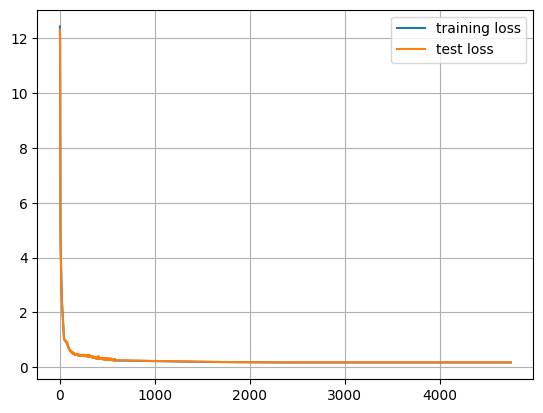

--------------------  EPOCH: 4750  --------------------
LOSS train 0.17164935916662216 valid 0.1752195507287979
--------------------  EPOCH: 4751  --------------------
LOSS train 0.17175253480672836 valid 0.17521944642066956
--------------------  EPOCH: 4752  --------------------
LOSS train 0.17154402136802674 valid 0.1752196103334427
--------------------  EPOCH: 4753  --------------------
LOSS train 0.17151844799518584 valid 0.1752193570137024
--------------------  EPOCH: 4754  --------------------
LOSS train 0.17159264534711838 valid 0.17521950602531433
--------------------  EPOCH: 4755  --------------------
LOSS train 0.17157079428434371 valid 0.1752191185951233
--------------------  EPOCH: 4756  --------------------
LOSS train 0.171550215780735 valid 0.1752191036939621
--------------------  EPOCH: 4757  --------------------
LOSS train 0.17163786739110948 valid 0.17521904408931732
--------------------  EPOCH: 4758  --------------------
LOSS train 0.1715869352221489 valid 0.175219327

LOSS train 0.17168961316347123 valid 0.17521601915359497
--------------------  EPOCH: 4824  --------------------
LOSS train 0.17156423032283782 valid 0.17521588504314423
--------------------  EPOCH: 4825  --------------------
LOSS train 0.17160464078187943 valid 0.17521585524082184
--------------------  EPOCH: 4826  --------------------
LOSS train 0.17166413366794586 valid 0.17521582543849945
--------------------  EPOCH: 4827  --------------------
LOSS train 0.17172928005456925 valid 0.17521578073501587
--------------------  EPOCH: 4828  --------------------
LOSS train 0.17170792818069458 valid 0.17521566152572632
--------------------  EPOCH: 4829  --------------------
LOSS train 0.1716326206922531 valid 0.17521578073501587
--------------------  EPOCH: 4830  --------------------
LOSS train 0.17146387845277786 valid 0.17521557211875916
--------------------  EPOCH: 4831  --------------------
LOSS train 0.1716567099094391 valid 0.17521552741527557
--------------------  EPOCH: 4832  ------

LOSS train 0.17155930101871492 valid 0.175212562084198
--------------------  EPOCH: 4897  --------------------
LOSS train 0.17159634530544282 valid 0.17521244287490845
--------------------  EPOCH: 4898  --------------------
LOSS train 0.17153062671422958 valid 0.17521242797374725
--------------------  EPOCH: 4899  --------------------
LOSS train 0.17169253528118134 valid 0.17521227896213531
--------------------  EPOCH: 4900  --------------------
LOSS train 0.17158953100442886 valid 0.17521242797374725
--------------------  EPOCH: 4901  --------------------
LOSS train 0.17163704037666322 valid 0.17521242797374725
--------------------  EPOCH: 4902  --------------------
LOSS train 0.1715447872877121 valid 0.1752122938632965
--------------------  EPOCH: 4903  --------------------
LOSS train 0.17157057970762252 valid 0.17521235346794128
--------------------  EPOCH: 4904  --------------------
LOSS train 0.17148604691028596 valid 0.1752125769853592
--------------------  EPOCH: 4905  ---------

LOSS train 0.17172559946775437 valid 0.17520888149738312
--------------------  EPOCH: 4970  --------------------
LOSS train 0.17168121337890624 valid 0.1752088963985443
--------------------  EPOCH: 4971  --------------------
LOSS train 0.1717563822865486 valid 0.17520879209041595
--------------------  EPOCH: 4972  --------------------
LOSS train 0.1716903865337372 valid 0.17520910501480103
--------------------  EPOCH: 4973  --------------------
LOSS train 0.17168097496032714 valid 0.1752086877822876
--------------------  EPOCH: 4974  --------------------
LOSS train 0.17168174535036088 valid 0.17520847916603088
--------------------  EPOCH: 4975  --------------------
LOSS train 0.17165133506059646 valid 0.1752084493637085
--------------------  EPOCH: 4976  --------------------
LOSS train 0.17157885581254959 valid 0.1752084493637085
--------------------  EPOCH: 4977  --------------------
LOSS train 0.17170095294713975 valid 0.17520858347415924
--------------------  EPOCH: 4978  ----------

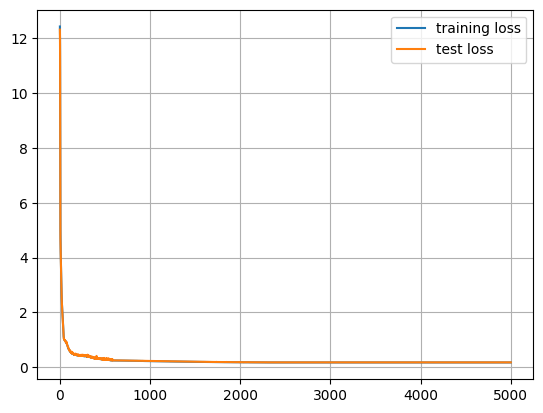

--------------------  EPOCH: 5000  --------------------
LOSS train 0.17151641845703125 valid 0.17520761489868164
--------------------  EPOCH: 5001  --------------------
LOSS train 0.1716273844242096 valid 0.17520759999752045
--------------------  EPOCH: 5002  --------------------
LOSS train 0.17157622724771499 valid 0.17520739138126373
--------------------  EPOCH: 5003  --------------------
LOSS train 0.17163260728120805 valid 0.17520758509635925
--------------------  EPOCH: 5004  --------------------
LOSS train 0.17163447588682174 valid 0.1752071976661682
--------------------  EPOCH: 5005  --------------------
LOSS train 0.1716609463095665 valid 0.17520731687545776
--------------------  EPOCH: 5006  --------------------
LOSS train 0.17173911780118942 valid 0.17520715296268463
--------------------  EPOCH: 5007  --------------------
LOSS train 0.17170553803443908 valid 0.17520704865455627
--------------------  EPOCH: 5008  --------------------
LOSS train 0.17167872190475464 valid 0.1752

LOSS train 0.17162843197584152 valid 0.175204336643219
--------------------  EPOCH: 5074  --------------------
LOSS train 0.17157414704561233 valid 0.17520415782928467
--------------------  EPOCH: 5075  --------------------
LOSS train 0.17159602493047715 valid 0.1752041131258011
--------------------  EPOCH: 5076  --------------------
LOSS train 0.1716337814927101 valid 0.17520394921302795
--------------------  EPOCH: 5077  --------------------
LOSS train 0.1716491997241974 valid 0.17520396411418915
--------------------  EPOCH: 5078  --------------------
LOSS train 0.17169416695833206 valid 0.17520391941070557
--------------------  EPOCH: 5079  --------------------
LOSS train 0.1715285822749138 valid 0.1752040535211563
--------------------  EPOCH: 5080  --------------------
LOSS train 0.17156490087509155 valid 0.17520391941070557
--------------------  EPOCH: 5081  --------------------
LOSS train 0.17163765877485276 valid 0.17520399391651154
--------------------  EPOCH: 5082  -----------

LOSS train 0.1716245725750923 valid 0.17520083487033844
--------------------  EPOCH: 5147  --------------------
LOSS train 0.17162528038024902 valid 0.17520076036453247
--------------------  EPOCH: 5148  --------------------
LOSS train 0.17157539427280427 valid 0.17520076036453247
--------------------  EPOCH: 5149  --------------------
LOSS train 0.17156281769275666 valid 0.17520096898078918
--------------------  EPOCH: 5150  --------------------
LOSS train 0.171548593044281 valid 0.1752007156610489
--------------------  EPOCH: 5151  --------------------
LOSS train 0.1715899661183357 valid 0.1752007156610489
--------------------  EPOCH: 5152  --------------------
LOSS train 0.17152195274829865 valid 0.17520059645175934
--------------------  EPOCH: 5153  --------------------
LOSS train 0.17154810726642608 valid 0.17520050704479218
--------------------  EPOCH: 5154  --------------------
LOSS train 0.1716235175728798 valid 0.1752004623413086
--------------------  EPOCH: 5155  ------------

LOSS train 0.17149533629417418 valid 0.17519748210906982
--------------------  EPOCH: 5220  --------------------
LOSS train 0.171660415828228 valid 0.17519761621952057
--------------------  EPOCH: 5221  --------------------
LOSS train 0.17145721167325972 valid 0.17519742250442505
--------------------  EPOCH: 5222  --------------------
LOSS train 0.17164843678474426 valid 0.17519763112068176
--------------------  EPOCH: 5223  --------------------
LOSS train 0.17167821824550628 valid 0.17519758641719818
--------------------  EPOCH: 5224  --------------------
LOSS train 0.17157500833272935 valid 0.17519722878932953
--------------------  EPOCH: 5225  --------------------
LOSS train 0.17149740904569627 valid 0.17519710958003998
--------------------  EPOCH: 5226  --------------------
LOSS train 0.17165067940950393 valid 0.17519716918468475
--------------------  EPOCH: 5227  --------------------
LOSS train 0.1715410068631172 valid 0.1751972734928131
--------------------  EPOCH: 5228  --------

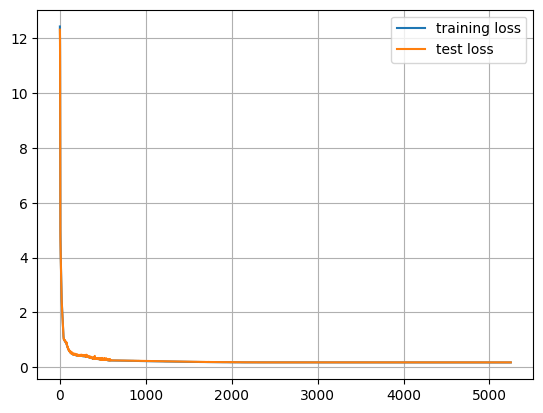

--------------------  EPOCH: 5250  --------------------
LOSS train 0.17160966694355012 valid 0.17519636452198029
--------------------  EPOCH: 5251  --------------------
LOSS train 0.17151984870433806 valid 0.17519624531269073
--------------------  EPOCH: 5252  --------------------
LOSS train 0.17149248719215393 valid 0.17519618570804596
--------------------  EPOCH: 5253  --------------------
LOSS train 0.17164382338523865 valid 0.1751963198184967
--------------------  EPOCH: 5254  --------------------
LOSS train 0.17158258706331253 valid 0.17519617080688477
--------------------  EPOCH: 5255  --------------------
LOSS train 0.17159289568662645 valid 0.1751960813999176
--------------------  EPOCH: 5256  --------------------
LOSS train 0.17172037214040756 valid 0.17519596219062805
--------------------  EPOCH: 5257  --------------------
LOSS train 0.1715981662273407 valid 0.1751963496208191
--------------------  EPOCH: 5258  --------------------
LOSS train 0.17157797366380692 valid 0.17519

LOSS train 0.17155899852514267 valid 0.17519250512123108
--------------------  EPOCH: 5324  --------------------
LOSS train 0.17158659398555756 valid 0.17519253492355347
--------------------  EPOCH: 5325  --------------------
LOSS train 0.1716841533780098 valid 0.17519256472587585
--------------------  EPOCH: 5326  --------------------
LOSS train 0.17160444259643554 valid 0.17519249022006989
--------------------  EPOCH: 5327  --------------------
LOSS train 0.1715787172317505 valid 0.1751924604177475
--------------------  EPOCH: 5328  --------------------
LOSS train 0.17162370830774307 valid 0.17519253492355347
--------------------  EPOCH: 5329  --------------------
LOSS train 0.17180633693933486 valid 0.17519232630729675
--------------------  EPOCH: 5330  --------------------
LOSS train 0.17174112796783447 valid 0.17519225180149078
--------------------  EPOCH: 5331  --------------------
LOSS train 0.17172178924083709 valid 0.17519214749336243
--------------------  EPOCH: 5332  -------

LOSS train 0.17170288413763046 valid 0.17518915235996246
--------------------  EPOCH: 5397  --------------------
LOSS train 0.17164057046175002 valid 0.17518927156925201
--------------------  EPOCH: 5398  --------------------
LOSS train 0.17150907814502717 valid 0.17518924176692963
--------------------  EPOCH: 5399  --------------------
LOSS train 0.17146657407283783 valid 0.17518897354602814
--------------------  EPOCH: 5400  --------------------
LOSS train 0.17171013057231904 valid 0.17518891394138336
--------------------  EPOCH: 5401  --------------------
LOSS train 0.1714893102645874 valid 0.17518886923789978
--------------------  EPOCH: 5402  --------------------
LOSS train 0.17158827930688858 valid 0.17518892884254456
--------------------  EPOCH: 5403  --------------------
LOSS train 0.17160841971635818 valid 0.17518901824951172
--------------------  EPOCH: 5404  --------------------
LOSS train 0.171545572578907 valid 0.17518889904022217
--------------------  EPOCH: 5405  -------

LOSS train 0.1715977296233177 valid 0.1751856952905655
--------------------  EPOCH: 5471  --------------------
LOSS train 0.17158921658992768 valid 0.17518563568592072
--------------------  EPOCH: 5472  --------------------
LOSS train 0.17159910053014754 valid 0.17518551647663116
--------------------  EPOCH: 5473  --------------------
LOSS train 0.17155078202486038 valid 0.17518548667430878
--------------------  EPOCH: 5474  --------------------
LOSS train 0.17151738107204437 valid 0.17518524825572968
--------------------  EPOCH: 5475  --------------------
LOSS train 0.1716473951935768 valid 0.17518559098243713
--------------------  EPOCH: 5476  --------------------
LOSS train 0.17154031693935395 valid 0.17518538236618042
--------------------  EPOCH: 5477  --------------------
LOSS train 0.17166655361652375 valid 0.1751853972673416
--------------------  EPOCH: 5478  --------------------
LOSS train 0.17156234234571457 valid 0.17518533766269684
--------------------  EPOCH: 5479  --------

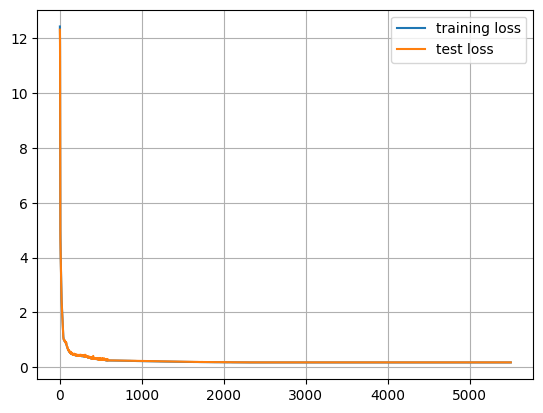

--------------------  EPOCH: 5500  --------------------
LOSS train 0.17163093537092208 valid 0.17518413066864014
--------------------  EPOCH: 5501  --------------------
LOSS train 0.17160887271165848 valid 0.17518413066864014
--------------------  EPOCH: 5502  --------------------
LOSS train 0.17158056050539017 valid 0.1751842051744461
--------------------  EPOCH: 5503  --------------------
LOSS train 0.17161910533905028 valid 0.1751839518547058
--------------------  EPOCH: 5504  --------------------
LOSS train 0.17158608734607697 valid 0.1751842349767685
--------------------  EPOCH: 5505  --------------------
LOSS train 0.17153627872467042 valid 0.17518413066864014
--------------------  EPOCH: 5506  --------------------
LOSS train 0.17167482674121856 valid 0.17518402636051178
--------------------  EPOCH: 5507  --------------------
LOSS train 0.17160271406173705 valid 0.17518389225006104
--------------------  EPOCH: 5508  --------------------
LOSS train 0.17173343598842622 valid 0.1751

LOSS train 0.17156666666269302 valid 0.17518095672130585
--------------------  EPOCH: 5574  --------------------
LOSS train 0.17161385715007782 valid 0.17518086731433868
--------------------  EPOCH: 5575  --------------------
LOSS train 0.17158400416374206 valid 0.17518092691898346
--------------------  EPOCH: 5576  --------------------
LOSS train 0.1715691477060318 valid 0.17518088221549988
--------------------  EPOCH: 5577  --------------------
LOSS train 0.17159664034843444 valid 0.17518076300621033
--------------------  EPOCH: 5578  --------------------
LOSS train 0.17153167724609375 valid 0.17518068850040436
--------------------  EPOCH: 5579  --------------------
LOSS train 0.17164706736803054 valid 0.17518074810504913
--------------------  EPOCH: 5580  --------------------
LOSS train 0.17141416370868684 valid 0.1751805990934372
--------------------  EPOCH: 5581  --------------------
LOSS train 0.17150553315877914 valid 0.17518043518066406
--------------------  EPOCH: 5582  ------

LOSS train 0.1716308891773224 valid 0.17517757415771484
--------------------  EPOCH: 5647  --------------------
LOSS train 0.17148627787828447 valid 0.17517751455307007
--------------------  EPOCH: 5648  --------------------
LOSS train 0.17158913612365723 valid 0.17517736554145813
--------------------  EPOCH: 5649  --------------------
LOSS train 0.17163944095373154 valid 0.1751776784658432
--------------------  EPOCH: 5650  --------------------
LOSS train 0.1716014936566353 valid 0.1751772165298462
--------------------  EPOCH: 5651  --------------------
LOSS train 0.17151980400085448 valid 0.17517727613449097
--------------------  EPOCH: 5652  --------------------
LOSS train 0.17152331322431563 valid 0.17517751455307007
--------------------  EPOCH: 5653  --------------------
LOSS train 0.17170967012643815 valid 0.17517738044261932
--------------------  EPOCH: 5654  --------------------
LOSS train 0.17161677330732344 valid 0.17517703771591187
--------------------  EPOCH: 5655  --------

LOSS train 0.17155395448207855 valid 0.17517414689064026
--------------------  EPOCH: 5720  --------------------
LOSS train 0.17162056565284728 valid 0.1751740276813507
--------------------  EPOCH: 5721  --------------------
LOSS train 0.17159703075885774 valid 0.1751740723848343
--------------------  EPOCH: 5722  --------------------
LOSS train 0.17168646156787873 valid 0.17517387866973877
--------------------  EPOCH: 5723  --------------------
LOSS train 0.17158419489860535 valid 0.17517387866973877
--------------------  EPOCH: 5724  --------------------
LOSS train 0.17153969258069993 valid 0.17517396807670593
--------------------  EPOCH: 5725  --------------------
LOSS train 0.17170431464910507 valid 0.17517375946044922
--------------------  EPOCH: 5726  --------------------
LOSS train 0.17154589295387268 valid 0.17517374455928802
--------------------  EPOCH: 5727  --------------------
LOSS train 0.17153578102588654 valid 0.17517361044883728
--------------------  EPOCH: 5728  ------

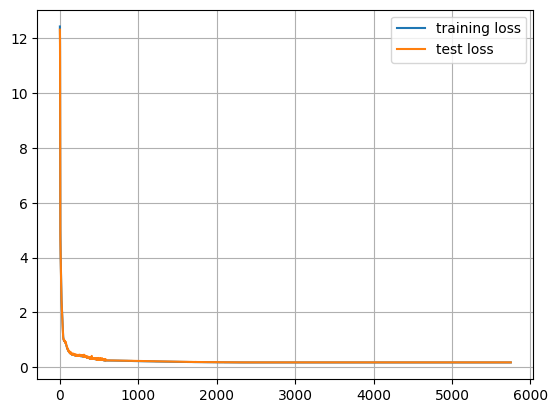

--------------------  EPOCH: 5750  --------------------
LOSS train 0.17151886820793152 valid 0.17517250776290894
--------------------  EPOCH: 5751  --------------------
LOSS train 0.17162817418575288 valid 0.1751728057861328
--------------------  EPOCH: 5752  --------------------
LOSS train 0.1716201663017273 valid 0.17517253756523132
--------------------  EPOCH: 5753  --------------------
LOSS train 0.17161052525043488 valid 0.1751725971698761
--------------------  EPOCH: 5754  --------------------
LOSS train 0.17157234251499176 valid 0.17517249286174774
--------------------  EPOCH: 5755  --------------------
LOSS train 0.17161309123039245 valid 0.17517253756523132
--------------------  EPOCH: 5756  --------------------
LOSS train 0.17154912352561952 valid 0.1751723736524582
--------------------  EPOCH: 5757  --------------------
LOSS train 0.17153746634721756 valid 0.175172358751297
--------------------  EPOCH: 5758  --------------------
LOSS train 0.17180016338825227 valid 0.1751722

LOSS train 0.17141286581754683 valid 0.17516902089118958
--------------------  EPOCH: 5824  --------------------
LOSS train 0.17159236073493958 valid 0.1751689314842224
--------------------  EPOCH: 5825  --------------------
LOSS train 0.17164129316806792 valid 0.17516911029815674
--------------------  EPOCH: 5826  --------------------
LOSS train 0.17161444276571275 valid 0.17516903579235077
--------------------  EPOCH: 5827  --------------------
LOSS train 0.1716039150953293 valid 0.1751689463853836
--------------------  EPOCH: 5828  --------------------
LOSS train 0.17148832976818085 valid 0.17516881227493286
--------------------  EPOCH: 5829  --------------------
LOSS train 0.17168036699295045 valid 0.17516879737377167
--------------------  EPOCH: 5830  --------------------
LOSS train 0.17162281423807144 valid 0.17516866326332092
--------------------  EPOCH: 5831  --------------------
LOSS train 0.17157236635684966 valid 0.1751686930656433
--------------------  EPOCH: 5832  --------

LOSS train 0.17154929637908936 valid 0.17516565322875977
--------------------  EPOCH: 5897  --------------------
LOSS train 0.1715987116098404 valid 0.175165593624115
--------------------  EPOCH: 5898  --------------------
LOSS train 0.17155720740556718 valid 0.17516560852527618
--------------------  EPOCH: 5899  --------------------
LOSS train 0.17149036526679992 valid 0.17516547441482544
--------------------  EPOCH: 5900  --------------------
LOSS train 0.17161323726177216 valid 0.1751658320426941
--------------------  EPOCH: 5901  --------------------
LOSS train 0.17167791575193406 valid 0.17516548931598663
--------------------  EPOCH: 5902  --------------------
LOSS train 0.17161802649497987 valid 0.17516548931598663
--------------------  EPOCH: 5903  --------------------
LOSS train 0.17172237932682038 valid 0.17516537010669708
--------------------  EPOCH: 5904  --------------------
LOSS train 0.1715271770954132 valid 0.17516525089740753
--------------------  EPOCH: 5905  ---------

LOSS train 0.1714579463005066 valid 0.17516200244426727
--------------------  EPOCH: 5970  --------------------
LOSS train 0.17146634459495544 valid 0.17516183853149414
--------------------  EPOCH: 5971  --------------------
LOSS train 0.1717272311449051 valid 0.17516210675239563
--------------------  EPOCH: 5972  --------------------
LOSS train 0.1716209262609482 valid 0.17516188323497772
--------------------  EPOCH: 5973  --------------------
LOSS train 0.17163533717393875 valid 0.17516164481639862
--------------------  EPOCH: 5974  --------------------
LOSS train 0.17168546468019485 valid 0.1751616895198822
--------------------  EPOCH: 5975  --------------------
LOSS train 0.17155248373746873 valid 0.17516155540943146
--------------------  EPOCH: 5976  --------------------
LOSS train 0.1716524451971054 valid 0.17516152560710907
--------------------  EPOCH: 5977  --------------------
LOSS train 0.17159963101148606 valid 0.17516136169433594
--------------------  EPOCH: 5978  ---------

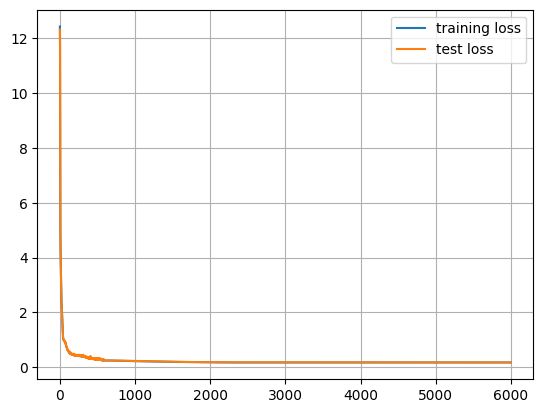

--------------------  EPOCH: 6000  --------------------
LOSS train 0.1716325893998146 valid 0.1751602441072464
--------------------  EPOCH: 6001  --------------------
LOSS train 0.17157972902059554 valid 0.17516039311885834
--------------------  EPOCH: 6002  --------------------
LOSS train 0.17150048315525054 valid 0.17516028881072998
--------------------  EPOCH: 6003  --------------------
LOSS train 0.17161686420440675 valid 0.17516052722930908
--------------------  EPOCH: 6004  --------------------
LOSS train 0.17155557572841645 valid 0.175160214304924
--------------------  EPOCH: 6005  --------------------
LOSS train 0.1715396225452423 valid 0.17516052722930908
--------------------  EPOCH: 6006  --------------------
LOSS train 0.17171378433704376 valid 0.17516040802001953
--------------------  EPOCH: 6007  --------------------
LOSS train 0.1716158539056778 valid 0.1751602292060852
--------------------  EPOCH: 6008  --------------------
LOSS train 0.17160362005233765 valid 0.17516000

LOSS train 0.17163233309984208 valid 0.1751565784215927
--------------------  EPOCH: 6074  --------------------
LOSS train 0.1715954378247261 valid 0.1751566231250763
--------------------  EPOCH: 6075  --------------------
LOSS train 0.17155433744192122 valid 0.17515678703784943
--------------------  EPOCH: 6076  --------------------
LOSS train 0.17145152539014816 valid 0.1751565784215927
--------------------  EPOCH: 6077  --------------------
LOSS train 0.17172449231147766 valid 0.17515656352043152
--------------------  EPOCH: 6078  --------------------
LOSS train 0.17159657627344133 valid 0.17515681684017181
--------------------  EPOCH: 6079  --------------------
LOSS train 0.17156970500946045 valid 0.17515653371810913
--------------------  EPOCH: 6080  --------------------
LOSS train 0.17161256968975067 valid 0.1751563847064972
--------------------  EPOCH: 6081  --------------------
LOSS train 0.17171476036310196 valid 0.1751563996076584
--------------------  EPOCH: 6082  ----------

LOSS train 0.17157222479581832 valid 0.17515315115451813
--------------------  EPOCH: 6147  --------------------
LOSS train 0.17167610228061675 valid 0.1751531958580017
--------------------  EPOCH: 6148  --------------------
LOSS train 0.17154588252305986 valid 0.17515310645103455
--------------------  EPOCH: 6149  --------------------
LOSS train 0.1717405527830124 valid 0.17515313625335693
--------------------  EPOCH: 6150  --------------------
LOSS train 0.17152460515499116 valid 0.17515310645103455
--------------------  EPOCH: 6151  --------------------
LOSS train 0.17157783806324006 valid 0.17515292763710022
--------------------  EPOCH: 6152  --------------------
LOSS train 0.17154475152492524 valid 0.1751529723405838
--------------------  EPOCH: 6153  --------------------
LOSS train 0.1715434283018112 valid 0.1751530021429062
--------------------  EPOCH: 6154  --------------------
LOSS train 0.17173881977796554 valid 0.17515285313129425
--------------------  EPOCH: 6155  ---------

LOSS train 0.17154370248317719 valid 0.1751495748758316
--------------------  EPOCH: 6220  --------------------
LOSS train 0.1716501995921135 valid 0.17514944076538086
--------------------  EPOCH: 6221  --------------------
LOSS train 0.17157918959856033 valid 0.17514973878860474
--------------------  EPOCH: 6222  --------------------
LOSS train 0.17153557389974594 valid 0.175149604678154
--------------------  EPOCH: 6223  --------------------
LOSS train 0.17173425555229188 valid 0.17514947056770325
--------------------  EPOCH: 6224  --------------------
LOSS train 0.17163047194480896 valid 0.1751493364572525
--------------------  EPOCH: 6225  --------------------
LOSS train 0.17151834219694137 valid 0.1751493215560913
--------------------  EPOCH: 6226  --------------------
LOSS train 0.17168378978967666 valid 0.17514929175376892
--------------------  EPOCH: 6227  --------------------
LOSS train 0.17155581712722778 valid 0.17514926195144653
--------------------  EPOCH: 6228  ----------

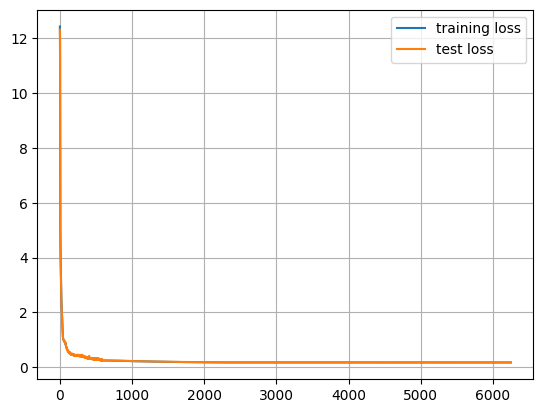

--------------------  EPOCH: 6250  --------------------
LOSS train 0.17148963660001754 valid 0.1751478910446167
--------------------  EPOCH: 6251  --------------------
LOSS train 0.17147289961576462 valid 0.1751478761434555
--------------------  EPOCH: 6252  --------------------
LOSS train 0.17157055288553238 valid 0.17514774203300476
--------------------  EPOCH: 6253  --------------------
LOSS train 0.17143694311380386 valid 0.17514771223068237
--------------------  EPOCH: 6254  --------------------
LOSS train 0.17149533480405807 valid 0.1751476377248764
--------------------  EPOCH: 6255  --------------------
LOSS train 0.1715596064925194 valid 0.1751479208469391
--------------------  EPOCH: 6256  --------------------
LOSS train 0.17156354039907457 valid 0.17514771223068237
--------------------  EPOCH: 6257  --------------------
LOSS train 0.17158984541893005 valid 0.17514759302139282
--------------------  EPOCH: 6258  --------------------
LOSS train 0.17141949981451035 valid 0.175147

LOSS train 0.17144598066806793 valid 0.17514437437057495
--------------------  EPOCH: 6324  --------------------
LOSS train 0.17164325714111328 valid 0.1751442402601242
--------------------  EPOCH: 6325  --------------------
LOSS train 0.17166920006275177 valid 0.1751440167427063
--------------------  EPOCH: 6326  --------------------
LOSS train 0.17166222035884857 valid 0.17514407634735107
--------------------  EPOCH: 6327  --------------------
LOSS train 0.1715354174375534 valid 0.17514397203922272
--------------------  EPOCH: 6328  --------------------
LOSS train 0.1716674730181694 valid 0.17514419555664062
--------------------  EPOCH: 6329  --------------------
LOSS train 0.17151257246732712 valid 0.17514388263225555
--------------------  EPOCH: 6330  --------------------
LOSS train 0.17152878195047377 valid 0.17514388263225555
--------------------  EPOCH: 6331  --------------------
LOSS train 0.17151881456375123 valid 0.17514397203922272
--------------------  EPOCH: 6332  --------

LOSS train 0.17158302515745164 valid 0.175140380859375
--------------------  EPOCH: 6397  --------------------
LOSS train 0.17168033123016357 valid 0.17514054477214813
--------------------  EPOCH: 6398  --------------------
LOSS train 0.17142544090747833 valid 0.17514054477214813
--------------------  EPOCH: 6399  --------------------
LOSS train 0.1716157540678978 valid 0.1751403659582138
--------------------  EPOCH: 6400  --------------------
LOSS train 0.17140155136585236 valid 0.17514042556285858
--------------------  EPOCH: 6401  --------------------
LOSS train 0.17155403196811675 valid 0.1751401722431183
--------------------  EPOCH: 6402  --------------------
LOSS train 0.17147234529256822 valid 0.1751401275396347
--------------------  EPOCH: 6403  --------------------
LOSS train 0.17151886522769927 valid 0.17514000833034515
--------------------  EPOCH: 6404  --------------------
LOSS train 0.17147247195243837 valid 0.17513996362686157
--------------------  EPOCH: 6405  ----------

LOSS train 0.17157936990261077 valid 0.17513681948184967
--------------------  EPOCH: 6470  --------------------
LOSS train 0.1716064468026161 valid 0.17513664066791534
--------------------  EPOCH: 6471  --------------------
LOSS train 0.17150946110486984 valid 0.17513678967952728
--------------------  EPOCH: 6472  --------------------
LOSS train 0.17156219184398652 valid 0.1751365214586258
--------------------  EPOCH: 6473  --------------------
LOSS train 0.17160304486751557 valid 0.175136536359787
--------------------  EPOCH: 6474  --------------------
LOSS train 0.17158386558294297 valid 0.17513638734817505
--------------------  EPOCH: 6475  --------------------
LOSS train 0.1715448170900345 valid 0.17513640224933624
--------------------  EPOCH: 6476  --------------------
LOSS train 0.17149702161550523 valid 0.1751362681388855
--------------------  EPOCH: 6477  --------------------
LOSS train 0.17159387320280076 valid 0.17513616383075714
--------------------  EPOCH: 6478  ----------

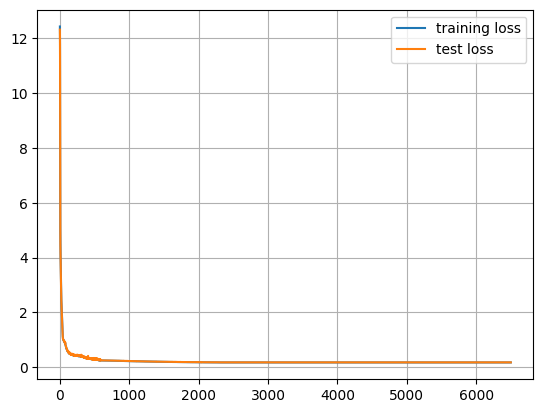

--------------------  EPOCH: 6500  --------------------
LOSS train 0.17143898010253905 valid 0.17513507604599
--------------------  EPOCH: 6501  --------------------
LOSS train 0.17167773544788362 valid 0.17513495683670044
--------------------  EPOCH: 6502  --------------------
LOSS train 0.17152801603078843 valid 0.17513513565063477
--------------------  EPOCH: 6503  --------------------
LOSS train 0.17146944403648376 valid 0.17513495683670044
--------------------  EPOCH: 6504  --------------------
LOSS train 0.17153672128915787 valid 0.17513486742973328
--------------------  EPOCH: 6505  --------------------
LOSS train 0.17166762948036193 valid 0.17513468861579895
--------------------  EPOCH: 6506  --------------------
LOSS train 0.17152200341224672 valid 0.1751348227262497
--------------------  EPOCH: 6507  --------------------
LOSS train 0.17155902087688446 valid 0.17513473331928253
--------------------  EPOCH: 6508  --------------------
LOSS train 0.17161385267972945 valid 0.17513

LOSS train 0.17181230932474137 valid 0.17513196170330048
--------------------  EPOCH: 6574  --------------------
LOSS train 0.17150738090276718 valid 0.17513149976730347
--------------------  EPOCH: 6575  --------------------
LOSS train 0.17154210656881333 valid 0.17513136565685272
--------------------  EPOCH: 6576  --------------------
LOSS train 0.17148786187171935 valid 0.1751314252614975
--------------------  EPOCH: 6577  --------------------
LOSS train 0.17145093828439711 valid 0.17513135075569153
--------------------  EPOCH: 6578  --------------------
LOSS train 0.17160090804100037 valid 0.17513127624988556
--------------------  EPOCH: 6579  --------------------
LOSS train 0.17146509885787964 valid 0.17513109743595123
--------------------  EPOCH: 6580  --------------------
LOSS train 0.17158624827861785 valid 0.1751311868429184
--------------------  EPOCH: 6581  --------------------
LOSS train 0.1715279921889305 valid 0.1751312017440796
--------------------  EPOCH: 6582  --------

LOSS train 0.17151695489883423 valid 0.17512823641300201
--------------------  EPOCH: 6647  --------------------
LOSS train 0.17162146419286728 valid 0.1751279979944229
--------------------  EPOCH: 6648  --------------------
LOSS train 0.17146310210227966 valid 0.1751279979944229
--------------------  EPOCH: 6649  --------------------
LOSS train 0.17154432088136673 valid 0.1751278042793274
--------------------  EPOCH: 6650  --------------------
LOSS train 0.1716502472758293 valid 0.17512772977352142
--------------------  EPOCH: 6651  --------------------
LOSS train 0.17155807316303254 valid 0.17512786388397217
--------------------  EPOCH: 6652  --------------------
LOSS train 0.17159558832645416 valid 0.17512762546539307
--------------------  EPOCH: 6653  --------------------
LOSS train 0.17133778035640718 valid 0.17512750625610352
--------------------  EPOCH: 6654  --------------------
LOSS train 0.17154812067747116 valid 0.1751275360584259
--------------------  EPOCH: 6655  ---------

LOSS train 0.1715051993727684 valid 0.17512446641921997
--------------------  EPOCH: 6720  --------------------
LOSS train 0.17150833904743196 valid 0.17512419819831848
--------------------  EPOCH: 6721  --------------------
LOSS train 0.17153581976890564 valid 0.17512433230876923
--------------------  EPOCH: 6722  --------------------
LOSS train 0.17151327133178712 valid 0.17512422800064087
--------------------  EPOCH: 6723  --------------------
LOSS train 0.17153333127498627 valid 0.17512410879135132
--------------------  EPOCH: 6724  --------------------
LOSS train 0.17161846905946732 valid 0.17512401938438416
--------------------  EPOCH: 6725  --------------------
LOSS train 0.17143267691135405 valid 0.17512419819831848
--------------------  EPOCH: 6726  --------------------
LOSS train 0.17146084010601043 valid 0.1751239001750946
--------------------  EPOCH: 6727  --------------------
LOSS train 0.17147618383169175 valid 0.17512381076812744
--------------------  EPOCH: 6728  ------

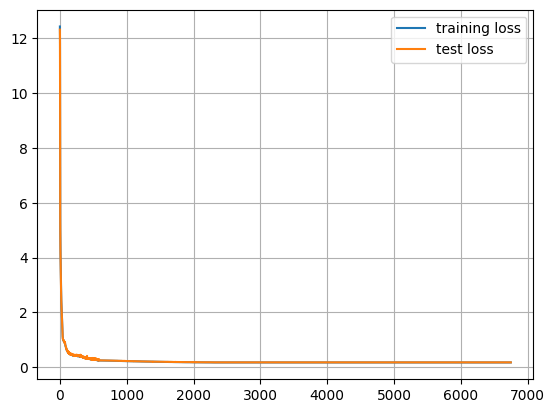

--------------------  EPOCH: 6750  --------------------
LOSS train 0.17153017967939377 valid 0.17512290179729462
--------------------  EPOCH: 6751  --------------------
LOSS train 0.17155513167381287 valid 0.17512284219264984
--------------------  EPOCH: 6752  --------------------
LOSS train 0.1715318575501442 valid 0.17512273788452148
--------------------  EPOCH: 6753  --------------------
LOSS train 0.1714748352766037 valid 0.17512279748916626
--------------------  EPOCH: 6754  --------------------
LOSS train 0.17150736898183822 valid 0.17512281239032745
--------------------  EPOCH: 6755  --------------------
LOSS train 0.1716175153851509 valid 0.17512273788452148
--------------------  EPOCH: 6756  --------------------
LOSS train 0.17153313308954238 valid 0.17512305080890656
--------------------  EPOCH: 6757  --------------------
LOSS train 0.17152107059955596 valid 0.17512263357639313
--------------------  EPOCH: 6758  --------------------
LOSS train 0.17155962735414504 valid 0.1751

LOSS train 0.17160455286502838 valid 0.17511893808841705
--------------------  EPOCH: 6824  --------------------
LOSS train 0.17152104079723357 valid 0.17511898279190063
--------------------  EPOCH: 6825  --------------------
LOSS train 0.17165087312459945 valid 0.17511899769306183
--------------------  EPOCH: 6826  --------------------
LOSS train 0.17153310328722 valid 0.1751190572977066
--------------------  EPOCH: 6827  --------------------
LOSS train 0.17158278077840805 valid 0.17511892318725586
--------------------  EPOCH: 6828  --------------------
LOSS train 0.17157336175441742 valid 0.17511886358261108
--------------------  EPOCH: 6829  --------------------
LOSS train 0.17153504937887193 valid 0.17511872947216034
--------------------  EPOCH: 6830  --------------------
LOSS train 0.1715143635869026 valid 0.17511875927448273
--------------------  EPOCH: 6831  --------------------
LOSS train 0.17159441560506822 valid 0.17511864006519318
--------------------  EPOCH: 6832  ---------

LOSS train 0.17149675786495208 valid 0.17511555552482605
--------------------  EPOCH: 6897  --------------------
LOSS train 0.17151235342025756 valid 0.17511560022830963
--------------------  EPOCH: 6898  --------------------
LOSS train 0.17158280164003373 valid 0.17511554062366486
--------------------  EPOCH: 6899  --------------------
LOSS train 0.17158292084932328 valid 0.1751154363155365
--------------------  EPOCH: 6900  --------------------
LOSS train 0.17141022384166718 valid 0.1751154363155365
--------------------  EPOCH: 6901  --------------------
LOSS train 0.17163501232862471 valid 0.17511527240276337
--------------------  EPOCH: 6902  --------------------
LOSS train 0.17147338688373565 valid 0.17511528730392456
--------------------  EPOCH: 6903  --------------------
LOSS train 0.17155129164457322 valid 0.1751152127981186
--------------------  EPOCH: 6904  --------------------
LOSS train 0.17151162773370743 valid 0.1751154214143753
--------------------  EPOCH: 6905  --------

LOSS train 0.17163290977478027 valid 0.17511236667633057
--------------------  EPOCH: 6970  --------------------
LOSS train 0.17162412106990815 valid 0.17511214315891266
--------------------  EPOCH: 6971  --------------------
LOSS train 0.1715134486556053 valid 0.17511214315891266
--------------------  EPOCH: 6972  --------------------
LOSS train 0.17150127291679382 valid 0.17511211335659027
--------------------  EPOCH: 6973  --------------------
LOSS train 0.17149549275636672 valid 0.17511196434497833
--------------------  EPOCH: 6974  --------------------
LOSS train 0.17162131518125534 valid 0.17511184513568878
--------------------  EPOCH: 6975  --------------------
LOSS train 0.17142652571201325 valid 0.17511199414730072
--------------------  EPOCH: 6976  --------------------
LOSS train 0.17146095335483552 valid 0.1751118302345276
--------------------  EPOCH: 6977  --------------------
LOSS train 0.17146844416856766 valid 0.1751118153333664
--------------------  EPOCH: 6978  -------

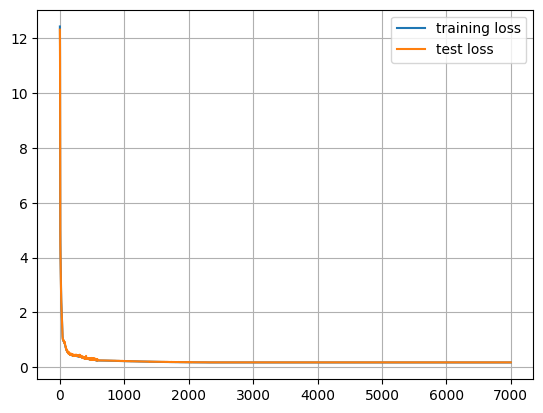

--------------------  EPOCH: 7000  --------------------
LOSS train 0.17157498896121978 valid 0.17511078715324402
--------------------  EPOCH: 7001  --------------------
LOSS train 0.1714749038219452 valid 0.17511096596717834
--------------------  EPOCH: 7002  --------------------
LOSS train 0.17157326340675355 valid 0.17511068284511566
--------------------  EPOCH: 7003  --------------------
LOSS train 0.17157318145036698 valid 0.17511072754859924
--------------------  EPOCH: 7004  --------------------
LOSS train 0.17158447057008744 valid 0.17511054873466492
--------------------  EPOCH: 7005  --------------------
LOSS train 0.1716542884707451 valid 0.17511051893234253
--------------------  EPOCH: 7006  --------------------
LOSS train 0.17157179415225982 valid 0.17511038482189178
--------------------  EPOCH: 7007  --------------------
LOSS train 0.17160310745239257 valid 0.17511048913002014
--------------------  EPOCH: 7008  --------------------
LOSS train 0.17154784500598907 valid 0.175

LOSS train 0.17153236269950867 valid 0.1751071810722351
--------------------  EPOCH: 7074  --------------------
LOSS train 0.17133765667676926 valid 0.1751071661710739
--------------------  EPOCH: 7075  --------------------
LOSS train 0.1715158760547638 valid 0.17510703206062317
--------------------  EPOCH: 7076  --------------------
LOSS train 0.17157699316740035 valid 0.1751071810722351
--------------------  EPOCH: 7077  --------------------
LOSS train 0.17137174308300018 valid 0.175106942653656
--------------------  EPOCH: 7078  --------------------
LOSS train 0.17145276814699173 valid 0.1751069873571396
--------------------  EPOCH: 7079  --------------------
LOSS train 0.17152440249919892 valid 0.17510679364204407
--------------------  EPOCH: 7080  --------------------
LOSS train 0.17162149995565415 valid 0.1751066893339157
--------------------  EPOCH: 7081  --------------------
LOSS train 0.17159509360790254 valid 0.17510677874088287
--------------------  EPOCH: 7082  ------------

LOSS train 0.1715220868587494 valid 0.17510370910167694
--------------------  EPOCH: 7147  --------------------
LOSS train 0.17171465158462523 valid 0.17510373890399933
--------------------  EPOCH: 7148  --------------------
LOSS train 0.17158624678850173 valid 0.17510367929935455
--------------------  EPOCH: 7149  --------------------
LOSS train 0.17147746831178665 valid 0.17510370910167694
--------------------  EPOCH: 7150  --------------------
LOSS train 0.17139089852571487 valid 0.17510364949703217
--------------------  EPOCH: 7151  --------------------
LOSS train 0.1716025397181511 valid 0.175103560090065
--------------------  EPOCH: 7152  --------------------
LOSS train 0.17149715423583983 valid 0.17510341107845306
--------------------  EPOCH: 7153  --------------------
LOSS train 0.17158526480197905 valid 0.1751033365726471
--------------------  EPOCH: 7154  --------------------
LOSS train 0.17147573530673982 valid 0.17510336637496948
--------------------  EPOCH: 7155  ---------

LOSS train 0.17155214846134187 valid 0.17510004341602325
--------------------  EPOCH: 7220  --------------------
LOSS train 0.1715607911348343 valid 0.1751002073287964
--------------------  EPOCH: 7221  --------------------
LOSS train 0.17142847031354905 valid 0.17510002851486206
--------------------  EPOCH: 7222  --------------------
LOSS train 0.17154632806777953 valid 0.17510013282299042
--------------------  EPOCH: 7223  --------------------
LOSS train 0.17152578234672547 valid 0.17509980499744415
--------------------  EPOCH: 7224  --------------------
LOSS train 0.17149773389101028 valid 0.17509973049163818
--------------------  EPOCH: 7225  --------------------
LOSS train 0.17155201137065887 valid 0.17509959638118744
--------------------  EPOCH: 7226  --------------------
LOSS train 0.1715390220284462 valid 0.17509959638118744
--------------------  EPOCH: 7227  --------------------
LOSS train 0.17157170921564102 valid 0.17509950697422028
--------------------  EPOCH: 7228  -------

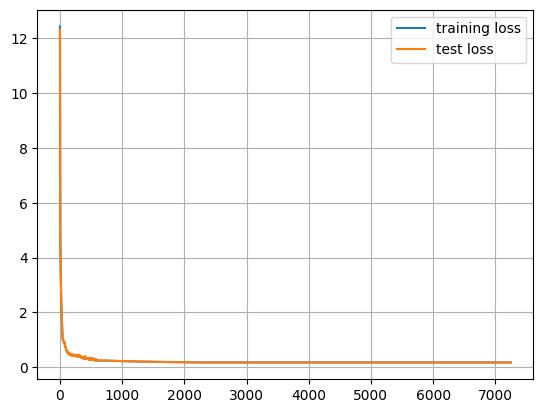

--------------------  EPOCH: 7250  --------------------
LOSS train 0.17142790257930757 valid 0.1750984787940979
--------------------  EPOCH: 7251  --------------------
LOSS train 0.17161455303430556 valid 0.17509861290454865
--------------------  EPOCH: 7252  --------------------
LOSS train 0.17151761054992676 valid 0.17509840428829193
--------------------  EPOCH: 7253  --------------------
LOSS train 0.17147281318902968 valid 0.17509838938713074
--------------------  EPOCH: 7254  --------------------
LOSS train 0.17143031358718872 valid 0.17509816586971283
--------------------  EPOCH: 7255  --------------------
LOSS train 0.1714242771267891 valid 0.17509812116622925
--------------------  EPOCH: 7256  --------------------
LOSS train 0.1715107887983322 valid 0.17509819567203522
--------------------  EPOCH: 7257  --------------------
LOSS train 0.1714956745505333 valid 0.17509815096855164
--------------------  EPOCH: 7258  --------------------
LOSS train 0.17149539887905121 valid 0.17509

LOSS train 0.1714945614337921 valid 0.17509537935256958
--------------------  EPOCH: 7324  --------------------
LOSS train 0.1714621439576149 valid 0.1750951111316681
--------------------  EPOCH: 7325  --------------------
LOSS train 0.17150670886039734 valid 0.1750950962305069
--------------------  EPOCH: 7326  --------------------
LOSS train 0.17142491191625595 valid 0.17509505152702332
--------------------  EPOCH: 7327  --------------------
LOSS train 0.17152197659015656 valid 0.17509520053863525
--------------------  EPOCH: 7328  --------------------
LOSS train 0.1715703070163727 valid 0.17509502172470093
--------------------  EPOCH: 7329  --------------------
LOSS train 0.17151670902967453 valid 0.17509491741657257
--------------------  EPOCH: 7330  --------------------
LOSS train 0.17150298357009888 valid 0.17509478330612183
--------------------  EPOCH: 7331  --------------------
LOSS train 0.17150313556194305 valid 0.175094872713089
--------------------  EPOCH: 7332  -----------

LOSS train 0.17167683243751525 valid 0.17509159445762634
--------------------  EPOCH: 7397  --------------------
LOSS train 0.17142785489559173 valid 0.17509151995182037
--------------------  EPOCH: 7398  --------------------
LOSS train 0.17149641513824462 valid 0.17509134113788605
--------------------  EPOCH: 7399  --------------------
LOSS train 0.17162050157785416 valid 0.17509132623672485
--------------------  EPOCH: 7400  --------------------
LOSS train 0.17147025018930434 valid 0.17509129643440247
--------------------  EPOCH: 7401  --------------------
LOSS train 0.1714262992143631 valid 0.17509117722511292
--------------------  EPOCH: 7402  --------------------
LOSS train 0.17153263390064238 valid 0.17509125173091888
--------------------  EPOCH: 7403  --------------------
LOSS train 0.17153575420379638 valid 0.17509114742279053
--------------------  EPOCH: 7404  --------------------
LOSS train 0.1715410053730011 valid 0.1750912070274353
--------------------  EPOCH: 7405  -------

LOSS train 0.1715097263455391 valid 0.1750880479812622
--------------------  EPOCH: 7470  --------------------
LOSS train 0.17146583944559096 valid 0.1750880777835846
--------------------  EPOCH: 7471  --------------------
LOSS train 0.1715718239545822 valid 0.1750880777835846
--------------------  EPOCH: 7472  --------------------
LOSS train 0.17156624794006348 valid 0.17508791387081146
--------------------  EPOCH: 7473  --------------------
LOSS train 0.1715177118778229 valid 0.17508788406848907
--------------------  EPOCH: 7474  --------------------
LOSS train 0.17142592519521713 valid 0.17508767545223236
--------------------  EPOCH: 7475  --------------------
LOSS train 0.17155582159757615 valid 0.17508776485919952
--------------------  EPOCH: 7476  --------------------
LOSS train 0.17152147442102433 valid 0.17508764564990997
--------------------  EPOCH: 7477  --------------------
LOSS train 0.17147376835346223 valid 0.175087571144104
--------------------  EPOCH: 7478  ------------

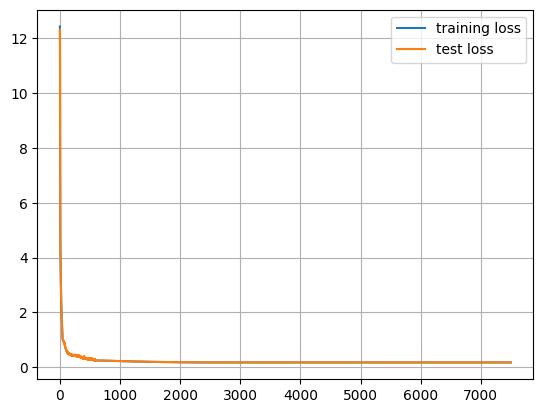

--------------------  EPOCH: 7500  --------------------
LOSS train 0.17135526835918427 valid 0.17508670687675476
--------------------  EPOCH: 7501  --------------------
LOSS train 0.17164232581853867 valid 0.17508649826049805
--------------------  EPOCH: 7502  --------------------
LOSS train 0.17149241864681244 valid 0.17508646845817566
--------------------  EPOCH: 7503  --------------------
LOSS train 0.17146193534135817 valid 0.1750863492488861
--------------------  EPOCH: 7504  --------------------
LOSS train 0.17149926275014876 valid 0.1750863641500473
--------------------  EPOCH: 7505  --------------------
LOSS train 0.1716163456439972 valid 0.17508628964424133
--------------------  EPOCH: 7506  --------------------
LOSS train 0.17144158482551575 valid 0.1750863790512085
--------------------  EPOCH: 7507  --------------------
LOSS train 0.17156077027320862 valid 0.17508630454540253
--------------------  EPOCH: 7508  --------------------
LOSS train 0.17135127186775206 valid 0.17508

LOSS train 0.1715174913406372 valid 0.1750829964876175
--------------------  EPOCH: 7574  --------------------
LOSS train 0.17148337215185167 valid 0.1750829517841339
--------------------  EPOCH: 7575  --------------------
LOSS train 0.17153928875923158 valid 0.1750829815864563
--------------------  EPOCH: 7576  --------------------
LOSS train 0.17155254036188125 valid 0.17508293688297272
--------------------  EPOCH: 7577  --------------------
LOSS train 0.17137325257062913 valid 0.17508289217948914
--------------------  EPOCH: 7578  --------------------
LOSS train 0.17153669893741608 valid 0.1750829666852951
--------------------  EPOCH: 7579  --------------------
LOSS train 0.17157799303531646 valid 0.17508293688297272
--------------------  EPOCH: 7580  --------------------
LOSS train 0.1715895414352417 valid 0.17508289217948914
--------------------  EPOCH: 7581  --------------------
LOSS train 0.17143542021512986 valid 0.17508269846439362
--------------------  EPOCH: 7582  ----------

LOSS train 0.17147571444511414 valid 0.17507950961589813
--------------------  EPOCH: 7647  --------------------
LOSS train 0.17149055749177933 valid 0.1750795543193817
--------------------  EPOCH: 7648  --------------------
LOSS train 0.17146952897310258 valid 0.1750793308019638
--------------------  EPOCH: 7649  --------------------
LOSS train 0.17140212506055832 valid 0.17507940530776978
--------------------  EPOCH: 7650  --------------------
LOSS train 0.1716141790151596 valid 0.17507946491241455
--------------------  EPOCH: 7651  --------------------
LOSS train 0.17133302837610245 valid 0.17507945001125336
--------------------  EPOCH: 7652  --------------------
LOSS train 0.17156173884868622 valid 0.17507919669151306
--------------------  EPOCH: 7653  --------------------
LOSS train 0.17161504030227662 valid 0.17507942020893097
--------------------  EPOCH: 7654  --------------------
LOSS train 0.17140884697437286 valid 0.1750791370868683
--------------------  EPOCH: 7655  --------

LOSS train 0.17149505019187927 valid 0.1750759482383728
--------------------  EPOCH: 7720  --------------------
LOSS train 0.17151545137166976 valid 0.17507606744766235
--------------------  EPOCH: 7721  --------------------
LOSS train 0.17161544859409333 valid 0.1750759780406952
--------------------  EPOCH: 7722  --------------------
LOSS train 0.17151013463735582 valid 0.17507591843605042
--------------------  EPOCH: 7723  --------------------
LOSS train 0.17149013429880142 valid 0.17507590353488922
--------------------  EPOCH: 7724  --------------------
LOSS train 0.17153377085924149 valid 0.17507600784301758
--------------------  EPOCH: 7725  --------------------
LOSS train 0.17147146463394164 valid 0.1750759482383728
--------------------  EPOCH: 7726  --------------------
LOSS train 0.17128931134939193 valid 0.17507584393024445
--------------------  EPOCH: 7727  --------------------
LOSS train 0.1713924914598465 valid 0.17507578432559967
--------------------  EPOCH: 7728  --------

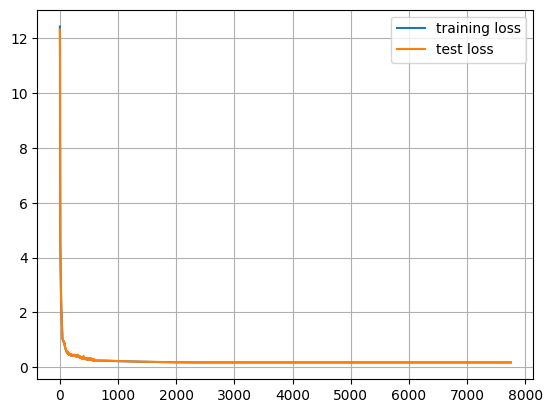

--------------------  EPOCH: 7750  --------------------
LOSS train 0.17145341783761978 valid 0.17507486045360565
--------------------  EPOCH: 7751  --------------------
LOSS train 0.17149593383073808 valid 0.17507445812225342
--------------------  EPOCH: 7752  --------------------
LOSS train 0.17152520418167114 valid 0.1750744879245758
--------------------  EPOCH: 7753  --------------------
LOSS train 0.17144425958395004 valid 0.17507436871528625
--------------------  EPOCH: 7754  --------------------
LOSS train 0.17136672735214234 valid 0.17507435381412506
--------------------  EPOCH: 7755  --------------------
LOSS train 0.17157475352287294 valid 0.17507417500019073
--------------------  EPOCH: 7756  --------------------
LOSS train 0.17149624079465867 valid 0.17507435381412506
--------------------  EPOCH: 7757  --------------------
LOSS train 0.17161704152822493 valid 0.1750742346048355
--------------------  EPOCH: 7758  --------------------
LOSS train 0.17130549848079682 valid 0.175

LOSS train 0.17148431539535522 valid 0.17507115006446838
--------------------  EPOCH: 7824  --------------------
LOSS train 0.17142312228679657 valid 0.17507101595401764
--------------------  EPOCH: 7825  --------------------
LOSS train 0.17147976607084275 valid 0.17507091164588928
--------------------  EPOCH: 7826  --------------------
LOSS train 0.17141261100769042 valid 0.17507117986679077
--------------------  EPOCH: 7827  --------------------
LOSS train 0.17149983197450638 valid 0.17507092654705048
--------------------  EPOCH: 7828  --------------------
LOSS train 0.17147908806800843 valid 0.175070658326149
--------------------  EPOCH: 7829  --------------------
LOSS train 0.17159432172775269 valid 0.17507067322731018
--------------------  EPOCH: 7830  --------------------
LOSS train 0.17132814973592758 valid 0.17507044970989227
--------------------  EPOCH: 7831  --------------------
LOSS train 0.17149298936128615 valid 0.17507044970989227
--------------------  EPOCH: 7832  ------

LOSS train 0.17152489870786666 valid 0.17506714165210724
--------------------  EPOCH: 7897  --------------------
LOSS train 0.17148445397615433 valid 0.17506720125675201
--------------------  EPOCH: 7898  --------------------
LOSS train 0.17169773280620576 valid 0.1750669777393341
--------------------  EPOCH: 7899  --------------------
LOSS train 0.17163135409355162 valid 0.17506688833236694
--------------------  EPOCH: 7900  --------------------
LOSS train 0.17147734761238098 valid 0.17506690323352814
--------------------  EPOCH: 7901  --------------------
LOSS train 0.17159776538610458 valid 0.17506685853004456
--------------------  EPOCH: 7902  --------------------
LOSS train 0.17141720801591873 valid 0.1750670075416565
--------------------  EPOCH: 7903  --------------------
LOSS train 0.17148761451244354 valid 0.1750667244195938
--------------------  EPOCH: 7904  --------------------
LOSS train 0.17159414738416673 valid 0.1750665307044983
--------------------  EPOCH: 7905  --------

LOSS train 0.1714784935116768 valid 0.17506350576877594
--------------------  EPOCH: 7970  --------------------
LOSS train 0.17151036113500595 valid 0.1750636249780655
--------------------  EPOCH: 7971  --------------------
LOSS train 0.17154183983802795 valid 0.17506331205368042
--------------------  EPOCH: 7972  --------------------
LOSS train 0.17149316966533662 valid 0.17506343126296997
--------------------  EPOCH: 7973  --------------------
LOSS train 0.17153524607419968 valid 0.1750633865594864
--------------------  EPOCH: 7974  --------------------
LOSS train 0.1714468851685524 valid 0.1750633418560028
--------------------  EPOCH: 7975  --------------------
LOSS train 0.17147332429885864 valid 0.17506325244903564
--------------------  EPOCH: 7976  --------------------
LOSS train 0.1714233636856079 valid 0.1750631034374237
--------------------  EPOCH: 7977  --------------------
LOSS train 0.1714718833565712 valid 0.17506293952465057
--------------------  EPOCH: 7978  ------------

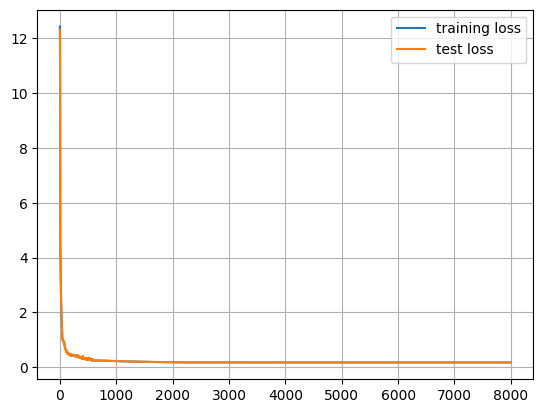

--------------------  EPOCH: 8000  --------------------
LOSS train 0.17160572707653046 valid 0.17506183683872223
--------------------  EPOCH: 8001  --------------------
LOSS train 0.17146590650081633 valid 0.17506197094917297
--------------------  EPOCH: 8002  --------------------
LOSS train 0.17138671576976777 valid 0.17506171762943268
--------------------  EPOCH: 8003  --------------------
LOSS train 0.17148818969726562 valid 0.1750616878271103
--------------------  EPOCH: 8004  --------------------
LOSS train 0.17152437567710876 valid 0.17506174743175507
--------------------  EPOCH: 8005  --------------------
LOSS train 0.17161175459623337 valid 0.17506147921085358
--------------------  EPOCH: 8006  --------------------
LOSS train 0.17148561030626297 valid 0.1750614494085312
--------------------  EPOCH: 8007  --------------------
LOSS train 0.17146917432546616 valid 0.1750614047050476
--------------------  EPOCH: 8008  --------------------
LOSS train 0.17142911553382872 valid 0.1750

LOSS train 0.17145935595035552 valid 0.175058051943779
--------------------  EPOCH: 8074  --------------------
LOSS train 0.17154982835054397 valid 0.1750582605600357
--------------------  EPOCH: 8075  --------------------
LOSS train 0.1716002568602562 valid 0.175058051943779
--------------------  EPOCH: 8076  --------------------
LOSS train 0.17149109095335008 valid 0.17505790293216705
--------------------  EPOCH: 8077  --------------------
LOSS train 0.17144179940223694 valid 0.1750577837228775
--------------------  EPOCH: 8078  --------------------
LOSS train 0.17152724415063858 valid 0.17505763471126556
--------------------  EPOCH: 8079  --------------------
LOSS train 0.17154218554496764 valid 0.17505759000778198
--------------------  EPOCH: 8080  --------------------
LOSS train 0.17150674611330033 valid 0.17505772411823273
--------------------  EPOCH: 8081  --------------------
LOSS train 0.17147610038518907 valid 0.1750575751066208
--------------------  EPOCH: 8082  ------------

LOSS train 0.17150762677192688 valid 0.1750546246767044
--------------------  EPOCH: 8147  --------------------
LOSS train 0.1714514300227165 valid 0.1750546097755432
--------------------  EPOCH: 8148  --------------------
LOSS train 0.17152032405138015 valid 0.17505480349063873
--------------------  EPOCH: 8149  --------------------
LOSS train 0.17154652923345565 valid 0.17505459487438202
--------------------  EPOCH: 8150  --------------------
LOSS train 0.17159828096628188 valid 0.17505472898483276
--------------------  EPOCH: 8151  --------------------
LOSS train 0.17137727588415147 valid 0.17505457997322083
--------------------  EPOCH: 8152  --------------------
LOSS train 0.17142910957336427 valid 0.17505446076393127
--------------------  EPOCH: 8153  --------------------
LOSS train 0.17143328934907914 valid 0.17505435645580292
--------------------  EPOCH: 8154  --------------------
LOSS train 0.1714482367038727 valid 0.17505422234535217
--------------------  EPOCH: 8155  --------

LOSS train 0.17145885080099105 valid 0.17505083978176117
--------------------  EPOCH: 8220  --------------------
LOSS train 0.1713586777448654 valid 0.17505086958408356
--------------------  EPOCH: 8221  --------------------
LOSS train 0.17149654030799866 valid 0.1750507950782776
--------------------  EPOCH: 8222  --------------------
LOSS train 0.1713755890727043 valid 0.1750507801771164
--------------------  EPOCH: 8223  --------------------
LOSS train 0.1714482471346855 valid 0.17505061626434326
--------------------  EPOCH: 8224  --------------------
LOSS train 0.17142156213521959 valid 0.17505072057247162
--------------------  EPOCH: 8225  --------------------
LOSS train 0.17144529670476913 valid 0.1750507354736328
--------------------  EPOCH: 8226  --------------------
LOSS train 0.17145877480506896 valid 0.17505064606666565
--------------------  EPOCH: 8227  --------------------
LOSS train 0.17152524888515472 valid 0.17505042254924774
--------------------  EPOCH: 8228  ----------

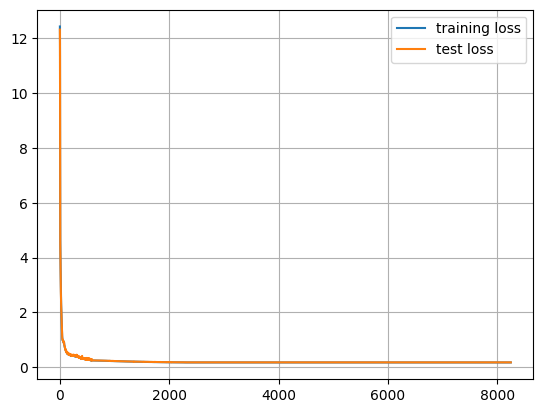

--------------------  EPOCH: 8250  --------------------
LOSS train 0.17140436172485352 valid 0.17504967749118805
--------------------  EPOCH: 8251  --------------------
LOSS train 0.17145899534225464 valid 0.17504934966564178
--------------------  EPOCH: 8252  --------------------
LOSS train 0.17140919715166092 valid 0.17504937946796417
--------------------  EPOCH: 8253  --------------------
LOSS train 0.17141442745923996 valid 0.1750493049621582
--------------------  EPOCH: 8254  --------------------
LOSS train 0.17134389132261277 valid 0.1750493198633194
--------------------  EPOCH: 8255  --------------------
LOSS train 0.17154267728328704 valid 0.17504943907260895
--------------------  EPOCH: 8256  --------------------
LOSS train 0.17150287330150604 valid 0.17504915595054626
--------------------  EPOCH: 8257  --------------------
LOSS train 0.17146520912647248 valid 0.1750493198633194
--------------------  EPOCH: 8258  --------------------
LOSS train 0.17141377478837966 valid 0.1750

LOSS train 0.17129056453704833 valid 0.17504587769508362
--------------------  EPOCH: 8324  --------------------
LOSS train 0.17144737392663956 valid 0.17504602670669556
--------------------  EPOCH: 8325  --------------------
LOSS train 0.17136948853731154 valid 0.17504586279392242
--------------------  EPOCH: 8326  --------------------
LOSS train 0.17143748551607133 valid 0.17504577338695526
--------------------  EPOCH: 8327  --------------------
LOSS train 0.17147387117147445 valid 0.17504571378231049
--------------------  EPOCH: 8328  --------------------
LOSS train 0.1714809149503708 valid 0.17504584789276123
--------------------  EPOCH: 8329  --------------------
LOSS train 0.17145968824625016 valid 0.1750456541776657
--------------------  EPOCH: 8330  --------------------
LOSS train 0.17143150568008422 valid 0.17504552006721497
--------------------  EPOCH: 8331  --------------------
LOSS train 0.17140570282936096 valid 0.17504549026489258
--------------------  EPOCH: 8332  ------

LOSS train 0.17146821618080138 valid 0.1750423163175583
--------------------  EPOCH: 8397  --------------------
LOSS train 0.17142031192779542 valid 0.17504234611988068
--------------------  EPOCH: 8398  --------------------
LOSS train 0.17151179015636445 valid 0.17504234611988068
--------------------  EPOCH: 8399  --------------------
LOSS train 0.17131445109844207 valid 0.17504222691059113
--------------------  EPOCH: 8400  --------------------
LOSS train 0.171453620493412 valid 0.17504218220710754
--------------------  EPOCH: 8401  --------------------
LOSS train 0.17150543332099916 valid 0.17504215240478516
--------------------  EPOCH: 8402  --------------------
LOSS train 0.17146274596452712 valid 0.1750420331954956
--------------------  EPOCH: 8403  --------------------
LOSS train 0.17134352922439575 valid 0.17504209280014038
--------------------  EPOCH: 8404  --------------------
LOSS train 0.17146176099777222 valid 0.1750420182943344
--------------------  EPOCH: 8405  ---------

LOSS train 0.17140118032693863 valid 0.17503897845745087
--------------------  EPOCH: 8470  --------------------
LOSS train 0.1715059369802475 valid 0.1750388890504837
--------------------  EPOCH: 8471  --------------------
LOSS train 0.17147621065378188 valid 0.17503902316093445
--------------------  EPOCH: 8472  --------------------
LOSS train 0.17151178866624833 valid 0.17503875494003296
--------------------  EPOCH: 8473  --------------------
LOSS train 0.17154619097709656 valid 0.17503872513771057
--------------------  EPOCH: 8474  --------------------
LOSS train 0.17147523909807205 valid 0.17503881454467773
--------------------  EPOCH: 8475  --------------------
LOSS train 0.17146969437599183 valid 0.17503869533538818
--------------------  EPOCH: 8476  --------------------
LOSS train 0.17133198380470277 valid 0.1750386357307434
--------------------  EPOCH: 8477  --------------------
LOSS train 0.17142648696899415 valid 0.17503871023654938
--------------------  EPOCH: 8478  -------

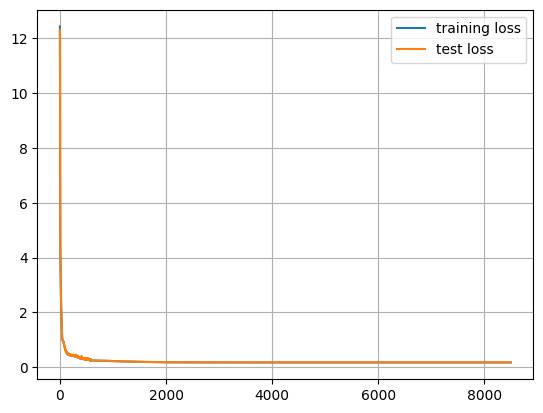

--------------------  EPOCH: 8500  --------------------
LOSS train 0.17142262160778046 valid 0.17503753304481506
--------------------  EPOCH: 8501  --------------------
LOSS train 0.17144656032323838 valid 0.1750374436378479
--------------------  EPOCH: 8502  --------------------
LOSS train 0.17141221314668656 valid 0.17503759264945984
--------------------  EPOCH: 8503  --------------------
LOSS train 0.17147660106420518 valid 0.1750374585390091
--------------------  EPOCH: 8504  --------------------
LOSS train 0.17143115401268005 valid 0.17503738403320312
--------------------  EPOCH: 8505  --------------------
LOSS train 0.17140776067972183 valid 0.17503727972507477
--------------------  EPOCH: 8506  --------------------
LOSS train 0.17143973410129548 valid 0.1750372052192688
--------------------  EPOCH: 8507  --------------------
LOSS train 0.17143393009901048 valid 0.1750372052192688
--------------------  EPOCH: 8508  --------------------
LOSS train 0.17139412313699723 valid 0.17503

LOSS train 0.17151924222707748 valid 0.17503395676612854
--------------------  EPOCH: 8574  --------------------
LOSS train 0.17140677124261855 valid 0.17503392696380615
--------------------  EPOCH: 8575  --------------------
LOSS train 0.17143726944923401 valid 0.17503388226032257
--------------------  EPOCH: 8576  --------------------
LOSS train 0.1714909255504608 valid 0.17503385245800018
--------------------  EPOCH: 8577  --------------------
LOSS train 0.17137115746736525 valid 0.175033837556839
--------------------  EPOCH: 8578  --------------------
LOSS train 0.17143628001213074 valid 0.17503418028354645
--------------------  EPOCH: 8579  --------------------
LOSS train 0.17145842611789702 valid 0.17503373324871063
--------------------  EPOCH: 8580  --------------------
LOSS train 0.17130666524171828 valid 0.17503367364406586
--------------------  EPOCH: 8581  --------------------
LOSS train 0.17153296768665313 valid 0.1750337779521942
--------------------  EPOCH: 8582  --------

LOSS train 0.17149441540241242 valid 0.17503058910369873
--------------------  EPOCH: 8648  --------------------
LOSS train 0.17142756283283234 valid 0.1750306785106659
--------------------  EPOCH: 8649  --------------------
LOSS train 0.17142056673765182 valid 0.17503054440021515
--------------------  EPOCH: 8650  --------------------
LOSS train 0.17152590900659562 valid 0.17503060400485992
--------------------  EPOCH: 8651  --------------------
LOSS train 0.17160215526819228 valid 0.17503048479557037
--------------------  EPOCH: 8652  --------------------
LOSS train 0.17147936969995498 valid 0.17503033578395844
--------------------  EPOCH: 8653  --------------------
LOSS train 0.17146131992340088 valid 0.17503035068511963
--------------------  EPOCH: 8654  --------------------
LOSS train 0.17139427959918976 valid 0.1750304251909256
--------------------  EPOCH: 8655  --------------------
LOSS train 0.17153187692165375 valid 0.17503033578395844
--------------------  EPOCH: 8656  ------

LOSS train 0.17136896550655364 valid 0.1750270128250122
--------------------  EPOCH: 8721  --------------------
LOSS train 0.17144308239221573 valid 0.17502693831920624
--------------------  EPOCH: 8722  --------------------
LOSS train 0.17140498459339143 valid 0.1750270128250122
--------------------  EPOCH: 8723  --------------------
LOSS train 0.17146577388048173 valid 0.17502690851688385
--------------------  EPOCH: 8724  --------------------
LOSS train 0.17141159474849701 valid 0.17502692341804504
--------------------  EPOCH: 8725  --------------------
LOSS train 0.17147729843854903 valid 0.17502683401107788
--------------------  EPOCH: 8726  --------------------
LOSS train 0.1713681310415268 valid 0.17502671480178833
--------------------  EPOCH: 8727  --------------------
LOSS train 0.171503446996212 valid 0.17502658069133759
--------------------  EPOCH: 8728  --------------------
LOSS train 0.17145415395498276 valid 0.17502659559249878
--------------------  EPOCH: 8729  ---------

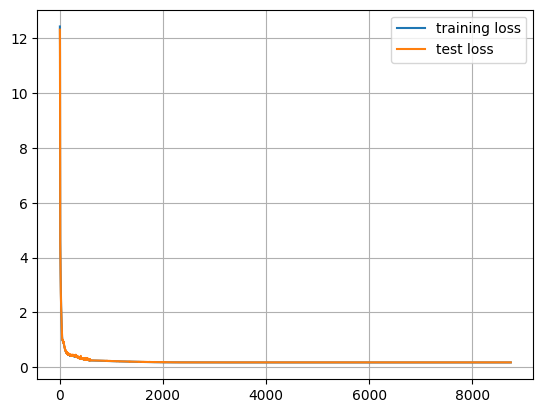

--------------------  EPOCH: 8750  --------------------
LOSS train 0.17145538330078125 valid 0.17502553761005402
--------------------  EPOCH: 8751  --------------------
LOSS train 0.1713978499174118 valid 0.17502546310424805
--------------------  EPOCH: 8752  --------------------
LOSS train 0.1712850883603096 valid 0.17502547800540924
--------------------  EPOCH: 8753  --------------------
LOSS train 0.17159525603055953 valid 0.17502544820308685
--------------------  EPOCH: 8754  --------------------
LOSS train 0.17148596048355103 valid 0.1750253289937973
--------------------  EPOCH: 8755  --------------------
LOSS train 0.171397303044796 valid 0.17502546310424805
--------------------  EPOCH: 8756  --------------------
LOSS train 0.17151487469673157 valid 0.1750253289937973
--------------------  EPOCH: 8757  --------------------
LOSS train 0.17140395790338517 valid 0.17502513527870178
--------------------  EPOCH: 8758  --------------------
LOSS train 0.17143930792808532 valid 0.1750251

LOSS train 0.1713921993970871 valid 0.1750219464302063
--------------------  EPOCH: 8824  --------------------
LOSS train 0.17148117870092391 valid 0.17502203583717346
--------------------  EPOCH: 8825  --------------------
LOSS train 0.17149536460638046 valid 0.17502206563949585
--------------------  EPOCH: 8826  --------------------
LOSS train 0.17153071910142897 valid 0.1750217080116272
--------------------  EPOCH: 8827  --------------------
LOSS train 0.1715450793504715 valid 0.17502161860466003
--------------------  EPOCH: 8828  --------------------
LOSS train 0.17149350345134734 valid 0.1750217080116272
--------------------  EPOCH: 8829  --------------------
LOSS train 0.17141527384519578 valid 0.17502158880233765
--------------------  EPOCH: 8830  --------------------
LOSS train 0.17143935710191727 valid 0.17502179741859436
--------------------  EPOCH: 8831  --------------------
LOSS train 0.17133841365575792 valid 0.17502161860466003
--------------------  EPOCH: 8832  ---------

LOSS train 0.1713702693581581 valid 0.1750185787677765
--------------------  EPOCH: 8897  --------------------
LOSS train 0.17143446803092957 valid 0.17501837015151978
--------------------  EPOCH: 8898  --------------------
LOSS train 0.17146816551685334 valid 0.17501816153526306
--------------------  EPOCH: 8899  --------------------
LOSS train 0.17148928493261337 valid 0.1750182956457138
--------------------  EPOCH: 8900  --------------------
LOSS train 0.17136066555976867 valid 0.17501822113990784
--------------------  EPOCH: 8901  --------------------
LOSS train 0.17136602550745011 valid 0.17501820623874664
--------------------  EPOCH: 8902  --------------------
LOSS train 0.17140900194644929 valid 0.1750180423259735
--------------------  EPOCH: 8903  --------------------
LOSS train 0.17139521092176438 valid 0.17501798272132874
--------------------  EPOCH: 8904  --------------------
LOSS train 0.1713818281888962 valid 0.17501789331436157
--------------------  EPOCH: 8905  ---------

LOSS train 0.17141610831022264 valid 0.17501500248908997
--------------------  EPOCH: 8970  --------------------
LOSS train 0.17151810973882675 valid 0.1750149428844452
--------------------  EPOCH: 8971  --------------------
LOSS train 0.171461845934391 valid 0.17501486837863922
--------------------  EPOCH: 8972  --------------------
LOSS train 0.17140049040317534 valid 0.1750149428844452
--------------------  EPOCH: 8973  --------------------
LOSS train 0.17143169343471526 valid 0.17501488327980042
--------------------  EPOCH: 8974  --------------------
LOSS train 0.1715434029698372 valid 0.17501483857631683
--------------------  EPOCH: 8975  --------------------
LOSS train 0.1715125098824501 valid 0.17501485347747803
--------------------  EPOCH: 8976  --------------------
LOSS train 0.1713864639401436 valid 0.17501476407051086
--------------------  EPOCH: 8977  --------------------
LOSS train 0.17149295657873154 valid 0.17501457035541534
--------------------  EPOCH: 8978  -----------

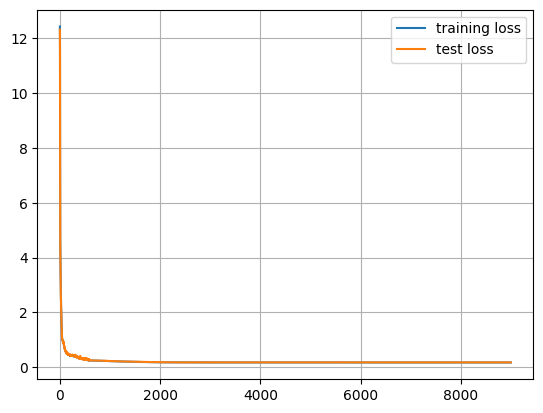

--------------------  EPOCH: 9000  --------------------
LOSS train 0.17142150849103927 valid 0.17501354217529297
--------------------  EPOCH: 9001  --------------------
LOSS train 0.17133300602436066 valid 0.17501339316368103
--------------------  EPOCH: 9002  --------------------
LOSS train 0.17153077870607375 valid 0.17501336336135864
--------------------  EPOCH: 9003  --------------------
LOSS train 0.17146315574645996 valid 0.17501336336135864
--------------------  EPOCH: 9004  --------------------
LOSS train 0.17150697410106658 valid 0.17501311004161835
--------------------  EPOCH: 9005  --------------------
LOSS train 0.17137628197669982 valid 0.1750131994485855
--------------------  EPOCH: 9006  --------------------
LOSS train 0.17148835062980652 valid 0.17501318454742432
--------------------  EPOCH: 9007  --------------------
LOSS train 0.17144013792276383 valid 0.17501313984394073
--------------------  EPOCH: 9008  --------------------
LOSS train 0.171535824239254 valid 0.1750

LOSS train 0.1715491458773613 valid 0.17501018941402435
--------------------  EPOCH: 9074  --------------------
LOSS train 0.17133405059576035 valid 0.175010085105896
--------------------  EPOCH: 9075  --------------------
LOSS train 0.1714559093117714 valid 0.17501004040241241
--------------------  EPOCH: 9076  --------------------
LOSS train 0.1713302195072174 valid 0.1750103235244751
--------------------  EPOCH: 9077  --------------------
LOSS train 0.1714462161064148 valid 0.1750100702047348
--------------------  EPOCH: 9078  --------------------
LOSS train 0.17160145938396454 valid 0.17500987648963928
--------------------  EPOCH: 9079  --------------------
LOSS train 0.1714109167456627 valid 0.1750098466873169
--------------------  EPOCH: 9080  --------------------
LOSS train 0.17144031971693038 valid 0.1750098615884781
--------------------  EPOCH: 9081  --------------------
LOSS train 0.1714353933930397 valid 0.1750098466873169
--------------------  EPOCH: 9082  -----------------

LOSS train 0.17140604108572005 valid 0.17500685155391693
--------------------  EPOCH: 9147  --------------------
LOSS train 0.1714998170733452 valid 0.17500680685043335
--------------------  EPOCH: 9148  --------------------
LOSS train 0.17154091447591782 valid 0.1750066578388214
--------------------  EPOCH: 9149  --------------------
LOSS train 0.17147838920354844 valid 0.17500655353069305
--------------------  EPOCH: 9150  --------------------
LOSS train 0.17132674008607865 valid 0.1750064641237259
--------------------  EPOCH: 9151  --------------------
LOSS train 0.1713950216770172 valid 0.175006702542305
--------------------  EPOCH: 9152  --------------------
LOSS train 0.1713964581489563 valid 0.1750064194202423
--------------------  EPOCH: 9153  --------------------
LOSS train 0.17153452336788177 valid 0.17500607669353485
--------------------  EPOCH: 9154  --------------------
LOSS train 0.1715673625469208 valid 0.1750061810016632
--------------------  EPOCH: 9155  --------------

LOSS train 0.17147301882505417 valid 0.1750030368566513
--------------------  EPOCH: 9220  --------------------
LOSS train 0.17145020812749862 valid 0.17500321567058563
--------------------  EPOCH: 9221  --------------------
LOSS train 0.1714714929461479 valid 0.17500296235084534
--------------------  EPOCH: 9222  --------------------
LOSS train 0.17142194956541063 valid 0.1750030219554901
--------------------  EPOCH: 9223  --------------------
LOSS train 0.17135282307863237 valid 0.17500300705432892
--------------------  EPOCH: 9224  --------------------
LOSS train 0.17146770358085633 valid 0.1750030517578125
--------------------  EPOCH: 9225  --------------------
LOSS train 0.17137253731489183 valid 0.17500309646129608
--------------------  EPOCH: 9226  --------------------
LOSS train 0.17150715738534927 valid 0.17500291764736176
--------------------  EPOCH: 9227  --------------------
LOSS train 0.17141200602054596 valid 0.17500269412994385
--------------------  EPOCH: 9228  --------

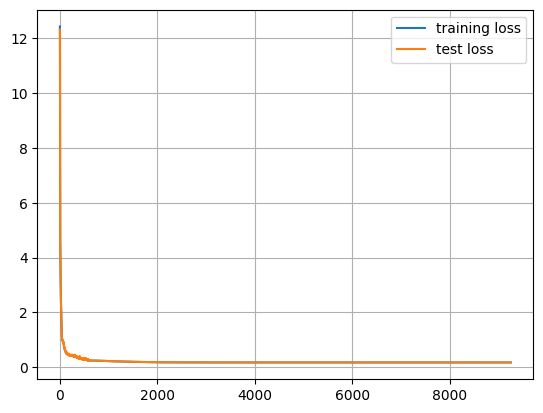

--------------------  EPOCH: 9250  --------------------
LOSS train 0.17143383622169495 valid 0.17500187456607819
--------------------  EPOCH: 9251  --------------------
LOSS train 0.17135903388261794 valid 0.17500165104866028
--------------------  EPOCH: 9252  --------------------
LOSS train 0.17142395973205565 valid 0.17500163614749908
--------------------  EPOCH: 9253  --------------------
LOSS train 0.1713413268327713 valid 0.1750016212463379
--------------------  EPOCH: 9254  --------------------
LOSS train 0.17140709310770036 valid 0.1750015765428543
--------------------  EPOCH: 9255  --------------------
LOSS train 0.17134104073047637 valid 0.17500174045562744
--------------------  EPOCH: 9256  --------------------
LOSS train 0.17137553840875625 valid 0.17500166594982147
--------------------  EPOCH: 9257  --------------------
LOSS train 0.171482215821743 valid 0.17500156164169312
--------------------  EPOCH: 9258  --------------------
LOSS train 0.17125414162874222 valid 0.175001

LOSS train 0.17139844447374344 valid 0.17499862611293793
--------------------  EPOCH: 9324  --------------------
LOSS train 0.1716366857290268 valid 0.1749984622001648
--------------------  EPOCH: 9325  --------------------
LOSS train 0.17137679755687713 valid 0.17499855160713196
--------------------  EPOCH: 9326  --------------------
LOSS train 0.17131618559360504 valid 0.17499831318855286
--------------------  EPOCH: 9327  --------------------
LOSS train 0.1714023232460022 valid 0.1749982237815857
--------------------  EPOCH: 9328  --------------------
LOSS train 0.17152560949325563 valid 0.17499808967113495
--------------------  EPOCH: 9329  --------------------
LOSS train 0.17141823917627336 valid 0.17499810457229614
--------------------  EPOCH: 9330  --------------------
LOSS train 0.17146216183900834 valid 0.17499808967113495
--------------------  EPOCH: 9331  --------------------
LOSS train 0.17134435921907426 valid 0.17499803006649017
--------------------  EPOCH: 9332  --------

LOSS train 0.17155981063842773 valid 0.1749952733516693
--------------------  EPOCH: 9397  --------------------
LOSS train 0.171454556286335 valid 0.1749950796365738
--------------------  EPOCH: 9398  --------------------
LOSS train 0.17141924798488617 valid 0.17499502003192902
--------------------  EPOCH: 9399  --------------------
LOSS train 0.1714741200208664 valid 0.17499494552612305
--------------------  EPOCH: 9400  --------------------
LOSS train 0.17148802429437637 valid 0.1749948412179947
--------------------  EPOCH: 9401  --------------------
LOSS train 0.1713362768292427 valid 0.1749950498342514
--------------------  EPOCH: 9402  --------------------
LOSS train 0.171400186419487 valid 0.17499463260173798
--------------------  EPOCH: 9403  --------------------
LOSS train 0.17136229127645491 valid 0.17499466240406036
--------------------  EPOCH: 9404  --------------------
LOSS train 0.17132504433393478 valid 0.17499472200870514
--------------------  EPOCH: 9405  --------------

LOSS train 0.17141213417053222 valid 0.17499196529388428
--------------------  EPOCH: 9470  --------------------
LOSS train 0.17145371735095977 valid 0.1749916672706604
--------------------  EPOCH: 9471  --------------------
LOSS train 0.1714202955365181 valid 0.17499156296253204
--------------------  EPOCH: 9472  --------------------
LOSS train 0.17124693393707274 valid 0.17499159276485443
--------------------  EPOCH: 9473  --------------------
LOSS train 0.17137098908424378 valid 0.1749914437532425
--------------------  EPOCH: 9474  --------------------
LOSS train 0.17136107236146927 valid 0.1749913990497589
--------------------  EPOCH: 9475  --------------------
LOSS train 0.1714594453573227 valid 0.174991175532341
--------------------  EPOCH: 9476  --------------------
LOSS train 0.17129690647125245 valid 0.17499135434627533
--------------------  EPOCH: 9477  --------------------
LOSS train 0.17158480286598204 valid 0.17499126493930817
--------------------  EPOCH: 9478  -----------

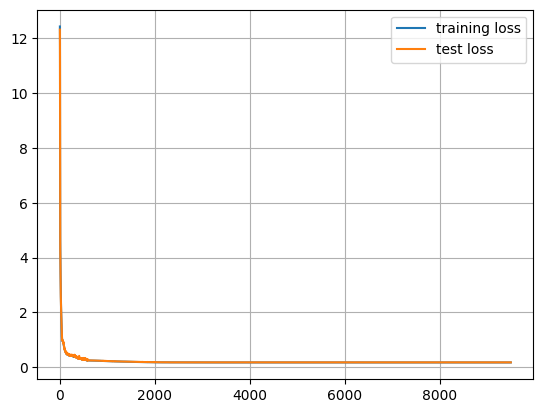

--------------------  EPOCH: 9500  --------------------
LOSS train 0.1714380219578743 valid 0.17499013245105743
--------------------  EPOCH: 9501  --------------------
LOSS train 0.1713897243142128 valid 0.17499011754989624
--------------------  EPOCH: 9502  --------------------
LOSS train 0.17133904099464417 valid 0.17498986423015594
--------------------  EPOCH: 9503  --------------------
LOSS train 0.17112526297569275 valid 0.17499002814292908
--------------------  EPOCH: 9504  --------------------
LOSS train 0.17139681279659272 valid 0.17498977482318878
--------------------  EPOCH: 9505  --------------------
LOSS train 0.17137962430715561 valid 0.1749895215034485
--------------------  EPOCH: 9506  --------------------
LOSS train 0.1713397890329361 valid 0.1749897301197052
--------------------  EPOCH: 9507  --------------------
LOSS train 0.17134110480546952 valid 0.17498955130577087
--------------------  EPOCH: 9508  --------------------
LOSS train 0.17137010246515275 valid 0.174989

LOSS train 0.17138541638851165 valid 0.1749863475561142
--------------------  EPOCH: 9574  --------------------
LOSS train 0.17146063596010208 valid 0.17498637735843658
--------------------  EPOCH: 9575  --------------------
LOSS train 0.17136561125516891 valid 0.17498640716075897
--------------------  EPOCH: 9576  --------------------
LOSS train 0.1714564308524132 valid 0.17498630285263062
--------------------  EPOCH: 9577  --------------------
LOSS train 0.1713976338505745 valid 0.17498648166656494
--------------------  EPOCH: 9578  --------------------
LOSS train 0.17130184173583984 valid 0.17498651146888733
--------------------  EPOCH: 9579  --------------------
LOSS train 0.1713392049074173 valid 0.17498618364334106
--------------------  EPOCH: 9580  --------------------
LOSS train 0.17140481173992156 valid 0.17498624324798584
--------------------  EPOCH: 9581  --------------------
LOSS train 0.17142418920993804 valid 0.17498621344566345
--------------------  EPOCH: 9582  --------

LOSS train 0.17144907116889954 valid 0.17498336732387543
--------------------  EPOCH: 9647  --------------------
LOSS train 0.17135107964277269 valid 0.17498333752155304
--------------------  EPOCH: 9648  --------------------
LOSS train 0.17130593657493592 valid 0.17498336732387543
--------------------  EPOCH: 9649  --------------------
LOSS train 0.1713567018508911 valid 0.17498312890529633
--------------------  EPOCH: 9650  --------------------
LOSS train 0.1713409647345543 valid 0.17498306930065155
--------------------  EPOCH: 9651  --------------------
LOSS train 0.17141667902469634 valid 0.17498305439949036
--------------------  EPOCH: 9652  --------------------
LOSS train 0.17146911323070527 valid 0.17498303949832916
--------------------  EPOCH: 9653  --------------------
LOSS train 0.17145528197288512 valid 0.17498324811458588
--------------------  EPOCH: 9654  --------------------
LOSS train 0.17144233286380767 valid 0.1749829798936844
--------------------  EPOCH: 9655  -------

LOSS train 0.17143347412347792 valid 0.17497970163822174
--------------------  EPOCH: 9720  --------------------
LOSS train 0.17140300571918488 valid 0.17497970163822174
--------------------  EPOCH: 9721  --------------------
LOSS train 0.17142458409070968 valid 0.17497962713241577
--------------------  EPOCH: 9722  --------------------
LOSS train 0.17146603018045425 valid 0.17497973144054413
--------------------  EPOCH: 9723  --------------------
LOSS train 0.17142946273088455 valid 0.17497965693473816
--------------------  EPOCH: 9724  --------------------
LOSS train 0.17137409895658492 valid 0.1749795526266098
--------------------  EPOCH: 9725  --------------------
LOSS train 0.17135113328695298 valid 0.17497935891151428
--------------------  EPOCH: 9726  --------------------
LOSS train 0.17140511125326158 valid 0.1749793291091919
--------------------  EPOCH: 9727  --------------------
LOSS train 0.17137900292873381 valid 0.17497926950454712
--------------------  EPOCH: 9728  ------

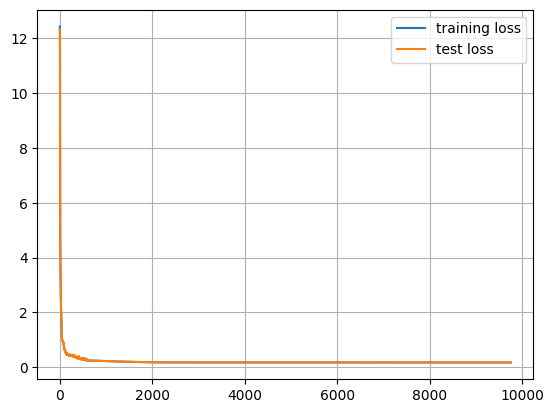

--------------------  EPOCH: 9750  --------------------
LOSS train 0.1713610291481018 valid 0.17497847974300385
--------------------  EPOCH: 9751  --------------------
LOSS train 0.17134694904088973 valid 0.17497847974300385
--------------------  EPOCH: 9752  --------------------
LOSS train 0.17128758132457733 valid 0.17497830092906952
--------------------  EPOCH: 9753  --------------------
LOSS train 0.1714607760310173 valid 0.1749783307313919
--------------------  EPOCH: 9754  --------------------
LOSS train 0.17127859592437744 valid 0.17497830092906952
--------------------  EPOCH: 9755  --------------------
LOSS train 0.17129630744457244 valid 0.1749783158302307
--------------------  EPOCH: 9756  --------------------
LOSS train 0.17132177501916884 valid 0.1749780923128128
--------------------  EPOCH: 9757  --------------------
LOSS train 0.17146035134792328 valid 0.17497804760932922
--------------------  EPOCH: 9758  --------------------
LOSS train 0.17145852744579315 valid 0.174978

LOSS train 0.1714719146490097 valid 0.17497527599334717
--------------------  EPOCH: 9824  --------------------
LOSS train 0.17144039273262024 valid 0.17497530579566956
--------------------  EPOCH: 9825  --------------------
LOSS train 0.17136855870485307 valid 0.17497509717941284
--------------------  EPOCH: 9826  --------------------
LOSS train 0.1712960422039032 valid 0.1749752312898636
--------------------  EPOCH: 9827  --------------------
LOSS train 0.17136836647987366 valid 0.17497487366199493
--------------------  EPOCH: 9828  --------------------
LOSS train 0.17138785868883133 valid 0.17497503757476807
--------------------  EPOCH: 9829  --------------------
LOSS train 0.17144834399223327 valid 0.17497478425502777
--------------------  EPOCH: 9830  --------------------
LOSS train 0.17128572016954421 valid 0.17497481405735016
--------------------  EPOCH: 9831  --------------------
LOSS train 0.171376271545887 valid 0.174974724650383
--------------------  EPOCH: 9832  -----------

LOSS train 0.17136206924915315 valid 0.17497172951698303
--------------------  EPOCH: 9897  --------------------
LOSS train 0.1713870197534561 valid 0.1749715954065323
--------------------  EPOCH: 9898  --------------------
LOSS train 0.17137980014085769 valid 0.17497152090072632
--------------------  EPOCH: 9899  --------------------
LOSS train 0.17150187045335769 valid 0.1749715656042099
--------------------  EPOCH: 9900  --------------------
LOSS train 0.1714741289615631 valid 0.1749715507030487
--------------------  EPOCH: 9901  --------------------
LOSS train 0.1712937444448471 valid 0.1749715805053711
--------------------  EPOCH: 9902  --------------------
LOSS train 0.17139827311038972 valid 0.17497152090072632
--------------------  EPOCH: 9903  --------------------
LOSS train 0.17127590775489807 valid 0.17497149109840393
--------------------  EPOCH: 9904  --------------------
LOSS train 0.17143698483705522 valid 0.17497120797634125
--------------------  EPOCH: 9905  -----------

LOSS train 0.17123637795448304 valid 0.1749686747789383
--------------------  EPOCH: 9970  --------------------
LOSS train 0.1713510811328888 valid 0.1749684065580368
--------------------  EPOCH: 9971  --------------------
LOSS train 0.1713421791791916 valid 0.1749684363603592
--------------------  EPOCH: 9972  --------------------
LOSS train 0.17139432430267335 valid 0.17496858537197113
--------------------  EPOCH: 9973  --------------------
LOSS train 0.17135070413351058 valid 0.17496837675571442
--------------------  EPOCH: 9974  --------------------
LOSS train 0.17135318070650102 valid 0.1749681979417801
--------------------  EPOCH: 9975  --------------------
LOSS train 0.17139606773853303 valid 0.17496851086616516
--------------------  EPOCH: 9976  --------------------
LOSS train 0.17152438461780548 valid 0.17496837675571442
--------------------  EPOCH: 9977  --------------------
LOSS train 0.1713472917675972 valid 0.1749681979417801
--------------------  EPOCH: 9978  ------------

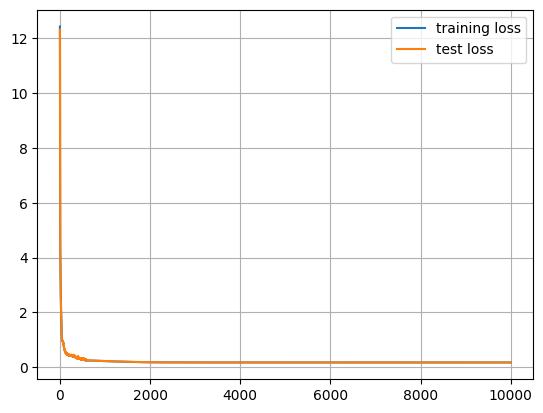

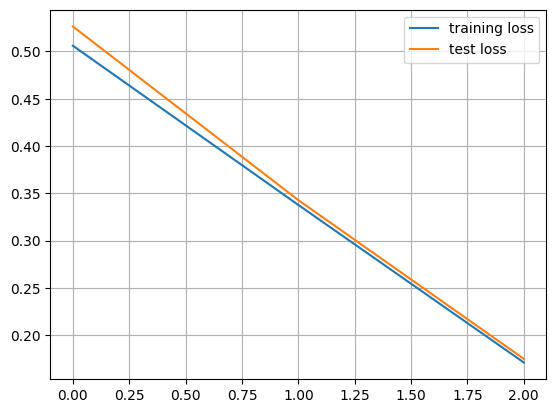

data_size: 80000
--------------------  EPOCH: 0  --------------------
LOSS train 12.403198862075806 valid 12.115116119384766
--------------------  EPOCH: 1  --------------------
LOSS train 11.182662153244019 valid 9.40319538116455
--------------------  EPOCH: 2  --------------------
LOSS train 6.55284616947174 valid 5.46036434173584
--------------------  EPOCH: 3  --------------------
LOSS train 4.876883840560913 valid 4.601140022277832
--------------------  EPOCH: 4  --------------------
LOSS train 4.389597868919372 valid 4.228095054626465
--------------------  EPOCH: 5  --------------------
LOSS train 4.084330880641938 valid 3.949483633041382
--------------------  EPOCH: 6  --------------------
LOSS train 3.827694797515869 valid 3.722212791442871
--------------------  EPOCH: 7  --------------------
LOSS train 3.618972992897034 valid 3.518733263015747
--------------------  EPOCH: 8  --------------------
LOSS train 3.403253746032715 valid 3.277071714401245
--------------------  EPOCH: 

LOSS train 0.5350618749856949 valid 0.5252800583839417
--------------------  EPOCH: 76  --------------------
LOSS train 0.529340335726738 valid 0.5287624597549438
--------------------  EPOCH: 77  --------------------
LOSS train 0.5228204160928727 valid 0.5171491503715515
--------------------  EPOCH: 78  --------------------
LOSS train 0.5171414837241173 valid 0.5363867282867432
--------------------  EPOCH: 79  --------------------
LOSS train 0.5529822796583176 valid 0.548504114151001
--------------------  EPOCH: 80  --------------------
LOSS train 0.540608161687851 valid 0.5086236000061035
--------------------  EPOCH: 81  --------------------
LOSS train 0.5105101510882377 valid 0.5063916444778442
--------------------  EPOCH: 82  --------------------
LOSS train 0.5057345569133759 valid 0.5042095184326172
--------------------  EPOCH: 83  --------------------
LOSS train 0.5068249121308327 valid 0.5196208953857422
--------------------  EPOCH: 84  --------------------
LOSS train 0.510671420

LOSS train 0.34003269523382185 valid 0.3288203179836273
--------------------  EPOCH: 151  --------------------
LOSS train 0.3353772655129433 valid 0.33849072456359863
--------------------  EPOCH: 152  --------------------
LOSS train 0.3319239988923073 valid 0.3354220986366272
--------------------  EPOCH: 153  --------------------
LOSS train 0.33940463960170747 valid 0.3465771973133087
--------------------  EPOCH: 154  --------------------
LOSS train 0.3257816001772881 valid 0.32503247261047363
--------------------  EPOCH: 155  --------------------
LOSS train 0.33088647574186325 valid 0.32587119936943054
--------------------  EPOCH: 156  --------------------
LOSS train 0.32690197229385376 valid 0.31891900300979614
--------------------  EPOCH: 157  --------------------
LOSS train 0.31454388946294787 valid 0.3132585287094116
--------------------  EPOCH: 158  --------------------
LOSS train 0.3210327848792076 valid 0.33861055970191956
--------------------  EPOCH: 159  --------------------


LOSS train 0.20338406413793564 valid 0.22141677141189575
--------------------  EPOCH: 225  --------------------
LOSS train 0.20425798892974853 valid 0.20126979053020477
--------------------  EPOCH: 226  --------------------
LOSS train 0.20586780458688736 valid 0.21200424432754517
--------------------  EPOCH: 227  --------------------
LOSS train 0.20516540184617044 valid 0.23336338996887207
--------------------  EPOCH: 228  --------------------
LOSS train 0.20585041344165803 valid 0.22049525380134583
--------------------  EPOCH: 229  --------------------
LOSS train 0.20938977226614952 valid 0.1962973028421402
--------------------  EPOCH: 230  --------------------
LOSS train 0.21596622616052627 valid 0.24113193154335022
--------------------  EPOCH: 231  --------------------
LOSS train 0.2136838749051094 valid 0.25228092074394226
--------------------  EPOCH: 232  --------------------
LOSS train 0.22305228561162949 valid 0.1967109739780426
--------------------  EPOCH: 233  ----------------

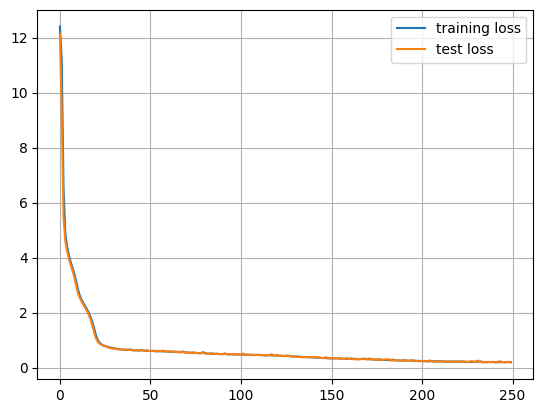

--------------------  EPOCH: 250  --------------------
LOSS train 0.18987416848540306 valid 0.1905067265033722
--------------------  EPOCH: 251  --------------------
LOSS train 0.20269293636083602 valid 0.18223653733730316
--------------------  EPOCH: 252  --------------------
LOSS train 0.1859501577913761 valid 0.1811806559562683
--------------------  EPOCH: 253  --------------------
LOSS train 0.19210902005434036 valid 0.19979336857795715
--------------------  EPOCH: 254  --------------------
LOSS train 0.1938629135489464 valid 0.17981144785881042
--------------------  EPOCH: 255  --------------------
LOSS train 0.19465799629688263 valid 0.18823936581611633
--------------------  EPOCH: 256  --------------------
LOSS train 0.19565871804952623 valid 0.21136772632598877
--------------------  EPOCH: 257  --------------------
LOSS train 0.19811790883541108 valid 0.18036404252052307
--------------------  EPOCH: 258  --------------------
LOSS train 0.19484769999980928 valid 0.17869055271148

LOSS train 0.17005375623703003 valid 0.17706505954265594
--------------------  EPOCH: 325  --------------------
LOSS train 0.16975346729159355 valid 0.1616089791059494
--------------------  EPOCH: 326  --------------------
LOSS train 0.1617622673511505 valid 0.16047513484954834
--------------------  EPOCH: 327  --------------------
LOSS train 0.17205089926719666 valid 0.17819924652576447
--------------------  EPOCH: 328  --------------------
LOSS train 0.17076106294989585 valid 0.1821797639131546
--------------------  EPOCH: 329  --------------------
LOSS train 0.16815438270568847 valid 0.1563868522644043
--------------------  EPOCH: 330  --------------------
LOSS train 0.16573635190725328 valid 0.1756923496723175
--------------------  EPOCH: 331  --------------------
LOSS train 0.16660553142428397 valid 0.15662787854671478
--------------------  EPOCH: 332  --------------------
LOSS train 0.16682787463068963 valid 0.15775437653064728
--------------------  EPOCH: 333  ------------------

LOSS train 0.14374870508909227 valid 0.14569614827632904
--------------------  EPOCH: 398  --------------------
LOSS train 0.14364377707242965 valid 0.1455957591533661
--------------------  EPOCH: 399  --------------------
LOSS train 0.1436433546245098 valid 0.14576998353004456
--------------------  EPOCH: 400  --------------------
LOSS train 0.1437151849269867 valid 0.14554943144321442
--------------------  EPOCH: 401  --------------------
LOSS train 0.1435335472226143 valid 0.14563308656215668
--------------------  EPOCH: 402  --------------------
LOSS train 0.14351250231266022 valid 0.1455158293247223
--------------------  EPOCH: 403  --------------------
LOSS train 0.14361072480678558 valid 0.14585073292255402
--------------------  EPOCH: 404  --------------------
LOSS train 0.1436207450926304 valid 0.1455564796924591
--------------------  EPOCH: 405  --------------------
LOSS train 0.14349014163017274 valid 0.1455068290233612
--------------------  EPOCH: 406  --------------------


LOSS train 0.14242609739303588 valid 0.14428138732910156
--------------------  EPOCH: 472  --------------------
LOSS train 0.1422123484313488 valid 0.1443617045879364
--------------------  EPOCH: 473  --------------------
LOSS train 0.14235946908593178 valid 0.14409838616847992
--------------------  EPOCH: 474  --------------------
LOSS train 0.14212242811918258 valid 0.14430278539657593
--------------------  EPOCH: 475  --------------------
LOSS train 0.14223839715123177 valid 0.14418751001358032
--------------------  EPOCH: 476  --------------------
LOSS train 0.1420643299818039 valid 0.1441810429096222
--------------------  EPOCH: 477  --------------------
LOSS train 0.14214456751942633 valid 0.14398817718029022
--------------------  EPOCH: 478  --------------------
LOSS train 0.1422252967953682 valid 0.14437568187713623
--------------------  EPOCH: 479  --------------------
LOSS train 0.1420491673052311 valid 0.14394338428974152
--------------------  EPOCH: 480  -------------------

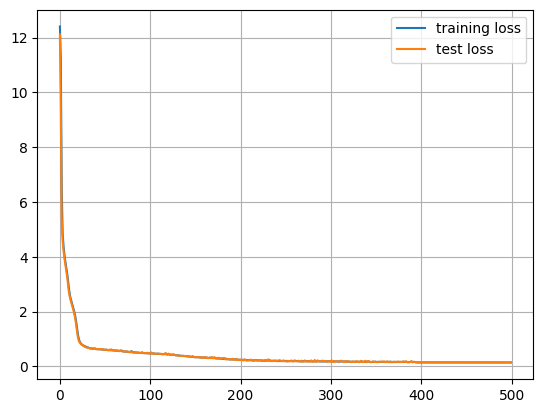

--------------------  EPOCH: 500  --------------------
LOSS train 0.14145825132727624 valid 0.14330895245075226
--------------------  EPOCH: 501  --------------------
LOSS train 0.1415289521217346 valid 0.14342518150806427
--------------------  EPOCH: 502  --------------------
LOSS train 0.14131656661629677 valid 0.1438797116279602
--------------------  EPOCH: 503  --------------------
LOSS train 0.14142462983727455 valid 0.14337974786758423
--------------------  EPOCH: 504  --------------------
LOSS train 0.14152340218424797 valid 0.14344422519207
--------------------  EPOCH: 505  --------------------
LOSS train 0.14157576560974122 valid 0.14367610216140747
--------------------  EPOCH: 506  --------------------
LOSS train 0.14139562100172043 valid 0.14308999478816986
--------------------  EPOCH: 507  --------------------
LOSS train 0.14122427701950074 valid 0.14345869421958923
--------------------  EPOCH: 508  --------------------
LOSS train 0.14137300178408624 valid 0.143457621335983

LOSS train 0.13893815353512765 valid 0.14086602628231049
--------------------  EPOCH: 574  --------------------
LOSS train 0.13904937356710434 valid 0.14187760651111603
--------------------  EPOCH: 575  --------------------
LOSS train 0.13951684907078743 valid 0.14288069307804108
--------------------  EPOCH: 576  --------------------
LOSS train 0.1395270347595215 valid 0.14161863923072815
--------------------  EPOCH: 577  --------------------
LOSS train 0.1393614836037159 valid 0.14066265523433685
--------------------  EPOCH: 578  --------------------
LOSS train 0.13873234987258912 valid 0.14140114188194275
--------------------  EPOCH: 579  --------------------
LOSS train 0.13875172510743142 valid 0.14049066603183746
--------------------  EPOCH: 580  --------------------
LOSS train 0.1387512691318989 valid 0.14059187471866608
--------------------  EPOCH: 581  --------------------
LOSS train 0.13889392837882042 valid 0.14193174242973328
--------------------  EPOCH: 582  ----------------

LOSS train 0.13649156466126441 valid 0.13800664246082306
--------------------  EPOCH: 648  --------------------
LOSS train 0.1370852880179882 valid 0.1382046341896057
--------------------  EPOCH: 649  --------------------
LOSS train 0.13685793653130532 valid 0.1386701613664627
--------------------  EPOCH: 650  --------------------
LOSS train 0.13669594526290893 valid 0.1410592496395111
--------------------  EPOCH: 651  --------------------
LOSS train 0.13684947565197944 valid 0.1381670981645584
--------------------  EPOCH: 652  --------------------
LOSS train 0.13596444875001906 valid 0.13794736564159393
--------------------  EPOCH: 653  --------------------
LOSS train 0.13622864484786987 valid 0.13785383105278015
--------------------  EPOCH: 654  --------------------
LOSS train 0.1359582409262657 valid 0.1386720985174179
--------------------  EPOCH: 655  --------------------
LOSS train 0.1362958148121834 valid 0.13783839344978333
--------------------  EPOCH: 656  --------------------


LOSS train 0.1339321404695511 valid 0.1359776109457016
--------------------  EPOCH: 722  --------------------
LOSS train 0.1340905375778675 valid 0.1358136683702469
--------------------  EPOCH: 723  --------------------
LOSS train 0.13440039455890657 valid 0.13550753891468048
--------------------  EPOCH: 724  --------------------
LOSS train 0.13419802784919738 valid 0.1357090026140213
--------------------  EPOCH: 725  --------------------
LOSS train 0.13375662565231322 valid 0.1353103220462799
--------------------  EPOCH: 726  --------------------
LOSS train 0.1334253117442131 valid 0.13564875721931458
--------------------  EPOCH: 727  --------------------
LOSS train 0.1335887096822262 valid 0.1352870613336563
--------------------  EPOCH: 728  --------------------
LOSS train 0.1338527925312519 valid 0.13609030842781067
--------------------  EPOCH: 729  --------------------
LOSS train 0.13436832502484322 valid 0.13631673157215118
--------------------  EPOCH: 730  --------------------
LO

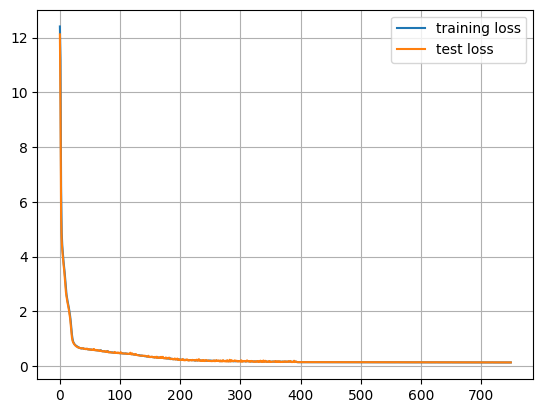

--------------------  EPOCH: 750  --------------------
LOSS train 0.13310169503092767 valid 0.13467535376548767
--------------------  EPOCH: 751  --------------------
LOSS train 0.13371647223830224 valid 0.13714294135570526
--------------------  EPOCH: 752  --------------------
LOSS train 0.1337064780294895 valid 0.1365470439195633
--------------------  EPOCH: 753  --------------------
LOSS train 0.13388585150241852 valid 0.1348087042570114
--------------------  EPOCH: 754  --------------------
LOSS train 0.1328248620033264 valid 0.13490785658359528
--------------------  EPOCH: 755  --------------------
LOSS train 0.1330331616103649 valid 0.13446322083473206
--------------------  EPOCH: 756  --------------------
LOSS train 0.13256615698337554 valid 0.13520435988903046
--------------------  EPOCH: 757  --------------------
LOSS train 0.1330266624689102 valid 0.13436982035636902
--------------------  EPOCH: 758  --------------------
LOSS train 0.1325419895350933 valid 0.13476163148880005

LOSS train 0.1311950072646141 valid 0.13299524784088135
--------------------  EPOCH: 825  --------------------
LOSS train 0.13086301758885382 valid 0.13242366909980774
--------------------  EPOCH: 826  --------------------
LOSS train 0.13055041134357454 valid 0.13234852254390717
--------------------  EPOCH: 827  --------------------
LOSS train 0.13072408512234687 valid 0.13270074129104614
--------------------  EPOCH: 828  --------------------
LOSS train 0.13107544630765916 valid 0.13255853950977325
--------------------  EPOCH: 829  --------------------
LOSS train 0.13064531609416008 valid 0.13334183394908905
--------------------  EPOCH: 830  --------------------
LOSS train 0.1309441164135933 valid 0.1324489861726761
--------------------  EPOCH: 831  --------------------
LOSS train 0.13056122064590453 valid 0.13216958940029144
--------------------  EPOCH: 832  --------------------
LOSS train 0.1305076189339161 valid 0.13243712484836578
--------------------  EPOCH: 833  -----------------

LOSS train 0.12895049452781676 valid 0.1307992935180664
--------------------  EPOCH: 899  --------------------
LOSS train 0.12871006317436695 valid 0.1307523250579834
--------------------  EPOCH: 900  --------------------
LOSS train 0.12857892438769342 valid 0.13063664734363556
--------------------  EPOCH: 901  --------------------
LOSS train 0.12939636074006558 valid 0.13049644231796265
--------------------  EPOCH: 902  --------------------
LOSS train 0.12860434949398042 valid 0.13128700852394104
--------------------  EPOCH: 903  --------------------
LOSS train 0.12873132079839705 valid 0.13167990744113922
--------------------  EPOCH: 904  --------------------
LOSS train 0.12868066281080245 valid 0.13046932220458984
--------------------  EPOCH: 905  --------------------
LOSS train 0.12823568284511566 valid 0.13043548166751862
--------------------  EPOCH: 906  --------------------
LOSS train 0.12859851941466333 valid 0.13030412793159485
--------------------  EPOCH: 907  ---------------

LOSS train 0.12686366364359855 valid 0.12882038950920105
--------------------  EPOCH: 973  --------------------
LOSS train 0.1274691067636013 valid 0.1287158876657486
--------------------  EPOCH: 974  --------------------
LOSS train 0.1275569062680006 valid 0.12880481779575348
--------------------  EPOCH: 975  --------------------
LOSS train 0.12694364674389363 valid 0.1288692057132721
--------------------  EPOCH: 976  --------------------
LOSS train 0.12775825746357442 valid 0.12973767518997192
--------------------  EPOCH: 977  --------------------
LOSS train 0.12691651694476605 valid 0.12880225479602814
--------------------  EPOCH: 978  --------------------
LOSS train 0.12711985409259796 valid 0.12867891788482666
--------------------  EPOCH: 979  --------------------
LOSS train 0.12667908258736132 valid 0.128614604473114
--------------------  EPOCH: 980  --------------------
LOSS train 0.12660447210073472 valid 0.12930803000926971
--------------------  EPOCH: 981  -------------------

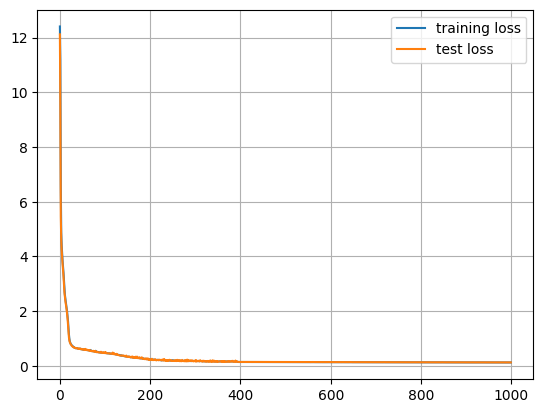

--------------------  EPOCH: 1000  --------------------
LOSS train 0.12627410218119622 valid 0.12845183908939362
--------------------  EPOCH: 1001  --------------------
LOSS train 0.12663495503365993 valid 0.12807652354240417
--------------------  EPOCH: 1002  --------------------
LOSS train 0.1263136003166437 valid 0.12809433043003082
--------------------  EPOCH: 1003  --------------------
LOSS train 0.12634919285774232 valid 0.12903770804405212
--------------------  EPOCH: 1004  --------------------
LOSS train 0.12653141058981418 valid 0.1299029290676117
--------------------  EPOCH: 1005  --------------------
LOSS train 0.12650474309921264 valid 0.12795549631118774
--------------------  EPOCH: 1006  --------------------
LOSS train 0.12636957541108132 valid 0.1281319409608841
--------------------  EPOCH: 1007  --------------------
LOSS train 0.12670332416892052 valid 0.1297845095396042
--------------------  EPOCH: 1008  --------------------
LOSS train 0.12626058235764503 valid 0.12794

LOSS train 0.12466931641101837 valid 0.12664927542209625
--------------------  EPOCH: 1074  --------------------
LOSS train 0.12466174177825451 valid 0.12824104726314545
--------------------  EPOCH: 1075  --------------------
LOSS train 0.12494836300611496 valid 0.12679541110992432
--------------------  EPOCH: 1076  --------------------
LOSS train 0.12482504695653915 valid 0.12849436700344086
--------------------  EPOCH: 1077  --------------------
LOSS train 0.12530435137450696 valid 0.1272592842578888
--------------------  EPOCH: 1078  --------------------
LOSS train 0.12508171871304513 valid 0.12656153738498688
--------------------  EPOCH: 1079  --------------------
LOSS train 0.1247850138694048 valid 0.1265653669834137
--------------------  EPOCH: 1080  --------------------
LOSS train 0.124796312302351 valid 0.12711986899375916
--------------------  EPOCH: 1081  --------------------
LOSS train 0.12495258525013923 valid 0.126949280500412
--------------------  EPOCH: 1082  -----------

LOSS train 0.12436357960104942 valid 0.12511850893497467
--------------------  EPOCH: 1147  --------------------
LOSS train 0.12338576465845108 valid 0.12502063810825348
--------------------  EPOCH: 1148  --------------------
LOSS train 0.12314384430646896 valid 0.12512603402137756
--------------------  EPOCH: 1149  --------------------
LOSS train 0.12324398756027222 valid 0.12514641880989075
--------------------  EPOCH: 1150  --------------------
LOSS train 0.12300029024481773 valid 0.12521232664585114
--------------------  EPOCH: 1151  --------------------
LOSS train 0.12324329651892185 valid 0.12595075368881226
--------------------  EPOCH: 1152  --------------------
LOSS train 0.12353967651724815 valid 0.12608440220355988
--------------------  EPOCH: 1153  --------------------
LOSS train 0.12312712706625462 valid 0.12514643371105194
--------------------  EPOCH: 1154  --------------------
LOSS train 0.12302014678716659 valid 0.12487421184778214
--------------------  EPOCH: 1155  ----

LOSS train 0.12200236171483994 valid 0.1237073615193367
--------------------  EPOCH: 1220  --------------------
LOSS train 0.12194452621042728 valid 0.12470386177301407
--------------------  EPOCH: 1221  --------------------
LOSS train 0.12188862599432468 valid 0.12370852380990982
--------------------  EPOCH: 1222  --------------------
LOSS train 0.12222595773637294 valid 0.12404555827379227
--------------------  EPOCH: 1223  --------------------
LOSS train 0.12222552336752415 valid 0.12418745458126068
--------------------  EPOCH: 1224  --------------------
LOSS train 0.12184571884572507 valid 0.12394964694976807
--------------------  EPOCH: 1225  --------------------
LOSS train 0.12214639075100422 valid 0.12385666370391846
--------------------  EPOCH: 1226  --------------------
LOSS train 0.121912507340312 valid 0.1253056824207306
--------------------  EPOCH: 1227  --------------------
LOSS train 0.12201692461967469 valid 0.12375550717115402
--------------------  EPOCH: 1228  --------

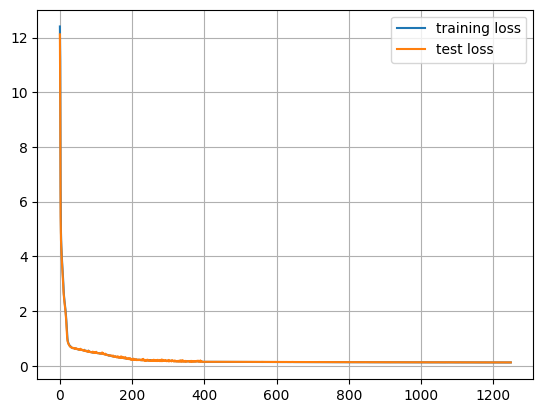

--------------------  EPOCH: 1250  --------------------
LOSS train 0.1212647695094347 valid 0.12340936064720154
--------------------  EPOCH: 1251  --------------------
LOSS train 0.12116197347640992 valid 0.1234893724322319
--------------------  EPOCH: 1252  --------------------
LOSS train 0.12171455398201943 valid 0.12316301465034485
--------------------  EPOCH: 1253  --------------------
LOSS train 0.12135397605597972 valid 0.12404846400022507
--------------------  EPOCH: 1254  --------------------
LOSS train 0.12231427766382694 valid 0.12360977381467819
--------------------  EPOCH: 1255  --------------------
LOSS train 0.12128514833748341 valid 0.12309730052947998
--------------------  EPOCH: 1256  --------------------
LOSS train 0.12117652036249638 valid 0.12364405393600464
--------------------  EPOCH: 1257  --------------------
LOSS train 0.12124991603195667 valid 0.1238507628440857
--------------------  EPOCH: 1258  --------------------
LOSS train 0.12174190133810044 valid 0.1232

LOSS train 0.12004382163286209 valid 0.12202379107475281
--------------------  EPOCH: 1324  --------------------
LOSS train 0.12011703811585903 valid 0.1218656450510025
--------------------  EPOCH: 1325  --------------------
LOSS train 0.11977022029459476 valid 0.12214085459709167
--------------------  EPOCH: 1326  --------------------
LOSS train 0.12071485668420792 valid 0.12599746882915497
--------------------  EPOCH: 1327  --------------------
LOSS train 0.12071631178259849 valid 0.12288188189268112
--------------------  EPOCH: 1328  --------------------
LOSS train 0.12032120451331138 valid 0.12206912040710449
--------------------  EPOCH: 1329  --------------------
LOSS train 0.11993418261408806 valid 0.12258972227573395
--------------------  EPOCH: 1330  --------------------
LOSS train 0.12005979530513286 valid 0.12255330383777618
--------------------  EPOCH: 1331  --------------------
LOSS train 0.12003993801772594 valid 0.12174003571271896
--------------------  EPOCH: 1332  -----

LOSS train 0.11873486787080764 valid 0.12078976631164551
--------------------  EPOCH: 1397  --------------------
LOSS train 0.1189162377268076 valid 0.12314058095216751
--------------------  EPOCH: 1398  --------------------
LOSS train 0.11897578686475754 valid 0.12121254950761795
--------------------  EPOCH: 1399  --------------------
LOSS train 0.11864167004823685 valid 0.12087437510490417
--------------------  EPOCH: 1400  --------------------
LOSS train 0.11875405386090279 valid 0.12156748026609421
--------------------  EPOCH: 1401  --------------------
LOSS train 0.11901772022247314 valid 0.12062941491603851
--------------------  EPOCH: 1402  --------------------
LOSS train 0.1185702595859766 valid 0.12287968397140503
--------------------  EPOCH: 1403  --------------------
LOSS train 0.1189128827303648 valid 0.12061182409524918
--------------------  EPOCH: 1404  --------------------
LOSS train 0.11843213401734828 valid 0.12096881866455078
--------------------  EPOCH: 1405  -------

LOSS train 0.11788597367703915 valid 0.11934954673051834
--------------------  EPOCH: 1470  --------------------
LOSS train 0.11749046482145786 valid 0.12055021524429321
--------------------  EPOCH: 1471  --------------------
LOSS train 0.11748718768358231 valid 0.11965645849704742
--------------------  EPOCH: 1472  --------------------
LOSS train 0.11754072085022926 valid 0.11940407007932663
--------------------  EPOCH: 1473  --------------------
LOSS train 0.11808126680552959 valid 0.12049157917499542
--------------------  EPOCH: 1474  --------------------
LOSS train 0.11805268004536629 valid 0.12055016309022903
--------------------  EPOCH: 1475  --------------------
LOSS train 0.1174785241484642 valid 0.1193297877907753
--------------------  EPOCH: 1476  --------------------
LOSS train 0.11746071092784405 valid 0.11928624659776688
--------------------  EPOCH: 1477  --------------------
LOSS train 0.11731330640614032 valid 0.11936086416244507
--------------------  EPOCH: 1478  ------

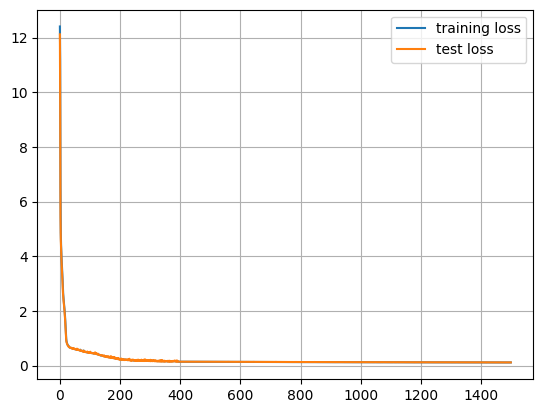

--------------------  EPOCH: 1500  --------------------
LOSS train 0.11767027266323567 valid 0.11994250863790512
--------------------  EPOCH: 1501  --------------------
LOSS train 0.11741995178163052 valid 0.11881297081708908
--------------------  EPOCH: 1502  --------------------
LOSS train 0.11713027320802212 valid 0.1198139414191246
--------------------  EPOCH: 1503  --------------------
LOSS train 0.11752779595553875 valid 0.11892230808734894
--------------------  EPOCH: 1504  --------------------
LOSS train 0.11747373715043068 valid 0.11907410621643066
--------------------  EPOCH: 1505  --------------------
LOSS train 0.11691059209406376 valid 0.1188967153429985
--------------------  EPOCH: 1506  --------------------
LOSS train 0.11721940971910953 valid 0.11890659481287003
--------------------  EPOCH: 1507  --------------------
LOSS train 0.11735924556851388 valid 0.11982022970914841
--------------------  EPOCH: 1508  --------------------
LOSS train 0.11744793318212032 valid 0.120

LOSS train 0.11639824323356152 valid 0.11769401282072067
--------------------  EPOCH: 1574  --------------------
LOSS train 0.11571750976145267 valid 0.11801694333553314
--------------------  EPOCH: 1575  --------------------
LOSS train 0.11585325300693512 valid 0.11783304810523987
--------------------  EPOCH: 1576  --------------------
LOSS train 0.11647935882210732 valid 0.11803475022315979
--------------------  EPOCH: 1577  --------------------
LOSS train 0.11630550026893616 valid 0.11774752289056778
--------------------  EPOCH: 1578  --------------------
LOSS train 0.11563360765576362 valid 0.11937326937913895
--------------------  EPOCH: 1579  --------------------
LOSS train 0.11631634496152402 valid 0.11935987323522568
--------------------  EPOCH: 1580  --------------------
LOSS train 0.1161091074347496 valid 0.12034755945205688
--------------------  EPOCH: 1581  --------------------
LOSS train 0.11623456180095673 valid 0.11764557659626007
--------------------  EPOCH: 1582  -----

LOSS train 0.11595686227083206 valid 0.1186710074543953
--------------------  EPOCH: 1647  --------------------
LOSS train 0.11521649472415448 valid 0.11682592332363129
--------------------  EPOCH: 1648  --------------------
LOSS train 0.11531544141471387 valid 0.11743886768817902
--------------------  EPOCH: 1649  --------------------
LOSS train 0.11470726318657398 valid 0.11768636107444763
--------------------  EPOCH: 1650  --------------------
LOSS train 0.11470974422991276 valid 0.11653736233711243
--------------------  EPOCH: 1651  --------------------
LOSS train 0.1144842442125082 valid 0.11679621040821075
--------------------  EPOCH: 1652  --------------------
LOSS train 0.11455814465880394 valid 0.11656182259321213
--------------------  EPOCH: 1653  --------------------
LOSS train 0.11445839144289494 valid 0.11736686527729034
--------------------  EPOCH: 1654  --------------------
LOSS train 0.11464307159185409 valid 0.11678866297006607
--------------------  EPOCH: 1655  ------

LOSS train 0.11389759369194508 valid 0.11576947569847107
--------------------  EPOCH: 1720  --------------------
LOSS train 0.11347948834300041 valid 0.11560676991939545
--------------------  EPOCH: 1721  --------------------
LOSS train 0.11382408514618873 valid 0.11612781137228012
--------------------  EPOCH: 1722  --------------------
LOSS train 0.11373618356883526 valid 0.11561712622642517
--------------------  EPOCH: 1723  --------------------
LOSS train 0.11341865062713623 valid 0.1160954162478447
--------------------  EPOCH: 1724  --------------------
LOSS train 0.11367482617497444 valid 0.11555561423301697
--------------------  EPOCH: 1725  --------------------
LOSS train 0.11367122083902359 valid 0.1155230849981308
--------------------  EPOCH: 1726  --------------------
LOSS train 0.11338268555700778 valid 0.1154576912522316
--------------------  EPOCH: 1727  --------------------
LOSS train 0.11342594139277935 valid 0.11668656021356583
--------------------  EPOCH: 1728  -------

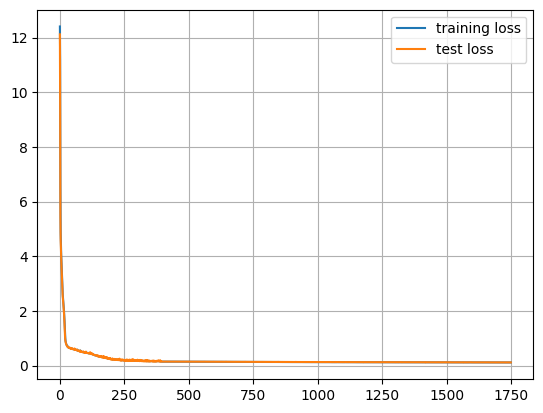

--------------------  EPOCH: 1750  --------------------
LOSS train 0.11302163749933243 valid 0.11523516476154327
--------------------  EPOCH: 1751  --------------------
LOSS train 0.11302046254277229 valid 0.1153767853975296
--------------------  EPOCH: 1752  --------------------
LOSS train 0.11324304006993771 valid 0.11581622809171677
--------------------  EPOCH: 1753  --------------------
LOSS train 0.11331333629786969 valid 0.11590974032878876
--------------------  EPOCH: 1754  --------------------
LOSS train 0.11398085877299309 valid 0.11554660648107529
--------------------  EPOCH: 1755  --------------------
LOSS train 0.11319290883839131 valid 0.11624085903167725
--------------------  EPOCH: 1756  --------------------
LOSS train 0.11389993131160736 valid 0.11809686571359634
--------------------  EPOCH: 1757  --------------------
LOSS train 0.11332941427826881 valid 0.11498180776834488
--------------------  EPOCH: 1758  --------------------
LOSS train 0.11288505531847477 valid 0.11

LOSS train 0.11280164793133736 valid 0.11410224437713623
--------------------  EPOCH: 1824  --------------------
LOSS train 0.11209885701537133 valid 0.11463045328855515
--------------------  EPOCH: 1825  --------------------
LOSS train 0.11194214560091495 valid 0.11397513002157211
--------------------  EPOCH: 1826  --------------------
LOSS train 0.11226948499679565 valid 0.11431624740362167
--------------------  EPOCH: 1827  --------------------
LOSS train 0.11209333054721356 valid 0.1147579699754715
--------------------  EPOCH: 1828  --------------------
LOSS train 0.11218904368579388 valid 0.11481517553329468
--------------------  EPOCH: 1829  --------------------
LOSS train 0.11214086636900902 valid 0.11507204174995422
--------------------  EPOCH: 1830  --------------------
LOSS train 0.11286035887897014 valid 0.1142411082983017
--------------------  EPOCH: 1831  --------------------
LOSS train 0.11183641776442528 valid 0.11395137757062912
--------------------  EPOCH: 1832  ------

LOSS train 0.1108149241656065 valid 0.11238154023885727
--------------------  EPOCH: 1897  --------------------
LOSS train 0.11032069101929665 valid 0.11244677007198334
--------------------  EPOCH: 1898  --------------------
LOSS train 0.11040951199829578 valid 0.11366330832242966
--------------------  EPOCH: 1899  --------------------
LOSS train 0.11052174717187882 valid 0.11225178837776184
--------------------  EPOCH: 1900  --------------------
LOSS train 0.1101742897182703 valid 0.11280263960361481
--------------------  EPOCH: 1901  --------------------
LOSS train 0.11092969439923764 valid 0.11382896453142166
--------------------  EPOCH: 1902  --------------------
LOSS train 0.11014261096715927 valid 0.11212993413209915
--------------------  EPOCH: 1903  --------------------
LOSS train 0.10996776893734932 valid 0.11220094561576843
--------------------  EPOCH: 1904  --------------------
LOSS train 0.11003552339971065 valid 0.1121799647808075
--------------------  EPOCH: 1905  -------

LOSS train 0.10832094922661781 valid 0.11049080640077591
--------------------  EPOCH: 1970  --------------------
LOSS train 0.10825963467359542 valid 0.11020650714635849
--------------------  EPOCH: 1971  --------------------
LOSS train 0.10837098993360997 valid 0.1103273555636406
--------------------  EPOCH: 1972  --------------------
LOSS train 0.10878952927887439 valid 0.11058060079813004
--------------------  EPOCH: 1973  --------------------
LOSS train 0.10841750577092171 valid 0.11086633056402206
--------------------  EPOCH: 1974  --------------------
LOSS train 0.10821600705385208 valid 0.1101812869310379
--------------------  EPOCH: 1975  --------------------
LOSS train 0.10835995562374592 valid 0.11030520498752594
--------------------  EPOCH: 1976  --------------------
LOSS train 0.10845082886517048 valid 0.11038875579833984
--------------------  EPOCH: 1977  --------------------
LOSS train 0.1084946047514677 valid 0.11028152704238892
--------------------  EPOCH: 1978  -------

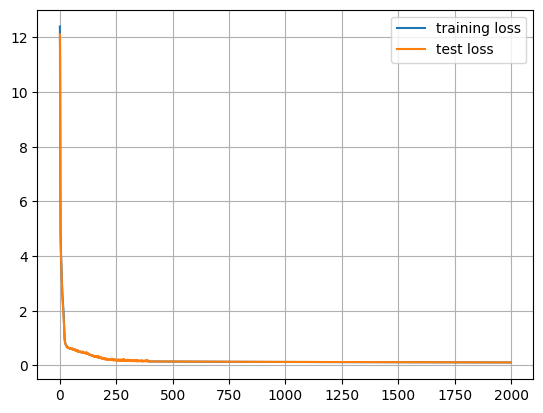

--------------------  EPOCH: 2000  --------------------
LOSS train 0.10858325101435184 valid 0.10967376828193665
--------------------  EPOCH: 2001  --------------------
LOSS train 0.10770737640559673 valid 0.10980236530303955
--------------------  EPOCH: 2002  --------------------
LOSS train 0.10802889727056027 valid 0.10956020653247833
--------------------  EPOCH: 2003  --------------------
LOSS train 0.10754802636802197 valid 0.1095079779624939
--------------------  EPOCH: 2004  --------------------
LOSS train 0.10746443532407284 valid 0.10955173522233963
--------------------  EPOCH: 2005  --------------------
LOSS train 0.1076450627297163 valid 0.10975787788629532
--------------------  EPOCH: 2006  --------------------
LOSS train 0.10779142081737518 valid 0.10951858013868332
--------------------  EPOCH: 2007  --------------------
LOSS train 0.10786406248807907 valid 0.10948796570301056
--------------------  EPOCH: 2008  --------------------
LOSS train 0.10773771032691001 valid 0.112

LOSS train 0.10704240277409553 valid 0.10848651081323624
--------------------  EPOCH: 2074  --------------------
LOSS train 0.10703436993062496 valid 0.1086815893650055
--------------------  EPOCH: 2075  --------------------
LOSS train 0.10690575949847698 valid 0.10845241695642471
--------------------  EPOCH: 2076  --------------------
LOSS train 0.10659946873784065 valid 0.10835324227809906
--------------------  EPOCH: 2077  --------------------
LOSS train 0.10665691494941712 valid 0.10845310986042023
--------------------  EPOCH: 2078  --------------------
LOSS train 0.10661758407950402 valid 0.10931383818387985
--------------------  EPOCH: 2079  --------------------
LOSS train 0.10667257755994797 valid 0.1083328127861023
--------------------  EPOCH: 2080  --------------------
LOSS train 0.1064385574311018 valid 0.10831210762262344
--------------------  EPOCH: 2081  --------------------
LOSS train 0.10703847520053386 valid 0.10843221843242645
--------------------  EPOCH: 2082  -------

LOSS train 0.10560951568186283 valid 0.10784520208835602
--------------------  EPOCH: 2147  --------------------
LOSS train 0.10546260364353657 valid 0.10770616680383682
--------------------  EPOCH: 2148  --------------------
LOSS train 0.1057510644197464 valid 0.1073615625500679
--------------------  EPOCH: 2149  --------------------
LOSS train 0.10571190156042576 valid 0.10745836049318314
--------------------  EPOCH: 2150  --------------------
LOSS train 0.10596872121095657 valid 0.10934191197156906
--------------------  EPOCH: 2151  --------------------
LOSS train 0.10659226924180984 valid 0.10772981494665146
--------------------  EPOCH: 2152  --------------------
LOSS train 0.10566932931542397 valid 0.10895261913537979
--------------------  EPOCH: 2153  --------------------
LOSS train 0.10614074319601059 valid 0.10834338515996933
--------------------  EPOCH: 2154  --------------------
LOSS train 0.10565242879092693 valid 0.10740723460912704
--------------------  EPOCH: 2155  ------

LOSS train 0.10446955636143684 valid 0.10645730793476105
--------------------  EPOCH: 2220  --------------------
LOSS train 0.10470453724265098 valid 0.10650460422039032
--------------------  EPOCH: 2221  --------------------
LOSS train 0.1046860683709383 valid 0.10653441399335861
--------------------  EPOCH: 2222  --------------------
LOSS train 0.10456984341144562 valid 0.10675936937332153
--------------------  EPOCH: 2223  --------------------
LOSS train 0.1047823615372181 valid 0.10711243003606796
--------------------  EPOCH: 2224  --------------------
LOSS train 0.10461457446217537 valid 0.10661321878433228
--------------------  EPOCH: 2225  --------------------
LOSS train 0.10442718863487244 valid 0.10827552527189255
--------------------  EPOCH: 2226  --------------------
LOSS train 0.1056248515844345 valid 0.10759750753641129
--------------------  EPOCH: 2227  --------------------
LOSS train 0.10498396158218384 valid 0.10659375786781311
--------------------  EPOCH: 2228  -------

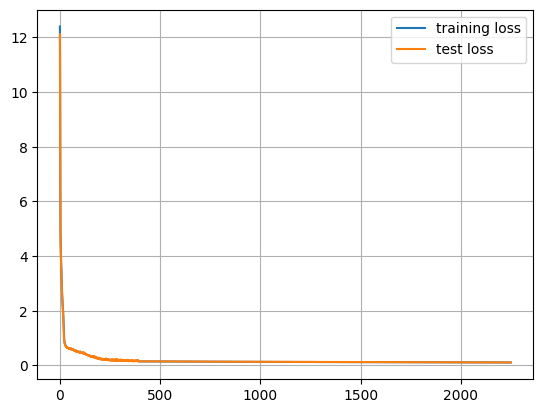

--------------------  EPOCH: 2250  --------------------
LOSS train 0.10484201014041901 valid 0.10735173523426056
--------------------  EPOCH: 2251  --------------------
LOSS train 0.10497388765215873 valid 0.10749775916337967
--------------------  EPOCH: 2252  --------------------
LOSS train 0.10498633570969104 valid 0.1063322201371193
--------------------  EPOCH: 2253  --------------------
LOSS train 0.1042272251099348 valid 0.10637155920267105
--------------------  EPOCH: 2254  --------------------
LOSS train 0.10448957048356533 valid 0.10601985454559326
--------------------  EPOCH: 2255  --------------------
LOSS train 0.10450087860226631 valid 0.10628016293048859
--------------------  EPOCH: 2256  --------------------
LOSS train 0.10466533340513706 valid 0.10605049878358841
--------------------  EPOCH: 2257  --------------------
LOSS train 0.10448757037520409 valid 0.10604138672351837
--------------------  EPOCH: 2258  --------------------
LOSS train 0.104359669983387 valid 0.10620

LOSS train 0.10370790883898735 valid 0.10571860522031784
--------------------  EPOCH: 2323  --------------------
LOSS train 0.1036270134150982 valid 0.10568930208683014
--------------------  EPOCH: 2324  --------------------
LOSS train 0.10357969179749489 valid 0.10574272274971008
--------------------  EPOCH: 2325  --------------------
LOSS train 0.1037132952362299 valid 0.10568595677614212
--------------------  EPOCH: 2326  --------------------
LOSS train 0.10371649190783501 valid 0.10569663345813751
--------------------  EPOCH: 2327  --------------------
LOSS train 0.1036897350102663 valid 0.10569047927856445
--------------------  EPOCH: 2328  --------------------
LOSS train 0.10373199097812176 valid 0.10567142069339752
--------------------  EPOCH: 2329  --------------------
LOSS train 0.10360023342072963 valid 0.10566681623458862
--------------------  EPOCH: 2330  --------------------
LOSS train 0.10365565344691277 valid 0.10575414448976517
--------------------  EPOCH: 2331  -------

LOSS train 0.10357483737170696 valid 0.10564260929822922
--------------------  EPOCH: 2395  --------------------
LOSS train 0.1036073874682188 valid 0.10564230382442474
--------------------  EPOCH: 2396  --------------------
LOSS train 0.1036094531416893 valid 0.10564159601926804
--------------------  EPOCH: 2397  --------------------
LOSS train 0.10360892899334431 valid 0.10564211010932922
--------------------  EPOCH: 2398  --------------------
LOSS train 0.10363135859370232 valid 0.10564154386520386
--------------------  EPOCH: 2399  --------------------
LOSS train 0.10359225012362003 valid 0.10564205050468445
--------------------  EPOCH: 2400  --------------------
LOSS train 0.10366406030952931 valid 0.10564150661230087
--------------------  EPOCH: 2401  --------------------
LOSS train 0.10365046821534633 valid 0.10564194619655609
--------------------  EPOCH: 2402  --------------------
LOSS train 0.1036163479089737 valid 0.10564173758029938
--------------------  EPOCH: 2403  -------

LOSS train 0.10359130650758744 valid 0.10564040392637253
--------------------  EPOCH: 2468  --------------------
LOSS train 0.1035115372389555 valid 0.10564035177230835
--------------------  EPOCH: 2469  --------------------
LOSS train 0.10352197661995888 valid 0.10564024746417999
--------------------  EPOCH: 2470  --------------------
LOSS train 0.10360085628926755 valid 0.1056399941444397
--------------------  EPOCH: 2471  --------------------
LOSS train 0.10363586582243442 valid 0.10564026981592178
--------------------  EPOCH: 2472  --------------------
LOSS train 0.10358028374612331 valid 0.10564050823450089
--------------------  EPOCH: 2473  --------------------
LOSS train 0.10360511764883995 valid 0.10564028471708298
--------------------  EPOCH: 2474  --------------------
LOSS train 0.10361532717943192 valid 0.10564102232456207
--------------------  EPOCH: 2475  --------------------
LOSS train 0.10358678326010703 valid 0.10564008355140686
--------------------  EPOCH: 2476  ------

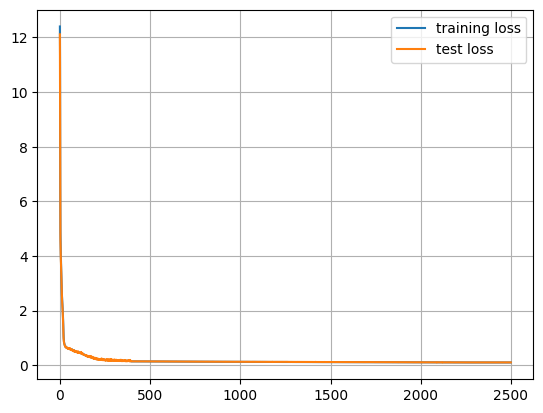

--------------------  EPOCH: 2500  --------------------
LOSS train 0.10362573899328709 valid 0.10564056783914566
--------------------  EPOCH: 2501  --------------------
LOSS train 0.10369408205151558 valid 0.10564034432172775
--------------------  EPOCH: 2502  --------------------
LOSS train 0.10348372645676136 valid 0.10564043372869492
--------------------  EPOCH: 2503  --------------------
LOSS train 0.10360039360821247 valid 0.10564029216766357
--------------------  EPOCH: 2504  --------------------
LOSS train 0.10355002544820309 valid 0.105640709400177
--------------------  EPOCH: 2505  --------------------
LOSS train 0.10363764353096486 valid 0.10563995689153671
--------------------  EPOCH: 2506  --------------------
LOSS train 0.10352304801344872 valid 0.10564029216766357
--------------------  EPOCH: 2507  --------------------
LOSS train 0.10354752764105797 valid 0.1056404858827591
--------------------  EPOCH: 2508  --------------------
LOSS train 0.10358693078160286 valid 0.1056

LOSS train 0.10365151986479759 valid 0.1056402251124382
--------------------  EPOCH: 2574  --------------------
LOSS train 0.10353424772620201 valid 0.10563904047012329
--------------------  EPOCH: 2575  --------------------
LOSS train 0.10358916446566582 valid 0.10563880205154419
--------------------  EPOCH: 2576  --------------------
LOSS train 0.10346411876380443 valid 0.10563824325799942
--------------------  EPOCH: 2577  --------------------
LOSS train 0.10351221635937691 valid 0.10563860088586807
--------------------  EPOCH: 2578  --------------------
LOSS train 0.1035067979246378 valid 0.10563845932483673
--------------------  EPOCH: 2579  --------------------
LOSS train 0.10360687859356403 valid 0.10563879460096359
--------------------  EPOCH: 2580  --------------------
LOSS train 0.10359996482729912 valid 0.10563932359218597
--------------------  EPOCH: 2581  --------------------
LOSS train 0.10350492484867573 valid 0.10563839972019196
--------------------  EPOCH: 2582  ------

LOSS train 0.10363726615905762 valid 0.10563678294420242
--------------------  EPOCH: 2647  --------------------
LOSS train 0.1036364607512951 valid 0.10563673079013824
--------------------  EPOCH: 2648  --------------------
LOSS train 0.10364178866147995 valid 0.10563647001981735
--------------------  EPOCH: 2649  --------------------
LOSS train 0.10353910885751247 valid 0.10563641786575317
--------------------  EPOCH: 2650  --------------------
LOSS train 0.1035843949764967 valid 0.10563654452562332
--------------------  EPOCH: 2651  --------------------
LOSS train 0.10366876795887947 valid 0.10563567280769348
--------------------  EPOCH: 2652  --------------------
LOSS train 0.1035851389169693 valid 0.10563690960407257
--------------------  EPOCH: 2653  --------------------
LOSS train 0.10356491021811962 valid 0.10563638061285019
--------------------  EPOCH: 2654  --------------------
LOSS train 0.10358574949204921 valid 0.10563682019710541
--------------------  EPOCH: 2655  -------

LOSS train 0.10352967157959939 valid 0.10563506931066513
--------------------  EPOCH: 2720  --------------------
LOSS train 0.10359197221696377 valid 0.10563510656356812
--------------------  EPOCH: 2721  --------------------
LOSS train 0.10362414009869099 valid 0.10563486069440842
--------------------  EPOCH: 2722  --------------------
LOSS train 0.10357684195041657 valid 0.10563493520021439
--------------------  EPOCH: 2723  --------------------
LOSS train 0.1036001842468977 valid 0.10563486069440842
--------------------  EPOCH: 2724  --------------------
LOSS train 0.10361117795109749 valid 0.10563414543867111
--------------------  EPOCH: 2725  --------------------
LOSS train 0.10360260531306267 valid 0.105634406208992
--------------------  EPOCH: 2726  --------------------
LOSS train 0.10356884151697159 valid 0.10563472658395767
--------------------  EPOCH: 2727  --------------------
LOSS train 0.10358871072530747 valid 0.10563494265079498
--------------------  EPOCH: 2728  -------

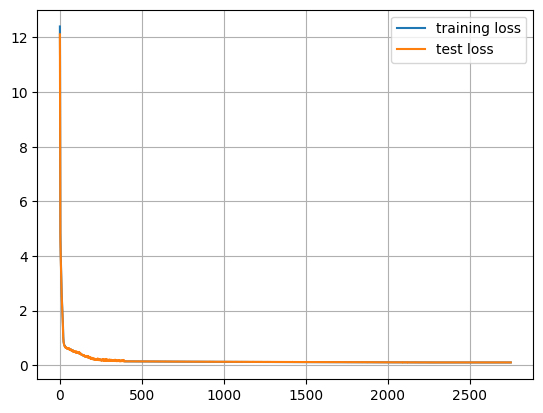

--------------------  EPOCH: 2750  --------------------
LOSS train 0.1035321731120348 valid 0.10563443601131439
--------------------  EPOCH: 2751  --------------------
LOSS train 0.10353145115077496 valid 0.10563450306653976
--------------------  EPOCH: 2752  --------------------
LOSS train 0.10355776026844979 valid 0.10563485324382782
--------------------  EPOCH: 2753  --------------------
LOSS train 0.10359403751790523 valid 0.10563407093286514
--------------------  EPOCH: 2754  --------------------
LOSS train 0.10356476977467537 valid 0.10563402622938156
--------------------  EPOCH: 2755  --------------------
LOSS train 0.10356454774737359 valid 0.10563457012176514
--------------------  EPOCH: 2756  --------------------
LOSS train 0.10364333875477313 valid 0.10563424974679947
--------------------  EPOCH: 2757  --------------------
LOSS train 0.10355849117040634 valid 0.10563419759273529
--------------------  EPOCH: 2758  --------------------
LOSS train 0.10352584682404994 valid 0.10

LOSS train 0.10350110158324241 valid 0.10563249886035919
--------------------  EPOCH: 2824  --------------------
LOSS train 0.10364678502082825 valid 0.1056322529911995
--------------------  EPOCH: 2825  --------------------
LOSS train 0.10355897024273872 valid 0.10563268512487411
--------------------  EPOCH: 2826  --------------------
LOSS train 0.10368769094347954 valid 0.10563237965106964
--------------------  EPOCH: 2827  --------------------
LOSS train 0.10363955646753312 valid 0.10563216358423233
--------------------  EPOCH: 2828  --------------------
LOSS train 0.10346639566123486 valid 0.10563283413648605
--------------------  EPOCH: 2829  --------------------
LOSS train 0.10370710529386998 valid 0.10563283413648605
--------------------  EPOCH: 2830  --------------------
LOSS train 0.10362596735358238 valid 0.10563240200281143
--------------------  EPOCH: 2831  --------------------
LOSS train 0.10354421325027943 valid 0.10563283413648605
--------------------  EPOCH: 2832  -----

LOSS train 0.10357855185866356 valid 0.10563024878501892
--------------------  EPOCH: 2897  --------------------
LOSS train 0.10358244515955448 valid 0.10563002526760101
--------------------  EPOCH: 2898  --------------------
LOSS train 0.10353844128549099 valid 0.10563087463378906
--------------------  EPOCH: 2899  --------------------
LOSS train 0.10354855582118035 valid 0.10563048720359802
--------------------  EPOCH: 2900  --------------------
LOSS train 0.10357497297227383 valid 0.10563088953495026
--------------------  EPOCH: 2901  --------------------
LOSS train 0.10357581079006195 valid 0.10563015937805176
--------------------  EPOCH: 2902  --------------------
LOSS train 0.10359579734504223 valid 0.1056305468082428
--------------------  EPOCH: 2903  --------------------
LOSS train 0.10358870960772038 valid 0.10562986135482788
--------------------  EPOCH: 2904  --------------------
LOSS train 0.10347209013998508 valid 0.10563041269779205
--------------------  EPOCH: 2905  -----

LOSS train 0.10354539081454277 valid 0.10562832653522491
--------------------  EPOCH: 2970  --------------------
LOSS train 0.10360314883291721 valid 0.10562848299741745
--------------------  EPOCH: 2971  --------------------
LOSS train 0.10356500744819641 valid 0.10562892258167267
--------------------  EPOCH: 2972  --------------------
LOSS train 0.10343396440148353 valid 0.10562816262245178
--------------------  EPOCH: 2973  --------------------
LOSS train 0.10361668206751347 valid 0.10562898963689804
--------------------  EPOCH: 2974  --------------------
LOSS train 0.10354931652545929 valid 0.10562828183174133
--------------------  EPOCH: 2975  --------------------
LOSS train 0.10354608930647373 valid 0.10562878102064133
--------------------  EPOCH: 2976  --------------------
LOSS train 0.10353087894618511 valid 0.10562791675329208
--------------------  EPOCH: 2977  --------------------
LOSS train 0.10353174284100533 valid 0.10562902688980103
--------------------  EPOCH: 2978  ----

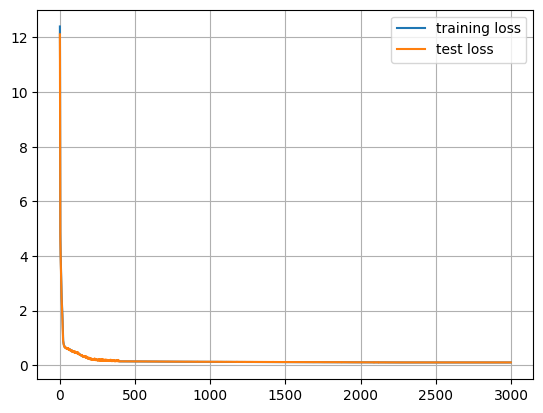

--------------------  EPOCH: 3000  --------------------
LOSS train 0.10360200107097625 valid 0.10562764108181
--------------------  EPOCH: 3001  --------------------
LOSS train 0.10358137413859367 valid 0.10562803596258163
--------------------  EPOCH: 3002  --------------------
LOSS train 0.10351847968995571 valid 0.10562784224748611
--------------------  EPOCH: 3003  --------------------
LOSS train 0.10359953418374061 valid 0.1056276336312294
--------------------  EPOCH: 3004  --------------------
LOSS train 0.1035954263061285 valid 0.10562682151794434
--------------------  EPOCH: 3005  --------------------
LOSS train 0.10361699797213078 valid 0.10562778264284134
--------------------  EPOCH: 3006  --------------------
LOSS train 0.1035390131175518 valid 0.10562745481729507
--------------------  EPOCH: 3007  --------------------
LOSS train 0.10365736000239849 valid 0.10562743246555328
--------------------  EPOCH: 3008  --------------------
LOSS train 0.10359139405190945 valid 0.1056274

LOSS train 0.10352343991398812 valid 0.10562632977962494
--------------------  EPOCH: 3074  --------------------
LOSS train 0.10360566340386868 valid 0.10562635958194733
--------------------  EPOCH: 3075  --------------------
LOSS train 0.10352327413856983 valid 0.10562607645988464
--------------------  EPOCH: 3076  --------------------
LOSS train 0.10355491042137147 valid 0.1056261882185936
--------------------  EPOCH: 3077  --------------------
LOSS train 0.10353981740772725 valid 0.1056261956691742
--------------------  EPOCH: 3078  --------------------
LOSS train 0.10356619171798229 valid 0.10562529414892197
--------------------  EPOCH: 3079  --------------------
LOSS train 0.10346933342516422 valid 0.10562591999769211
--------------------  EPOCH: 3080  --------------------
LOSS train 0.10347264967858791 valid 0.10562571883201599
--------------------  EPOCH: 3081  --------------------
LOSS train 0.10357996635138988 valid 0.10562589019536972
--------------------  EPOCH: 3082  ------

LOSS train 0.10346638672053814 valid 0.10562404245138168
--------------------  EPOCH: 3147  --------------------
LOSS train 0.10344783402979374 valid 0.10562366992235184
--------------------  EPOCH: 3148  --------------------
LOSS train 0.10355406813323498 valid 0.10562391579151154
--------------------  EPOCH: 3149  --------------------
LOSS train 0.10354173816740513 valid 0.105623759329319
--------------------  EPOCH: 3150  --------------------
LOSS train 0.10361648499965667 valid 0.10562434792518616
--------------------  EPOCH: 3151  --------------------
LOSS train 0.10359981469810009 valid 0.10562407970428467
--------------------  EPOCH: 3152  --------------------
LOSS train 0.10357013493776321 valid 0.10562431812286377
--------------------  EPOCH: 3153  --------------------
LOSS train 0.1036062117666006 valid 0.10562440752983093
--------------------  EPOCH: 3154  --------------------
LOSS train 0.10365703105926513 valid 0.10562451928853989
--------------------  EPOCH: 3155  -------

LOSS train 0.10362477377057075 valid 0.10562164336442947
--------------------  EPOCH: 3220  --------------------
LOSS train 0.10358216613531113 valid 0.10562174767255783
--------------------  EPOCH: 3221  --------------------
LOSS train 0.10354525446891785 valid 0.10562199354171753
--------------------  EPOCH: 3222  --------------------
LOSS train 0.10348462760448456 valid 0.10562179982662201
--------------------  EPOCH: 3223  --------------------
LOSS train 0.10357987508177757 valid 0.10562121123075485
--------------------  EPOCH: 3224  --------------------
LOSS train 0.10355021804571152 valid 0.1056213527917862
--------------------  EPOCH: 3225  --------------------
LOSS train 0.10359772220253945 valid 0.10562174767255783
--------------------  EPOCH: 3226  --------------------
LOSS train 0.10354909040033818 valid 0.10562188923358917
--------------------  EPOCH: 3227  --------------------
LOSS train 0.10357639528810977 valid 0.10562174767255783
--------------------  EPOCH: 3228  -----

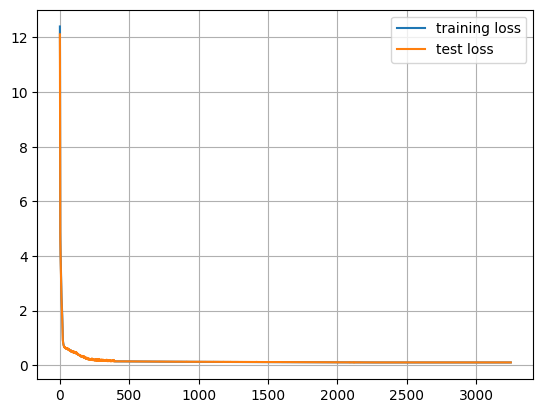

--------------------  EPOCH: 3250  --------------------
LOSS train 0.1034911885857582 valid 0.10562079399824142
--------------------  EPOCH: 3251  --------------------
LOSS train 0.1035333514213562 valid 0.1056208461523056
--------------------  EPOCH: 3252  --------------------
LOSS train 0.10354650169610977 valid 0.10562078654766083
--------------------  EPOCH: 3253  --------------------
LOSS train 0.10352438203990459 valid 0.10562139004468918
--------------------  EPOCH: 3254  --------------------
LOSS train 0.10352748297154904 valid 0.10562127828598022
--------------------  EPOCH: 3255  --------------------
LOSS train 0.10361369922757149 valid 0.10562068969011307
--------------------  EPOCH: 3256  --------------------
LOSS train 0.10360717326402664 valid 0.10562097281217575
--------------------  EPOCH: 3257  --------------------
LOSS train 0.10354231968522072 valid 0.10562139004468918
--------------------  EPOCH: 3258  --------------------
LOSS train 0.10357242561876774 valid 0.1056

LOSS train 0.10355955250561237 valid 0.10561931133270264
--------------------  EPOCH: 3324  --------------------
LOSS train 0.10342097133398057 valid 0.10561906546354294
--------------------  EPOCH: 3325  --------------------
LOSS train 0.10341621786355973 valid 0.1056189090013504
--------------------  EPOCH: 3326  --------------------
LOSS train 0.10356777533888817 valid 0.10561905801296234
--------------------  EPOCH: 3327  --------------------
LOSS train 0.10353602394461632 valid 0.1056189015507698
--------------------  EPOCH: 3328  --------------------
LOSS train 0.10356625020503998 valid 0.10561811178922653
--------------------  EPOCH: 3329  --------------------
LOSS train 0.10354380495846272 valid 0.10561925917863846
--------------------  EPOCH: 3330  --------------------
LOSS train 0.10360406301915645 valid 0.10561886429786682
--------------------  EPOCH: 3331  --------------------
LOSS train 0.10359622314572334 valid 0.10561935603618622
--------------------  EPOCH: 3332  ------

LOSS train 0.10361001156270504 valid 0.10561597347259521
--------------------  EPOCH: 3397  --------------------
LOSS train 0.10350925698876381 valid 0.10561623424291611
--------------------  EPOCH: 3398  --------------------
LOSS train 0.10341482199728488 valid 0.10561615228652954
--------------------  EPOCH: 3399  --------------------
LOSS train 0.1035444051027298 valid 0.1056160181760788
--------------------  EPOCH: 3400  --------------------
LOSS train 0.10357420593500137 valid 0.10561692714691162
--------------------  EPOCH: 3401  --------------------
LOSS train 0.10351345986127854 valid 0.10561645030975342
--------------------  EPOCH: 3402  --------------------
LOSS train 0.10361479371786117 valid 0.105616495013237
--------------------  EPOCH: 3403  --------------------
LOSS train 0.10355512723326683 valid 0.10561683028936386
--------------------  EPOCH: 3404  --------------------
LOSS train 0.10353569239377976 valid 0.10561681538820267
--------------------  EPOCH: 3405  --------

LOSS train 0.10351045317947864 valid 0.10561464726924896
--------------------  EPOCH: 3470  --------------------
LOSS train 0.10358638875186443 valid 0.10561510920524597
--------------------  EPOCH: 3471  --------------------
LOSS train 0.10355096310377121 valid 0.1056152805685997
--------------------  EPOCH: 3472  --------------------
LOSS train 0.10350817777216434 valid 0.10561531037092209
--------------------  EPOCH: 3473  --------------------
LOSS train 0.10357815697789192 valid 0.10561503469944
--------------------  EPOCH: 3474  --------------------
LOSS train 0.10351855643093585 valid 0.10561510920524597
--------------------  EPOCH: 3475  --------------------
LOSS train 0.10358668230473995 valid 0.10561428964138031
--------------------  EPOCH: 3476  --------------------
LOSS train 0.10351904965937138 valid 0.10561450570821762
--------------------  EPOCH: 3477  --------------------
LOSS train 0.10351411066949368 valid 0.10561434179544449
--------------------  EPOCH: 3478  --------

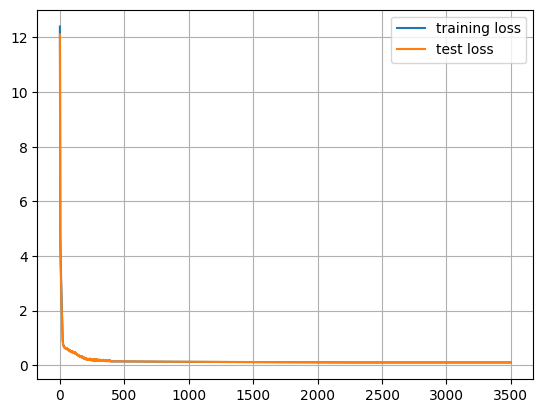

--------------------  EPOCH: 3500  --------------------
LOSS train 0.1035062924027443 valid 0.10561297833919525
--------------------  EPOCH: 3501  --------------------
LOSS train 0.10358042903244495 valid 0.10561391711235046
--------------------  EPOCH: 3502  --------------------
LOSS train 0.10353201106190682 valid 0.10561329126358032
--------------------  EPOCH: 3503  --------------------
LOSS train 0.10352659448981286 valid 0.10561399906873703
--------------------  EPOCH: 3504  --------------------
LOSS train 0.10352725945413113 valid 0.10561393201351166
--------------------  EPOCH: 3505  --------------------
LOSS train 0.1035940807312727 valid 0.10561390221118927
--------------------  EPOCH: 3506  --------------------
LOSS train 0.1035153042525053 valid 0.10561369359493256
--------------------  EPOCH: 3507  --------------------
LOSS train 0.1035475704818964 valid 0.10561419278383255
--------------------  EPOCH: 3508  --------------------
LOSS train 0.10358963534235954 valid 0.10561

LOSS train 0.10353152453899384 valid 0.10561177879571915
--------------------  EPOCH: 3574  --------------------
LOSS train 0.10367981009185315 valid 0.10561241954565048
--------------------  EPOCH: 3575  --------------------
LOSS train 0.10355291403830051 valid 0.10561210662126541
--------------------  EPOCH: 3576  --------------------
LOSS train 0.10352005399763584 valid 0.10561233013868332
--------------------  EPOCH: 3577  --------------------
LOSS train 0.1035522174090147 valid 0.10561209917068481
--------------------  EPOCH: 3578  --------------------
LOSS train 0.10366670042276382 valid 0.10561256855726242
--------------------  EPOCH: 3579  --------------------
LOSS train 0.10347112528979778 valid 0.1056123599410057
--------------------  EPOCH: 3580  --------------------
LOSS train 0.10355864278972149 valid 0.10561168193817139
--------------------  EPOCH: 3581  --------------------
LOSS train 0.10359194800257683 valid 0.10561195760965347
--------------------  EPOCH: 3582  ------

LOSS train 0.10358222834765911 valid 0.1056092381477356
--------------------  EPOCH: 3647  --------------------
LOSS train 0.10351301245391369 valid 0.10560986399650574
--------------------  EPOCH: 3648  --------------------
LOSS train 0.10353830270469189 valid 0.10560952872037888
--------------------  EPOCH: 3649  --------------------
LOSS train 0.10358002483844757 valid 0.1056094691157341
--------------------  EPOCH: 3650  --------------------
LOSS train 0.10353598147630691 valid 0.10560991615056992
--------------------  EPOCH: 3651  --------------------
LOSS train 0.1035362996160984 valid 0.10560895502567291
--------------------  EPOCH: 3652  --------------------
LOSS train 0.10362793654203414 valid 0.10560959577560425
--------------------  EPOCH: 3653  --------------------
LOSS train 0.10349531844258308 valid 0.10560981929302216
--------------------  EPOCH: 3654  --------------------
LOSS train 0.10353235006332398 valid 0.10560984164476395
--------------------  EPOCH: 3655  -------

LOSS train 0.10359223745763302 valid 0.10560766607522964
--------------------  EPOCH: 3720  --------------------
LOSS train 0.10359517894685269 valid 0.10560710728168488
--------------------  EPOCH: 3721  --------------------
LOSS train 0.10343091599643231 valid 0.10560742765665054
--------------------  EPOCH: 3722  --------------------
LOSS train 0.10356711894273758 valid 0.1056075319647789
--------------------  EPOCH: 3723  --------------------
LOSS train 0.1035421270877123 valid 0.10560815036296844
--------------------  EPOCH: 3724  --------------------
LOSS train 0.10353604257106781 valid 0.1056080088019371
--------------------  EPOCH: 3725  --------------------
LOSS train 0.10354191027581691 valid 0.10560768842697144
--------------------  EPOCH: 3726  --------------------
LOSS train 0.1035764642059803 valid 0.10560725629329681
--------------------  EPOCH: 3727  --------------------
LOSS train 0.10357291549444199 valid 0.10560735315084457
--------------------  EPOCH: 3728  --------

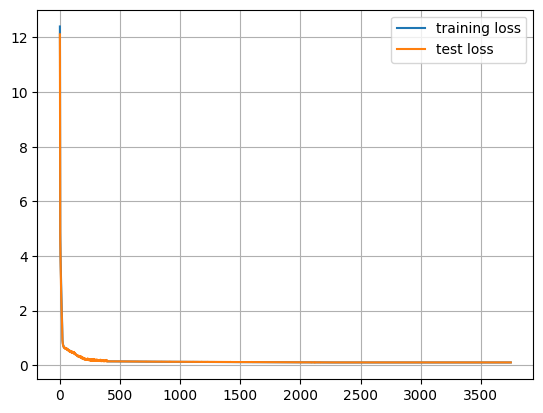

--------------------  EPOCH: 3750  --------------------
LOSS train 0.1034889429807663 valid 0.10560716688632965
--------------------  EPOCH: 3751  --------------------
LOSS train 0.10362729765474796 valid 0.10560689121484756
--------------------  EPOCH: 3752  --------------------
LOSS train 0.10356241650879383 valid 0.10560798645019531
--------------------  EPOCH: 3753  --------------------
LOSS train 0.10347414612770081 valid 0.10560625791549683
--------------------  EPOCH: 3754  --------------------
LOSS train 0.10361379720270633 valid 0.10560674220323563
--------------------  EPOCH: 3755  --------------------
LOSS train 0.10354565531015396 valid 0.10560712963342667
--------------------  EPOCH: 3756  --------------------
LOSS train 0.10347888357937336 valid 0.10560724884271622
--------------------  EPOCH: 3757  --------------------
LOSS train 0.10353691130876541 valid 0.10560719668865204
--------------------  EPOCH: 3758  --------------------
LOSS train 0.10353270471096039 valid 0.10

LOSS train 0.103507499396801 valid 0.10560567677021027
--------------------  EPOCH: 3824  --------------------
LOSS train 0.10357659123837948 valid 0.1056046187877655
--------------------  EPOCH: 3825  --------------------
LOSS train 0.10348726511001587 valid 0.10560531914234161
--------------------  EPOCH: 3826  --------------------
LOSS train 0.10350935570895672 valid 0.10560396313667297
--------------------  EPOCH: 3827  --------------------
LOSS train 0.1036005649715662 valid 0.10560375452041626
--------------------  EPOCH: 3828  --------------------
LOSS train 0.1035413146018982 valid 0.10560397058725357
--------------------  EPOCH: 3829  --------------------
LOSS train 0.10359380394220352 valid 0.10560406744480133
--------------------  EPOCH: 3830  --------------------
LOSS train 0.10358771048486233 valid 0.10560408234596252
--------------------  EPOCH: 3831  --------------------
LOSS train 0.10356945618987083 valid 0.10560577362775803
--------------------  EPOCH: 3832  ---------

LOSS train 0.10344651378691197 valid 0.10560304671525955
--------------------  EPOCH: 3897  --------------------
LOSS train 0.10355528369545937 valid 0.10560207813978195
--------------------  EPOCH: 3898  --------------------
LOSS train 0.103611059486866 valid 0.10560189187526703
--------------------  EPOCH: 3899  --------------------
LOSS train 0.10346544459462166 valid 0.10560275614261627
--------------------  EPOCH: 3900  --------------------
LOSS train 0.10357770510017872 valid 0.10560301691293716
--------------------  EPOCH: 3901  --------------------
LOSS train 0.10352500528097153 valid 0.1056017205119133
--------------------  EPOCH: 3902  --------------------
LOSS train 0.10357330590486527 valid 0.10560236871242523
--------------------  EPOCH: 3903  --------------------
LOSS train 0.10351227186620235 valid 0.10560210049152374
--------------------  EPOCH: 3904  --------------------
LOSS train 0.10371336825191975 valid 0.10560188442468643
--------------------  EPOCH: 3905  -------

LOSS train 0.10362361036241055 valid 0.10560021549463272
--------------------  EPOCH: 3970  --------------------
LOSS train 0.10349428579211235 valid 0.10560005903244019
--------------------  EPOCH: 3971  --------------------
LOSS train 0.10345704667270184 valid 0.10559964925050735
--------------------  EPOCH: 3972  --------------------
LOSS train 0.10349865816533566 valid 0.10560013353824615
--------------------  EPOCH: 3973  --------------------
LOSS train 0.103497464209795 valid 0.10559935867786407
--------------------  EPOCH: 3974  --------------------
LOSS train 0.10355139337480068 valid 0.1055997759103775
--------------------  EPOCH: 3975  --------------------
LOSS train 0.10354513004422188 valid 0.10560057312250137
--------------------  EPOCH: 3976  --------------------
LOSS train 0.10353098921477795 valid 0.10559974610805511
--------------------  EPOCH: 3977  --------------------
LOSS train 0.10352384820580482 valid 0.10559996962547302
--------------------  EPOCH: 3978  -------

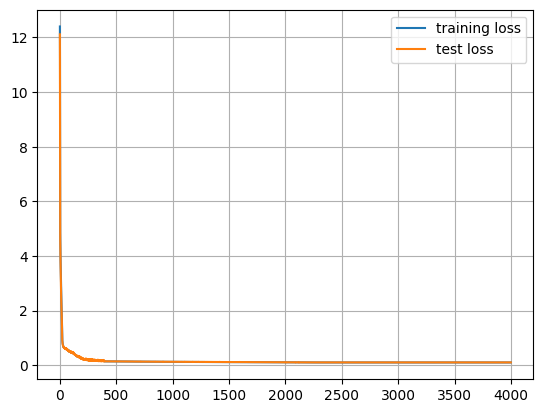

--------------------  EPOCH: 4000  --------------------
LOSS train 0.10362300463020802 valid 0.10559951514005661
--------------------  EPOCH: 4001  --------------------
LOSS train 0.10357006862759591 valid 0.10559914261102676
--------------------  EPOCH: 4002  --------------------
LOSS train 0.10358994901180267 valid 0.10559896379709244
--------------------  EPOCH: 4003  --------------------
LOSS train 0.10357368811964988 valid 0.10559922456741333
--------------------  EPOCH: 4004  --------------------
LOSS train 0.1035469476133585 valid 0.10559917241334915
--------------------  EPOCH: 4005  --------------------
LOSS train 0.10350540056824684 valid 0.1055990606546402
--------------------  EPOCH: 4006  --------------------
LOSS train 0.10349059030413628 valid 0.10559903085231781
--------------------  EPOCH: 4007  --------------------
LOSS train 0.10352740325033664 valid 0.10559922456741333
--------------------  EPOCH: 4008  --------------------
LOSS train 0.10353282615542411 valid 0.105

LOSS train 0.10360809825360776 valid 0.1055971309542656
--------------------  EPOCH: 4074  --------------------
LOSS train 0.10344479456543923 valid 0.10559657216072083
--------------------  EPOCH: 4075  --------------------
LOSS train 0.1035812471061945 valid 0.10559742152690887
--------------------  EPOCH: 4076  --------------------
LOSS train 0.10345536097884178 valid 0.10559745132923126
--------------------  EPOCH: 4077  --------------------
LOSS train 0.10356305874884128 valid 0.10559765994548798
--------------------  EPOCH: 4078  --------------------
LOSS train 0.1036469180136919 valid 0.10559695959091187
--------------------  EPOCH: 4079  --------------------
LOSS train 0.10360471159219742 valid 0.10559675842523575
--------------------  EPOCH: 4080  --------------------
LOSS train 0.10343632362782955 valid 0.10559768974781036
--------------------  EPOCH: 4081  --------------------
LOSS train 0.10356433913111687 valid 0.10559698939323425
--------------------  EPOCH: 4082  -------

LOSS train 0.1034795630723238 valid 0.10559460520744324
--------------------  EPOCH: 4147  --------------------
LOSS train 0.10348108150064945 valid 0.10559564083814621
--------------------  EPOCH: 4148  --------------------
LOSS train 0.10349804796278476 valid 0.10559431463479996
--------------------  EPOCH: 4149  --------------------
LOSS train 0.10349257253110408 valid 0.10559408366680145
--------------------  EPOCH: 4150  --------------------
LOSS train 0.1034815963357687 valid 0.10559508949518204
--------------------  EPOCH: 4151  --------------------
LOSS train 0.10344662927091122 valid 0.10559460520744324
--------------------  EPOCH: 4152  --------------------
LOSS train 0.10350380800664424 valid 0.10559411346912384
--------------------  EPOCH: 4153  --------------------
LOSS train 0.10344777368009091 valid 0.10559458285570145
--------------------  EPOCH: 4154  --------------------
LOSS train 0.10351777002215386 valid 0.10559538751840591
--------------------  EPOCH: 4155  ------

LOSS train 0.10350884273648261 valid 0.10559263080358505
--------------------  EPOCH: 4220  --------------------
LOSS train 0.10348914340138435 valid 0.10559212416410446
--------------------  EPOCH: 4221  --------------------
LOSS train 0.10354093462228775 valid 0.10559363663196564
--------------------  EPOCH: 4222  --------------------
LOSS train 0.10358813740313053 valid 0.10559266805648804
--------------------  EPOCH: 4223  --------------------
LOSS train 0.10352613590657711 valid 0.10559305548667908
--------------------  EPOCH: 4224  --------------------
LOSS train 0.10358583144843578 valid 0.10559283196926117
--------------------  EPOCH: 4225  --------------------
LOSS train 0.1035553302615881 valid 0.10559239983558655
--------------------  EPOCH: 4226  --------------------
LOSS train 0.10351131595671177 valid 0.10559304803609848
--------------------  EPOCH: 4227  --------------------
LOSS train 0.10347135290503502 valid 0.10559236258268356
--------------------  EPOCH: 4228  -----

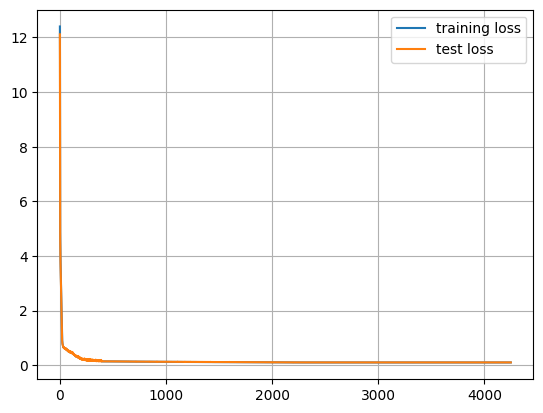

--------------------  EPOCH: 4250  --------------------
LOSS train 0.10358302891254426 valid 0.10559217631816864
--------------------  EPOCH: 4251  --------------------
LOSS train 0.10353417173027993 valid 0.10559211671352386
--------------------  EPOCH: 4252  --------------------
LOSS train 0.10351407788693905 valid 0.10559123754501343
--------------------  EPOCH: 4253  --------------------
LOSS train 0.10353893227875233 valid 0.10559208691120148
--------------------  EPOCH: 4254  --------------------
LOSS train 0.10356098674237728 valid 0.10559207946062088
--------------------  EPOCH: 4255  --------------------
LOSS train 0.10354675129055976 valid 0.10559239238500595
--------------------  EPOCH: 4256  --------------------
LOSS train 0.10350376889109611 valid 0.10559223592281342
--------------------  EPOCH: 4257  --------------------
LOSS train 0.1036178044974804 valid 0.10559204965829849
--------------------  EPOCH: 4258  --------------------
LOSS train 0.10352795198559761 valid 0.10

LOSS train 0.10369319282472134 valid 0.1055896133184433
--------------------  EPOCH: 4324  --------------------
LOSS train 0.10349117144942284 valid 0.1055893823504448
--------------------  EPOCH: 4325  --------------------
LOSS train 0.10358787626028061 valid 0.10558886080980301
--------------------  EPOCH: 4326  --------------------
LOSS train 0.10348736867308617 valid 0.10558931529521942
--------------------  EPOCH: 4327  --------------------
LOSS train 0.10354942567646504 valid 0.10558971017599106
--------------------  EPOCH: 4328  --------------------
LOSS train 0.10349450930953026 valid 0.10558950155973434
--------------------  EPOCH: 4329  --------------------
LOSS train 0.10346783921122552 valid 0.10559049248695374
--------------------  EPOCH: 4330  --------------------
LOSS train 0.10354177542030811 valid 0.10558971762657166
--------------------  EPOCH: 4331  --------------------
LOSS train 0.10350824408233165 valid 0.10559002310037613
--------------------  EPOCH: 4332  ------

LOSS train 0.10349027551710606 valid 0.10558734834194183
--------------------  EPOCH: 4397  --------------------
LOSS train 0.10341584086418151 valid 0.10558652132749557
--------------------  EPOCH: 4398  --------------------
LOSS train 0.10360924825072289 valid 0.10558685660362244
--------------------  EPOCH: 4399  --------------------
LOSS train 0.10353733748197555 valid 0.10558748245239258
--------------------  EPOCH: 4400  --------------------
LOSS train 0.10359997227787972 valid 0.10558734089136124
--------------------  EPOCH: 4401  --------------------
LOSS train 0.103541050106287 valid 0.10558775067329407
--------------------  EPOCH: 4402  --------------------
LOSS train 0.10356972552835941 valid 0.10558786988258362
--------------------  EPOCH: 4403  --------------------
LOSS train 0.10354854576289654 valid 0.10558673739433289
--------------------  EPOCH: 4404  --------------------
LOSS train 0.10353649295866489 valid 0.10558726638555527
--------------------  EPOCH: 4405  ------

LOSS train 0.10347420163452625 valid 0.10558491200208664
--------------------  EPOCH: 4470  --------------------
LOSS train 0.10348168909549713 valid 0.10558527708053589
--------------------  EPOCH: 4471  --------------------
LOSS train 0.10350005961954593 valid 0.10558544844388962
--------------------  EPOCH: 4472  --------------------
LOSS train 0.10357544049620629 valid 0.10558509081602097
--------------------  EPOCH: 4473  --------------------
LOSS train 0.10353525057435035 valid 0.10558472573757172
--------------------  EPOCH: 4474  --------------------
LOSS train 0.10343803688883782 valid 0.1055852621793747
--------------------  EPOCH: 4475  --------------------
LOSS train 0.10349106639623643 valid 0.10558485984802246
--------------------  EPOCH: 4476  --------------------
LOSS train 0.10342584773898125 valid 0.10558425635099411
--------------------  EPOCH: 4477  --------------------
LOSS train 0.1034544713795185 valid 0.10558495670557022
--------------------  EPOCH: 4478  ------

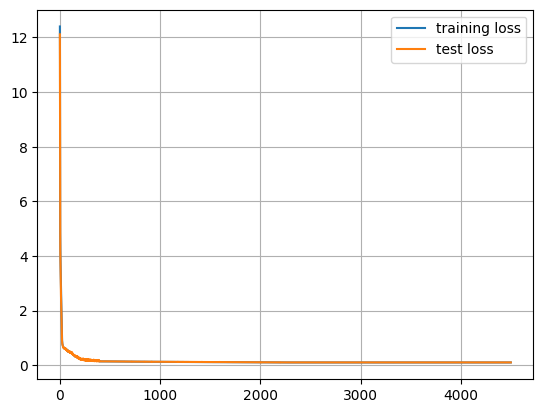

--------------------  EPOCH: 4500  --------------------
LOSS train 0.10343973748385907 valid 0.10558440536260605
--------------------  EPOCH: 4501  --------------------
LOSS train 0.10352469868957996 valid 0.10558431595563889
--------------------  EPOCH: 4502  --------------------
LOSS train 0.10354156494140625 valid 0.10558401048183441
--------------------  EPOCH: 4503  --------------------
LOSS train 0.1034675158560276 valid 0.10558400303125381
--------------------  EPOCH: 4504  --------------------
LOSS train 0.1035415094345808 valid 0.10558398813009262
--------------------  EPOCH: 4505  --------------------
LOSS train 0.10354033894836903 valid 0.10558423399925232
--------------------  EPOCH: 4506  --------------------
LOSS train 0.103567174077034 valid 0.10558529198169708
--------------------  EPOCH: 4507  --------------------
LOSS train 0.10351792573928834 valid 0.10558390617370605
--------------------  EPOCH: 4508  --------------------
LOSS train 0.10351316444575787 valid 0.10558

LOSS train 0.10348958000540734 valid 0.10558192431926727
--------------------  EPOCH: 4574  --------------------
LOSS train 0.10350778698921204 valid 0.10558255761861801
--------------------  EPOCH: 4575  --------------------
LOSS train 0.10340582393109798 valid 0.10558181256055832
--------------------  EPOCH: 4576  --------------------
LOSS train 0.10357839353382588 valid 0.10558266937732697
--------------------  EPOCH: 4577  --------------------
LOSS train 0.10356601886451244 valid 0.10558248311281204
--------------------  EPOCH: 4578  --------------------
LOSS train 0.10355809852480888 valid 0.1055818572640419
--------------------  EPOCH: 4579  --------------------
LOSS train 0.10347243882715702 valid 0.10558248311281204
--------------------  EPOCH: 4580  --------------------
LOSS train 0.1035263143479824 valid 0.10558170825242996
--------------------  EPOCH: 4581  --------------------
LOSS train 0.1034205585718155 valid 0.10558256506919861
--------------------  EPOCH: 4582  -------

LOSS train 0.10346321985125542 valid 0.10558081418275833
--------------------  EPOCH: 4647  --------------------
LOSS train 0.10347045883536339 valid 0.10558018833398819
--------------------  EPOCH: 4648  --------------------
LOSS train 0.10357972681522369 valid 0.10558035969734192
--------------------  EPOCH: 4649  --------------------
LOSS train 0.10351811721920967 valid 0.10558003932237625
--------------------  EPOCH: 4650  --------------------
LOSS train 0.1034784346818924 valid 0.1055799052119255
--------------------  EPOCH: 4651  --------------------
LOSS train 0.10352931581437588 valid 0.10558026283979416
--------------------  EPOCH: 4652  --------------------
LOSS train 0.10349032990634441 valid 0.10558028519153595
--------------------  EPOCH: 4653  --------------------
LOSS train 0.10353699214756489 valid 0.10558032244443893
--------------------  EPOCH: 4654  --------------------
LOSS train 0.10348026901483535 valid 0.10558035224676132
--------------------  EPOCH: 4655  ------

LOSS train 0.10346842296421528 valid 0.10557898133993149
--------------------  EPOCH: 4720  --------------------
LOSS train 0.10355069115757942 valid 0.10557815432548523
--------------------  EPOCH: 4721  --------------------
LOSS train 0.10345832630991936 valid 0.10557809472084045
--------------------  EPOCH: 4722  --------------------
LOSS train 0.10350834466516971 valid 0.10557777434587479
--------------------  EPOCH: 4723  --------------------
LOSS train 0.10359840355813503 valid 0.10557808727025986
--------------------  EPOCH: 4724  --------------------
LOSS train 0.10347171947360038 valid 0.10557781159877777
--------------------  EPOCH: 4725  --------------------
LOSS train 0.10361181274056434 valid 0.10557740181684494
--------------------  EPOCH: 4726  --------------------
LOSS train 0.10355057008564472 valid 0.10557764023542404
--------------------  EPOCH: 4727  --------------------
LOSS train 0.10350632518529893 valid 0.10557793825864792
--------------------  EPOCH: 4728  ----

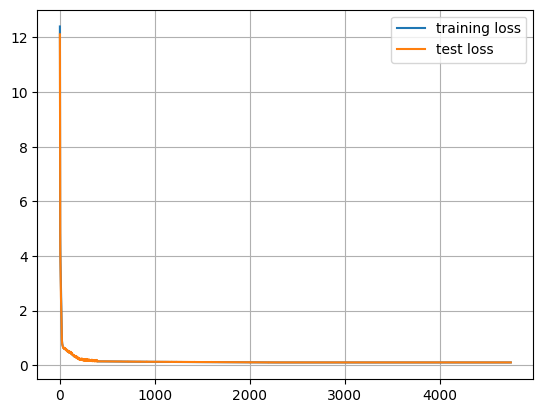

--------------------  EPOCH: 4750  --------------------
LOSS train 0.1034922182559967 valid 0.10557705909013748
--------------------  EPOCH: 4751  --------------------
LOSS train 0.10350257940590382 valid 0.10557732731103897
--------------------  EPOCH: 4752  --------------------
LOSS train 0.10350991934537887 valid 0.1055770218372345
--------------------  EPOCH: 4753  --------------------
LOSS train 0.1034933365881443 valid 0.10557758808135986
--------------------  EPOCH: 4754  --------------------
LOSS train 0.10343240275979042 valid 0.10557722300291061
--------------------  EPOCH: 4755  --------------------
LOSS train 0.1035636156797409 valid 0.10557691007852554
--------------------  EPOCH: 4756  --------------------
LOSS train 0.10348021425306797 valid 0.1055767685174942
--------------------  EPOCH: 4757  --------------------
LOSS train 0.1034703090786934 valid 0.10557637363672256
--------------------  EPOCH: 4758  --------------------
LOSS train 0.10348744392395019 valid 0.1055760

LOSS train 0.10358705818653106 valid 0.10557510703802109
--------------------  EPOCH: 4824  --------------------
LOSS train 0.10356122590601444 valid 0.10557541251182556
--------------------  EPOCH: 4825  --------------------
LOSS train 0.1035018440335989 valid 0.10557467490434647
--------------------  EPOCH: 4826  --------------------
LOSS train 0.10353937670588494 valid 0.10557492077350616
--------------------  EPOCH: 4827  --------------------
LOSS train 0.10348288863897323 valid 0.1055745854973793
--------------------  EPOCH: 4828  --------------------
LOSS train 0.10353197306394576 valid 0.10557438433170319
--------------------  EPOCH: 4829  --------------------
LOSS train 0.1035325676202774 valid 0.10557422786951065
--------------------  EPOCH: 4830  --------------------
LOSS train 0.10350234657526017 valid 0.10557424277067184
--------------------  EPOCH: 4831  --------------------
LOSS train 0.10352274514734745 valid 0.10557429492473602
--------------------  EPOCH: 4832  -------

LOSS train 0.10347599312663078 valid 0.10557329654693604
--------------------  EPOCH: 4897  --------------------
LOSS train 0.10354310609400272 valid 0.10557349771261215
--------------------  EPOCH: 4898  --------------------
LOSS train 0.1034414991736412 valid 0.10557316988706589
--------------------  EPOCH: 4899  --------------------
LOSS train 0.10357964485883712 valid 0.10557294636964798
--------------------  EPOCH: 4900  --------------------
LOSS train 0.1035084705799818 valid 0.10557261109352112
--------------------  EPOCH: 4901  --------------------
LOSS train 0.10342446006834508 valid 0.1055726706981659
--------------------  EPOCH: 4902  --------------------
LOSS train 0.10350295938551426 valid 0.1055728942155838
--------------------  EPOCH: 4903  --------------------
LOSS train 0.10347544997930527 valid 0.10557311028242111
--------------------  EPOCH: 4904  --------------------
LOSS train 0.10350551232695579 valid 0.10557235777378082
--------------------  EPOCH: 4905  --------

LOSS train 0.10353151373565198 valid 0.10557083040475845
--------------------  EPOCH: 4970  --------------------
LOSS train 0.10350685231387616 valid 0.10557086765766144
--------------------  EPOCH: 4971  --------------------
LOSS train 0.10342425294220448 valid 0.10557053983211517
--------------------  EPOCH: 4972  --------------------
LOSS train 0.10358950532972813 valid 0.10557100921869278
--------------------  EPOCH: 4973  --------------------
LOSS train 0.103563691675663 valid 0.10557062178850174
--------------------  EPOCH: 4974  --------------------
LOSS train 0.10351087599992752 valid 0.10557100176811218
--------------------  EPOCH: 4975  --------------------
LOSS train 0.1034419797360897 valid 0.1055702418088913
--------------------  EPOCH: 4976  --------------------
LOSS train 0.10352482050657272 valid 0.10557058453559875
--------------------  EPOCH: 4977  --------------------
LOSS train 0.10346251837909222 valid 0.10557109117507935
--------------------  EPOCH: 4978  --------

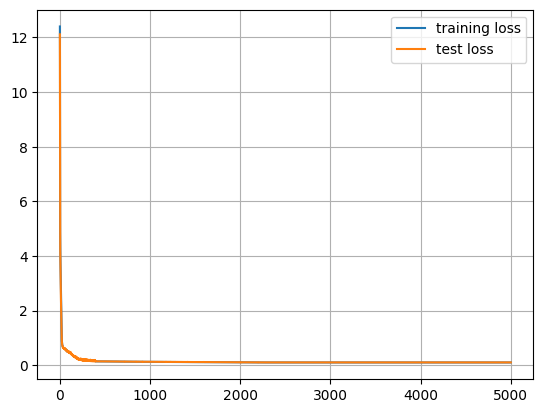

--------------------  EPOCH: 5000  --------------------
LOSS train 0.10353068597614765 valid 0.10556978732347488
--------------------  EPOCH: 5001  --------------------
LOSS train 0.10351070910692214 valid 0.10556970536708832
--------------------  EPOCH: 5002  --------------------
LOSS train 0.10346732921898365 valid 0.10556983202695847
--------------------  EPOCH: 5003  --------------------
LOSS train 0.10345834530889989 valid 0.10556991398334503
--------------------  EPOCH: 5004  --------------------
LOSS train 0.1035113949328661 valid 0.1055702492594719
--------------------  EPOCH: 5005  --------------------
LOSS train 0.10351821593940258 valid 0.1055692657828331
--------------------  EPOCH: 5006  --------------------
LOSS train 0.1036130864173174 valid 0.10556963086128235
--------------------  EPOCH: 5007  --------------------
LOSS train 0.1033902358263731 valid 0.10556990653276443
--------------------  EPOCH: 5008  --------------------
LOSS train 0.10363254174590111 valid 0.105569

LOSS train 0.10351485759019852 valid 0.10556795448064804
--------------------  EPOCH: 5074  --------------------
LOSS train 0.10341986455023289 valid 0.10556738078594208
--------------------  EPOCH: 5075  --------------------
LOSS train 0.10349083393812179 valid 0.10556822270154953
--------------------  EPOCH: 5076  --------------------
LOSS train 0.10342330150306225 valid 0.1055677980184555
--------------------  EPOCH: 5077  --------------------
LOSS train 0.10361683778464795 valid 0.105568066239357
--------------------  EPOCH: 5078  --------------------
LOSS train 0.1034712627530098 valid 0.10556744784116745
--------------------  EPOCH: 5079  --------------------
LOSS train 0.10352127328515053 valid 0.10556711256504059
--------------------  EPOCH: 5080  --------------------
LOSS train 0.10356002077460288 valid 0.10556669533252716
--------------------  EPOCH: 5081  --------------------
LOSS train 0.10350962951779366 valid 0.10556747764348984
--------------------  EPOCH: 5082  --------

LOSS train 0.10346958003938198 valid 0.1055656298995018
--------------------  EPOCH: 5147  --------------------
LOSS train 0.10347852669656277 valid 0.10556529462337494
--------------------  EPOCH: 5148  --------------------
LOSS train 0.10347777158021927 valid 0.10556580871343613
--------------------  EPOCH: 5149  --------------------
LOSS train 0.10355254746973515 valid 0.10556530952453613
--------------------  EPOCH: 5150  --------------------
LOSS train 0.10358202420175075 valid 0.105565644800663
--------------------  EPOCH: 5151  --------------------
LOSS train 0.10351969115436077 valid 0.10556577146053314
--------------------  EPOCH: 5152  --------------------
LOSS train 0.10352737233042716 valid 0.10556581616401672
--------------------  EPOCH: 5153  --------------------
LOSS train 0.10349493362009525 valid 0.1055651381611824
--------------------  EPOCH: 5154  --------------------
LOSS train 0.1034120436757803 valid 0.10556498169898987
--------------------  EPOCH: 5155  ---------

LOSS train 0.103483509644866 valid 0.10556390136480331
--------------------  EPOCH: 5220  --------------------
LOSS train 0.10354221202433109 valid 0.10556447505950928
--------------------  EPOCH: 5221  --------------------
LOSS train 0.10340618416666984 valid 0.10556337237358093
--------------------  EPOCH: 5222  --------------------
LOSS train 0.10358219183981418 valid 0.10556340962648392
--------------------  EPOCH: 5223  --------------------
LOSS train 0.10350192449986935 valid 0.10556286573410034
--------------------  EPOCH: 5224  --------------------
LOSS train 0.10339681133627891 valid 0.1055629625916481
--------------------  EPOCH: 5225  --------------------
LOSS train 0.10350124277174473 valid 0.10556288063526154
--------------------  EPOCH: 5226  --------------------
LOSS train 0.10349548682570457 valid 0.10556349903345108
--------------------  EPOCH: 5227  --------------------
LOSS train 0.10345041006803513 valid 0.10556264221668243
--------------------  EPOCH: 5228  -------

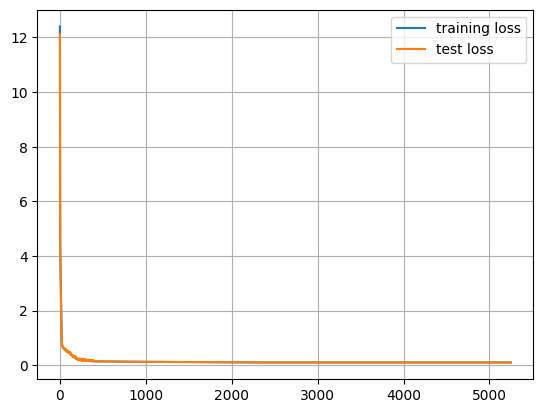

--------------------  EPOCH: 5250  --------------------
LOSS train 0.10356642007827759 valid 0.10556276887655258
--------------------  EPOCH: 5251  --------------------
LOSS train 0.10345261357724667 valid 0.10556289553642273
--------------------  EPOCH: 5252  --------------------
LOSS train 0.1035080000758171 valid 0.10556365549564362
--------------------  EPOCH: 5253  --------------------
LOSS train 0.10356651954352855 valid 0.10556258261203766
--------------------  EPOCH: 5254  --------------------
LOSS train 0.10350594334304333 valid 0.10556260496377945
--------------------  EPOCH: 5255  --------------------
LOSS train 0.10348361358046532 valid 0.10556238144636154
--------------------  EPOCH: 5256  --------------------
LOSS train 0.10350614227354527 valid 0.10556255280971527
--------------------  EPOCH: 5257  --------------------
LOSS train 0.10357333011925221 valid 0.10556206107139587
--------------------  EPOCH: 5258  --------------------
LOSS train 0.10352832861244679 valid 0.10

LOSS train 0.10342569798231124 valid 0.1055602878332138
--------------------  EPOCH: 5324  --------------------
LOSS train 0.10353760644793511 valid 0.10556061565876007
--------------------  EPOCH: 5325  --------------------
LOSS train 0.10349866338074207 valid 0.10556051880121231
--------------------  EPOCH: 5326  --------------------
LOSS train 0.10350169688463211 valid 0.1055605337023735
--------------------  EPOCH: 5327  --------------------
LOSS train 0.10349064283072948 valid 0.10556072741746902
--------------------  EPOCH: 5328  --------------------
LOSS train 0.1035220619291067 valid 0.10556001961231232
--------------------  EPOCH: 5329  --------------------
LOSS train 0.10351321697235108 valid 0.1055602878332138
--------------------  EPOCH: 5330  --------------------
LOSS train 0.1034963883459568 valid 0.1055600568652153
--------------------  EPOCH: 5331  --------------------
LOSS train 0.10343434177339077 valid 0.10555990785360336
--------------------  EPOCH: 5332  ----------

LOSS train 0.10358167290687562 valid 0.10555893927812576
--------------------  EPOCH: 5397  --------------------
LOSS train 0.10349144823849202 valid 0.10555879771709442
--------------------  EPOCH: 5398  --------------------
LOSS train 0.10345525741577148 valid 0.10555824637413025
--------------------  EPOCH: 5399  --------------------
LOSS train 0.10343395471572876 valid 0.10555784404277802
--------------------  EPOCH: 5400  --------------------
LOSS train 0.1034591730684042 valid 0.10555775463581085
--------------------  EPOCH: 5401  --------------------
LOSS train 0.10352707169950008 valid 0.10555808991193771
--------------------  EPOCH: 5402  --------------------
LOSS train 0.10349212922155857 valid 0.10555718094110489
--------------------  EPOCH: 5403  --------------------
LOSS train 0.10351815596222877 valid 0.1055578738451004
--------------------  EPOCH: 5404  --------------------
LOSS train 0.1035349726676941 valid 0.10555781424045563
--------------------  EPOCH: 5405  -------

LOSS train 0.10341069772839546 valid 0.10555554181337357
--------------------  EPOCH: 5470  --------------------
LOSS train 0.10346202552318573 valid 0.1055547446012497
--------------------  EPOCH: 5471  --------------------
LOSS train 0.10353774465620517 valid 0.1055559366941452
--------------------  EPOCH: 5472  --------------------
LOSS train 0.10360187031328678 valid 0.10555587708950043
--------------------  EPOCH: 5473  --------------------
LOSS train 0.1035100307315588 valid 0.10555563867092133
--------------------  EPOCH: 5474  --------------------
LOSS train 0.10350389145314694 valid 0.10555509477853775
--------------------  EPOCH: 5475  --------------------
LOSS train 0.10347168035805225 valid 0.1055559366941452
--------------------  EPOCH: 5476  --------------------
LOSS train 0.10358971320092678 valid 0.10555572062730789
--------------------  EPOCH: 5477  --------------------
LOSS train 0.10349073447287083 valid 0.10555487126111984
--------------------  EPOCH: 5478  --------

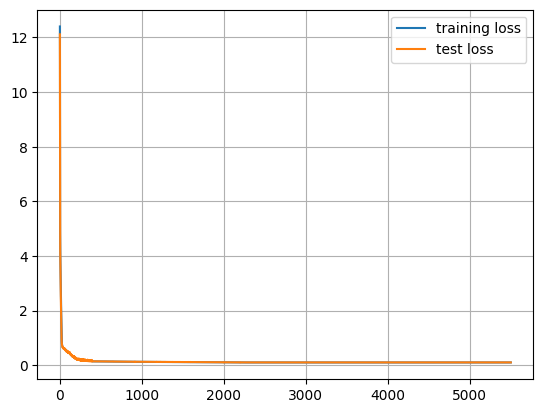

--------------------  EPOCH: 5500  --------------------
LOSS train 0.10346699804067612 valid 0.1055549755692482
--------------------  EPOCH: 5501  --------------------
LOSS train 0.10349844358861446 valid 0.1055552288889885
--------------------  EPOCH: 5502  --------------------
LOSS train 0.10355948209762574 valid 0.10555372387170792
--------------------  EPOCH: 5503  --------------------
LOSS train 0.1034519050270319 valid 0.1055557131767273
--------------------  EPOCH: 5504  --------------------
LOSS train 0.1034155149012804 valid 0.10555459558963776
--------------------  EPOCH: 5505  --------------------
LOSS train 0.10343264751136302 valid 0.10555446147918701
--------------------  EPOCH: 5506  --------------------
LOSS train 0.10343063622713089 valid 0.10555393993854523
--------------------  EPOCH: 5507  --------------------
LOSS train 0.10335782133042812 valid 0.10555432736873627
--------------------  EPOCH: 5508  --------------------
LOSS train 0.10346187129616738 valid 0.105554

LOSS train 0.10348383262753487 valid 0.10555251687765121
--------------------  EPOCH: 5574  --------------------
LOSS train 0.10353627502918243 valid 0.10555271059274673
--------------------  EPOCH: 5575  --------------------
LOSS train 0.1035171840339899 valid 0.10555292665958405
--------------------  EPOCH: 5576  --------------------
LOSS train 0.10352898575365543 valid 0.10555250197649002
--------------------  EPOCH: 5577  --------------------
LOSS train 0.10349378287792206 valid 0.10555235296487808
--------------------  EPOCH: 5578  --------------------
LOSS train 0.10351042449474335 valid 0.10555237531661987
--------------------  EPOCH: 5579  --------------------
LOSS train 0.1033975999802351 valid 0.10555262863636017
--------------------  EPOCH: 5580  --------------------
LOSS train 0.10361025407910347 valid 0.10555212199687958
--------------------  EPOCH: 5581  --------------------
LOSS train 0.10348436534404755 valid 0.10555245727300644
--------------------  EPOCH: 5582  ------

LOSS train 0.10341478064656258 valid 0.10555145144462585
--------------------  EPOCH: 5647  --------------------
LOSS train 0.10360347665846348 valid 0.1055506020784378
--------------------  EPOCH: 5648  --------------------
LOSS train 0.1035338968038559 valid 0.10555034130811691
--------------------  EPOCH: 5649  --------------------
LOSS train 0.10341856405138969 valid 0.10555010288953781
--------------------  EPOCH: 5650  --------------------
LOSS train 0.10348460897803306 valid 0.10555028170347214
--------------------  EPOCH: 5651  --------------------
LOSS train 0.10341455936431884 valid 0.10555052757263184
--------------------  EPOCH: 5652  --------------------
LOSS train 0.10352889448404312 valid 0.10555043816566467
--------------------  EPOCH: 5653  --------------------
LOSS train 0.10356774590909482 valid 0.10555045306682587
--------------------  EPOCH: 5654  --------------------
LOSS train 0.10353015065193176 valid 0.10555054247379303
--------------------  EPOCH: 5655  ------

LOSS train 0.10344294458627701 valid 0.10554823279380798
--------------------  EPOCH: 5720  --------------------
LOSS train 0.10344178192317485 valid 0.10554848611354828
--------------------  EPOCH: 5721  --------------------
LOSS train 0.10346127487719059 valid 0.1055482029914856
--------------------  EPOCH: 5722  --------------------
LOSS train 0.10352550782263278 valid 0.1055489256978035
--------------------  EPOCH: 5723  --------------------
LOSS train 0.10347342751920223 valid 0.10554877668619156
--------------------  EPOCH: 5724  --------------------
LOSS train 0.10351749360561371 valid 0.10554822534322739
--------------------  EPOCH: 5725  --------------------
LOSS train 0.10352048985660076 valid 0.10554856806993484
--------------------  EPOCH: 5726  --------------------
LOSS train 0.10349129363894463 valid 0.10554778575897217
--------------------  EPOCH: 5727  --------------------
LOSS train 0.1034739326685667 valid 0.10554920136928558
--------------------  EPOCH: 5728  -------

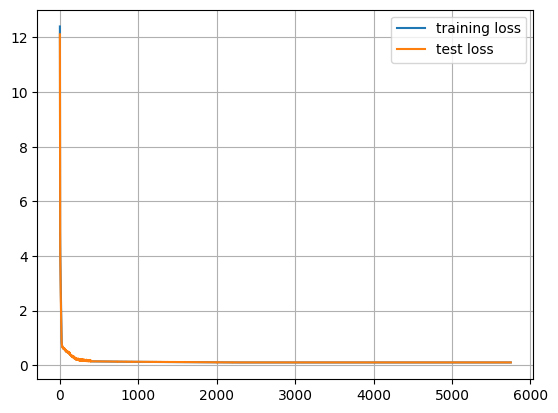

--------------------  EPOCH: 5750  --------------------
LOSS train 0.10344879999756813 valid 0.10554754734039307
--------------------  EPOCH: 5751  --------------------
LOSS train 0.10354862660169602 valid 0.10554716736078262
--------------------  EPOCH: 5752  --------------------
LOSS train 0.10345528312027455 valid 0.10554724186658859
--------------------  EPOCH: 5753  --------------------
LOSS train 0.10339749455451966 valid 0.10554713755846024
--------------------  EPOCH: 5754  --------------------
LOSS train 0.10359122566878795 valid 0.10554733872413635
--------------------  EPOCH: 5755  --------------------
LOSS train 0.10354865789413452 valid 0.10554785281419754
--------------------  EPOCH: 5756  --------------------
LOSS train 0.10352693200111389 valid 0.10554742068052292
--------------------  EPOCH: 5757  --------------------
LOSS train 0.10348413288593292 valid 0.10554718971252441
--------------------  EPOCH: 5758  --------------------
LOSS train 0.10350138954818248 valid 0.1

LOSS train 0.103498899564147 valid 0.10554520040750504
--------------------  EPOCH: 5824  --------------------
LOSS train 0.10345827750861644 valid 0.1055455282330513
--------------------  EPOCH: 5825  --------------------
LOSS train 0.10349618718028068 valid 0.10554499924182892
--------------------  EPOCH: 5826  --------------------
LOSS train 0.10345185883343219 valid 0.10554459691047668
--------------------  EPOCH: 5827  --------------------
LOSS train 0.10345235057175159 valid 0.10554458200931549
--------------------  EPOCH: 5828  --------------------
LOSS train 0.10346333757042885 valid 0.10554499179124832
--------------------  EPOCH: 5829  --------------------
LOSS train 0.10353544875979423 valid 0.1055450439453125
--------------------  EPOCH: 5830  --------------------
LOSS train 0.10341198369860649 valid 0.10554488003253937
--------------------  EPOCH: 5831  --------------------
LOSS train 0.1034333560615778 valid 0.1055440679192543
--------------------  EPOCH: 5832  ----------

LOSS train 0.10343913100659848 valid 0.10554356873035431
--------------------  EPOCH: 5897  --------------------
LOSS train 0.10352413840591908 valid 0.10554339736700058
--------------------  EPOCH: 5898  --------------------
LOSS train 0.10348819419741631 valid 0.1055426150560379
--------------------  EPOCH: 5899  --------------------
LOSS train 0.10350236594676972 valid 0.10554274171590805
--------------------  EPOCH: 5900  --------------------
LOSS train 0.10352761596441269 valid 0.10554355382919312
--------------------  EPOCH: 5901  --------------------
LOSS train 0.10350840240716934 valid 0.10554330050945282
--------------------  EPOCH: 5902  --------------------
LOSS train 0.10343620665371418 valid 0.10554336756467819
--------------------  EPOCH: 5903  --------------------
LOSS train 0.10347953699529171 valid 0.105542853474617
--------------------  EPOCH: 5904  --------------------
LOSS train 0.10342505946755409 valid 0.10554276406764984
--------------------  EPOCH: 5905  -------

LOSS train 0.10343988910317421 valid 0.10554136335849762
--------------------  EPOCH: 5970  --------------------
LOSS train 0.10342453755438327 valid 0.10554080456495285
--------------------  EPOCH: 5971  --------------------
LOSS train 0.10353494063019753 valid 0.10554101318120956
--------------------  EPOCH: 5972  --------------------
LOSS train 0.10357393808662892 valid 0.1055404543876648
--------------------  EPOCH: 5973  --------------------
LOSS train 0.10354397147893905 valid 0.1055404543876648
--------------------  EPOCH: 5974  --------------------
LOSS train 0.10351951532065869 valid 0.1055406779050827
--------------------  EPOCH: 5975  --------------------
LOSS train 0.10345522500574589 valid 0.1055409386754036
--------------------  EPOCH: 5976  --------------------
LOSS train 0.10347311422228814 valid 0.105540432035923
--------------------  EPOCH: 5977  --------------------
LOSS train 0.10343023613095284 valid 0.10554184019565582
--------------------  EPOCH: 5978  ----------

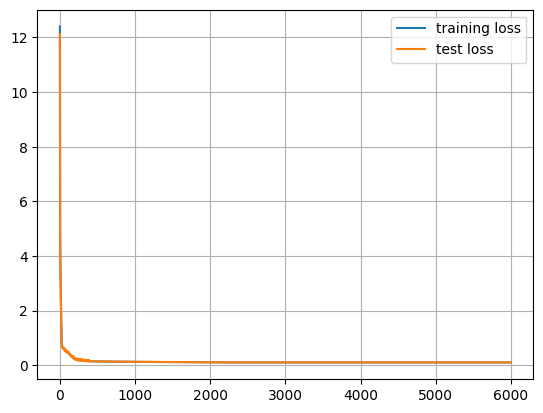

--------------------  EPOCH: 6000  --------------------
LOSS train 0.10354911349713802 valid 0.10553999245166779
--------------------  EPOCH: 6001  --------------------
LOSS train 0.10341911241412163 valid 0.10554008930921555
--------------------  EPOCH: 6002  --------------------
LOSS train 0.10356847792863846 valid 0.10554005950689316
--------------------  EPOCH: 6003  --------------------
LOSS train 0.10338339135050774 valid 0.1055404394865036
--------------------  EPOCH: 6004  --------------------
LOSS train 0.10356366336345672 valid 0.10554046183824539
--------------------  EPOCH: 6005  --------------------
LOSS train 0.10349412709474563 valid 0.10554029047489166
--------------------  EPOCH: 6006  --------------------
LOSS train 0.10350449234247208 valid 0.10553976893424988
--------------------  EPOCH: 6007  --------------------
LOSS train 0.10360241383314132 valid 0.10553967207670212
--------------------  EPOCH: 6008  --------------------
LOSS train 0.10341091156005859 valid 0.10

LOSS train 0.10344285778701305 valid 0.10553783178329468
--------------------  EPOCH: 6074  --------------------
LOSS train 0.10351981036365032 valid 0.10553845763206482
--------------------  EPOCH: 6075  --------------------
LOSS train 0.10344666391611099 valid 0.10553795844316483
--------------------  EPOCH: 6076  --------------------
LOSS train 0.10350846089422702 valid 0.1055382713675499
--------------------  EPOCH: 6077  --------------------
LOSS train 0.10345405228435993 valid 0.10553725808858871
--------------------  EPOCH: 6078  --------------------
LOSS train 0.10344774387776852 valid 0.10553760081529617
--------------------  EPOCH: 6079  --------------------
LOSS train 0.10345206893980503 valid 0.10553717613220215
--------------------  EPOCH: 6080  --------------------
LOSS train 0.10346441678702831 valid 0.10553743690252304
--------------------  EPOCH: 6081  --------------------
LOSS train 0.10342646688222885 valid 0.10553701221942902
--------------------  EPOCH: 6082  -----

LOSS train 0.10345125943422318 valid 0.10553566366434097
--------------------  EPOCH: 6147  --------------------
LOSS train 0.10340195409953594 valid 0.10553639382123947
--------------------  EPOCH: 6148  --------------------
LOSS train 0.10342544540762902 valid 0.1055356040596962
--------------------  EPOCH: 6149  --------------------
LOSS train 0.10349152535200119 valid 0.10553470253944397
--------------------  EPOCH: 6150  --------------------
LOSS train 0.10353000611066818 valid 0.10553590208292007
--------------------  EPOCH: 6151  --------------------
LOSS train 0.10346102304756641 valid 0.10553581267595291
--------------------  EPOCH: 6152  --------------------
LOSS train 0.10354603566229344 valid 0.10553568601608276
--------------------  EPOCH: 6153  --------------------
LOSS train 0.10346838273108006 valid 0.10553553700447083
--------------------  EPOCH: 6154  --------------------
LOSS train 0.10345591939985752 valid 0.10553582012653351
--------------------  EPOCH: 6155  -----

LOSS train 0.10336497090756894 valid 0.10553329437971115
--------------------  EPOCH: 6220  --------------------
LOSS train 0.10351533330976963 valid 0.10553339868783951
--------------------  EPOCH: 6221  --------------------
LOSS train 0.10358963198959828 valid 0.1055336743593216
--------------------  EPOCH: 6222  --------------------
LOSS train 0.10348130725324153 valid 0.10553445667028427
--------------------  EPOCH: 6223  --------------------
LOSS train 0.1035104688256979 valid 0.10553405433893204
--------------------  EPOCH: 6224  --------------------
LOSS train 0.10348654091358185 valid 0.10553400218486786
--------------------  EPOCH: 6225  --------------------
LOSS train 0.10335848107933998 valid 0.10553350299596786
--------------------  EPOCH: 6226  --------------------
LOSS train 0.10350537709891797 valid 0.10553309321403503
--------------------  EPOCH: 6227  --------------------
LOSS train 0.1035208273679018 valid 0.10553333163261414
--------------------  EPOCH: 6228  -------

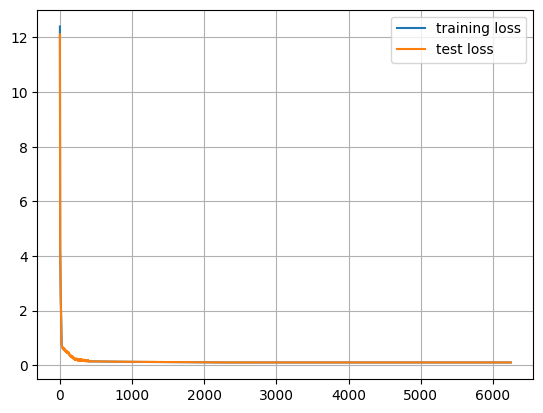

--------------------  EPOCH: 6250  --------------------
LOSS train 0.10345374196767806 valid 0.10553248226642609
--------------------  EPOCH: 6251  --------------------
LOSS train 0.10350021533668041 valid 0.10553297400474548
--------------------  EPOCH: 6252  --------------------
LOSS train 0.10342373065650463 valid 0.10553211718797684
--------------------  EPOCH: 6253  --------------------
LOSS train 0.10348336063325406 valid 0.10553283989429474
--------------------  EPOCH: 6254  --------------------
LOSS train 0.1033967923372984 valid 0.10553346574306488
--------------------  EPOCH: 6255  --------------------
LOSS train 0.10344843156635761 valid 0.10553279519081116
--------------------  EPOCH: 6256  --------------------
LOSS train 0.10342992022633553 valid 0.10553212463855743
--------------------  EPOCH: 6257  --------------------
LOSS train 0.10340746007859707 valid 0.10553225874900818
--------------------  EPOCH: 6258  --------------------
LOSS train 0.10340209193527698 valid 0.10

LOSS train 0.10351632237434387 valid 0.10553067177534103
--------------------  EPOCH: 6324  --------------------
LOSS train 0.1035671379417181 valid 0.10553039610385895
--------------------  EPOCH: 6325  --------------------
LOSS train 0.10351071953773498 valid 0.10553056746721268
--------------------  EPOCH: 6326  --------------------
LOSS train 0.10353573597967625 valid 0.10553018748760223
--------------------  EPOCH: 6327  --------------------
LOSS train 0.10344586782157421 valid 0.10553029924631119
--------------------  EPOCH: 6328  --------------------
LOSS train 0.10344429276883602 valid 0.10553012788295746
--------------------  EPOCH: 6329  --------------------
LOSS train 0.10341999381780624 valid 0.10553056746721268
--------------------  EPOCH: 6330  --------------------
LOSS train 0.10344973728060722 valid 0.10553053021430969
--------------------  EPOCH: 6331  --------------------
LOSS train 0.10345466136932373 valid 0.10552976280450821
--------------------  EPOCH: 6332  -----

LOSS train 0.10347154550254345 valid 0.10552843660116196
--------------------  EPOCH: 6397  --------------------
LOSS train 0.10337652638554573 valid 0.10552837699651718
--------------------  EPOCH: 6398  --------------------
LOSS train 0.10343380123376847 valid 0.10552773624658585
--------------------  EPOCH: 6399  --------------------
LOSS train 0.10345007553696632 valid 0.10552781075239182
--------------------  EPOCH: 6400  --------------------
LOSS train 0.10341825857758521 valid 0.10552819818258286
--------------------  EPOCH: 6401  --------------------
LOSS train 0.10344883464276791 valid 0.10552815347909927
--------------------  EPOCH: 6402  --------------------
LOSS train 0.10348516218364238 valid 0.10552771389484406
--------------------  EPOCH: 6403  --------------------
LOSS train 0.10340812467038632 valid 0.10552814602851868
--------------------  EPOCH: 6404  --------------------
LOSS train 0.10360365472733975 valid 0.10552864521741867
--------------------  EPOCH: 6405  ----

LOSS train 0.10342466197907925 valid 0.10552537441253662
--------------------  EPOCH: 6470  --------------------
LOSS train 0.10343682467937469 valid 0.10552561283111572
--------------------  EPOCH: 6471  --------------------
LOSS train 0.10346570611000061 valid 0.1055258959531784
--------------------  EPOCH: 6472  --------------------
LOSS train 0.10347604118287564 valid 0.10552581399679184
--------------------  EPOCH: 6473  --------------------
LOSS train 0.10343437530100345 valid 0.10552525520324707
--------------------  EPOCH: 6474  --------------------
LOSS train 0.10356417000293731 valid 0.10552608221769333
--------------------  EPOCH: 6475  --------------------
LOSS train 0.10347056724131107 valid 0.10552656650543213
--------------------  EPOCH: 6476  --------------------
LOSS train 0.10349163226783276 valid 0.10552608221769333
--------------------  EPOCH: 6477  --------------------
LOSS train 0.10340203568339348 valid 0.10552570223808289
--------------------  EPOCH: 6478  -----

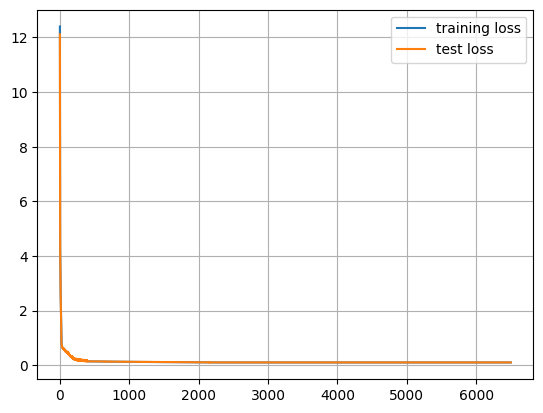

--------------------  EPOCH: 6500  --------------------
LOSS train 0.10344728603959083 valid 0.10552481561899185
--------------------  EPOCH: 6501  --------------------
LOSS train 0.10347111448645592 valid 0.10552488267421722
--------------------  EPOCH: 6502  --------------------
LOSS train 0.10350992605090141 valid 0.10552512109279633
--------------------  EPOCH: 6503  --------------------
LOSS train 0.10343886315822601 valid 0.10552483797073364
--------------------  EPOCH: 6504  --------------------
LOSS train 0.10343256741762161 valid 0.10552456229925156
--------------------  EPOCH: 6505  --------------------
LOSS train 0.10340675301849842 valid 0.10552478581666946
--------------------  EPOCH: 6506  --------------------
LOSS train 0.10351527333259583 valid 0.10552451759576797
--------------------  EPOCH: 6507  --------------------
LOSS train 0.10344838574528695 valid 0.10552427917718887
--------------------  EPOCH: 6508  --------------------
LOSS train 0.10352551378309727 valid 0.1

LOSS train 0.10345920622348785 valid 0.10552289336919785
--------------------  EPOCH: 6574  --------------------
LOSS train 0.1034422155469656 valid 0.10552266240119934
--------------------  EPOCH: 6575  --------------------
LOSS train 0.10346092917025089 valid 0.10552316159009933
--------------------  EPOCH: 6576  --------------------
LOSS train 0.10353177040815353 valid 0.10552290827035904
--------------------  EPOCH: 6577  --------------------
LOSS train 0.10342860706150532 valid 0.10552229732275009
--------------------  EPOCH: 6578  --------------------
LOSS train 0.10343898460268974 valid 0.10552233457565308
--------------------  EPOCH: 6579  --------------------
LOSS train 0.10341901890933514 valid 0.10552247613668442
--------------------  EPOCH: 6580  --------------------
LOSS train 0.10343461818993091 valid 0.10552238672971725
--------------------  EPOCH: 6581  --------------------
LOSS train 0.10343600511550903 valid 0.10552266985177994
--------------------  EPOCH: 6582  -----

LOSS train 0.1035047110170126 valid 0.1055203452706337
--------------------  EPOCH: 6647  --------------------
LOSS train 0.1034919150173664 valid 0.1055208221077919
--------------------  EPOCH: 6648  --------------------
LOSS train 0.10341360978782177 valid 0.10552036762237549
--------------------  EPOCH: 6649  --------------------
LOSS train 0.10351205617189407 valid 0.10552071779966354
--------------------  EPOCH: 6650  --------------------
LOSS train 0.10343609750270844 valid 0.10552044212818146
--------------------  EPOCH: 6651  --------------------
LOSS train 0.10348055027425289 valid 0.10552047193050385
--------------------  EPOCH: 6652  --------------------
LOSS train 0.10346089862287045 valid 0.10552087426185608
--------------------  EPOCH: 6653  --------------------
LOSS train 0.10345399677753449 valid 0.10552011430263519
--------------------  EPOCH: 6654  --------------------
LOSS train 0.10340483970940113 valid 0.10552041977643967
--------------------  EPOCH: 6655  --------

LOSS train 0.10343582183122635 valid 0.10551855713129044
--------------------  EPOCH: 6720  --------------------
LOSS train 0.10345979705452919 valid 0.10551749169826508
--------------------  EPOCH: 6721  --------------------
LOSS train 0.10344238132238388 valid 0.10551807284355164
--------------------  EPOCH: 6722  --------------------
LOSS train 0.10343773439526557 valid 0.10551849007606506
--------------------  EPOCH: 6723  --------------------
LOSS train 0.10341718532145024 valid 0.10551843792200089
--------------------  EPOCH: 6724  --------------------
LOSS train 0.10340093895792961 valid 0.105519138276577
--------------------  EPOCH: 6725  --------------------
LOSS train 0.10344977639615535 valid 0.1055179312825203
--------------------  EPOCH: 6726  --------------------
LOSS train 0.1033988706767559 valid 0.10551901161670685
--------------------  EPOCH: 6727  --------------------
LOSS train 0.10346725843846798 valid 0.1055181622505188
--------------------  EPOCH: 6728  ---------

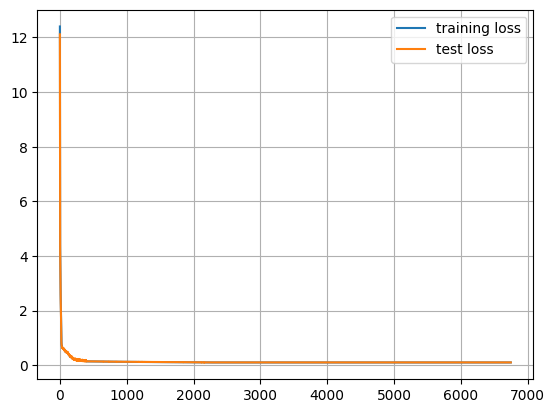

--------------------  EPOCH: 6750  --------------------
LOSS train 0.10336015820503235 valid 0.1055174171924591
--------------------  EPOCH: 6751  --------------------
LOSS train 0.10352978743612766 valid 0.10551775991916656
--------------------  EPOCH: 6752  --------------------
LOSS train 0.10350018888711929 valid 0.10551767796278
--------------------  EPOCH: 6753  --------------------
LOSS train 0.10339700467884541 valid 0.10551737248897552
--------------------  EPOCH: 6754  --------------------
LOSS train 0.10354546457529068 valid 0.10551780462265015
--------------------  EPOCH: 6755  --------------------
LOSS train 0.10353811420500278 valid 0.10551705211400986
--------------------  EPOCH: 6756  --------------------
LOSS train 0.1035087313503027 valid 0.10551755875349045
--------------------  EPOCH: 6757  --------------------
LOSS train 0.10345362275838851 valid 0.1055179238319397
--------------------  EPOCH: 6758  --------------------
LOSS train 0.10345197059214115 valid 0.1055173

LOSS train 0.10347888842225075 valid 0.10551535338163376
--------------------  EPOCH: 6824  --------------------
LOSS train 0.10349029414355755 valid 0.10551463067531586
--------------------  EPOCH: 6825  --------------------
LOSS train 0.10339679345488548 valid 0.10551557689905167
--------------------  EPOCH: 6826  --------------------
LOSS train 0.10345121324062348 valid 0.10551536083221436
--------------------  EPOCH: 6827  --------------------
LOSS train 0.10342720933258534 valid 0.10551563650369644
--------------------  EPOCH: 6828  --------------------
LOSS train 0.10342233702540397 valid 0.10551545768976212
--------------------  EPOCH: 6829  --------------------
LOSS train 0.10347440652549267 valid 0.105514757335186
--------------------  EPOCH: 6830  --------------------
LOSS train 0.10348861776292324 valid 0.10551530122756958
--------------------  EPOCH: 6831  --------------------
LOSS train 0.10336543619632721 valid 0.10551539808511734
--------------------  EPOCH: 6832  ------

LOSS train 0.10351286716759205 valid 0.1055133044719696
--------------------  EPOCH: 6897  --------------------
LOSS train 0.10349495187401772 valid 0.10551288723945618
--------------------  EPOCH: 6898  --------------------
LOSS train 0.10340682491660118 valid 0.10551300644874573
--------------------  EPOCH: 6899  --------------------
LOSS train 0.10341680869460106 valid 0.10551253706216812
--------------------  EPOCH: 6900  --------------------
LOSS train 0.10338239297270775 valid 0.10551273822784424
--------------------  EPOCH: 6901  --------------------
LOSS train 0.1033799521625042 valid 0.10551320761442184
--------------------  EPOCH: 6902  --------------------
LOSS train 0.10334429182112218 valid 0.1055133193731308
--------------------  EPOCH: 6903  --------------------
LOSS train 0.10344028100371361 valid 0.10551313310861588
--------------------  EPOCH: 6904  --------------------
LOSS train 0.1034660752862692 valid 0.1055125743150711
--------------------  EPOCH: 6905  ---------

LOSS train 0.10355875231325626 valid 0.10551129281520844
--------------------  EPOCH: 6970  --------------------
LOSS train 0.10340433977544308 valid 0.10551054775714874
--------------------  EPOCH: 6971  --------------------
LOSS train 0.10342181548476219 valid 0.10551109164953232
--------------------  EPOCH: 6972  --------------------
LOSS train 0.10340552590787411 valid 0.10551062971353531
--------------------  EPOCH: 6973  --------------------
LOSS train 0.10349901542067527 valid 0.10551062971353531
--------------------  EPOCH: 6974  --------------------
LOSS train 0.10340745933353901 valid 0.10551119595766068
--------------------  EPOCH: 6975  --------------------
LOSS train 0.10348133333027362 valid 0.10551140457391739
--------------------  EPOCH: 6976  --------------------
LOSS train 0.10346211679279804 valid 0.1055108904838562
--------------------  EPOCH: 6977  --------------------
LOSS train 0.10351887755095959 valid 0.10551129281520844
--------------------  EPOCH: 6978  -----

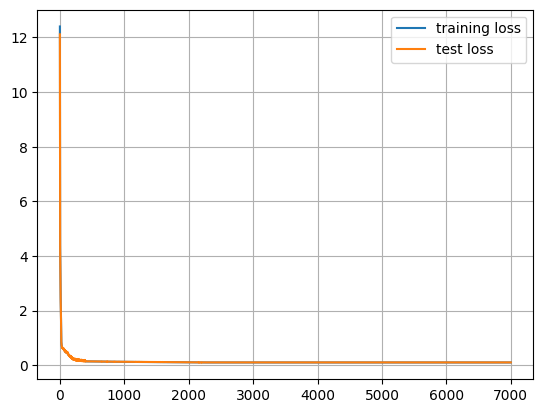

--------------------  EPOCH: 7000  --------------------
LOSS train 0.10347415879368782 valid 0.10550971329212189
--------------------  EPOCH: 7001  --------------------
LOSS train 0.10334986634552479 valid 0.10550999641418457
--------------------  EPOCH: 7002  --------------------
LOSS train 0.10339569710195065 valid 0.10550983250141144
--------------------  EPOCH: 7003  --------------------
LOSS train 0.10350891388952732 valid 0.10551054775714874
--------------------  EPOCH: 7004  --------------------
LOSS train 0.10343639850616455 valid 0.10550963133573532
--------------------  EPOCH: 7005  --------------------
LOSS train 0.10344398654997349 valid 0.10551013797521591
--------------------  EPOCH: 7006  --------------------
LOSS train 0.10337970517575741 valid 0.10551026463508606
--------------------  EPOCH: 7007  --------------------
LOSS train 0.10342815779149532 valid 0.10550952702760696
--------------------  EPOCH: 7008  --------------------
LOSS train 0.1034029919654131 valid 0.10

LOSS train 0.10349336192011833 valid 0.10550849139690399
--------------------  EPOCH: 7074  --------------------
LOSS train 0.10344916507601738 valid 0.1055082231760025
--------------------  EPOCH: 7075  --------------------
LOSS train 0.10346790477633476 valid 0.10550903528928757
--------------------  EPOCH: 7076  --------------------
LOSS train 0.10338484607636929 valid 0.10550788044929504
--------------------  EPOCH: 7077  --------------------
LOSS train 0.10340086296200753 valid 0.10550839453935623
--------------------  EPOCH: 7078  --------------------
LOSS train 0.10348764695227146 valid 0.10550829768180847
--------------------  EPOCH: 7079  --------------------
LOSS train 0.10337743982672691 valid 0.10550735145807266
--------------------  EPOCH: 7080  --------------------
LOSS train 0.10350732430815697 valid 0.10550779849290848
--------------------  EPOCH: 7081  --------------------
LOSS train 0.10336783789098263 valid 0.1055075153708458
--------------------  EPOCH: 7082  ------

LOSS train 0.10343126282095909 valid 0.10550528019666672
--------------------  EPOCH: 7147  --------------------
LOSS train 0.10335633158683777 valid 0.1055055633187294
--------------------  EPOCH: 7148  --------------------
LOSS train 0.10344072058796883 valid 0.10550528019666672
--------------------  EPOCH: 7149  --------------------
LOSS train 0.10350119099020957 valid 0.1055058017373085
--------------------  EPOCH: 7150  --------------------
LOSS train 0.10351125039160251 valid 0.10550568252801895
--------------------  EPOCH: 7151  --------------------
LOSS train 0.10341377668082714 valid 0.10550642758607864
--------------------  EPOCH: 7152  --------------------
LOSS train 0.10347539857029915 valid 0.1055055782198906
--------------------  EPOCH: 7153  --------------------
LOSS train 0.10343714654445649 valid 0.10550551861524582
--------------------  EPOCH: 7154  --------------------
LOSS train 0.10340940989553929 valid 0.10550538450479507
--------------------  EPOCH: 7155  -------

LOSS train 0.10342065878212452 valid 0.10550343245267868
--------------------  EPOCH: 7220  --------------------
LOSS train 0.1035010952502489 valid 0.1055041253566742
--------------------  EPOCH: 7221  --------------------
LOSS train 0.10343676134943962 valid 0.10550437867641449
--------------------  EPOCH: 7222  --------------------
LOSS train 0.10350359492003917 valid 0.10550335049629211
--------------------  EPOCH: 7223  --------------------
LOSS train 0.10345046818256379 valid 0.10550299286842346
--------------------  EPOCH: 7224  --------------------
LOSS train 0.10347900912165642 valid 0.10550326853990555
--------------------  EPOCH: 7225  --------------------
LOSS train 0.10344915986061096 valid 0.10550354421138763
--------------------  EPOCH: 7226  --------------------
LOSS train 0.1033800907433033 valid 0.10550357401371002
--------------------  EPOCH: 7227  --------------------
LOSS train 0.10343898609280586 valid 0.10550466179847717
--------------------  EPOCH: 7228  -------

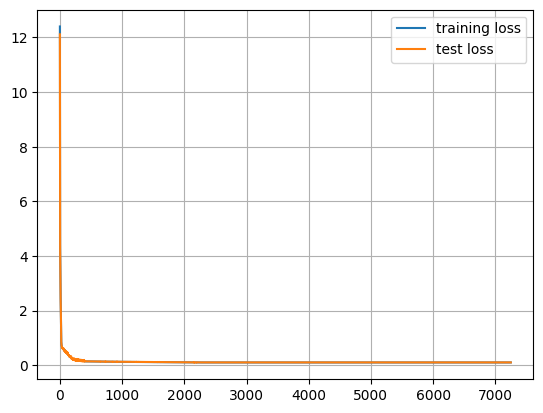

--------------------  EPOCH: 7250  --------------------
LOSS train 0.10353494174778462 valid 0.10550300031900406
--------------------  EPOCH: 7251  --------------------
LOSS train 0.10352282337844372 valid 0.10550329834222794
--------------------  EPOCH: 7252  --------------------
LOSS train 0.10346758216619492 valid 0.10550295561552048
--------------------  EPOCH: 7253  --------------------
LOSS train 0.10348751023411751 valid 0.10550272464752197
--------------------  EPOCH: 7254  --------------------
LOSS train 0.10353594198822975 valid 0.10550329089164734
--------------------  EPOCH: 7255  --------------------
LOSS train 0.10356771610677243 valid 0.10550269484519958
--------------------  EPOCH: 7256  --------------------
LOSS train 0.10343985855579377 valid 0.10550372302532196
--------------------  EPOCH: 7257  --------------------
LOSS train 0.10344001092016697 valid 0.10550236701965332
--------------------  EPOCH: 7258  --------------------
LOSS train 0.10340054780244827 valid 0.1

LOSS train 0.10337476916611195 valid 0.10550044476985931
--------------------  EPOCH: 7324  --------------------
LOSS train 0.10345555543899536 valid 0.10550060868263245
--------------------  EPOCH: 7325  --------------------
LOSS train 0.10333945974707603 valid 0.1055009514093399
--------------------  EPOCH: 7326  --------------------
LOSS train 0.10337035804986953 valid 0.10550019890069962
--------------------  EPOCH: 7327  --------------------
LOSS train 0.10344057120382785 valid 0.10550020635128021
--------------------  EPOCH: 7328  --------------------
LOSS train 0.10341513454914093 valid 0.10550043731927872
--------------------  EPOCH: 7329  --------------------
LOSS train 0.1036050871014595 valid 0.1055002212524414
--------------------  EPOCH: 7330  --------------------
LOSS train 0.10343579649925232 valid 0.1055002436041832
--------------------  EPOCH: 7331  --------------------
LOSS train 0.103338223695755 valid 0.10550052672624588
--------------------  EPOCH: 7332  ----------

LOSS train 0.10334408879280091 valid 0.10549858212471008
--------------------  EPOCH: 7397  --------------------
LOSS train 0.10337593667209148 valid 0.10549864917993546
--------------------  EPOCH: 7398  --------------------
LOSS train 0.1033047754317522 valid 0.10549935698509216
--------------------  EPOCH: 7399  --------------------
LOSS train 0.10341296046972275 valid 0.10549890249967575
--------------------  EPOCH: 7400  --------------------
LOSS train 0.10345500074326992 valid 0.10549848526716232
--------------------  EPOCH: 7401  --------------------
LOSS train 0.10341951437294483 valid 0.105498768389225
--------------------  EPOCH: 7402  --------------------
LOSS train 0.10340730324387551 valid 0.10549840331077576
--------------------  EPOCH: 7403  --------------------
LOSS train 0.10346222259104251 valid 0.10549834370613098
--------------------  EPOCH: 7404  --------------------
LOSS train 0.10343799032270909 valid 0.10549847036600113
--------------------  EPOCH: 7405  -------

LOSS train 0.10344324223697185 valid 0.10549628734588623
--------------------  EPOCH: 7470  --------------------
LOSS train 0.10345780216157437 valid 0.10549566149711609
--------------------  EPOCH: 7471  --------------------
LOSS train 0.10346970073878765 valid 0.10549622774124146
--------------------  EPOCH: 7472  --------------------
LOSS train 0.10339763388037682 valid 0.10549665987491608
--------------------  EPOCH: 7473  --------------------
LOSS train 0.10345758087933063 valid 0.10549630224704742
--------------------  EPOCH: 7474  --------------------
LOSS train 0.10343419276177883 valid 0.1054965928196907
--------------------  EPOCH: 7475  --------------------
LOSS train 0.10342679582536221 valid 0.10549613833427429
--------------------  EPOCH: 7476  --------------------
LOSS train 0.10344664417207242 valid 0.105495885014534
--------------------  EPOCH: 7477  --------------------
LOSS train 0.1034865740686655 valid 0.10549601912498474
--------------------  EPOCH: 7478  --------

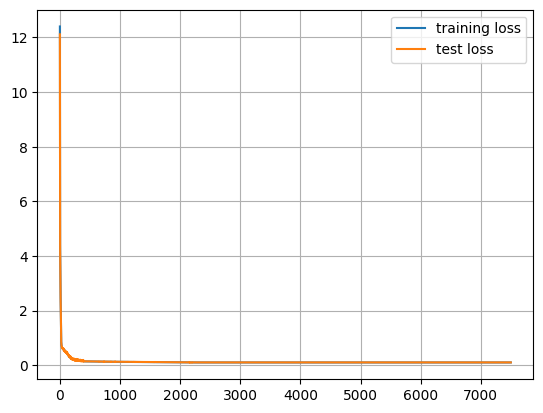

--------------------  EPOCH: 7500  --------------------
LOSS train 0.10337765105068683 valid 0.10549520701169968
--------------------  EPOCH: 7501  --------------------
LOSS train 0.10346518270671368 valid 0.10549504309892654
--------------------  EPOCH: 7502  --------------------
LOSS train 0.10347662344574929 valid 0.1054948940873146
--------------------  EPOCH: 7503  --------------------
LOSS train 0.10338423810899258 valid 0.10549516975879669
--------------------  EPOCH: 7504  --------------------
LOSS train 0.10348001345992089 valid 0.1054961085319519
--------------------  EPOCH: 7505  --------------------
LOSS train 0.10336335115134716 valid 0.10549473762512207
--------------------  EPOCH: 7506  --------------------
LOSS train 0.10339739695191383 valid 0.10549414157867432
--------------------  EPOCH: 7507  --------------------
LOSS train 0.10339439697563649 valid 0.10549498349428177
--------------------  EPOCH: 7508  --------------------
LOSS train 0.10342120416462422 valid 0.105

LOSS train 0.10338272340595722 valid 0.10549362003803253
--------------------  EPOCH: 7574  --------------------
LOSS train 0.10349150784313679 valid 0.10549354553222656
--------------------  EPOCH: 7575  --------------------
LOSS train 0.10348252132534981 valid 0.10549359768629074
--------------------  EPOCH: 7576  --------------------
LOSS train 0.1034867849200964 valid 0.10549383610486984
--------------------  EPOCH: 7577  --------------------
LOSS train 0.10339648239314556 valid 0.10549329221248627
--------------------  EPOCH: 7578  --------------------
LOSS train 0.10340129360556602 valid 0.10549305379390717
--------------------  EPOCH: 7579  --------------------
LOSS train 0.10342045240104199 valid 0.10549218952655792
--------------------  EPOCH: 7580  --------------------
LOSS train 0.10348671413958073 valid 0.10549302399158478
--------------------  EPOCH: 7581  --------------------
LOSS train 0.10339786671102047 valid 0.1054932177066803
--------------------  EPOCH: 7582  ------

LOSS train 0.10348651297390461 valid 0.10549061745405197
--------------------  EPOCH: 7647  --------------------
LOSS train 0.10348365791141986 valid 0.10549113154411316
--------------------  EPOCH: 7648  --------------------
LOSS train 0.1034455481916666 valid 0.10549081861972809
--------------------  EPOCH: 7649  --------------------
LOSS train 0.1033366672694683 valid 0.10549081861972809
--------------------  EPOCH: 7650  --------------------
LOSS train 0.10340610630810261 valid 0.10549125075340271
--------------------  EPOCH: 7651  --------------------
LOSS train 0.10333692468702793 valid 0.10549081861972809
--------------------  EPOCH: 7652  --------------------
LOSS train 0.1034237239509821 valid 0.10549084842205048
--------------------  EPOCH: 7653  --------------------
LOSS train 0.10345552824437618 valid 0.10549071431159973
--------------------  EPOCH: 7654  --------------------
LOSS train 0.1034699972718954 valid 0.1054905503988266
--------------------  EPOCH: 7655  ---------

LOSS train 0.10342600978910924 valid 0.10548832267522812
--------------------  EPOCH: 7720  --------------------
LOSS train 0.1034620001912117 valid 0.10548852384090424
--------------------  EPOCH: 7721  --------------------
LOSS train 0.10346224196255208 valid 0.10548821091651917
--------------------  EPOCH: 7722  --------------------
LOSS train 0.10341050364077091 valid 0.10548827052116394
--------------------  EPOCH: 7723  --------------------
LOSS train 0.10337942317128182 valid 0.10548880696296692
--------------------  EPOCH: 7724  --------------------
LOSS train 0.10341700352728367 valid 0.10548794269561768
--------------------  EPOCH: 7725  --------------------
LOSS train 0.10343919284641742 valid 0.1054893210530281
--------------------  EPOCH: 7726  --------------------
LOSS train 0.10342575162649155 valid 0.10548815131187439
--------------------  EPOCH: 7727  --------------------
LOSS train 0.10348502844572068 valid 0.10548844188451767
--------------------  EPOCH: 7728  ------

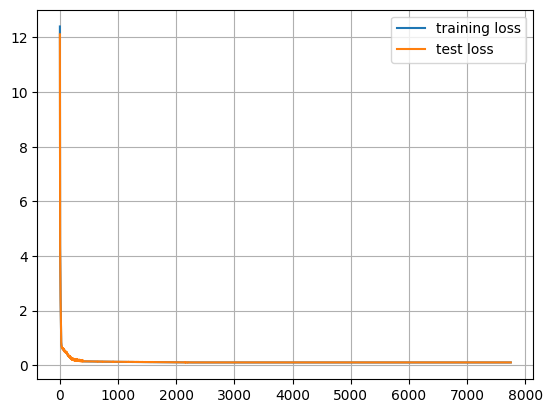

--------------------  EPOCH: 7750  --------------------
LOSS train 0.1034002210944891 valid 0.10548742860555649
--------------------  EPOCH: 7751  --------------------
LOSS train 0.10341066941618919 valid 0.10548719763755798
--------------------  EPOCH: 7752  --------------------
LOSS train 0.1034778632223606 valid 0.10548773407936096
--------------------  EPOCH: 7753  --------------------
LOSS train 0.10343114584684372 valid 0.1054883599281311
--------------------  EPOCH: 7754  --------------------
LOSS train 0.10340154245495796 valid 0.10548829287290573
--------------------  EPOCH: 7755  --------------------
LOSS train 0.1034458540380001 valid 0.10548815131187439
--------------------  EPOCH: 7756  --------------------
LOSS train 0.10349069647490979 valid 0.1054876446723938
--------------------  EPOCH: 7757  --------------------
LOSS train 0.10341135263442994 valid 0.10548776388168335
--------------------  EPOCH: 7758  --------------------
LOSS train 0.10337917357683182 valid 0.105487

LOSS train 0.10341518260538578 valid 0.10548532009124756
--------------------  EPOCH: 7824  --------------------
LOSS train 0.10329348482191562 valid 0.10548575222492218
--------------------  EPOCH: 7825  --------------------
LOSS train 0.10341007225215434 valid 0.10548557341098785
--------------------  EPOCH: 7826  --------------------
LOSS train 0.10343069098889827 valid 0.10548622906208038
--------------------  EPOCH: 7827  --------------------
LOSS train 0.1034676805138588 valid 0.1054861769080162
--------------------  EPOCH: 7828  --------------------
LOSS train 0.10355395190417767 valid 0.10548555105924606
--------------------  EPOCH: 7829  --------------------
LOSS train 0.10341882221400737 valid 0.10548616945743561
--------------------  EPOCH: 7830  --------------------
LOSS train 0.10344942957162857 valid 0.10548597574234009
--------------------  EPOCH: 7831  --------------------
LOSS train 0.10349540114402771 valid 0.10548613965511322
--------------------  EPOCH: 7832  ------

LOSS train 0.10348446480929852 valid 0.10548382252454758
--------------------  EPOCH: 7897  --------------------
LOSS train 0.10348063074052334 valid 0.10548406094312668
--------------------  EPOCH: 7898  --------------------
LOSS train 0.1033716220408678 valid 0.10548559576272964
--------------------  EPOCH: 7899  --------------------
LOSS train 0.10348361730575562 valid 0.10548435151576996
--------------------  EPOCH: 7900  --------------------
LOSS train 0.10343246757984162 valid 0.10548356175422668
--------------------  EPOCH: 7901  --------------------
LOSS train 0.10343822911381721 valid 0.1054840162396431
--------------------  EPOCH: 7902  --------------------
LOSS train 0.10341647192835808 valid 0.105484239757061
--------------------  EPOCH: 7903  --------------------
LOSS train 0.10347048304975033 valid 0.10548369586467743
--------------------  EPOCH: 7904  --------------------
LOSS train 0.10333513766527176 valid 0.10548318922519684
--------------------  EPOCH: 7905  --------

LOSS train 0.10337503254413605 valid 0.10548195987939835
--------------------  EPOCH: 7970  --------------------
LOSS train 0.10340263843536376 valid 0.10548184812068939
--------------------  EPOCH: 7971  --------------------
LOSS train 0.10339018180966378 valid 0.10548218339681625
--------------------  EPOCH: 7972  --------------------
LOSS train 0.10345757529139518 valid 0.10548174381256104
--------------------  EPOCH: 7973  --------------------
LOSS train 0.10349079631268979 valid 0.10548147559165955
--------------------  EPOCH: 7974  --------------------
LOSS train 0.10351016223430634 valid 0.10548137873411179
--------------------  EPOCH: 7975  --------------------
LOSS train 0.10333318673074246 valid 0.10548142343759537
--------------------  EPOCH: 7976  --------------------
LOSS train 0.10342126302421092 valid 0.10548192262649536
--------------------  EPOCH: 7977  --------------------
LOSS train 0.10339029915630818 valid 0.10548186302185059
--------------------  EPOCH: 7978  ----

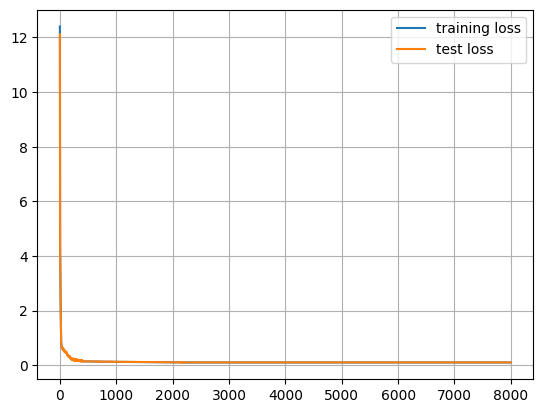

--------------------  EPOCH: 8000  --------------------
LOSS train 0.10331691317260265 valid 0.10548088699579239
--------------------  EPOCH: 8001  --------------------
LOSS train 0.10340205244719983 valid 0.10548072308301926
--------------------  EPOCH: 8002  --------------------
LOSS train 0.10345174111425877 valid 0.10548081994056702
--------------------  EPOCH: 8003  --------------------
LOSS train 0.10345923081040383 valid 0.10548099875450134
--------------------  EPOCH: 8004  --------------------
LOSS train 0.10336019881069661 valid 0.10548026114702225
--------------------  EPOCH: 8005  --------------------
LOSS train 0.10344566665589809 valid 0.10548059642314911
--------------------  EPOCH: 8006  --------------------
LOSS train 0.10344925187528134 valid 0.10548137128353119
--------------------  EPOCH: 8007  --------------------
LOSS train 0.10345018953084946 valid 0.10548058897256851
--------------------  EPOCH: 8008  --------------------
LOSS train 0.10337109044194222 valid 0.1

LOSS train 0.10341663770377636 valid 0.10547850281000137
--------------------  EPOCH: 8074  --------------------
LOSS train 0.10333358123898506 valid 0.1054781973361969
--------------------  EPOCH: 8075  --------------------
LOSS train 0.10342719778418541 valid 0.10547848045825958
--------------------  EPOCH: 8076  --------------------
LOSS train 0.1033861517906189 valid 0.10547861456871033
--------------------  EPOCH: 8077  --------------------
LOSS train 0.10350421443581581 valid 0.10547786206007004
--------------------  EPOCH: 8078  --------------------
LOSS train 0.10347266159951687 valid 0.105478435754776
--------------------  EPOCH: 8079  --------------------
LOSS train 0.10341771766543388 valid 0.1054784432053566
--------------------  EPOCH: 8080  --------------------
LOSS train 0.10335848666727543 valid 0.10547719150781631
--------------------  EPOCH: 8081  --------------------
LOSS train 0.10348219834268094 valid 0.1054774671792984
--------------------  EPOCH: 8082  ----------

LOSS train 0.10343936905264854 valid 0.1054764837026596
--------------------  EPOCH: 8147  --------------------
LOSS train 0.10338750407099724 valid 0.10547678917646408
--------------------  EPOCH: 8148  --------------------
LOSS train 0.10340874828398228 valid 0.10547639429569244
--------------------  EPOCH: 8149  --------------------
LOSS train 0.10345994904637337 valid 0.10547643899917603
--------------------  EPOCH: 8150  --------------------
LOSS train 0.10336201079189777 valid 0.10547644644975662
--------------------  EPOCH: 8151  --------------------
LOSS train 0.10340113155543804 valid 0.10547744482755661
--------------------  EPOCH: 8152  --------------------
LOSS train 0.10336003750562668 valid 0.10547647625207901
--------------------  EPOCH: 8153  --------------------
LOSS train 0.10344427600502967 valid 0.10547660291194916
--------------------  EPOCH: 8154  --------------------
LOSS train 0.10348842069506645 valid 0.10547654330730438
--------------------  EPOCH: 8155  -----

LOSS train 0.10344768092036247 valid 0.10547412931919098
--------------------  EPOCH: 8220  --------------------
LOSS train 0.10341976583003998 valid 0.10547452419996262
--------------------  EPOCH: 8221  --------------------
LOSS train 0.1034633032977581 valid 0.10547448694705963
--------------------  EPOCH: 8222  --------------------
LOSS train 0.10336242020130157 valid 0.10547517240047455
--------------------  EPOCH: 8223  --------------------
LOSS train 0.1034316934645176 valid 0.10547478497028351
--------------------  EPOCH: 8224  --------------------
LOSS train 0.10341954380273818 valid 0.10547523945569992
--------------------  EPOCH: 8225  --------------------
LOSS train 0.10349030941724777 valid 0.1054748073220253
--------------------  EPOCH: 8226  --------------------
LOSS train 0.10344851389527321 valid 0.10547487437725067
--------------------  EPOCH: 8227  --------------------
LOSS train 0.10342644527554512 valid 0.10547418892383575
--------------------  EPOCH: 8228  -------

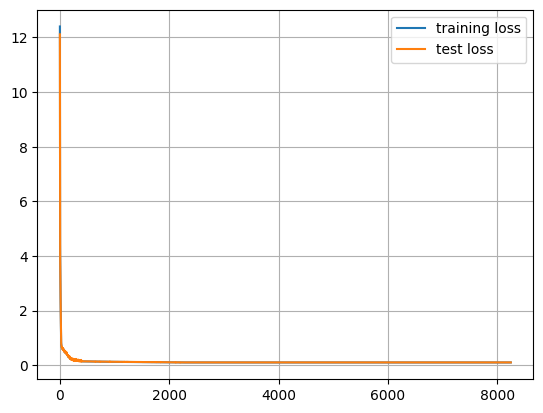

--------------------  EPOCH: 8250  --------------------
LOSS train 0.10344616398215294 valid 0.10547461360692978
--------------------  EPOCH: 8251  --------------------
LOSS train 0.10347548834979534 valid 0.10547367483377457
--------------------  EPOCH: 8252  --------------------
LOSS train 0.10335339307785034 valid 0.10547352582216263
--------------------  EPOCH: 8253  --------------------
LOSS train 0.10332832895219327 valid 0.10547306388616562
--------------------  EPOCH: 8254  --------------------
LOSS train 0.10349904373288155 valid 0.10547291487455368
--------------------  EPOCH: 8255  --------------------
LOSS train 0.10336584337055683 valid 0.10547307878732681
--------------------  EPOCH: 8256  --------------------
LOSS train 0.10342606343328953 valid 0.10547325015068054
--------------------  EPOCH: 8257  --------------------
LOSS train 0.10335893295705319 valid 0.10547354817390442
--------------------  EPOCH: 8258  --------------------
LOSS train 0.10339533239603042 valid 0.1

LOSS train 0.10335783213376999 valid 0.10547102987766266
--------------------  EPOCH: 8324  --------------------
LOSS train 0.103500085324049 valid 0.10547082126140594
--------------------  EPOCH: 8325  --------------------
LOSS train 0.10340936332941056 valid 0.10547083616256714
--------------------  EPOCH: 8326  --------------------
LOSS train 0.10333974212408066 valid 0.10547102987766266
--------------------  EPOCH: 8327  --------------------
LOSS train 0.10339905321598053 valid 0.105470672249794
--------------------  EPOCH: 8328  --------------------
LOSS train 0.1034348651766777 valid 0.10547111183404922
--------------------  EPOCH: 8329  --------------------
LOSS train 0.10339039340615272 valid 0.10547041893005371
--------------------  EPOCH: 8330  --------------------
LOSS train 0.10338920131325721 valid 0.10547146201133728
--------------------  EPOCH: 8331  --------------------
LOSS train 0.10338759012520313 valid 0.10547088086605072
--------------------  EPOCH: 8332  ---------

LOSS train 0.10339080803096294 valid 0.1054697260260582
--------------------  EPOCH: 8397  --------------------
LOSS train 0.10341004654765129 valid 0.10546907782554626
--------------------  EPOCH: 8398  --------------------
LOSS train 0.10349004082381726 valid 0.10546967387199402
--------------------  EPOCH: 8399  --------------------
LOSS train 0.10344347096979618 valid 0.10546936094760895
--------------------  EPOCH: 8400  --------------------
LOSS train 0.10340069606900215 valid 0.10546891391277313
--------------------  EPOCH: 8401  --------------------
LOSS train 0.10339742414653301 valid 0.10546934604644775
--------------------  EPOCH: 8402  --------------------
LOSS train 0.10342181511223317 valid 0.1054689884185791
--------------------  EPOCH: 8403  --------------------
LOSS train 0.1033540416508913 valid 0.10546939074993134
--------------------  EPOCH: 8404  --------------------
LOSS train 0.10343150272965432 valid 0.10546962916851044
--------------------  EPOCH: 8405  -------

LOSS train 0.1034119300544262 valid 0.10546772181987762
--------------------  EPOCH: 8470  --------------------
LOSS train 0.10336949378252029 valid 0.10546696186065674
--------------------  EPOCH: 8471  --------------------
LOSS train 0.10336159691214561 valid 0.10546697676181793
--------------------  EPOCH: 8472  --------------------
LOSS train 0.10334094911813736 valid 0.10546708852052689
--------------------  EPOCH: 8473  --------------------
LOSS train 0.10332778543233871 valid 0.10546658933162689
--------------------  EPOCH: 8474  --------------------
LOSS train 0.10336163640022278 valid 0.10546664148569107
--------------------  EPOCH: 8475  --------------------
LOSS train 0.10338909327983856 valid 0.10546690225601196
--------------------  EPOCH: 8476  --------------------
LOSS train 0.10350735485553741 valid 0.10546677559614182
--------------------  EPOCH: 8477  --------------------
LOSS train 0.10337904058396816 valid 0.10546701401472092
--------------------  EPOCH: 8478  -----

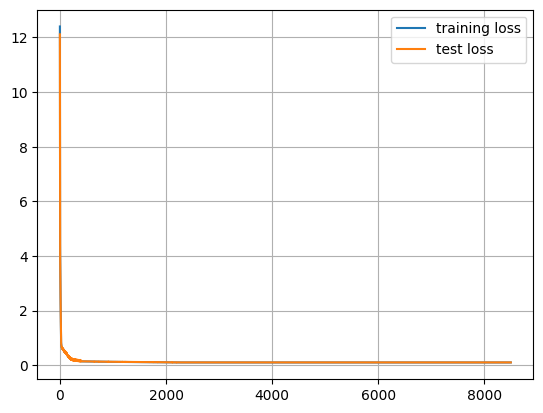

--------------------  EPOCH: 8500  --------------------
LOSS train 0.10336797460913658 valid 0.10546620935201645
--------------------  EPOCH: 8501  --------------------
LOSS train 0.10332506820559502 valid 0.10546594113111496
--------------------  EPOCH: 8502  --------------------
LOSS train 0.10340822972357273 valid 0.10546614229679108
--------------------  EPOCH: 8503  --------------------
LOSS train 0.10342211686074734 valid 0.1054660975933075
--------------------  EPOCH: 8504  --------------------
LOSS train 0.10342727638781071 valid 0.10546644777059555
--------------------  EPOCH: 8505  --------------------
LOSS train 0.10333041399717331 valid 0.10546605288982391
--------------------  EPOCH: 8506  --------------------
LOSS train 0.1034488782286644 valid 0.10546642541885376
--------------------  EPOCH: 8507  --------------------
LOSS train 0.10339094772934913 valid 0.10546628385782242
--------------------  EPOCH: 8508  --------------------
LOSS train 0.10334217250347137 valid 0.105

LOSS train 0.10334731973707675 valid 0.10546353459358215
--------------------  EPOCH: 8574  --------------------
LOSS train 0.10350008420646191 valid 0.10546451061964035
--------------------  EPOCH: 8575  --------------------
LOSS train 0.1034119900316 valid 0.10546340048313141
--------------------  EPOCH: 8576  --------------------
LOSS train 0.10338862501084804 valid 0.10546388477087021
--------------------  EPOCH: 8577  --------------------
LOSS train 0.10331760309636592 valid 0.1054641380906105
--------------------  EPOCH: 8578  --------------------
LOSS train 0.10339290760457516 valid 0.10546410083770752
--------------------  EPOCH: 8579  --------------------
LOSS train 0.10344611145555974 valid 0.10546348989009857
--------------------  EPOCH: 8580  --------------------
LOSS train 0.10346080139279365 valid 0.105463907122612
--------------------  EPOCH: 8581  --------------------
LOSS train 0.10342683270573616 valid 0.1054643914103508
--------------------  EPOCH: 8582  ------------

LOSS train 0.10339572094380856 valid 0.10546145588159561
--------------------  EPOCH: 8647  --------------------
LOSS train 0.10345756635069847 valid 0.105461984872818
--------------------  EPOCH: 8648  --------------------
LOSS train 0.10346952527761459 valid 0.10546193271875381
--------------------  EPOCH: 8649  --------------------
LOSS train 0.1034613899886608 valid 0.10546236485242844
--------------------  EPOCH: 8650  --------------------
LOSS train 0.10342595316469669 valid 0.10546217113733292
--------------------  EPOCH: 8651  --------------------
LOSS train 0.1033923827111721 valid 0.10546190291643143
--------------------  EPOCH: 8652  --------------------
LOSS train 0.10345733650028706 valid 0.10546211153268814
--------------------  EPOCH: 8653  --------------------
LOSS train 0.10336471423506736 valid 0.10546228289604187
--------------------  EPOCH: 8654  --------------------
LOSS train 0.10336249321699142 valid 0.10546241700649261
--------------------  EPOCH: 8655  --------

LOSS train 0.10342366024851798 valid 0.1054597944021225
--------------------  EPOCH: 8720  --------------------
LOSS train 0.10337964072823524 valid 0.10546063631772995
--------------------  EPOCH: 8721  --------------------
LOSS train 0.1034193579107523 valid 0.10546021908521652
--------------------  EPOCH: 8722  --------------------
LOSS train 0.10337386801838874 valid 0.10545990616083145
--------------------  EPOCH: 8723  --------------------
LOSS train 0.10337578132748604 valid 0.1054597720503807
--------------------  EPOCH: 8724  --------------------
LOSS train 0.10335450060665607 valid 0.10545945167541504
--------------------  EPOCH: 8725  --------------------
LOSS train 0.10341397970914841 valid 0.1054593026638031
--------------------  EPOCH: 8726  --------------------
LOSS train 0.10344861336052417 valid 0.10546018183231354
--------------------  EPOCH: 8727  --------------------
LOSS train 0.10337484627962112 valid 0.10546004772186279
--------------------  EPOCH: 8728  --------

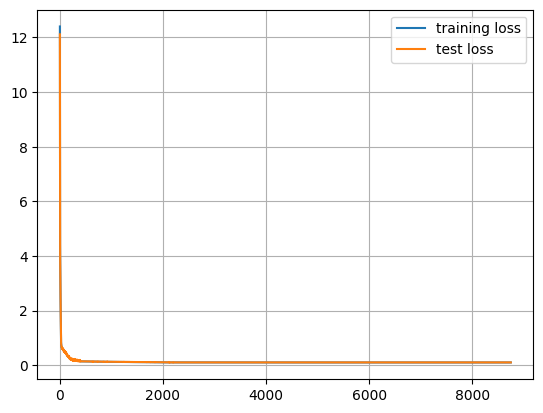

--------------------  EPOCH: 8750  --------------------
LOSS train 0.1033877819776535 valid 0.10545866936445236
--------------------  EPOCH: 8751  --------------------
LOSS train 0.1034578312188387 valid 0.10545976459980011
--------------------  EPOCH: 8752  --------------------
LOSS train 0.10340705774724483 valid 0.10545912384986877
--------------------  EPOCH: 8753  --------------------
LOSS train 0.10343951731920242 valid 0.10545945167541504
--------------------  EPOCH: 8754  --------------------
LOSS train 0.1033968061208725 valid 0.10545909404754639
--------------------  EPOCH: 8755  --------------------
LOSS train 0.10340735204517841 valid 0.10545964539051056
--------------------  EPOCH: 8756  --------------------
LOSS train 0.1033626738935709 valid 0.10545901209115982
--------------------  EPOCH: 8757  --------------------
LOSS train 0.10340570919215679 valid 0.10545910894870758
--------------------  EPOCH: 8758  --------------------
LOSS train 0.10336164198815823 valid 0.10545

LOSS train 0.10336660891771317 valid 0.1054568886756897
--------------------  EPOCH: 8824  --------------------
LOSS train 0.10333124697208404 valid 0.10545673966407776
--------------------  EPOCH: 8825  --------------------
LOSS train 0.10343569740653039 valid 0.10545620322227478
--------------------  EPOCH: 8826  --------------------
LOSS train 0.10340559929609298 valid 0.10545665770769119
--------------------  EPOCH: 8827  --------------------
LOSS train 0.10334075838327408 valid 0.10545641928911209
--------------------  EPOCH: 8828  --------------------
LOSS train 0.10340770147740841 valid 0.10545662045478821
--------------------  EPOCH: 8829  --------------------
LOSS train 0.10340062268078327 valid 0.10545624792575836
--------------------  EPOCH: 8830  --------------------
LOSS train 0.10344368629157544 valid 0.10545595735311508
--------------------  EPOCH: 8831  --------------------
LOSS train 0.10343141071498393 valid 0.10545664280653
--------------------  EPOCH: 8832  --------

LOSS train 0.10342499800026417 valid 0.10545455664396286
--------------------  EPOCH: 8897  --------------------
LOSS train 0.1033453430980444 valid 0.10545479506254196
--------------------  EPOCH: 8898  --------------------
LOSS train 0.10341837964951991 valid 0.10545467585325241
--------------------  EPOCH: 8899  --------------------
LOSS train 0.10339826382696629 valid 0.10545467585325241
--------------------  EPOCH: 8900  --------------------
LOSS train 0.1033820491284132 valid 0.10545490682125092
--------------------  EPOCH: 8901  --------------------
LOSS train 0.10344557203352452 valid 0.1054544746875763
--------------------  EPOCH: 8902  --------------------
LOSS train 0.10330589935183525 valid 0.10545449703931808
--------------------  EPOCH: 8903  --------------------
LOSS train 0.10338266901671886 valid 0.10545527189970016
--------------------  EPOCH: 8904  --------------------
LOSS train 0.10339461788535118 valid 0.1054544597864151
--------------------  EPOCH: 8905  --------

LOSS train 0.10336958430707455 valid 0.10545296221971512
--------------------  EPOCH: 8970  --------------------
LOSS train 0.1033677563071251 valid 0.10545295476913452
--------------------  EPOCH: 8971  --------------------
LOSS train 0.10331086479127408 valid 0.10545267909765244
--------------------  EPOCH: 8972  --------------------
LOSS train 0.1033688560128212 valid 0.10545282810926437
--------------------  EPOCH: 8973  --------------------
LOSS train 0.1034397765994072 valid 0.10545327514410019
--------------------  EPOCH: 8974  --------------------
LOSS train 0.10336448326706886 valid 0.10545296221971512
--------------------  EPOCH: 8975  --------------------
LOSS train 0.10340240150690079 valid 0.10545294731855392
--------------------  EPOCH: 8976  --------------------
LOSS train 0.10330849662423133 valid 0.10545286536216736
--------------------  EPOCH: 8977  --------------------
LOSS train 0.10343237407505512 valid 0.1054530143737793
--------------------  EPOCH: 8978  --------

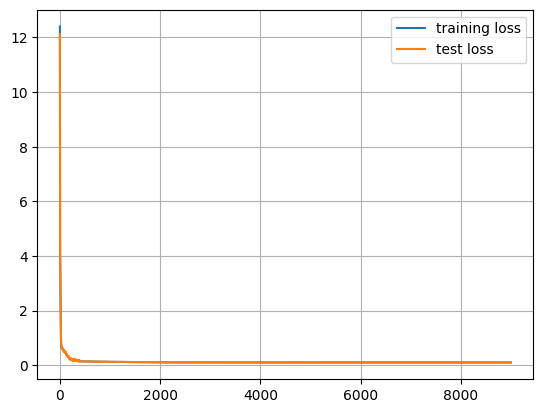

--------------------  EPOCH: 9000  --------------------
LOSS train 0.1033088717609644 valid 0.10545171797275543
--------------------  EPOCH: 9001  --------------------
LOSS train 0.10336771681904793 valid 0.1054522916674614
--------------------  EPOCH: 9002  --------------------
LOSS train 0.10339252762496472 valid 0.10545190423727036
--------------------  EPOCH: 9003  --------------------
LOSS train 0.10337803438305855 valid 0.10545134544372559
--------------------  EPOCH: 9004  --------------------
LOSS train 0.10339374914765358 valid 0.1054520308971405
--------------------  EPOCH: 9005  --------------------
LOSS train 0.10331753343343734 valid 0.10545171797275543
--------------------  EPOCH: 9006  --------------------
LOSS train 0.10339022502303123 valid 0.10545119643211365
--------------------  EPOCH: 9007  --------------------
LOSS train 0.10344951041042805 valid 0.10545244067907333
--------------------  EPOCH: 9008  --------------------
LOSS train 0.10336889773607254 valid 0.1054

LOSS train 0.10348418094217778 valid 0.10544966906309128
--------------------  EPOCH: 9074  --------------------
LOSS train 0.10343988835811616 valid 0.10544978082180023
--------------------  EPOCH: 9075  --------------------
LOSS train 0.10340832695364952 valid 0.10544935613870621
--------------------  EPOCH: 9076  --------------------
LOSS train 0.10340022519230843 valid 0.10544946789741516
--------------------  EPOCH: 9077  --------------------
LOSS train 0.10343975648283958 valid 0.10544964671134949
--------------------  EPOCH: 9078  --------------------
LOSS train 0.10335563644766807 valid 0.10544886440038681
--------------------  EPOCH: 9079  --------------------
LOSS train 0.10342443734407425 valid 0.10544895380735397
--------------------  EPOCH: 9080  --------------------
LOSS train 0.10337275601923465 valid 0.10544929653406143
--------------------  EPOCH: 9081  --------------------
LOSS train 0.1033995110541582 valid 0.10544934868812561
--------------------  EPOCH: 9082  -----

LOSS train 0.1034027874469757 valid 0.10544729232788086
--------------------  EPOCH: 9147  --------------------
LOSS train 0.10345183163881302 valid 0.10544753074645996
--------------------  EPOCH: 9148  --------------------
LOSS train 0.10334313474595547 valid 0.10544724762439728
--------------------  EPOCH: 9149  --------------------
LOSS train 0.10337159745395183 valid 0.10544788837432861
--------------------  EPOCH: 9150  --------------------
LOSS train 0.10337734781205654 valid 0.1054472103714943
--------------------  EPOCH: 9151  --------------------
LOSS train 0.10343890227377414 valid 0.10544802993535995
--------------------  EPOCH: 9152  --------------------
LOSS train 0.10339508913457393 valid 0.10544738173484802
--------------------  EPOCH: 9153  --------------------
LOSS train 0.1034265086054802 valid 0.10544778406620026
--------------------  EPOCH: 9154  --------------------
LOSS train 0.10343483537435531 valid 0.1054479256272316
--------------------  EPOCH: 9155  --------

LOSS train 0.10339537374675274 valid 0.10544488579034805
--------------------  EPOCH: 9220  --------------------
LOSS train 0.10348288752138615 valid 0.10544565320014954
--------------------  EPOCH: 9221  --------------------
LOSS train 0.10345504842698575 valid 0.1054452657699585
--------------------  EPOCH: 9222  --------------------
LOSS train 0.1034268420189619 valid 0.10544506460428238
--------------------  EPOCH: 9223  --------------------
LOSS train 0.10343112275004387 valid 0.10544557869434357
--------------------  EPOCH: 9224  --------------------
LOSS train 0.10339137986302376 valid 0.1054452583193779
--------------------  EPOCH: 9225  --------------------
LOSS train 0.10333092249929905 valid 0.10544509440660477
--------------------  EPOCH: 9226  --------------------
LOSS train 0.10341908931732177 valid 0.10544514656066895
--------------------  EPOCH: 9227  --------------------
LOSS train 0.10337875597178936 valid 0.10544557869434357
--------------------  EPOCH: 9228  -------

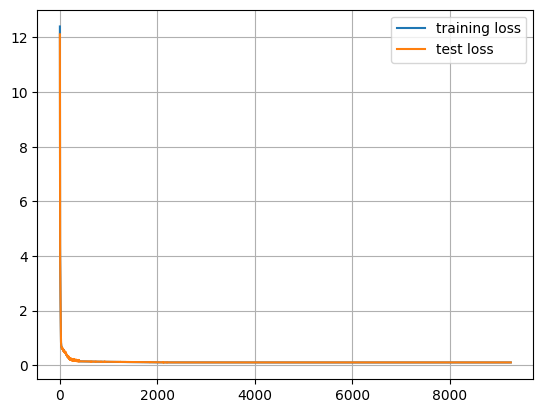

--------------------  EPOCH: 9250  --------------------
LOSS train 0.10333318114280701 valid 0.1054447591304779
--------------------  EPOCH: 9251  --------------------
LOSS train 0.10343969240784645 valid 0.10544364154338837
--------------------  EPOCH: 9252  --------------------
LOSS train 0.10341048538684845 valid 0.10544408857822418
--------------------  EPOCH: 9253  --------------------
LOSS train 0.10335291996598243 valid 0.10544372349977493
--------------------  EPOCH: 9254  --------------------
LOSS train 0.10346284173429013 valid 0.10544385015964508
--------------------  EPOCH: 9255  --------------------
LOSS train 0.10340834781527519 valid 0.1054445132613182
--------------------  EPOCH: 9256  --------------------
LOSS train 0.10332219004631042 valid 0.10544401407241821
--------------------  EPOCH: 9257  --------------------
LOSS train 0.10330099724233151 valid 0.10544419288635254
--------------------  EPOCH: 9258  --------------------
LOSS train 0.10341575294733048 valid 0.105

LOSS train 0.10340748466551304 valid 0.10544206202030182
--------------------  EPOCH: 9324  --------------------
LOSS train 0.10333435796201229 valid 0.10544226318597794
--------------------  EPOCH: 9325  --------------------
LOSS train 0.10334088057279586 valid 0.105442576110363
--------------------  EPOCH: 9326  --------------------
LOSS train 0.10337804667651654 valid 0.10544262826442719
--------------------  EPOCH: 9327  --------------------
LOSS train 0.10333584658801556 valid 0.10544244199991226
--------------------  EPOCH: 9328  --------------------
LOSS train 0.10332544669508933 valid 0.10544214397668839
--------------------  EPOCH: 9329  --------------------
LOSS train 0.10335143841803074 valid 0.10544109344482422
--------------------  EPOCH: 9330  --------------------
LOSS train 0.1034438494592905 valid 0.10544178634881973
--------------------  EPOCH: 9331  --------------------
LOSS train 0.10341410711407661 valid 0.10544182360172272
--------------------  EPOCH: 9332  -------

LOSS train 0.10337525382637977 valid 0.10544052720069885
--------------------  EPOCH: 9397  --------------------
LOSS train 0.10332274623215199 valid 0.10543999075889587
--------------------  EPOCH: 9398  --------------------
LOSS train 0.1034266386181116 valid 0.10544079542160034
--------------------  EPOCH: 9399  --------------------
LOSS train 0.1033469196408987 valid 0.10544051229953766
--------------------  EPOCH: 9400  --------------------
LOSS train 0.10332840196788311 valid 0.10544037818908691
--------------------  EPOCH: 9401  --------------------
LOSS train 0.10339386984705926 valid 0.10544009506702423
--------------------  EPOCH: 9402  --------------------
LOSS train 0.10340978018939495 valid 0.10544009506702423
--------------------  EPOCH: 9403  --------------------
LOSS train 0.10329176150262356 valid 0.10543990135192871
--------------------  EPOCH: 9404  --------------------
LOSS train 0.10335723161697388 valid 0.10544011741876602
--------------------  EPOCH: 9405  ------

LOSS train 0.10335950404405594 valid 0.10543707013130188
--------------------  EPOCH: 9470  --------------------
LOSS train 0.10338336639106274 valid 0.10543767362833023
--------------------  EPOCH: 9471  --------------------
LOSS train 0.10337943844497204 valid 0.10543714463710785
--------------------  EPOCH: 9472  --------------------
LOSS train 0.10334455110132694 valid 0.10543690621852875
--------------------  EPOCH: 9473  --------------------
LOSS train 0.10338368304073811 valid 0.10543633252382278
--------------------  EPOCH: 9474  --------------------
LOSS train 0.10336938798427582 valid 0.10543697327375412
--------------------  EPOCH: 9475  --------------------
LOSS train 0.10339297764003277 valid 0.10543688386678696
--------------------  EPOCH: 9476  --------------------
LOSS train 0.1033159252256155 valid 0.10543718189001083
--------------------  EPOCH: 9477  --------------------
LOSS train 0.10335707627236843 valid 0.10543771088123322
--------------------  EPOCH: 9478  -----

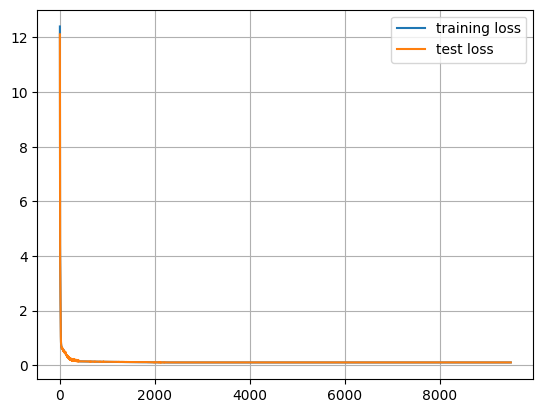

--------------------  EPOCH: 9500  --------------------
LOSS train 0.10333985053002834 valid 0.10543690621852875
--------------------  EPOCH: 9501  --------------------
LOSS train 0.10333429239690303 valid 0.10543642938137054
--------------------  EPOCH: 9502  --------------------
LOSS train 0.10334768891334534 valid 0.10543648898601532
--------------------  EPOCH: 9503  --------------------
LOSS train 0.10336434245109558 valid 0.10543699562549591
--------------------  EPOCH: 9504  --------------------
LOSS train 0.10332880206406117 valid 0.10543680191040039
--------------------  EPOCH: 9505  --------------------
LOSS train 0.10343541763722897 valid 0.10543686151504517
--------------------  EPOCH: 9506  --------------------
LOSS train 0.10337268561124802 valid 0.10543744266033173
--------------------  EPOCH: 9507  --------------------
LOSS train 0.10330673567950725 valid 0.10543603450059891
--------------------  EPOCH: 9508  --------------------
LOSS train 0.103401442989707 valid 0.105

LOSS train 0.10327128507196903 valid 0.10543467104434967
--------------------  EPOCH: 9574  --------------------
LOSS train 0.10336009487509727 valid 0.10543450713157654
--------------------  EPOCH: 9575  --------------------
LOSS train 0.103376829251647 valid 0.10543376952409744
--------------------  EPOCH: 9576  --------------------
LOSS train 0.1034261368215084 valid 0.10543427616357803
--------------------  EPOCH: 9577  --------------------
LOSS train 0.10345294028520584 valid 0.10543505847454071
--------------------  EPOCH: 9578  --------------------
LOSS train 0.10326672345399857 valid 0.10543448477983475
--------------------  EPOCH: 9579  --------------------
LOSS train 0.10333271473646163 valid 0.10543426871299744
--------------------  EPOCH: 9580  --------------------
LOSS train 0.10335429012775421 valid 0.10543441027402878
--------------------  EPOCH: 9581  --------------------
LOSS train 0.10340696685016156 valid 0.10543423146009445
--------------------  EPOCH: 9582  -------

LOSS train 0.10341820828616619 valid 0.10543180257081985
--------------------  EPOCH: 9647  --------------------
LOSS train 0.10340612344443798 valid 0.10543172806501389
--------------------  EPOCH: 9648  --------------------
LOSS train 0.1033770751208067 valid 0.10543220490217209
--------------------  EPOCH: 9649  --------------------
LOSS train 0.10340819284319877 valid 0.1054324135184288
--------------------  EPOCH: 9650  --------------------
LOSS train 0.10343283712863922 valid 0.10543254017829895
--------------------  EPOCH: 9651  --------------------
LOSS train 0.10329566858708858 valid 0.10543274134397507
--------------------  EPOCH: 9652  --------------------
LOSS train 0.10333999879658222 valid 0.10543149709701538
--------------------  EPOCH: 9653  --------------------
LOSS train 0.10342246033251286 valid 0.10543186962604523
--------------------  EPOCH: 9654  --------------------
LOSS train 0.1033748235553503 valid 0.10543201118707657
--------------------  EPOCH: 9655  -------

LOSS train 0.1033927045762539 valid 0.10543010383844376
--------------------  EPOCH: 9720  --------------------
LOSS train 0.10333748906850815 valid 0.10543003678321838
--------------------  EPOCH: 9721  --------------------
LOSS train 0.10344696827232838 valid 0.10542933642864227
--------------------  EPOCH: 9722  --------------------
LOSS train 0.10338910184800625 valid 0.10542983561754227
--------------------  EPOCH: 9723  --------------------
LOSS train 0.10328859090805054 valid 0.10542993992567062
--------------------  EPOCH: 9724  --------------------
LOSS train 0.10337023325264454 valid 0.10543017834424973
--------------------  EPOCH: 9725  --------------------
LOSS train 0.10333779044449329 valid 0.10543030500411987
--------------------  EPOCH: 9726  --------------------
LOSS train 0.10334939546883107 valid 0.10542985796928406
--------------------  EPOCH: 9727  --------------------
LOSS train 0.10332147106528282 valid 0.10542991757392883
--------------------  EPOCH: 9728  -----

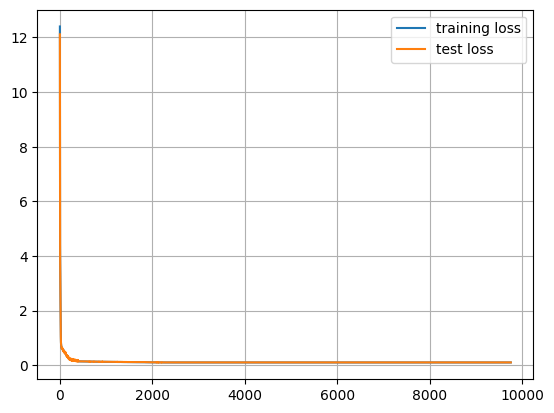

--------------------  EPOCH: 9750  --------------------
LOSS train 0.10343785136938095 valid 0.10542892664670944
--------------------  EPOCH: 9751  --------------------
LOSS train 0.10342686474323273 valid 0.10542933642864227
--------------------  EPOCH: 9752  --------------------
LOSS train 0.10325754135847091 valid 0.10542835295200348
--------------------  EPOCH: 9753  --------------------
LOSS train 0.10332821384072303 valid 0.10542911291122437
--------------------  EPOCH: 9754  --------------------
LOSS train 0.10335713922977448 valid 0.1054297536611557
--------------------  EPOCH: 9755  --------------------
LOSS train 0.10332501642405986 valid 0.10542947798967361
--------------------  EPOCH: 9756  --------------------
LOSS train 0.10338170938193798 valid 0.10542929172515869
--------------------  EPOCH: 9757  --------------------
LOSS train 0.1034296203404665 valid 0.1054290160536766
--------------------  EPOCH: 9758  --------------------
LOSS train 0.10340859591960908 valid 0.1054

LOSS train 0.10347982905805111 valid 0.10542721301317215
--------------------  EPOCH: 9824  --------------------
LOSS train 0.10338593013584614 valid 0.10542713850736618
--------------------  EPOCH: 9825  --------------------
LOSS train 0.10331488363444805 valid 0.10542688518762589
--------------------  EPOCH: 9826  --------------------
LOSS train 0.10329389460384845 valid 0.10542670637369156
--------------------  EPOCH: 9827  --------------------
LOSS train 0.10341666974127292 valid 0.10542657226324081
--------------------  EPOCH: 9828  --------------------
LOSS train 0.10349284335970879 valid 0.1054275780916214
--------------------  EPOCH: 9829  --------------------
LOSS train 0.10340307056903839 valid 0.10542640089988708
--------------------  EPOCH: 9830  --------------------
LOSS train 0.10333846881985664 valid 0.10542669892311096
--------------------  EPOCH: 9831  --------------------
LOSS train 0.10336686447262763 valid 0.10542737692594528
--------------------  EPOCH: 9832  -----

LOSS train 0.10340326987206935 valid 0.10542502254247665
--------------------  EPOCH: 9897  --------------------
LOSS train 0.10333538502454757 valid 0.10542420297861099
--------------------  EPOCH: 9898  --------------------
LOSS train 0.10336412191390991 valid 0.105424664914608
--------------------  EPOCH: 9899  --------------------
LOSS train 0.10343683436512947 valid 0.10542408376932144
--------------------  EPOCH: 9900  --------------------
LOSS train 0.10334282889962196 valid 0.10542529076337814
--------------------  EPOCH: 9901  --------------------
LOSS train 0.10337125100195407 valid 0.10542432218790054
--------------------  EPOCH: 9902  --------------------
LOSS train 0.1033322025090456 valid 0.10542426258325577
--------------------  EPOCH: 9903  --------------------
LOSS train 0.10328787304461003 valid 0.10542480647563934
--------------------  EPOCH: 9904  --------------------
LOSS train 0.10338183641433715 valid 0.10542463511228561
--------------------  EPOCH: 9905  -------

LOSS train 0.10334902480244637 valid 0.10542207956314087
--------------------  EPOCH: 9970  --------------------
LOSS train 0.10339571759104729 valid 0.10542265325784683
--------------------  EPOCH: 9971  --------------------
LOSS train 0.10335549116134643 valid 0.1054224744439125
--------------------  EPOCH: 9972  --------------------
LOSS train 0.10336422473192215 valid 0.10542252659797668
--------------------  EPOCH: 9973  --------------------
LOSS train 0.10346908792853356 valid 0.10542295128107071
--------------------  EPOCH: 9974  --------------------
LOSS train 0.10347953289747239 valid 0.10542216897010803
--------------------  EPOCH: 9975  --------------------
LOSS train 0.10334909446537495 valid 0.10542219132184982
--------------------  EPOCH: 9976  --------------------
LOSS train 0.10335656926035881 valid 0.10542210191488266
--------------------  EPOCH: 9977  --------------------
LOSS train 0.10339533910155296 valid 0.10542311519384384
--------------------  EPOCH: 9978  -----

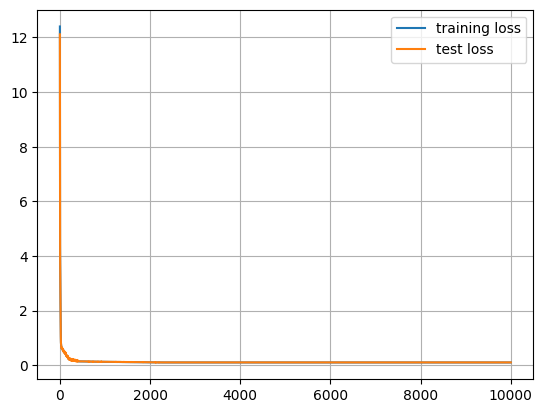

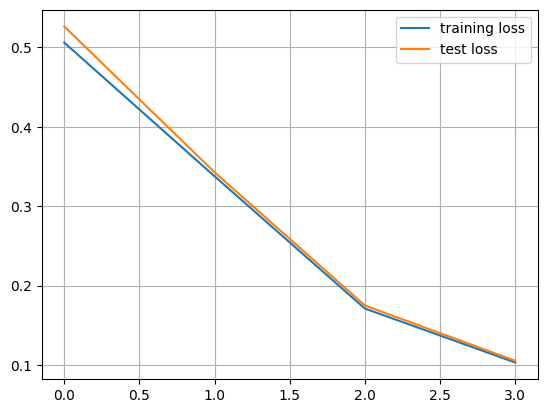

data_size: 100000
--------------------  EPOCH: 0  --------------------
LOSS train 12.300181579589843 valid 11.848849296569824
--------------------  EPOCH: 1  --------------------
LOSS train 9.627670822143555 valid 5.449019908905029
--------------------  EPOCH: 2  --------------------
LOSS train 4.956812839508057 valid 4.664021015167236
--------------------  EPOCH: 3  --------------------
LOSS train 4.400600204467773 valid 4.21124267578125
--------------------  EPOCH: 4  --------------------
LOSS train 4.054119644165039 valid 3.9003326892852783
--------------------  EPOCH: 5  --------------------
LOSS train 3.760314064025879 valid 3.61861515045166
--------------------  EPOCH: 6  --------------------
LOSS train 3.477753372192383 valid 3.332543134689331
--------------------  EPOCH: 7  --------------------
LOSS train 3.187513608932495 valid 3.037235975265503
--------------------  EPOCH: 8  --------------------
LOSS train 2.8934356784820556 valid 2.742189884185791
--------------------  EPOC

LOSS train 0.3993385565280914 valid 0.3923678994178772
--------------------  EPOCH: 76  --------------------
LOSS train 0.39323315501213074 valid 0.38716211915016174
--------------------  EPOCH: 77  --------------------
LOSS train 0.39224317789077756 valid 0.38810452818870544
--------------------  EPOCH: 78  --------------------
LOSS train 0.3862843322753906 valid 0.38421645760536194
--------------------  EPOCH: 79  --------------------
LOSS train 0.3886010944843292 valid 0.3773857355117798
--------------------  EPOCH: 80  --------------------
LOSS train 0.39016490936279297 valid 0.38457831740379333
--------------------  EPOCH: 81  --------------------
LOSS train 0.3809551703929901 valid 0.3805508315563202
--------------------  EPOCH: 82  --------------------
LOSS train 0.3759332275390625 valid 0.4085344970226288
--------------------  EPOCH: 83  --------------------
LOSS train 0.3816597270965576 valid 0.3731215298175812
--------------------  EPOCH: 84  --------------------
LOSS train 0

LOSS train 0.239477818608284 valid 0.23973172903060913
--------------------  EPOCH: 151  --------------------
LOSS train 0.2399860978126526 valid 0.24671894311904907
--------------------  EPOCH: 152  --------------------
LOSS train 0.23640930712223052 valid 0.24039071798324585
--------------------  EPOCH: 153  --------------------
LOSS train 0.2422535401582718 valid 0.23305025696754456
--------------------  EPOCH: 154  --------------------
LOSS train 0.24123391151428222 valid 0.2268427610397339
--------------------  EPOCH: 155  --------------------
LOSS train 0.23535822987556457 valid 0.23351499438285828
--------------------  EPOCH: 156  --------------------
LOSS train 0.23993418753147125 valid 0.23256047070026398
--------------------  EPOCH: 157  --------------------
LOSS train 0.23610757052898407 valid 0.2249678075313568
--------------------  EPOCH: 158  --------------------
LOSS train 0.2377377212047577 valid 0.22515597939491272
--------------------  EPOCH: 159  --------------------

LOSS train 0.1854870128631592 valid 0.19110716879367828
--------------------  EPOCH: 225  --------------------
LOSS train 0.18797332644462586 valid 0.1830114722251892
--------------------  EPOCH: 226  --------------------
LOSS train 0.19031848311424254 valid 0.19256412982940674
--------------------  EPOCH: 227  --------------------
LOSS train 0.191093133687973 valid 0.18016090989112854
--------------------  EPOCH: 228  --------------------
LOSS train 0.1942332601547241 valid 0.1877155303955078
--------------------  EPOCH: 229  --------------------
LOSS train 0.18608962774276733 valid 0.17840437591075897
--------------------  EPOCH: 230  --------------------
LOSS train 0.18756028771400451 valid 0.18722377717494965
--------------------  EPOCH: 231  --------------------
LOSS train 0.1857830423116684 valid 0.18419654667377472
--------------------  EPOCH: 232  --------------------
LOSS train 0.18768157839775085 valid 0.18508268892765045
--------------------  EPOCH: 233  --------------------

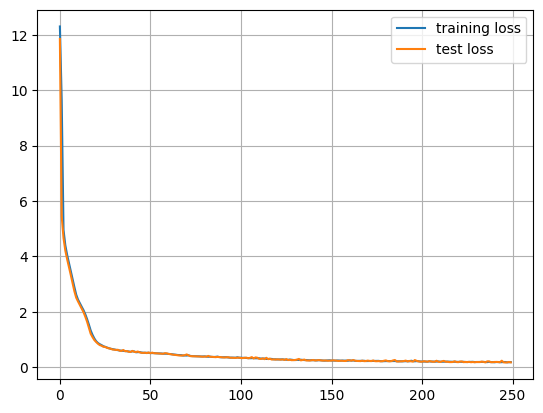

--------------------  EPOCH: 250  --------------------
LOSS train 0.1821455615758896 valid 0.1977601796388626
--------------------  EPOCH: 251  --------------------
LOSS train 0.1816764146089554 valid 0.17144280672073364
--------------------  EPOCH: 252  --------------------
LOSS train 0.1743575245141983 valid 0.2118905633687973
--------------------  EPOCH: 253  --------------------
LOSS train 0.17895130693912506 valid 0.1687067449092865
--------------------  EPOCH: 254  --------------------
LOSS train 0.1753881472349167 valid 0.20408515632152557
--------------------  EPOCH: 255  --------------------
LOSS train 0.17921026587486266 valid 0.19439192116260529
--------------------  EPOCH: 256  --------------------
LOSS train 0.17695342421531676 valid 0.17624294757843018
--------------------  EPOCH: 257  --------------------
LOSS train 0.1779925173521042 valid 0.1655530333518982
--------------------  EPOCH: 258  --------------------
LOSS train 0.17582302570343017 valid 0.16937005519866943
-

LOSS train 0.1602599447965622 valid 0.16228897869586945
--------------------  EPOCH: 325  --------------------
LOSS train 0.15932089805603028 valid 0.15312737226486206
--------------------  EPOCH: 326  --------------------
LOSS train 0.1572432416677475 valid 0.15461938083171844
--------------------  EPOCH: 327  --------------------
LOSS train 0.15696296095848083 valid 0.1711423546075821
--------------------  EPOCH: 328  --------------------
LOSS train 0.158543199300766 valid 0.1530512571334839
--------------------  EPOCH: 329  --------------------
LOSS train 0.15703342020511626 valid 0.1553054004907608
--------------------  EPOCH: 330  --------------------
LOSS train 0.15688964426517488 valid 0.159910187125206
--------------------  EPOCH: 331  --------------------
LOSS train 0.15659021496772765 valid 0.19715145230293274
--------------------  EPOCH: 332  --------------------
LOSS train 0.17032393872737883 valid 0.17407654225826263
--------------------  EPOCH: 333  --------------------
L

LOSS train 0.1459762543439865 valid 0.17206203937530518
--------------------  EPOCH: 399  --------------------
LOSS train 0.15536704540252685 valid 0.16605828702449799
--------------------  EPOCH: 400  --------------------
LOSS train 0.14822532892227172 valid 0.13752807676792145
--------------------  EPOCH: 401  --------------------
LOSS train 0.15576302468776704 valid 0.16146522760391235
--------------------  EPOCH: 402  --------------------
LOSS train 0.1594864809513092 valid 0.13804592192173004
--------------------  EPOCH: 403  --------------------
LOSS train 0.15278906166553496 valid 0.14801625907421112
--------------------  EPOCH: 404  --------------------
LOSS train 0.1463088011741638 valid 0.13700933754444122
--------------------  EPOCH: 405  --------------------
LOSS train 0.14456018805503845 valid 0.14975136518478394
--------------------  EPOCH: 406  --------------------
LOSS train 0.14375538110733033 valid 0.14623431861400604
--------------------  EPOCH: 407  ----------------

LOSS train 0.13918413281440734 valid 0.14507509768009186
--------------------  EPOCH: 473  --------------------
LOSS train 0.1389135617017746 valid 0.1354852318763733
--------------------  EPOCH: 474  --------------------
LOSS train 0.1430106693506241 valid 0.13347932696342468
--------------------  EPOCH: 475  --------------------
LOSS train 0.13859209299087524 valid 0.14264506101608276
--------------------  EPOCH: 476  --------------------
LOSS train 0.14168378531932832 valid 0.13804727792739868
--------------------  EPOCH: 477  --------------------
LOSS train 0.14319138884544372 valid 0.129452645778656
--------------------  EPOCH: 478  --------------------
LOSS train 0.1408199018239975 valid 0.13896387815475464
--------------------  EPOCH: 479  --------------------
LOSS train 0.13205068856477736 valid 0.14423230290412903
--------------------  EPOCH: 480  --------------------
LOSS train 0.13740553855895996 valid 0.13802795112133026
--------------------  EPOCH: 481  -------------------

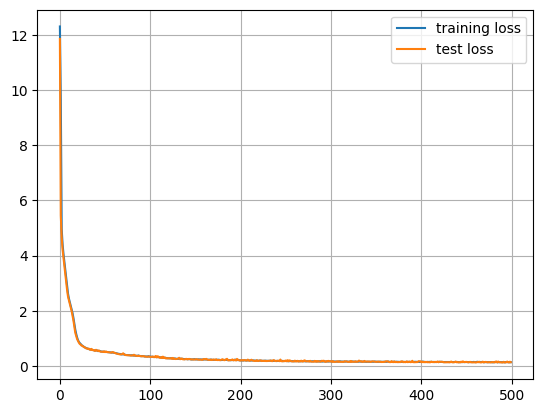

--------------------  EPOCH: 500  --------------------
LOSS train 0.1425957289338112 valid 0.12791256606578827
Epoch 00501: reducing learning rate of group 0 to 1.0000e-04.
--------------------  EPOCH: 501  --------------------
LOSS train 0.125685410797596 valid 0.12645164132118225
--------------------  EPOCH: 502  --------------------
LOSS train 0.12518344730138778 valid 0.12639397382736206
--------------------  EPOCH: 503  --------------------
LOSS train 0.1251331803202629 valid 0.12645329535007477
--------------------  EPOCH: 504  --------------------
LOSS train 0.12514056533575058 valid 0.12624388933181763
--------------------  EPOCH: 505  --------------------
LOSS train 0.12496023684740067 valid 0.12627629935741425
--------------------  EPOCH: 506  --------------------
LOSS train 0.12497827142477036 valid 0.126266211271286
--------------------  EPOCH: 507  --------------------
LOSS train 0.12494918137788773 valid 0.1262606382369995
--------------------  EPOCH: 508  ---------------

LOSS train 0.1239323815703392 valid 0.12528476119041443
--------------------  EPOCH: 574  --------------------
LOSS train 0.1238945797085762 valid 0.12560997903347015
--------------------  EPOCH: 575  --------------------
LOSS train 0.12411733210086823 valid 0.12551389634609222
--------------------  EPOCH: 576  --------------------
LOSS train 0.1240350979566574 valid 0.1251949965953827
--------------------  EPOCH: 577  --------------------
LOSS train 0.12396066874265671 valid 0.1251453459262848
--------------------  EPOCH: 578  --------------------
LOSS train 0.1237335729598999 valid 0.12537293136119843
--------------------  EPOCH: 579  --------------------
LOSS train 0.12396962195634842 valid 0.12520559132099152
--------------------  EPOCH: 580  --------------------
LOSS train 0.1239560079574585 valid 0.12565875053405762
--------------------  EPOCH: 581  --------------------
LOSS train 0.1240275552868843 valid 0.12522079050540924
--------------------  EPOCH: 582  --------------------


LOSS train 0.1220075961947441 valid 0.1234486773610115
--------------------  EPOCH: 648  --------------------
LOSS train 0.12226405799388886 valid 0.12342613190412521
--------------------  EPOCH: 649  --------------------
LOSS train 0.12258871465921402 valid 0.12388645857572556
--------------------  EPOCH: 650  --------------------
LOSS train 0.12197040855884551 valid 0.12319324910640717
--------------------  EPOCH: 651  --------------------
LOSS train 0.12200377881526947 valid 0.12396553158760071
--------------------  EPOCH: 652  --------------------
LOSS train 0.12205238938331604 valid 0.1234060749411583
--------------------  EPOCH: 653  --------------------
LOSS train 0.1219009891152382 valid 0.1231750100851059
--------------------  EPOCH: 654  --------------------
LOSS train 0.1217584428191185 valid 0.12313449382781982
--------------------  EPOCH: 655  --------------------
LOSS train 0.12209215849637985 valid 0.12351324409246445
--------------------  EPOCH: 656  -------------------

LOSS train 0.12026962637901306 valid 0.12142936885356903
--------------------  EPOCH: 722  --------------------
LOSS train 0.12077254354953766 valid 0.12113384157419205
--------------------  EPOCH: 723  --------------------
LOSS train 0.11984153836965561 valid 0.12124943733215332
--------------------  EPOCH: 724  --------------------
LOSS train 0.12005120605230331 valid 0.12099561095237732
--------------------  EPOCH: 725  --------------------
LOSS train 0.12008723258972168 valid 0.12094178050756454
--------------------  EPOCH: 726  --------------------
LOSS train 0.11970650970935821 valid 0.12077146768569946
--------------------  EPOCH: 727  --------------------
LOSS train 0.11961323112249374 valid 0.12087146937847137
--------------------  EPOCH: 728  --------------------
LOSS train 0.11986387699842453 valid 0.12114466726779938
--------------------  EPOCH: 729  --------------------
LOSS train 0.12001316249370575 valid 0.12174887210130692
--------------------  EPOCH: 730  -------------

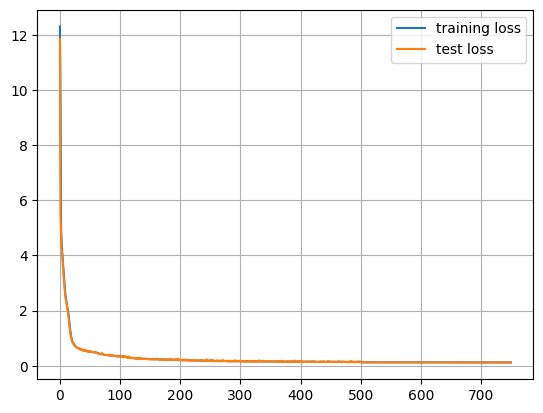

--------------------  EPOCH: 750  --------------------
LOSS train 0.1192531269788742 valid 0.12009210884571075
--------------------  EPOCH: 751  --------------------
LOSS train 0.11922992616891862 valid 0.12189089506864548
--------------------  EPOCH: 752  --------------------
LOSS train 0.11921948105096818 valid 0.12026697397232056
--------------------  EPOCH: 753  --------------------
LOSS train 0.11910403668880462 valid 0.12062669545412064
--------------------  EPOCH: 754  --------------------
LOSS train 0.11915977656841278 valid 0.12015726417303085
--------------------  EPOCH: 755  --------------------
LOSS train 0.1195856323838234 valid 0.12013616412878036
--------------------  EPOCH: 756  --------------------
LOSS train 0.11955636411905289 valid 0.12404731661081314
--------------------  EPOCH: 757  --------------------
LOSS train 0.11939887642860413 valid 0.12092484533786774
--------------------  EPOCH: 758  --------------------
LOSS train 0.11961150646209717 valid 0.120067067444

LOSS train 0.11695611596107483 valid 0.11834897100925446
--------------------  EPOCH: 824  --------------------
LOSS train 0.11727001309394837 valid 0.1186845675110817
--------------------  EPOCH: 825  --------------------
LOSS train 0.11722316175699234 valid 0.11988990008831024
--------------------  EPOCH: 826  --------------------
LOSS train 0.11727732211351395 valid 0.1183052733540535
--------------------  EPOCH: 827  --------------------
LOSS train 0.11669309318065643 valid 0.1180817037820816
--------------------  EPOCH: 828  --------------------
LOSS train 0.11653837502002716 valid 0.11790428310632706
--------------------  EPOCH: 829  --------------------
LOSS train 0.11701315730810165 valid 0.11892028152942657
--------------------  EPOCH: 830  --------------------
LOSS train 0.11672681093215942 valid 0.1178954690694809
--------------------  EPOCH: 831  --------------------
LOSS train 0.11637875527143478 valid 0.11784959584474564
--------------------  EPOCH: 832  -----------------

LOSS train 0.11415007680654526 valid 0.1151781976222992
--------------------  EPOCH: 898  --------------------
LOSS train 0.1142643216252327 valid 0.11520808190107346
--------------------  EPOCH: 899  --------------------
LOSS train 0.11465240120887757 valid 0.11519704759120941
--------------------  EPOCH: 900  --------------------
LOSS train 0.11409906715154648 valid 0.11518612504005432
--------------------  EPOCH: 901  --------------------
LOSS train 0.1147572010755539 valid 0.12087337672710419
--------------------  EPOCH: 902  --------------------
LOSS train 0.11531019061803818 valid 0.11604705452919006
--------------------  EPOCH: 903  --------------------
LOSS train 0.11468025803565979 valid 0.11497020721435547
--------------------  EPOCH: 904  --------------------
LOSS train 0.11409319519996643 valid 0.11552490293979645
--------------------  EPOCH: 905  --------------------
LOSS train 0.113693927526474 valid 0.11498523503541946
--------------------  EPOCH: 906  ------------------

LOSS train 0.1124848136305809 valid 0.11349781602621078
--------------------  EPOCH: 972  --------------------
LOSS train 0.1121061971783638 valid 0.11433468014001846
--------------------  EPOCH: 973  --------------------
LOSS train 0.11268599450588226 valid 0.11335698515176773
--------------------  EPOCH: 974  --------------------
LOSS train 0.11185540288686752 valid 0.1130591630935669
--------------------  EPOCH: 975  --------------------
LOSS train 0.1120030528306961 valid 0.1139778345823288
--------------------  EPOCH: 976  --------------------
LOSS train 0.11233033150434495 valid 0.1132400631904602
--------------------  EPOCH: 977  --------------------
LOSS train 0.11239882379770279 valid 0.11539791524410248
--------------------  EPOCH: 978  --------------------
LOSS train 0.11218149721622467 valid 0.11301694810390472
--------------------  EPOCH: 979  --------------------
LOSS train 0.11194922178983688 valid 0.11310090869665146
--------------------  EPOCH: 980  -------------------

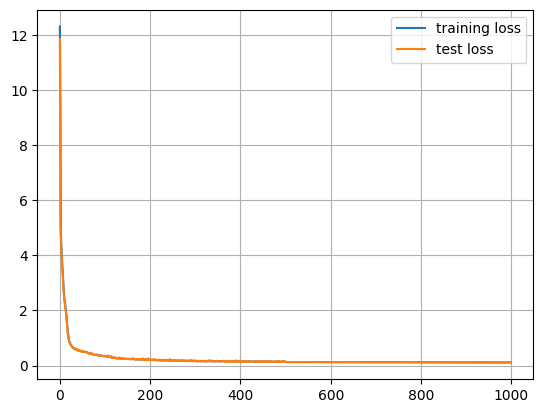

--------------------  EPOCH: 1000  --------------------
LOSS train 0.11147789657115936 valid 0.11415661871433258
--------------------  EPOCH: 1001  --------------------
LOSS train 0.1128241690993309 valid 0.1130433902144432
--------------------  EPOCH: 1002  --------------------
LOSS train 0.11157082706689835 valid 0.11274037510156631
--------------------  EPOCH: 1003  --------------------
LOSS train 0.11154271960258484 valid 0.1161983385682106
--------------------  EPOCH: 1004  --------------------
LOSS train 0.11202021688222885 valid 0.1142384484410286
--------------------  EPOCH: 1005  --------------------
LOSS train 0.11147522270679473 valid 0.11291896551847458
--------------------  EPOCH: 1006  --------------------
LOSS train 0.11130460500717163 valid 0.11274737119674683
--------------------  EPOCH: 1007  --------------------
LOSS train 0.11138173311948776 valid 0.11235711723566055
--------------------  EPOCH: 1008  --------------------
LOSS train 0.11201210588216781 valid 0.11303

LOSS train 0.10996179163455963 valid 0.11176224052906036
--------------------  EPOCH: 1074  --------------------
LOSS train 0.11016878515481948 valid 0.11145692318677902
--------------------  EPOCH: 1075  --------------------
LOSS train 0.10998008251190186 valid 0.11126330494880676
--------------------  EPOCH: 1076  --------------------
LOSS train 0.11022896409034728 valid 0.11112561076879501
--------------------  EPOCH: 1077  --------------------
LOSS train 0.11023413866758347 valid 0.11147960275411606
--------------------  EPOCH: 1078  --------------------
LOSS train 0.10977234363555909 valid 0.1113230437040329
--------------------  EPOCH: 1079  --------------------
LOSS train 0.10993746846914292 valid 0.11126456409692764
--------------------  EPOCH: 1080  --------------------
LOSS train 0.10967969954013825 valid 0.1111038476228714
--------------------  EPOCH: 1081  --------------------
LOSS train 0.11023872196674347 valid 0.11103542894124985
--------------------  EPOCH: 1082  ------

LOSS train 0.10860356658697129 valid 0.1098075807094574
--------------------  EPOCH: 1147  --------------------
LOSS train 0.10859636306762695 valid 0.10980066657066345
--------------------  EPOCH: 1148  --------------------
LOSS train 0.10847696185111999 valid 0.10987117141485214
--------------------  EPOCH: 1149  --------------------
LOSS train 0.10883015632629395 valid 0.10965722054243088
--------------------  EPOCH: 1150  --------------------
LOSS train 0.10891470223665238 valid 0.10963413119316101
--------------------  EPOCH: 1151  --------------------
LOSS train 0.1085633409023285 valid 0.11211822181940079
--------------------  EPOCH: 1152  --------------------
LOSS train 0.10957190752029419 valid 0.109831802546978
--------------------  EPOCH: 1153  --------------------
LOSS train 0.10890457719564438 valid 0.11074155569076538
--------------------  EPOCH: 1154  --------------------
LOSS train 0.10920486986637115 valid 0.1112203299999237
--------------------  EPOCH: 1155  ---------

LOSS train 0.10731463402509689 valid 0.10944372415542603
--------------------  EPOCH: 1220  --------------------
LOSS train 0.10766548663377762 valid 0.10861960798501968
--------------------  EPOCH: 1221  --------------------
LOSS train 0.10722535729408264 valid 0.108909010887146
--------------------  EPOCH: 1222  --------------------
LOSS train 0.10788550645112992 valid 0.10893043130636215
--------------------  EPOCH: 1223  --------------------
LOSS train 0.10712199062108993 valid 0.10890026390552521
--------------------  EPOCH: 1224  --------------------
LOSS train 0.10768552243709564 valid 0.10966584086418152
--------------------  EPOCH: 1225  --------------------
LOSS train 0.10767609387636184 valid 0.10850721597671509
--------------------  EPOCH: 1226  --------------------
LOSS train 0.10747759878635406 valid 0.10875663161277771
--------------------  EPOCH: 1227  --------------------
LOSS train 0.10710548400878907 valid 0.1084076538681984
--------------------  EPOCH: 1228  -------

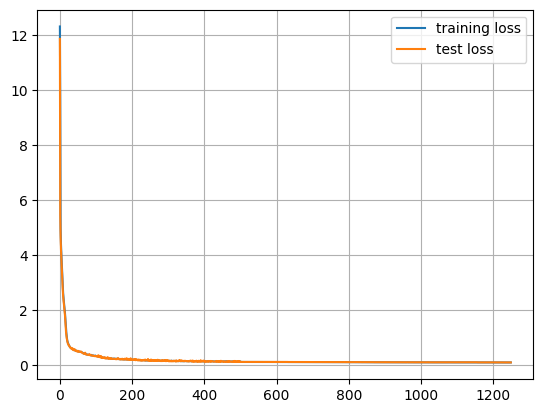

--------------------  EPOCH: 1250  --------------------
LOSS train 0.10635411649942399 valid 0.10835900902748108
--------------------  EPOCH: 1251  --------------------
LOSS train 0.10650808066129684 valid 0.10787995159626007
--------------------  EPOCH: 1252  --------------------
LOSS train 0.10679893970489501 valid 0.10793090611696243
--------------------  EPOCH: 1253  --------------------
LOSS train 0.1077181899547577 valid 0.10774426907300949
--------------------  EPOCH: 1254  --------------------
LOSS train 0.10722564905881882 valid 0.10844603180885315
--------------------  EPOCH: 1255  --------------------
LOSS train 0.10665006577968597 valid 0.10853374004364014
--------------------  EPOCH: 1256  --------------------
LOSS train 0.10643696546554565 valid 0.10839688777923584
--------------------  EPOCH: 1257  --------------------
LOSS train 0.10709184914827347 valid 0.10823899507522583
--------------------  EPOCH: 1258  --------------------
LOSS train 0.10634175181388855 valid 0.10

LOSS train 0.10507530391216278 valid 0.1071539968252182
--------------------  EPOCH: 1324  --------------------
LOSS train 0.10542080104351044 valid 0.10663067549467087
--------------------  EPOCH: 1325  --------------------
LOSS train 0.10550001710653305 valid 0.10667872428894043
--------------------  EPOCH: 1326  --------------------
LOSS train 0.10558727145195007 valid 0.10745222866535187
--------------------  EPOCH: 1327  --------------------
LOSS train 0.105257930457592 valid 0.1097738966345787
--------------------  EPOCH: 1328  --------------------
LOSS train 0.10601837784051896 valid 0.10653111338615417
--------------------  EPOCH: 1329  --------------------
LOSS train 0.10589783161878585 valid 0.10804711282253265
--------------------  EPOCH: 1330  --------------------
LOSS train 0.10553605169057846 valid 0.10855672508478165
--------------------  EPOCH: 1331  --------------------
LOSS train 0.10558965593576432 valid 0.10642486810684204
--------------------  EPOCH: 1332  --------

LOSS train 0.10407837569713592 valid 0.10524621605873108
--------------------  EPOCH: 1397  --------------------
LOSS train 0.10422676473855973 valid 0.1059487909078598
--------------------  EPOCH: 1398  --------------------
LOSS train 0.1042724671959877 valid 0.10522191971540451
--------------------  EPOCH: 1399  --------------------
LOSS train 0.10404535681009293 valid 0.10544946789741516
--------------------  EPOCH: 1400  --------------------
LOSS train 0.10394025444984437 valid 0.10527922213077545
--------------------  EPOCH: 1401  --------------------
LOSS train 0.10395215570926666 valid 0.10528676956892014
--------------------  EPOCH: 1402  --------------------
LOSS train 0.10406360894441605 valid 0.10564586520195007
--------------------  EPOCH: 1403  --------------------
LOSS train 0.10378187388181687 valid 0.1066688522696495
--------------------  EPOCH: 1404  --------------------
LOSS train 0.10452633023262024 valid 0.10692121833562851
--------------------  EPOCH: 1405  -------

LOSS train 0.1028342890739441 valid 0.10412751883268356
--------------------  EPOCH: 1470  --------------------
LOSS train 0.10256875485181809 valid 0.10408088564872742
--------------------  EPOCH: 1471  --------------------
LOSS train 0.1027074670791626 valid 0.10482976585626602
--------------------  EPOCH: 1472  --------------------
LOSS train 0.10383392214775085 valid 0.1040690615773201
--------------------  EPOCH: 1473  --------------------
LOSS train 0.1027071487903595 valid 0.10450782626867294
--------------------  EPOCH: 1474  --------------------
LOSS train 0.10268794536590577 valid 0.10507019609212875
--------------------  EPOCH: 1475  --------------------
LOSS train 0.10299936383962631 valid 0.10416512936353683
--------------------  EPOCH: 1476  --------------------
LOSS train 0.1025471630692482 valid 0.10473210364580154
--------------------  EPOCH: 1477  --------------------
LOSS train 0.10386074215173721 valid 0.10487691313028336
--------------------  EPOCH: 1478  ---------

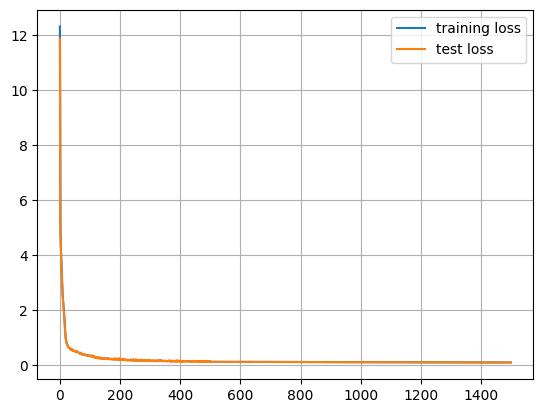

--------------------  EPOCH: 1500  --------------------
LOSS train 0.1022412770986557 valid 0.10379179567098618
--------------------  EPOCH: 1501  --------------------
LOSS train 0.1021713674068451 valid 0.10519734770059586
--------------------  EPOCH: 1502  --------------------
LOSS train 0.10248058795928955 valid 0.10439102351665497
--------------------  EPOCH: 1503  --------------------
LOSS train 0.10352201402187347 valid 0.10365359485149384
--------------------  EPOCH: 1504  --------------------
LOSS train 0.10302996575832367 valid 0.10393035411834717
--------------------  EPOCH: 1505  --------------------
LOSS train 0.10202768713235855 valid 0.10390081256628036
--------------------  EPOCH: 1506  --------------------
LOSS train 0.10283934772014618 valid 0.10376834869384766
--------------------  EPOCH: 1507  --------------------
LOSS train 0.10237998098134994 valid 0.10379228740930557
--------------------  EPOCH: 1508  --------------------
LOSS train 0.10199015170335769 valid 0.103

LOSS train 0.10128309190273285 valid 0.10258268564939499
--------------------  EPOCH: 1574  --------------------
LOSS train 0.10139197558164596 valid 0.10312380641698837
--------------------  EPOCH: 1575  --------------------
LOSS train 0.10134943455457687 valid 0.10248804092407227
--------------------  EPOCH: 1576  --------------------
LOSS train 0.1012974002957344 valid 0.10247909277677536
--------------------  EPOCH: 1577  --------------------
LOSS train 0.10130280643701553 valid 0.10249464213848114
--------------------  EPOCH: 1578  --------------------
LOSS train 0.10102493703365326 valid 0.10317274928092957
--------------------  EPOCH: 1579  --------------------
LOSS train 0.10184971004724502 valid 0.1032295897603035
--------------------  EPOCH: 1580  --------------------
LOSS train 0.10119718104600907 valid 0.10323160141706467
--------------------  EPOCH: 1581  --------------------
LOSS train 0.10166101485490799 valid 0.10279539227485657
--------------------  EPOCH: 1582  ------

LOSS train 0.10054076194763184 valid 0.10160486400127411
--------------------  EPOCH: 1647  --------------------
LOSS train 0.09992217719554901 valid 0.10192762315273285
--------------------  EPOCH: 1648  --------------------
LOSS train 0.10056486546993255 valid 0.1023404598236084
--------------------  EPOCH: 1649  --------------------
LOSS train 0.09996630012989044 valid 0.10224884748458862
--------------------  EPOCH: 1650  --------------------
LOSS train 0.10037217020988465 valid 0.10163693875074387
--------------------  EPOCH: 1651  --------------------
LOSS train 0.1003299406170845 valid 0.10181308537721634
--------------------  EPOCH: 1652  --------------------
LOSS train 0.10045377045869827 valid 0.10161231458187103
--------------------  EPOCH: 1653  --------------------
LOSS train 0.10058127433061599 valid 0.10166460275650024
--------------------  EPOCH: 1654  --------------------
LOSS train 0.09993593961000442 valid 0.10139358788728714
--------------------  EPOCH: 1655  ------

LOSS train 0.09928630292415619 valid 0.10073404759168625
--------------------  EPOCH: 1720  --------------------
LOSS train 0.0994935068488121 valid 0.10114013403654099
--------------------  EPOCH: 1721  --------------------
LOSS train 0.09971054852008819 valid 0.10077795386314392
--------------------  EPOCH: 1722  --------------------
LOSS train 0.09940162926912308 valid 0.10206373035907745
--------------------  EPOCH: 1723  --------------------
LOSS train 0.09943998247385025 valid 0.10267943143844604
--------------------  EPOCH: 1724  --------------------
LOSS train 0.09979332566261291 valid 0.10221945494413376
--------------------  EPOCH: 1725  --------------------
LOSS train 0.09939627885818482 valid 0.10045678168535233
--------------------  EPOCH: 1726  --------------------
LOSS train 0.09931662499904632 valid 0.10060040652751923
--------------------  EPOCH: 1727  --------------------
LOSS train 0.09914937049150467 valid 0.100967176258564
--------------------  EPOCH: 1728  -------

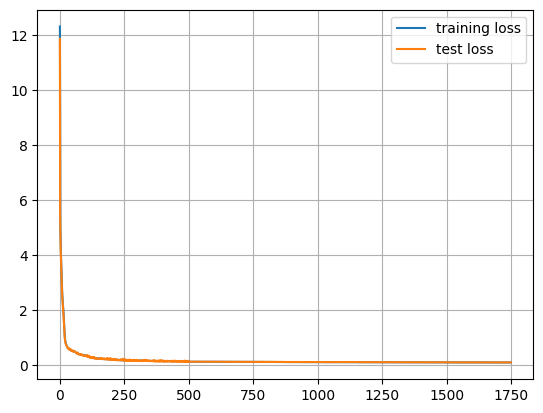

--------------------  EPOCH: 1750  --------------------
LOSS train 0.0986761623620987 valid 0.10024220496416092
--------------------  EPOCH: 1751  --------------------
LOSS train 0.0988142091035843 valid 0.1027546301484108
--------------------  EPOCH: 1752  --------------------
LOSS train 0.09977950811386109 valid 0.10038582980632782
--------------------  EPOCH: 1753  --------------------
LOSS train 0.09889697283506393 valid 0.10023301839828491
--------------------  EPOCH: 1754  --------------------
LOSS train 0.09862078130245208 valid 0.10093574970960617
--------------------  EPOCH: 1755  --------------------
LOSS train 0.09871182799339294 valid 0.10043766349554062
--------------------  EPOCH: 1756  --------------------
LOSS train 0.09879999667406082 valid 0.10024908185005188
--------------------  EPOCH: 1757  --------------------
LOSS train 0.09915675103664398 valid 0.10099317878484726
--------------------  EPOCH: 1758  --------------------
LOSS train 0.09861913800239563 valid 0.1001

LOSS train 0.09788643807172775 valid 0.10252891480922699
--------------------  EPOCH: 1824  --------------------
LOSS train 0.09808678984642029 valid 0.09916456788778305
--------------------  EPOCH: 1825  --------------------
LOSS train 0.09796991348266601 valid 0.10065445303916931
--------------------  EPOCH: 1826  --------------------
LOSS train 0.09798704981803893 valid 0.09951259195804596
--------------------  EPOCH: 1827  --------------------
LOSS train 0.09798292934894562 valid 0.09961575269699097
--------------------  EPOCH: 1828  --------------------
LOSS train 0.09828244656324386 valid 0.10092085599899292
--------------------  EPOCH: 1829  --------------------
LOSS train 0.09804838716983795 valid 0.09917093813419342
--------------------  EPOCH: 1830  --------------------
LOSS train 0.0983503320813179 valid 0.10042623430490494
--------------------  EPOCH: 1831  --------------------
LOSS train 0.09834954589605331 valid 0.09927864372730255
--------------------  EPOCH: 1832  -----

LOSS train 0.09742520540952683 valid 0.09827377647161484
--------------------  EPOCH: 1897  --------------------
LOSS train 0.096973697245121 valid 0.09834711998701096
--------------------  EPOCH: 1898  --------------------
LOSS train 0.09721504330635071 valid 0.09848811477422714
--------------------  EPOCH: 1899  --------------------
LOSS train 0.09708183735609055 valid 0.098421610891819
--------------------  EPOCH: 1900  --------------------
LOSS train 0.09696417301893234 valid 0.09834372252225876
--------------------  EPOCH: 1901  --------------------
LOSS train 0.09698223650455474 valid 0.09912176430225372
--------------------  EPOCH: 1902  --------------------
LOSS train 0.09738463580608368 valid 0.09840811043977737
--------------------  EPOCH: 1903  --------------------
LOSS train 0.0969071140885353 valid 0.09819868952035904
--------------------  EPOCH: 1904  --------------------
LOSS train 0.09691740840673446 valid 0.09853823482990265
--------------------  EPOCH: 1905  ---------

LOSS train 0.09603342622518539 valid 0.09776004403829575
--------------------  EPOCH: 1970  --------------------
LOSS train 0.09681876391172409 valid 0.09777122735977173
--------------------  EPOCH: 1971  --------------------
LOSS train 0.09640214443206788 valid 0.09742859750986099
--------------------  EPOCH: 1972  --------------------
LOSS train 0.09628680378198623 valid 0.09773316234350204
--------------------  EPOCH: 1973  --------------------
LOSS train 0.09597847998142242 valid 0.09753213822841644
--------------------  EPOCH: 1974  --------------------
LOSS train 0.09608293652534484 valid 0.09754618257284164
--------------------  EPOCH: 1975  --------------------
LOSS train 0.09616245180368424 valid 0.09729966521263123
--------------------  EPOCH: 1976  --------------------
LOSS train 0.0964790016412735 valid 0.0990741178393364
--------------------  EPOCH: 1977  --------------------
LOSS train 0.0970403379201889 valid 0.09908130764961243
--------------------  EPOCH: 1978  -------

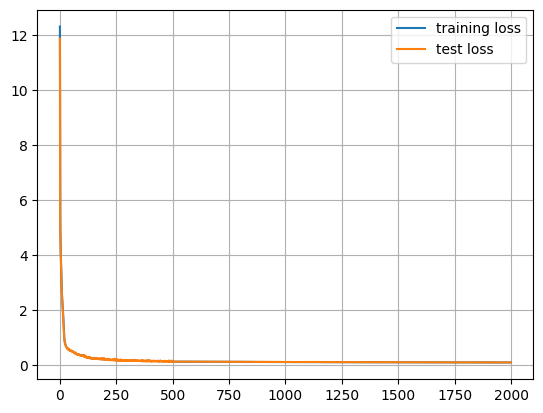

--------------------  EPOCH: 2000  --------------------
LOSS train 0.0959218156337738 valid 0.09823140501976013
--------------------  EPOCH: 2001  --------------------
LOSS train 0.09586655199527741 valid 0.09883089363574982
--------------------  EPOCH: 2002  --------------------
LOSS train 0.09627657234668732 valid 0.09887228161096573
--------------------  EPOCH: 2003  --------------------
LOSS train 0.09655312657356262 valid 0.09885958582162857
--------------------  EPOCH: 2004  --------------------
LOSS train 0.09703787177801132 valid 0.09710263460874557
--------------------  EPOCH: 2005  --------------------
LOSS train 0.09614873677492142 valid 0.09705520421266556
--------------------  EPOCH: 2006  --------------------
LOSS train 0.09566449254751205 valid 0.09747562557458878
--------------------  EPOCH: 2007  --------------------
LOSS train 0.09562881350517273 valid 0.09728293865919113
--------------------  EPOCH: 2008  --------------------
LOSS train 0.0958102062344551 valid 0.096

LOSS train 0.09487908303737641 valid 0.09635765105485916
--------------------  EPOCH: 2074  --------------------
LOSS train 0.09512029081583023 valid 0.0963427722454071
--------------------  EPOCH: 2075  --------------------
LOSS train 0.09491836577653885 valid 0.09632256627082825
--------------------  EPOCH: 2076  --------------------
LOSS train 0.0952369424700737 valid 0.09678380936384201
--------------------  EPOCH: 2077  --------------------
LOSS train 0.09483298242092132 valid 0.09631863236427307
--------------------  EPOCH: 2078  --------------------
LOSS train 0.09563151985406876 valid 0.0972764790058136
--------------------  EPOCH: 2079  --------------------
LOSS train 0.09593587219715119 valid 0.09655019640922546
--------------------  EPOCH: 2080  --------------------
LOSS train 0.09529684633016586 valid 0.09796392172574997
--------------------  EPOCH: 2081  --------------------
LOSS train 0.09589337795972824 valid 0.09790217131376266
--------------------  EPOCH: 2082  -------

LOSS train 0.09397893220186233 valid 0.09551402926445007
--------------------  EPOCH: 2147  --------------------
LOSS train 0.09389866381883621 valid 0.09550586342811584
--------------------  EPOCH: 2148  --------------------
LOSS train 0.09386464208364487 valid 0.09550791233778
--------------------  EPOCH: 2149  --------------------
LOSS train 0.09390174180269241 valid 0.09555849432945251
--------------------  EPOCH: 2150  --------------------
LOSS train 0.09389046341180801 valid 0.09550853073596954
--------------------  EPOCH: 2151  --------------------
LOSS train 0.09396440744400024 valid 0.09555653482675552
--------------------  EPOCH: 2152  --------------------
LOSS train 0.09389437824487686 valid 0.09553074091672897
--------------------  EPOCH: 2153  --------------------
LOSS train 0.09383241772651672 valid 0.0955209955573082
--------------------  EPOCH: 2154  --------------------
LOSS train 0.09396915376186371 valid 0.09556034952402115
--------------------  EPOCH: 2155  --------

LOSS train 0.093797108232975 valid 0.09544827044010162
--------------------  EPOCH: 2219  --------------------
LOSS train 0.09385988920927048 valid 0.09544804692268372
--------------------  EPOCH: 2220  --------------------
LOSS train 0.09384474694728852 valid 0.09544827789068222
--------------------  EPOCH: 2221  --------------------
LOSS train 0.09378885328769684 valid 0.0954480916261673
--------------------  EPOCH: 2222  --------------------
LOSS train 0.09379486471414566 valid 0.09544827789068222
--------------------  EPOCH: 2223  --------------------
LOSS train 0.09385316997766495 valid 0.09544792026281357
--------------------  EPOCH: 2224  --------------------
LOSS train 0.09379451125860214 valid 0.09544897079467773
--------------------  EPOCH: 2225  --------------------
LOSS train 0.09398211658000946 valid 0.09544814378023148
--------------------  EPOCH: 2226  --------------------
LOSS train 0.09391001969575882 valid 0.09544822573661804
--------------------  EPOCH: 2227  -------

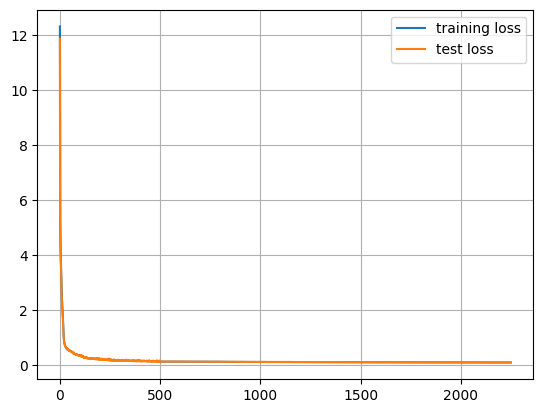

--------------------  EPOCH: 2250  --------------------
LOSS train 0.09384670346975327 valid 0.0954480841755867
--------------------  EPOCH: 2251  --------------------
LOSS train 0.09377790480852127 valid 0.09544773399829865
--------------------  EPOCH: 2252  --------------------
LOSS train 0.09376057595014572 valid 0.09544811397790909
--------------------  EPOCH: 2253  --------------------
LOSS train 0.09379608124494553 valid 0.09544803947210312
--------------------  EPOCH: 2254  --------------------
LOSS train 0.09369977325201034 valid 0.09544803947210312
--------------------  EPOCH: 2255  --------------------
LOSS train 0.09382817029953003 valid 0.09544835984706879
--------------------  EPOCH: 2256  --------------------
LOSS train 0.0937619635462761 valid 0.095447838306427
--------------------  EPOCH: 2257  --------------------
LOSS train 0.09378028392791748 valid 0.09544788300991058
--------------------  EPOCH: 2258  --------------------
LOSS train 0.093796506524086 valid 0.0954480

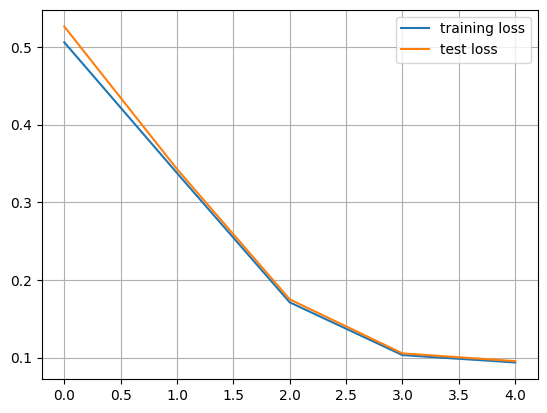

data_size: 200000
--------------------  EPOCH: 0  --------------------
LOSS train 11.155562809535436 valid 6.806334495544434
--------------------  EPOCH: 1  --------------------
LOSS train 5.032440905668298 valid 4.47825288772583
--------------------  EPOCH: 2  --------------------
LOSS train 4.115933267437682 valid 3.7673373222351074
--------------------  EPOCH: 3  --------------------
LOSS train 3.456293232586919 valid 3.1083900928497314
--------------------  EPOCH: 4  --------------------
LOSS train 2.6875250972047144 valid 2.3099405765533447
--------------------  EPOCH: 5  --------------------
LOSS train 2.162263904299055 valid 2.0480268001556396
--------------------  EPOCH: 6  --------------------
LOSS train 1.9362787884108874 valid 1.8110809326171875
--------------------  EPOCH: 7  --------------------
LOSS train 1.6600219619517425 valid 1.4724669456481934
--------------------  EPOCH: 8  --------------------
LOSS train 1.3010847203585567 valid 1.1193280220031738
-----------------

LOSS train 0.339216488356493 valid 0.3326663076877594
--------------------  EPOCH: 76  --------------------
LOSS train 0.3392011803023669 valid 0.33517080545425415
--------------------  EPOCH: 77  --------------------
LOSS train 0.33089413204971624 valid 0.3255602717399597
--------------------  EPOCH: 78  --------------------
LOSS train 0.3321823897410412 valid 0.33366659283638
--------------------  EPOCH: 79  --------------------
LOSS train 0.3296553936539864 valid 0.330366849899292
--------------------  EPOCH: 80  --------------------
LOSS train 0.3286248913833073 valid 0.3343781530857086
--------------------  EPOCH: 81  --------------------
LOSS train 0.33134522121779775 valid 0.3655625283718109
--------------------  EPOCH: 82  --------------------
LOSS train 0.33957645601155806 valid 0.35721755027770996
--------------------  EPOCH: 83  --------------------
LOSS train 0.33293149605089306 valid 0.33784615993499756
--------------------  EPOCH: 84  --------------------
LOSS train 0.326

LOSS train 0.2347796106216859 valid 0.2482360303401947
--------------------  EPOCH: 151  --------------------
LOSS train 0.23081032323593997 valid 0.2169913649559021
--------------------  EPOCH: 152  --------------------
LOSS train 0.22564573738039756 valid 0.2166249006986618
--------------------  EPOCH: 153  --------------------
LOSS train 0.22444079694699268 valid 0.23255600035190582
--------------------  EPOCH: 154  --------------------
LOSS train 0.22651014826735671 valid 0.21756888926029205
--------------------  EPOCH: 155  --------------------
LOSS train 0.21874876746109553 valid 0.21296323835849762
--------------------  EPOCH: 156  --------------------
LOSS train 0.2217255027926698 valid 0.2510330379009247
--------------------  EPOCH: 157  --------------------
LOSS train 0.2206204947160215 valid 0.2385806441307068
--------------------  EPOCH: 158  --------------------
LOSS train 0.2204689264905696 valid 0.21094202995300293
--------------------  EPOCH: 159  --------------------
L

LOSS train 0.18828815769176094 valid 0.1897595077753067
--------------------  EPOCH: 225  --------------------
LOSS train 0.19153715670108795 valid 0.20838835835456848
--------------------  EPOCH: 226  --------------------
LOSS train 0.18825335526952938 valid 0.1930421143770218
--------------------  EPOCH: 227  --------------------
LOSS train 0.1901369316845524 valid 0.18452228605747223
--------------------  EPOCH: 228  --------------------
LOSS train 0.19027980432218436 valid 0.17820632457733154
--------------------  EPOCH: 229  --------------------
LOSS train 0.18864786533676847 valid 0.21675169467926025
--------------------  EPOCH: 230  --------------------
LOSS train 0.19124144832698667 valid 0.19323769211769104
--------------------  EPOCH: 231  --------------------
LOSS train 0.18420793207324282 valid 0.1900176703929901
--------------------  EPOCH: 232  --------------------
LOSS train 0.18542367159103862 valid 0.20100387930870056
--------------------  EPOCH: 233  -----------------

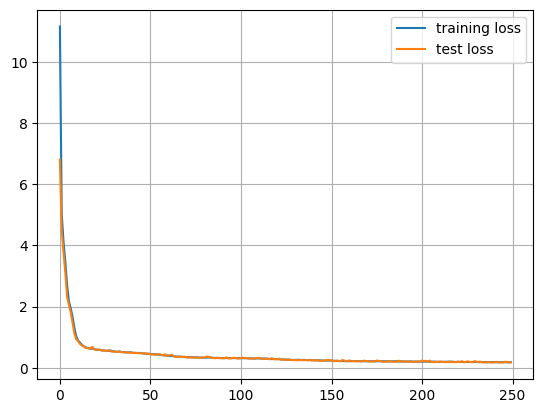

--------------------  EPOCH: 250  --------------------
LOSS train 0.1808752347620166 valid 0.17244431376457214
--------------------  EPOCH: 251  --------------------
LOSS train 0.18053774900582373 valid 0.2013755440711975
--------------------  EPOCH: 252  --------------------
LOSS train 0.17803202508663646 valid 0.1747284233570099
--------------------  EPOCH: 253  --------------------
LOSS train 0.17981026793012814 valid 0.17326954007148743
--------------------  EPOCH: 254  --------------------
LOSS train 0.177064343678708 valid 0.19254271686077118
--------------------  EPOCH: 255  --------------------
LOSS train 0.17398804517424837 valid 0.17472374439239502
--------------------  EPOCH: 256  --------------------
LOSS train 0.18114826052772756 valid 0.18753798305988312
--------------------  EPOCH: 257  --------------------
LOSS train 0.1812094866621251 valid 0.18367575109004974
--------------------  EPOCH: 258  --------------------
LOSS train 0.17768958271766194 valid 0.1862634122371673

LOSS train 0.16305642134072829 valid 0.18113534152507782
--------------------  EPOCH: 325  --------------------
LOSS train 0.16501611653639345 valid 0.17637422680854797
--------------------  EPOCH: 326  --------------------
LOSS train 0.1617696519408907 valid 0.15458205342292786
--------------------  EPOCH: 327  --------------------
LOSS train 0.16187455733211673 valid 0.15737402439117432
--------------------  EPOCH: 328  --------------------
LOSS train 0.16358632822425997 valid 0.15379224717617035
--------------------  EPOCH: 329  --------------------
LOSS train 0.16079537083908002 valid 0.16076026856899261
--------------------  EPOCH: 330  --------------------
LOSS train 0.16105541769339113 valid 0.1810516119003296
--------------------  EPOCH: 331  --------------------
LOSS train 0.16112680185814293 valid 0.1617182046175003
--------------------  EPOCH: 332  --------------------
LOSS train 0.15910892827170237 valid 0.1608734279870987
--------------------  EPOCH: 333  -----------------

LOSS train 0.14852173383138617 valid 0.15574927628040314
--------------------  EPOCH: 399  --------------------
LOSS train 0.15050366612113253 valid 0.1527138501405716
--------------------  EPOCH: 400  --------------------
LOSS train 0.14425850583582508 valid 0.14782385528087616
--------------------  EPOCH: 401  --------------------
LOSS train 0.14880171266137338 valid 0.1405634880065918
--------------------  EPOCH: 402  --------------------
LOSS train 0.15325627430361144 valid 0.14435210824012756
--------------------  EPOCH: 403  --------------------
LOSS train 0.14755744623894596 valid 0.13855913281440735
--------------------  EPOCH: 404  --------------------
LOSS train 0.14684724655686593 valid 0.14057302474975586
--------------------  EPOCH: 405  --------------------
LOSS train 0.14875679478353385 valid 0.16198624670505524
--------------------  EPOCH: 406  --------------------
LOSS train 0.1474084279366902 valid 0.1438286453485489
--------------------  EPOCH: 407  -----------------

LOSS train 0.13724703128848756 valid 0.15755748748779297
--------------------  EPOCH: 473  --------------------
LOSS train 0.14482423921628873 valid 0.12680499255657196
--------------------  EPOCH: 474  --------------------
LOSS train 0.13500675467812284 valid 0.13225848972797394
--------------------  EPOCH: 475  --------------------
LOSS train 0.13492452566112792 valid 0.1382691115140915
--------------------  EPOCH: 476  --------------------
LOSS train 0.14036990291610055 valid 0.12670379877090454
--------------------  EPOCH: 477  --------------------
LOSS train 0.1358647880201437 valid 0.13501818478107452
--------------------  EPOCH: 478  --------------------
LOSS train 0.13855710458390566 valid 0.1338721364736557
--------------------  EPOCH: 479  --------------------
LOSS train 0.13963695600324746 valid 0.13219793140888214
--------------------  EPOCH: 480  --------------------
LOSS train 0.13466092533603005 valid 0.12907420098781586
--------------------  EPOCH: 481  ----------------

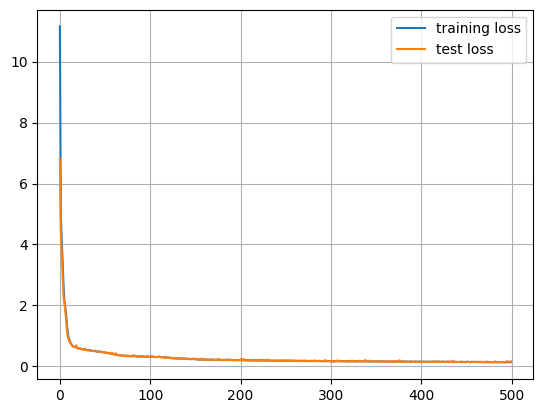

--------------------  EPOCH: 500  --------------------
LOSS train 0.13077114826562453 valid 0.12981511652469635
--------------------  EPOCH: 501  --------------------
LOSS train 0.13577297557981646 valid 0.1266557276248932
--------------------  EPOCH: 502  --------------------
LOSS train 0.13542478136262115 valid 0.14268270134925842
--------------------  EPOCH: 503  --------------------
LOSS train 0.13332024840067844 valid 0.12284133583307266
--------------------  EPOCH: 504  --------------------
LOSS train 0.13273027204737373 valid 0.14800183475017548
--------------------  EPOCH: 505  --------------------
LOSS train 0.13504526429638572 valid 0.12771350145339966
--------------------  EPOCH: 506  --------------------
LOSS train 0.13286817529980016 valid 0.14798852801322937
--------------------  EPOCH: 507  --------------------
LOSS train 0.1315231084519503 valid 0.13479173183441162
--------------------  EPOCH: 508  --------------------
LOSS train 0.13464393116989914 valid 0.136750251054

LOSS train 0.11628553864299035 valid 0.11734599620103836
--------------------  EPOCH: 574  --------------------
LOSS train 0.11615235054371309 valid 0.11729457229375839
--------------------  EPOCH: 575  --------------------
LOSS train 0.11626835882055517 valid 0.11771538853645325
--------------------  EPOCH: 576  --------------------
LOSS train 0.11615768744021046 valid 0.11731307208538055
--------------------  EPOCH: 577  --------------------
LOSS train 0.11619064014176933 valid 0.11726143956184387
--------------------  EPOCH: 578  --------------------
LOSS train 0.1163157974274791 valid 0.11727062612771988
--------------------  EPOCH: 579  --------------------
LOSS train 0.1161433725940938 valid 0.11736837029457092
--------------------  EPOCH: 580  --------------------
LOSS train 0.1161135907988159 valid 0.1172347217798233
--------------------  EPOCH: 581  --------------------
LOSS train 0.11607851316126025 valid 0.11728961020708084
--------------------  EPOCH: 582  -----------------

LOSS train 0.1139763059968851 valid 0.11505236476659775
--------------------  EPOCH: 648  --------------------
LOSS train 0.11464038187143755 valid 0.1150205209851265
--------------------  EPOCH: 649  --------------------
LOSS train 0.11402769979773736 valid 0.11541825532913208
--------------------  EPOCH: 650  --------------------
LOSS train 0.11407858695910901 valid 0.11600364744663239
--------------------  EPOCH: 651  --------------------
LOSS train 0.1144449209072152 valid 0.11536389589309692
--------------------  EPOCH: 652  --------------------
LOSS train 0.1141341602315708 valid 0.11525270342826843
--------------------  EPOCH: 653  --------------------
LOSS train 0.11398557406298969 valid 0.11467339098453522
--------------------  EPOCH: 654  --------------------
LOSS train 0.11512933762706055 valid 0.11601928621530533
--------------------  EPOCH: 655  --------------------
LOSS train 0.11494214224572084 valid 0.11479193717241287
--------------------  EPOCH: 656  -----------------

LOSS train 0.11229489895762229 valid 0.11436868458986282
--------------------  EPOCH: 722  --------------------
LOSS train 0.11178491781560743 valid 0.11269432306289673
--------------------  EPOCH: 723  --------------------
LOSS train 0.11172520019570176 valid 0.11283345520496368
--------------------  EPOCH: 724  --------------------
LOSS train 0.11165967659682643 valid 0.11248933523893356
--------------------  EPOCH: 725  --------------------
LOSS train 0.11174603901347335 valid 0.11316392570734024
--------------------  EPOCH: 726  --------------------
LOSS train 0.11196892556487298 valid 0.11253856122493744
--------------------  EPOCH: 727  --------------------
LOSS train 0.11166371982924793 valid 0.11316759139299393
--------------------  EPOCH: 728  --------------------
LOSS train 0.11181218618032884 valid 0.11345063894987106
--------------------  EPOCH: 729  --------------------
LOSS train 0.11168670715117941 valid 0.11354918032884598
--------------------  EPOCH: 730  -------------

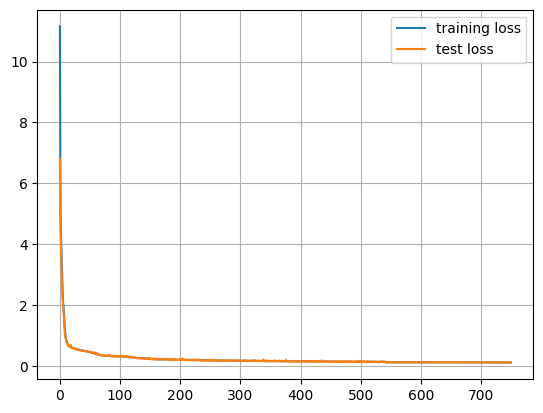

--------------------  EPOCH: 750  --------------------
LOSS train 0.1108389150123207 valid 0.11220298707485199
--------------------  EPOCH: 751  --------------------
LOSS train 0.11106842148060701 valid 0.11250758916139603
--------------------  EPOCH: 752  --------------------
LOSS train 0.11093262552606817 valid 0.11262863129377365
--------------------  EPOCH: 753  --------------------
LOSS train 0.111451478028784 valid 0.11173567175865173
--------------------  EPOCH: 754  --------------------
LOSS train 0.11102206092707965 valid 0.11230747401714325
--------------------  EPOCH: 755  --------------------
LOSS train 0.11113807376550168 valid 0.1126411035656929
--------------------  EPOCH: 756  --------------------
LOSS train 0.11105991459014464 valid 0.11148540675640106
--------------------  EPOCH: 757  --------------------
LOSS train 0.11115517984239423 valid 0.111601322889328
--------------------  EPOCH: 758  --------------------
LOSS train 0.11076476789858876 valid 0.1118947938084602

LOSS train 0.10890911504322169 valid 0.1098698079586029
--------------------  EPOCH: 824  --------------------
LOSS train 0.1090591230562755 valid 0.11050981283187866
--------------------  EPOCH: 825  --------------------
LOSS train 0.10888458940447593 valid 0.10997797548770905
--------------------  EPOCH: 826  --------------------
LOSS train 0.10912856185922817 valid 0.10958024859428406
--------------------  EPOCH: 827  --------------------
LOSS train 0.10910565086773463 valid 0.10953423380851746
--------------------  EPOCH: 828  --------------------
LOSS train 0.10873849233802484 valid 0.10970187932252884
--------------------  EPOCH: 829  --------------------
LOSS train 0.10905874018766443 valid 0.10946774482727051
--------------------  EPOCH: 830  --------------------
LOSS train 0.10897450225085628 valid 0.10947796702384949
--------------------  EPOCH: 831  --------------------
LOSS train 0.10880264259722768 valid 0.10994461178779602
--------------------  EPOCH: 832  ---------------

LOSS train 0.10739600217464018 valid 0.10758616030216217
--------------------  EPOCH: 898  --------------------
LOSS train 0.10714825516452595 valid 0.1076071485877037
--------------------  EPOCH: 899  --------------------
LOSS train 0.10681491253935561 valid 0.10768349468708038
--------------------  EPOCH: 900  --------------------
LOSS train 0.10716017685374435 valid 0.1098816767334938
--------------------  EPOCH: 901  --------------------
LOSS train 0.10720402017539861 valid 0.10842043161392212
--------------------  EPOCH: 902  --------------------
LOSS train 0.10733713224834325 valid 0.10770885646343231
--------------------  EPOCH: 903  --------------------
LOSS train 0.10693326014645245 valid 0.10748607665300369
--------------------  EPOCH: 904  --------------------
LOSS train 0.1071459494379102 valid 0.1074438989162445
--------------------  EPOCH: 905  --------------------
LOSS train 0.10695038553403348 valid 0.10750758647918701
--------------------  EPOCH: 906  -----------------

LOSS train 0.10514741178069796 valid 0.10590188205242157
--------------------  EPOCH: 972  --------------------
LOSS train 0.10606648712133875 valid 0.1070341020822525
--------------------  EPOCH: 973  --------------------
LOSS train 0.1052107880918347 valid 0.106465183198452
--------------------  EPOCH: 974  --------------------
LOSS train 0.10537284551834573 valid 0.10569502413272858
--------------------  EPOCH: 975  --------------------
LOSS train 0.10526091651040681 valid 0.10580527782440186
--------------------  EPOCH: 976  --------------------
LOSS train 0.10496978157637071 valid 0.10577099770307541
--------------------  EPOCH: 977  --------------------
LOSS train 0.10504676051894013 valid 0.10664454847574234
--------------------  EPOCH: 978  --------------------
LOSS train 0.10557547926294561 valid 0.10593757778406143
--------------------  EPOCH: 979  --------------------
LOSS train 0.10554763811583422 valid 0.10596048831939697
--------------------  EPOCH: 980  -----------------

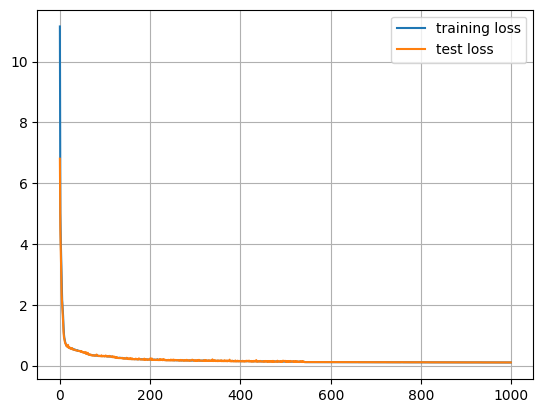

--------------------  EPOCH: 1000  --------------------
LOSS train 0.10545716449922445 valid 0.10727891325950623
--------------------  EPOCH: 1001  --------------------
LOSS train 0.10489523699697183 valid 0.10516110807657242
--------------------  EPOCH: 1002  --------------------
LOSS train 0.10423157622619551 valid 0.10524207353591919
--------------------  EPOCH: 1003  --------------------
LOSS train 0.10437857314031951 valid 0.10501492023468018
--------------------  EPOCH: 1004  --------------------
LOSS train 0.10430578796231017 valid 0.10542767494916916
--------------------  EPOCH: 1005  --------------------
LOSS train 0.10492850916118038 valid 0.10564978420734406
--------------------  EPOCH: 1006  --------------------
LOSS train 0.1045758415545736 valid 0.1051783636212349
--------------------  EPOCH: 1007  --------------------
LOSS train 0.10462695709904846 valid 0.105538010597229
--------------------  EPOCH: 1008  --------------------
LOSS train 0.1047225291935765 valid 0.105168

LOSS train 0.10341075868630896 valid 0.1039319708943367
--------------------  EPOCH: 1074  --------------------
LOSS train 0.10261925842080798 valid 0.10416939854621887
--------------------  EPOCH: 1075  --------------------
LOSS train 0.10326899983444993 valid 0.10309794545173645
--------------------  EPOCH: 1076  --------------------
LOSS train 0.10265590995550156 valid 0.10343826562166214
--------------------  EPOCH: 1077  --------------------
LOSS train 0.10294511701379504 valid 0.10396619141101837
--------------------  EPOCH: 1078  --------------------
LOSS train 0.10270502205405917 valid 0.10322119295597076
--------------------  EPOCH: 1079  --------------------
LOSS train 0.10279223246842015 valid 0.10530470311641693
--------------------  EPOCH: 1080  --------------------
LOSS train 0.10268362307426881 valid 0.10423588752746582
--------------------  EPOCH: 1081  --------------------
LOSS train 0.10252677877338565 valid 0.10340581834316254
--------------------  EPOCH: 1082  -----

LOSS train 0.10047172177202847 valid 0.10109371691942215
--------------------  EPOCH: 1147  --------------------
LOSS train 0.10039700461285454 valid 0.10136545449495316
--------------------  EPOCH: 1148  --------------------
LOSS train 0.10080906231792605 valid 0.10124179720878601
--------------------  EPOCH: 1149  --------------------
LOSS train 0.10032140828517018 valid 0.10141981393098831
--------------------  EPOCH: 1150  --------------------
LOSS train 0.10037551637814969 valid 0.10146954655647278
--------------------  EPOCH: 1151  --------------------
LOSS train 0.10034606818641935 valid 0.10091661661863327
--------------------  EPOCH: 1152  --------------------
LOSS train 0.10013796693208266 valid 0.10137420147657394
--------------------  EPOCH: 1153  --------------------
LOSS train 0.10037229210138321 valid 0.1012120172381401
--------------------  EPOCH: 1154  --------------------
LOSS train 0.10012023455026198 valid 0.10088846832513809
--------------------  EPOCH: 1155  -----

LOSS train 0.09854013123074357 valid 0.0988217443227768
--------------------  EPOCH: 1220  --------------------
LOSS train 0.09831917437971854 valid 0.09894107282161713
--------------------  EPOCH: 1221  --------------------
LOSS train 0.09822096097834256 valid 0.09911298006772995
--------------------  EPOCH: 1222  --------------------
LOSS train 0.0980693191594007 valid 0.09881176054477692
--------------------  EPOCH: 1223  --------------------
LOSS train 0.09798981355769294 valid 0.09918263554573059
--------------------  EPOCH: 1224  --------------------
LOSS train 0.09831073530474488 valid 0.09922204166650772
--------------------  EPOCH: 1225  --------------------
LOSS train 0.09797115852029956 valid 0.09875088930130005
--------------------  EPOCH: 1226  --------------------
LOSS train 0.09799859946479603 valid 0.09870744496583939
--------------------  EPOCH: 1227  --------------------
LOSS train 0.09816706393446241 valid 0.10003594309091568
--------------------  EPOCH: 1228  ------

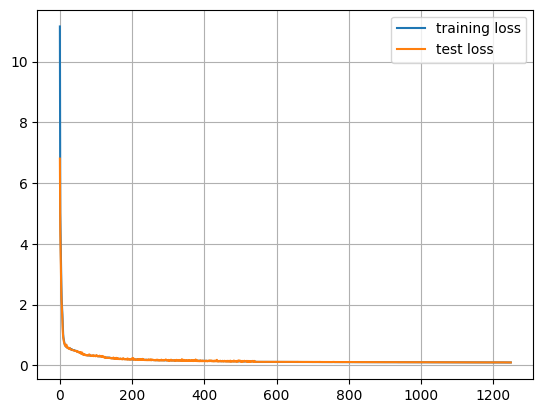

--------------------  EPOCH: 1250  --------------------
LOSS train 0.09774136330400195 valid 0.09909035265445709
--------------------  EPOCH: 1251  --------------------
LOSS train 0.09728795153145887 valid 0.09804230183362961
--------------------  EPOCH: 1252  --------------------
LOSS train 0.09732872901522384 valid 0.09795521199703217
--------------------  EPOCH: 1253  --------------------
LOSS train 0.09760570161196651 valid 0.0993262305855751
--------------------  EPOCH: 1254  --------------------
LOSS train 0.09709529609096293 valid 0.09845241904258728
--------------------  EPOCH: 1255  --------------------
LOSS train 0.09719731461028663 valid 0.09807800501585007
--------------------  EPOCH: 1256  --------------------
LOSS train 0.09705591110550628 valid 0.09831562638282776
--------------------  EPOCH: 1257  --------------------
LOSS train 0.09713179268399064 valid 0.0979268029332161
--------------------  EPOCH: 1258  --------------------
LOSS train 0.09714996358569787 valid 0.097

LOSS train 0.09545369279019687 valid 0.09599859267473221
--------------------  EPOCH: 1324  --------------------
LOSS train 0.09512837261569743 valid 0.09658199548721313
--------------------  EPOCH: 1325  --------------------
LOSS train 0.0954057218468919 valid 0.09596032649278641
--------------------  EPOCH: 1326  --------------------
LOSS train 0.0954837837085432 valid 0.0958111360669136
--------------------  EPOCH: 1327  --------------------
LOSS train 0.0954049147513448 valid 0.09624458104372025
--------------------  EPOCH: 1328  --------------------
LOSS train 0.09527453673737389 valid 0.09597291052341461
--------------------  EPOCH: 1329  --------------------
LOSS train 0.09499077438091745 valid 0.0958344116806984
--------------------  EPOCH: 1330  --------------------
LOSS train 0.09505445297275271 valid 0.09679033607244492
--------------------  EPOCH: 1331  --------------------
LOSS train 0.0949745315070055 valid 0.09587457776069641
--------------------  EPOCH: 1332  ----------

LOSS train 0.09314207002824666 valid 0.0942041426897049
--------------------  EPOCH: 1397  --------------------
LOSS train 0.09358419690813337 valid 0.09410231560468674
--------------------  EPOCH: 1398  --------------------
LOSS train 0.09317778446236435 valid 0.09389454871416092
--------------------  EPOCH: 1399  --------------------
LOSS train 0.09336290173992819 valid 0.09479014575481415
--------------------  EPOCH: 1400  --------------------
LOSS train 0.0931841854234131 valid 0.09467381983995438
--------------------  EPOCH: 1401  --------------------
LOSS train 0.0932379693401103 valid 0.09383941441774368
--------------------  EPOCH: 1402  --------------------
LOSS train 0.09353458166730647 valid 0.09437523037195206
--------------------  EPOCH: 1403  --------------------
LOSS train 0.09362985041676736 valid 0.09383989125490189
--------------------  EPOCH: 1404  --------------------
LOSS train 0.09300278081577651 valid 0.09469706565141678
--------------------  EPOCH: 1405  -------

LOSS train 0.0915663123739009 valid 0.09304309636354446
--------------------  EPOCH: 1470  --------------------
LOSS train 0.09214213429665079 valid 0.09265708178281784
--------------------  EPOCH: 1471  --------------------
LOSS train 0.09178950242242034 valid 0.09335465729236603
--------------------  EPOCH: 1472  --------------------
LOSS train 0.09171127178231064 valid 0.0923118144273758
--------------------  EPOCH: 1473  --------------------
LOSS train 0.09142482204704869 valid 0.0920199453830719
--------------------  EPOCH: 1474  --------------------
LOSS train 0.09157960375352782 valid 0.09226899594068527
--------------------  EPOCH: 1475  --------------------
LOSS train 0.09154203518921016 valid 0.09282805025577545
--------------------  EPOCH: 1476  --------------------
LOSS train 0.0914928139168389 valid 0.09323012083768845
--------------------  EPOCH: 1477  --------------------
LOSS train 0.09155654511889633 valid 0.09256744384765625
--------------------  EPOCH: 1478  --------

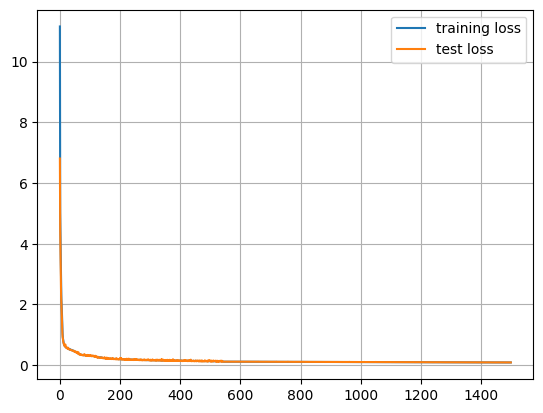

--------------------  EPOCH: 1500  --------------------
LOSS train 0.09072444907256536 valid 0.09152577072381973
--------------------  EPOCH: 1501  --------------------
LOSS train 0.0909766360205047 valid 0.0915234237909317
--------------------  EPOCH: 1502  --------------------
LOSS train 0.09069744482332347 valid 0.09137248992919922
--------------------  EPOCH: 1503  --------------------
LOSS train 0.09105461790245406 valid 0.09232550114393234
--------------------  EPOCH: 1504  --------------------
LOSS train 0.09091280765679417 valid 0.09166239947080612
--------------------  EPOCH: 1505  --------------------
LOSS train 0.09058732676262758 valid 0.09142552316188812
--------------------  EPOCH: 1506  --------------------
LOSS train 0.09049506987235983 valid 0.09151095896959305
--------------------  EPOCH: 1507  --------------------
LOSS train 0.0905466678799415 valid 0.0913710668683052
--------------------  EPOCH: 1508  --------------------
LOSS train 0.09044956066170518 valid 0.09151

LOSS train 0.08954575490586612 valid 0.09189602732658386
--------------------  EPOCH: 1574  --------------------
LOSS train 0.08982268690454717 valid 0.08976024389266968
--------------------  EPOCH: 1575  --------------------
LOSS train 0.08921627198555032 valid 0.08997363597154617
--------------------  EPOCH: 1576  --------------------
LOSS train 0.0891175429735865 valid 0.08998385816812515
--------------------  EPOCH: 1577  --------------------
LOSS train 0.08963437500048657 valid 0.09077084809541702
--------------------  EPOCH: 1578  --------------------
LOSS train 0.08980179015471011 valid 0.08976145088672638
--------------------  EPOCH: 1579  --------------------
LOSS train 0.08902279698118871 valid 0.09073273837566376
--------------------  EPOCH: 1580  --------------------
LOSS train 0.08884022856245236 valid 0.0896555483341217
--------------------  EPOCH: 1581  --------------------
LOSS train 0.08904017067077208 valid 0.08956878632307053
--------------------  EPOCH: 1582  ------

LOSS train 0.0873340596349872 valid 0.08840291202068329
--------------------  EPOCH: 1647  --------------------
LOSS train 0.08737807994594379 valid 0.08828163146972656
--------------------  EPOCH: 1648  --------------------
LOSS train 0.08739369818750693 valid 0.08798765391111374
--------------------  EPOCH: 1649  --------------------
LOSS train 0.08753872890861666 valid 0.08801066130399704
--------------------  EPOCH: 1650  --------------------
LOSS train 0.08728834484912912 valid 0.08800671249628067
--------------------  EPOCH: 1651  --------------------
LOSS train 0.08732958578941774 valid 0.08805109560489655
--------------------  EPOCH: 1652  --------------------
LOSS train 0.0870753915942445 valid 0.0878269225358963
--------------------  EPOCH: 1653  --------------------
LOSS train 0.0871212157059689 valid 0.0879221111536026
--------------------  EPOCH: 1654  --------------------
LOSS train 0.0871841376837419 valid 0.08833394944667816
--------------------  EPOCH: 1655  ----------

LOSS train 0.08506076113910091 valid 0.08591175079345703
--------------------  EPOCH: 1720  --------------------
LOSS train 0.08509428981615573 valid 0.08579738438129425
--------------------  EPOCH: 1721  --------------------
LOSS train 0.08510335610837352 valid 0.08569438010454178
--------------------  EPOCH: 1722  --------------------
LOSS train 0.0857607909307188 valid 0.08568120002746582
--------------------  EPOCH: 1723  --------------------
LOSS train 0.08555259205857102 valid 0.087387315928936
--------------------  EPOCH: 1724  --------------------
LOSS train 0.08500814316224078 valid 0.0858183428645134
--------------------  EPOCH: 1725  --------------------
LOSS train 0.08537071897667281 valid 0.08552321046590805
--------------------  EPOCH: 1726  --------------------
LOSS train 0.0849510508836532 valid 0.08571311831474304
--------------------  EPOCH: 1727  --------------------
LOSS train 0.08494211490056952 valid 0.08659946173429489
--------------------  EPOCH: 1728  ---------

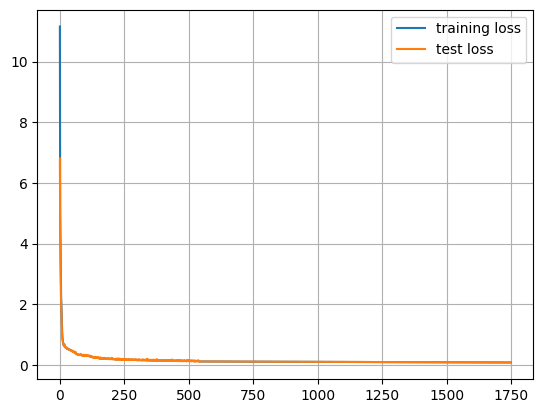

--------------------  EPOCH: 1750  --------------------
LOSS train 0.08454075820591984 valid 0.0858684703707695
--------------------  EPOCH: 1751  --------------------
LOSS train 0.08551363555752502 valid 0.08581851422786713
--------------------  EPOCH: 1752  --------------------
LOSS train 0.08458559412737282 valid 0.08504300564527512
--------------------  EPOCH: 1753  --------------------
LOSS train 0.08455062885673678 valid 0.08497797697782516
--------------------  EPOCH: 1754  --------------------
LOSS train 0.08433035426602072 valid 0.08509651571512222
--------------------  EPOCH: 1755  --------------------
LOSS train 0.0840092880689368 valid 0.08489688485860825
--------------------  EPOCH: 1756  --------------------
LOSS train 0.08401318563490498 valid 0.08470465987920761
--------------------  EPOCH: 1757  --------------------
LOSS train 0.08403280635877532 valid 0.0852811336517334
--------------------  EPOCH: 1758  --------------------
LOSS train 0.08415106547122099 valid 0.0851

LOSS train 0.08338243651146791 valid 0.08340777456760406
--------------------  EPOCH: 1824  --------------------
LOSS train 0.08294146386336307 valid 0.08378243446350098
--------------------  EPOCH: 1825  --------------------
LOSS train 0.08273282343027544 valid 0.08344117552042007
--------------------  EPOCH: 1826  --------------------
LOSS train 0.08264337130347077 valid 0.0835268571972847
--------------------  EPOCH: 1827  --------------------
LOSS train 0.08274154106573182 valid 0.08444610983133316
--------------------  EPOCH: 1828  --------------------
LOSS train 0.0825583989522895 valid 0.08405119925737381
--------------------  EPOCH: 1829  --------------------
LOSS train 0.08277216234377452 valid 0.0836050882935524
--------------------  EPOCH: 1830  --------------------
LOSS train 0.08296105767391165 valid 0.08392712473869324
--------------------  EPOCH: 1831  --------------------
LOSS train 0.08255877847574195 valid 0.08331606537103653
--------------------  EPOCH: 1832  -------

LOSS train 0.08138549054155544 valid 0.08203328400850296
--------------------  EPOCH: 1897  --------------------
LOSS train 0.08139341750315257 valid 0.08265413343906403
--------------------  EPOCH: 1898  --------------------
LOSS train 0.08151303429384621 valid 0.08217037469148636
--------------------  EPOCH: 1899  --------------------
LOSS train 0.08163476111937543 valid 0.08224271982908249
--------------------  EPOCH: 1900  --------------------
LOSS train 0.08175168216836695 valid 0.08222150802612305
--------------------  EPOCH: 1901  --------------------
LOSS train 0.08156310052287821 valid 0.08258018642663956
--------------------  EPOCH: 1902  --------------------
LOSS train 0.08144493933234896 valid 0.08219695836305618
--------------------  EPOCH: 1903  --------------------
LOSS train 0.08112523704767227 valid 0.08207601308822632
--------------------  EPOCH: 1904  --------------------
LOSS train 0.08162250035271353 valid 0.08245740085840225
--------------------  EPOCH: 1905  ----

LOSS train 0.08076846903684187 valid 0.08231161534786224
--------------------  EPOCH: 1970  --------------------
LOSS train 0.08032706927280037 valid 0.0813707783818245
--------------------  EPOCH: 1971  --------------------
LOSS train 0.08043167451206519 valid 0.08104612678289413
--------------------  EPOCH: 1972  --------------------
LOSS train 0.08050898614586616 valid 0.08100226521492004
--------------------  EPOCH: 1973  --------------------
LOSS train 0.08049482943452134 valid 0.08273380994796753
--------------------  EPOCH: 1974  --------------------
LOSS train 0.08064931342188193 valid 0.08126892894506454
--------------------  EPOCH: 1975  --------------------
LOSS train 0.08077927085818076 valid 0.08092473447322845
--------------------  EPOCH: 1976  --------------------
LOSS train 0.08037900727014152 valid 0.08111684024333954
--------------------  EPOCH: 1977  --------------------
LOSS train 0.08110296133221412 valid 0.08103206008672714
--------------------  EPOCH: 1978  -----

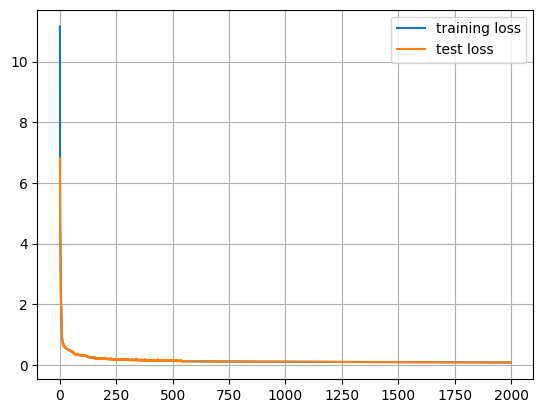

--------------------  EPOCH: 2000  --------------------
LOSS train 0.08019969414691536 valid 0.08075367659330368
--------------------  EPOCH: 2001  --------------------
LOSS train 0.08032297403836737 valid 0.08080512285232544
--------------------  EPOCH: 2002  --------------------
LOSS train 0.08006351076218547 valid 0.08060556650161743
--------------------  EPOCH: 2003  --------------------
LOSS train 0.0800220254732638 valid 0.0806041806936264
--------------------  EPOCH: 2004  --------------------
LOSS train 0.0799293051264724 valid 0.08105544000864029
--------------------  EPOCH: 2005  --------------------
LOSS train 0.08035634245191302 valid 0.08154421299695969
--------------------  EPOCH: 2006  --------------------
LOSS train 0.08022286286767648 valid 0.08092512935400009
--------------------  EPOCH: 2007  --------------------
LOSS train 0.08004396135101513 valid 0.08141977339982986
--------------------  EPOCH: 2008  --------------------
LOSS train 0.08002314564524865 valid 0.0819

LOSS train 0.07931622011320931 valid 0.08022505789995193
--------------------  EPOCH: 2073  --------------------
LOSS train 0.07934282005441431 valid 0.08018460124731064
--------------------  EPOCH: 2074  --------------------
LOSS train 0.07933157439134558 valid 0.08026639372110367
--------------------  EPOCH: 2075  --------------------
LOSS train 0.07930962254806441 valid 0.08021068572998047
--------------------  EPOCH: 2076  --------------------
LOSS train 0.07936672166902192 valid 0.08035039901733398
--------------------  EPOCH: 2077  --------------------
LOSS train 0.07936200043376611 valid 0.0803661197423935
--------------------  EPOCH: 2078  --------------------
LOSS train 0.07932463014612393 valid 0.08019417524337769
--------------------  EPOCH: 2079  --------------------
LOSS train 0.07930364110031907 valid 0.08019550144672394
--------------------  EPOCH: 2080  --------------------
LOSS train 0.07930321215975042 valid 0.0802072212100029
--------------------  EPOCH: 2081  ------

LOSS train 0.07916521387440818 valid 0.0800471380352974
--------------------  EPOCH: 2146  --------------------
LOSS train 0.07919099820511681 valid 0.0800885409116745
--------------------  EPOCH: 2147  --------------------
LOSS train 0.07918516303203543 valid 0.0804329663515091
--------------------  EPOCH: 2148  --------------------
LOSS train 0.079206646401055 valid 0.0801800861954689
--------------------  EPOCH: 2149  --------------------
LOSS train 0.07919938497397365 valid 0.0800737738609314
--------------------  EPOCH: 2150  --------------------
LOSS train 0.07916368270406918 valid 0.08002009242773056
--------------------  EPOCH: 2151  --------------------
LOSS train 0.07917982491911674 valid 0.08011270314455032
--------------------  EPOCH: 2152  --------------------
LOSS train 0.07916531635790455 valid 0.0800204947590828
--------------------  EPOCH: 2153  --------------------
LOSS train 0.07917158229618657 valid 0.0800410732626915
--------------------  EPOCH: 2154  -------------

LOSS train 0.07900692841836385 valid 0.0799194946885109
--------------------  EPOCH: 2219  --------------------
LOSS train 0.07908527689928911 valid 0.07991160452365875
--------------------  EPOCH: 2220  --------------------
LOSS train 0.07903074427526824 valid 0.08006644994020462
--------------------  EPOCH: 2221  --------------------
LOSS train 0.07906951527206266 valid 0.07988465577363968
--------------------  EPOCH: 2222  --------------------
LOSS train 0.07900017849644836 valid 0.07994270324707031
--------------------  EPOCH: 2223  --------------------
LOSS train 0.07900267672173832 valid 0.0798676609992981
--------------------  EPOCH: 2224  --------------------
LOSS train 0.07899005300536448 valid 0.07989814877510071
--------------------  EPOCH: 2225  --------------------
LOSS train 0.07905047721400553 valid 0.07985766977071762
--------------------  EPOCH: 2226  --------------------
LOSS train 0.07899430424583201 valid 0.0798649787902832
--------------------  EPOCH: 2227  -------

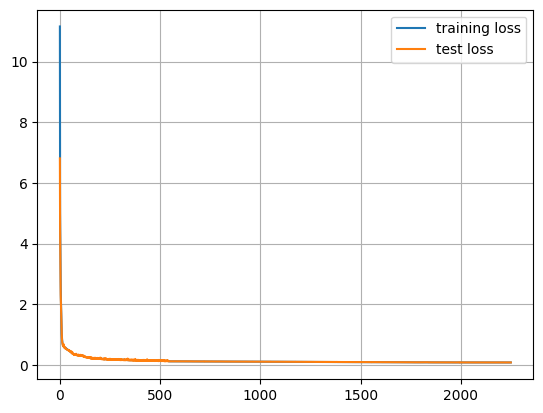

--------------------  EPOCH: 2250  --------------------
LOSS train 0.07892500548338403 valid 0.07986890524625778
--------------------  EPOCH: 2251  --------------------
LOSS train 0.07895676092225679 valid 0.07981343567371368
--------------------  EPOCH: 2252  --------------------
LOSS train 0.07893608191183635 valid 0.07990914583206177
--------------------  EPOCH: 2253  --------------------
LOSS train 0.07897753922306762 valid 0.07985077798366547
--------------------  EPOCH: 2254  --------------------
LOSS train 0.0789352159719078 valid 0.07985444366931915
--------------------  EPOCH: 2255  --------------------
LOSS train 0.07899288057672735 valid 0.07988575845956802
--------------------  EPOCH: 2256  --------------------
LOSS train 0.07893780725342887 valid 0.07982629537582397
--------------------  EPOCH: 2257  --------------------
LOSS train 0.07894038941179003 valid 0.07984524965286255
--------------------  EPOCH: 2258  --------------------
LOSS train 0.07896159087516824 valid 0.07

LOSS train 0.07883031909563104 valid 0.07975301146507263
--------------------  EPOCH: 2324  --------------------
LOSS train 0.07882858174187797 valid 0.07983304560184479
--------------------  EPOCH: 2325  --------------------
LOSS train 0.07885252273812586 valid 0.07967907935380936
--------------------  EPOCH: 2326  --------------------
LOSS train 0.07879806918149092 valid 0.07969065010547638
--------------------  EPOCH: 2327  --------------------
LOSS train 0.0787935339066447 valid 0.07974481582641602
--------------------  EPOCH: 2328  --------------------
LOSS train 0.078815936738131 valid 0.07966868579387665
--------------------  EPOCH: 2329  --------------------
LOSS train 0.0787681379184431 valid 0.07966844737529755
--------------------  EPOCH: 2330  --------------------
LOSS train 0.07881441393068858 valid 0.0796949565410614
--------------------  EPOCH: 2331  --------------------
LOSS train 0.07877377146969036 valid 0.07972434908151627
--------------------  EPOCH: 2332  ---------

LOSS train 0.07867596632972056 valid 0.07955958694219589
--------------------  EPOCH: 2397  --------------------
LOSS train 0.07865607251926345 valid 0.07954521477222443
--------------------  EPOCH: 2398  --------------------
LOSS train 0.07871089723645425 valid 0.07954297214746475
--------------------  EPOCH: 2399  --------------------
LOSS train 0.07869721660200431 valid 0.07955361902713776
--------------------  EPOCH: 2400  --------------------
LOSS train 0.07864591540122519 valid 0.07965228706598282
--------------------  EPOCH: 2401  --------------------
LOSS train 0.07865808037470798 valid 0.07951857149600983
--------------------  EPOCH: 2402  --------------------
LOSS train 0.07869953631746526 valid 0.07951575517654419
--------------------  EPOCH: 2403  --------------------
LOSS train 0.07870381766436052 valid 0.07951167970895767
--------------------  EPOCH: 2404  --------------------
LOSS train 0.0786869608017863 valid 0.0795474424958229
--------------------  EPOCH: 2405  ------

LOSS train 0.07863131621662452 valid 0.07948227226734161
--------------------  EPOCH: 2470  --------------------
LOSS train 0.07865988569600242 valid 0.07941116392612457
--------------------  EPOCH: 2471  --------------------
LOSS train 0.07852356257487317 valid 0.07936631888151169
--------------------  EPOCH: 2472  --------------------
LOSS train 0.07851840297178346 valid 0.0794406533241272
--------------------  EPOCH: 2473  --------------------
LOSS train 0.07849842005846452 valid 0.07938621193170547
--------------------  EPOCH: 2474  --------------------
LOSS train 0.07852028781662182 valid 0.07944478839635849
--------------------  EPOCH: 2475  --------------------
LOSS train 0.07857662196062049 valid 0.07944700866937637
--------------------  EPOCH: 2476  --------------------
LOSS train 0.0785666006256123 valid 0.07939597964286804
--------------------  EPOCH: 2477  --------------------
LOSS train 0.07852397615812262 valid 0.07938003540039062
--------------------  EPOCH: 2478  ------

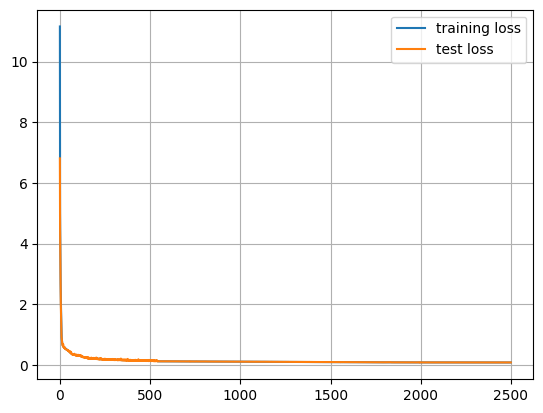

--------------------  EPOCH: 2500  --------------------
LOSS train 0.07842290142969209 valid 0.0793386846780777
--------------------  EPOCH: 2501  --------------------
LOSS train 0.07842354765351937 valid 0.07933355867862701
--------------------  EPOCH: 2502  --------------------
LOSS train 0.07841772631723054 valid 0.07933388650417328
--------------------  EPOCH: 2503  --------------------
LOSS train 0.07842392656876117 valid 0.07933264225721359
--------------------  EPOCH: 2504  --------------------
LOSS train 0.07840952094720334 valid 0.07932973653078079
--------------------  EPOCH: 2505  --------------------
LOSS train 0.07842111344240149 valid 0.07933209091424942
--------------------  EPOCH: 2506  --------------------
LOSS train 0.07841431805673911 valid 0.07934112846851349
--------------------  EPOCH: 2507  --------------------
LOSS train 0.07840576159710787 valid 0.0793367251753807
--------------------  EPOCH: 2508  --------------------
LOSS train 0.07841501080868196 valid 0.079

LOSS train 0.07840693681215753 valid 0.07932304590940475
--------------------  EPOCH: 2573  --------------------
LOSS train 0.07840581892096267 valid 0.07932346314191818
--------------------  EPOCH: 2574  --------------------
LOSS train 0.07841277989197751 valid 0.07932344079017639
--------------------  EPOCH: 2575  --------------------
LOSS train 0.07841370482834017 valid 0.07932371646165848
--------------------  EPOCH: 2576  --------------------
LOSS train 0.07841639144688237 valid 0.07932306081056595
--------------------  EPOCH: 2577  --------------------
LOSS train 0.07840804101861253 valid 0.07932253181934357
--------------------  EPOCH: 2578  --------------------
LOSS train 0.07841032652222381 valid 0.079322949051857
--------------------  EPOCH: 2579  --------------------
LOSS train 0.07840566489161277 valid 0.0793231800198555
--------------------  EPOCH: 2580  --------------------
LOSS train 0.07841048374467967 valid 0.07932417839765549
--------------------  EPOCH: 2581  -------

LOSS train 0.07840690381672917 valid 0.07932160049676895
--------------------  EPOCH: 2646  --------------------
LOSS train 0.07841292038864019 valid 0.07932201772928238
--------------------  EPOCH: 2647  --------------------
LOSS train 0.078407028347862 valid 0.07932105660438538
--------------------  EPOCH: 2648  --------------------
LOSS train 0.07840188425414417 valid 0.07932302355766296
--------------------  EPOCH: 2649  --------------------
LOSS train 0.07840475941799124 valid 0.07932117581367493
--------------------  EPOCH: 2650  --------------------
LOSS train 0.07841084563002294 valid 0.07932135462760925
--------------------  EPOCH: 2651  --------------------
LOSS train 0.07839965668259835 valid 0.07932119816541672
--------------------  EPOCH: 2652  --------------------
LOSS train 0.07841858298194651 valid 0.07932104170322418
--------------------  EPOCH: 2653  --------------------
LOSS train 0.07840818227553854 valid 0.07932152599096298
--------------------  EPOCH: 2654  ------

LOSS train 0.0784076286517844 valid 0.07931992411613464
--------------------  EPOCH: 2719  --------------------
LOSS train 0.0784072178054829 valid 0.07931949198246002
--------------------  EPOCH: 2720  --------------------
LOSS train 0.07841343949643934 valid 0.0793210044503212
--------------------  EPOCH: 2721  --------------------
LOSS train 0.07840038349433821 valid 0.07932034134864807
--------------------  EPOCH: 2722  --------------------
LOSS train 0.07839795779816959 valid 0.07931966334581375
--------------------  EPOCH: 2723  --------------------
LOSS train 0.07841112266997902 valid 0.07931915670633316
--------------------  EPOCH: 2724  --------------------
LOSS train 0.07840146975857872 valid 0.07931943237781525
--------------------  EPOCH: 2725  --------------------
LOSS train 0.07841138982651186 valid 0.07931948453187943
--------------------  EPOCH: 2726  --------------------
LOSS train 0.07839501314625448 valid 0.0793200358748436
--------------------  EPOCH: 2727  --------

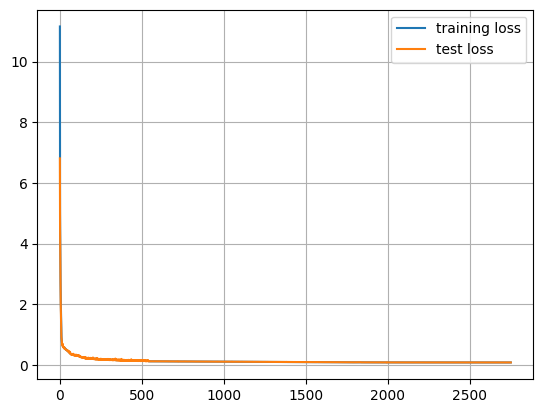

--------------------  EPOCH: 2750  --------------------
LOSS train 0.07840324558165608 valid 0.07931876182556152
--------------------  EPOCH: 2751  --------------------
LOSS train 0.07840070234877723 valid 0.07931891083717346
--------------------  EPOCH: 2752  --------------------
LOSS train 0.07840187482687892 valid 0.07931873947381973
--------------------  EPOCH: 2753  --------------------
LOSS train 0.07839972936377233 valid 0.07931867986917496
--------------------  EPOCH: 2754  --------------------
LOSS train 0.07840924953319589 valid 0.07931844890117645
--------------------  EPOCH: 2755  --------------------
LOSS train 0.07840426843993518 valid 0.07931919395923615
--------------------  EPOCH: 2756  --------------------
LOSS train 0.0783957090913033 valid 0.0793185755610466
--------------------  EPOCH: 2757  --------------------
LOSS train 0.07840024421409685 valid 0.07932156324386597
--------------------  EPOCH: 2758  --------------------
LOSS train 0.07841025292873383 valid 0.079

LOSS train 0.07840021106661582 valid 0.07931680977344513
--------------------  EPOCH: 2824  --------------------
LOSS train 0.07839273691785578 valid 0.07931744307279587
--------------------  EPOCH: 2825  --------------------
LOSS train 0.07839663646050862 valid 0.07931672781705856
--------------------  EPOCH: 2826  --------------------
LOSS train 0.07840817452085261 valid 0.07931691408157349
--------------------  EPOCH: 2827  --------------------
LOSS train 0.0783935855237805 valid 0.07931790500879288
--------------------  EPOCH: 2828  --------------------
LOSS train 0.07840220189216185 valid 0.07931657135486603
--------------------  EPOCH: 2829  --------------------
LOSS train 0.07840127330653522 valid 0.07931722700595856
--------------------  EPOCH: 2830  --------------------
LOSS train 0.07839830143719304 valid 0.07931647449731827
--------------------  EPOCH: 2831  --------------------
LOSS train 0.07840310995067869 valid 0.07931720465421677
--------------------  EPOCH: 2832  -----

LOSS train 0.07839431765736365 valid 0.07931508868932724
--------------------  EPOCH: 2897  --------------------
LOSS train 0.07840166301751623 valid 0.07931528985500336
--------------------  EPOCH: 2898  --------------------
LOSS train 0.07840565835334817 valid 0.07931507378816605
--------------------  EPOCH: 2899  --------------------
LOSS train 0.07839113124171082 valid 0.07931544631719589
--------------------  EPOCH: 2900  --------------------
LOSS train 0.07839434958842335 valid 0.07931484282016754
--------------------  EPOCH: 2901  --------------------
LOSS train 0.07839334239156878 valid 0.07931645959615707
--------------------  EPOCH: 2902  --------------------
LOSS train 0.07839472196540054 valid 0.07931455969810486
--------------------  EPOCH: 2903  --------------------
LOSS train 0.07840234421345653 valid 0.07931605726480484
--------------------  EPOCH: 2904  --------------------
LOSS train 0.07839553073352697 valid 0.07931478321552277
--------------------  EPOCH: 2905  ----

LOSS train 0.07840254203397401 valid 0.07931254059076309
--------------------  EPOCH: 2970  --------------------
LOSS train 0.07839648319142205 valid 0.07931294292211533
--------------------  EPOCH: 2971  --------------------
LOSS train 0.07839483296384617 valid 0.07931302487850189
--------------------  EPOCH: 2972  --------------------
LOSS train 0.07840942545812957 valid 0.07931304723024368
--------------------  EPOCH: 2973  --------------------
LOSS train 0.0783974637790602 valid 0.07931547611951828
--------------------  EPOCH: 2974  --------------------
LOSS train 0.0784006018419655 valid 0.07931321114301682
--------------------  EPOCH: 2975  --------------------
LOSS train 0.07839938222753759 valid 0.0793134942650795
--------------------  EPOCH: 2976  --------------------
LOSS train 0.07838752029501662 valid 0.07931333035230637
--------------------  EPOCH: 2977  --------------------
LOSS train 0.07839990194354739 valid 0.07931449264287949
--------------------  EPOCH: 2978  -------

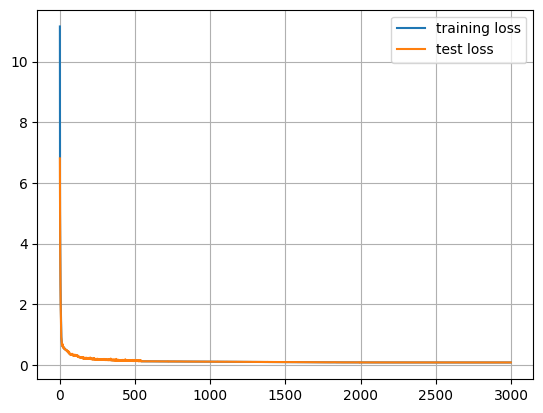

--------------------  EPOCH: 3000  --------------------
LOSS train 0.07840506139458442 valid 0.07931264489889145
--------------------  EPOCH: 3001  --------------------
LOSS train 0.07840178253091111 valid 0.07931210100650787
--------------------  EPOCH: 3002  --------------------
LOSS train 0.07839383945173146 valid 0.07931333035230637
--------------------  EPOCH: 3003  --------------------
LOSS train 0.07839936322095442 valid 0.07931218296289444
--------------------  EPOCH: 3004  --------------------
LOSS train 0.07839578602995191 valid 0.07931298762559891
--------------------  EPOCH: 3005  --------------------
LOSS train 0.07839442257370267 valid 0.07931192219257355
--------------------  EPOCH: 3006  --------------------
LOSS train 0.07840522302656758 valid 0.07931261509656906
--------------------  EPOCH: 3007  --------------------
LOSS train 0.07840465587012622 valid 0.07931241393089294
--------------------  EPOCH: 3008  --------------------
LOSS train 0.07839127766842745 valid 0.0

LOSS train 0.07839582525953954 valid 0.07931016385555267
--------------------  EPOCH: 3074  --------------------
LOSS train 0.07838467204449129 valid 0.07930994778871536
--------------------  EPOCH: 3075  --------------------
LOSS train 0.07840039124902413 valid 0.07930991053581238
--------------------  EPOCH: 3076  --------------------
LOSS train 0.07839065714150059 valid 0.07931002974510193
--------------------  EPOCH: 3077  --------------------
LOSS train 0.0783914393004106 valid 0.07931136339902878
--------------------  EPOCH: 3078  --------------------
LOSS train 0.07838695435499658 valid 0.07931028306484222
--------------------  EPOCH: 3079  --------------------
LOSS train 0.07839489849854489 valid 0.0793110802769661
--------------------  EPOCH: 3080  --------------------
LOSS train 0.07839300057717732 valid 0.07931019365787506
--------------------  EPOCH: 3081  --------------------
LOSS train 0.07839539814360287 valid 0.0793096199631691
--------------------  EPOCH: 3082  -------

LOSS train 0.07838293088942158 valid 0.07930883020162582
--------------------  EPOCH: 3147  --------------------
LOSS train 0.07838867528706181 valid 0.07930785417556763
--------------------  EPOCH: 3148  --------------------
LOSS train 0.07839021466824474 valid 0.07930869609117508
--------------------  EPOCH: 3149  --------------------
LOSS train 0.07838947614844964 valid 0.07930957525968552
--------------------  EPOCH: 3150  --------------------
LOSS train 0.07838867011727119 valid 0.07930776476860046
--------------------  EPOCH: 3151  --------------------
LOSS train 0.07839700686080116 valid 0.07930883765220642
--------------------  EPOCH: 3152  --------------------
LOSS train 0.07838345395059002 valid 0.07930777966976166
--------------------  EPOCH: 3153  --------------------
LOSS train 0.07840538450649806 valid 0.07930810749530792
--------------------  EPOCH: 3154  --------------------
LOSS train 0.07838960311242513 valid 0.07930772751569748
--------------------  EPOCH: 3155  ----

LOSS train 0.07839273129190717 valid 0.07930625230073929
--------------------  EPOCH: 3220  --------------------
LOSS train 0.07839331623851037 valid 0.07930613309144974
--------------------  EPOCH: 3221  --------------------
LOSS train 0.07839319718127348 valid 0.07930614799261093
--------------------  EPOCH: 3222  --------------------
LOSS train 0.07838633185138508 valid 0.07930630445480347
--------------------  EPOCH: 3223  --------------------
LOSS train 0.07838879145529805 valid 0.07930591702461243
--------------------  EPOCH: 3224  --------------------
LOSS train 0.07837882850851331 valid 0.0793064534664154
--------------------  EPOCH: 3225  --------------------
LOSS train 0.07839300407438862 valid 0.0793062224984169
--------------------  EPOCH: 3226  --------------------
LOSS train 0.07838975014735242 valid 0.07930602133274078
--------------------  EPOCH: 3227  --------------------
LOSS train 0.07839162723750484 valid 0.07930579781532288
--------------------  EPOCH: 3228  ------

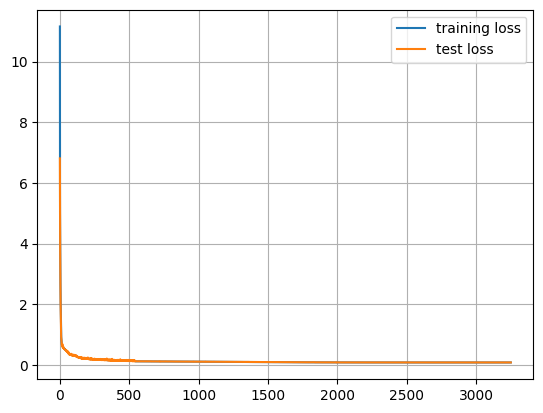

--------------------  EPOCH: 3250  --------------------
LOSS train 0.07839724497527492 valid 0.0793059915304184
--------------------  EPOCH: 3251  --------------------
LOSS train 0.0783992592169314 valid 0.07930657267570496
--------------------  EPOCH: 3252  --------------------
LOSS train 0.07839564690176322 valid 0.0793054848909378
--------------------  EPOCH: 3253  --------------------
LOSS train 0.07839525202099158 valid 0.07930535078048706
--------------------  EPOCH: 3254  --------------------
LOSS train 0.07839232896055494 valid 0.07930496335029602
--------------------  EPOCH: 3255  --------------------
LOSS train 0.07838618755340576 valid 0.07930506765842438
--------------------  EPOCH: 3256  --------------------
LOSS train 0.0783881989060616 valid 0.079306460916996
--------------------  EPOCH: 3257  --------------------
LOSS train 0.07839016737986584 valid 0.07930594682693481
--------------------  EPOCH: 3258  --------------------
LOSS train 0.07837979069777898 valid 0.0793114

LOSS train 0.07839733423018942 valid 0.07930326461791992
--------------------  EPOCH: 3324  --------------------
LOSS train 0.07839425516371824 valid 0.07930353283882141
--------------------  EPOCH: 3325  --------------------
LOSS train 0.07838624183620725 valid 0.07930372655391693
--------------------  EPOCH: 3326  --------------------
LOSS train 0.07837793109368305 valid 0.07930467277765274
--------------------  EPOCH: 3327  --------------------
LOSS train 0.07838472754371409 valid 0.07930612564086914
--------------------  EPOCH: 3328  --------------------
LOSS train 0.07838287006835548 valid 0.07930345833301544
--------------------  EPOCH: 3329  --------------------
LOSS train 0.07839152627453512 valid 0.07930305600166321
--------------------  EPOCH: 3330  --------------------
LOSS train 0.0783855775181128 valid 0.07930336147546768
--------------------  EPOCH: 3331  --------------------
LOSS train 0.07839556753027196 valid 0.07930295914411545
--------------------  EPOCH: 3332  -----

LOSS train 0.0783864144159823 valid 0.07930196821689606
--------------------  EPOCH: 3397  --------------------
LOSS train 0.07838486682395546 valid 0.07930169254541397
--------------------  EPOCH: 3398  --------------------
LOSS train 0.07838440427974779 valid 0.07930205762386322
--------------------  EPOCH: 3399  --------------------
LOSS train 0.07839619413930543 valid 0.07930129766464233
--------------------  EPOCH: 3400  --------------------
LOSS train 0.07838245420431604 valid 0.07930158078670502
--------------------  EPOCH: 3401  --------------------
LOSS train 0.07837035020395201 valid 0.07930212467908859
--------------------  EPOCH: 3402  --------------------
LOSS train 0.07838475293650919 valid 0.07930165529251099
--------------------  EPOCH: 3403  --------------------
LOSS train 0.07838741705125692 valid 0.07930086553096771
--------------------  EPOCH: 3404  --------------------
LOSS train 0.07837919221848857 valid 0.07930155098438263
--------------------  EPOCH: 3405  -----

LOSS train 0.0783808772661248 valid 0.0792992115020752
--------------------  EPOCH: 3470  --------------------
LOSS train 0.07839031182989782 valid 0.07930011302232742
--------------------  EPOCH: 3471  --------------------
LOSS train 0.07838638050823796 valid 0.07929914444684982
--------------------  EPOCH: 3472  --------------------
LOSS train 0.07838260412824397 valid 0.07929977774620056
--------------------  EPOCH: 3473  --------------------
LOSS train 0.07837940281142994 valid 0.07929948717355728
--------------------  EPOCH: 3474  --------------------
LOSS train 0.07838665207429808 valid 0.07929929345846176
--------------------  EPOCH: 3475  --------------------
LOSS train 0.07838901603708462 valid 0.07929955422878265
--------------------  EPOCH: 3476  --------------------
LOSS train 0.07838599961631153 valid 0.07929928600788116
--------------------  EPOCH: 3477  --------------------
LOSS train 0.0783827212087962 valid 0.07929910719394684
--------------------  EPOCH: 3478  -------

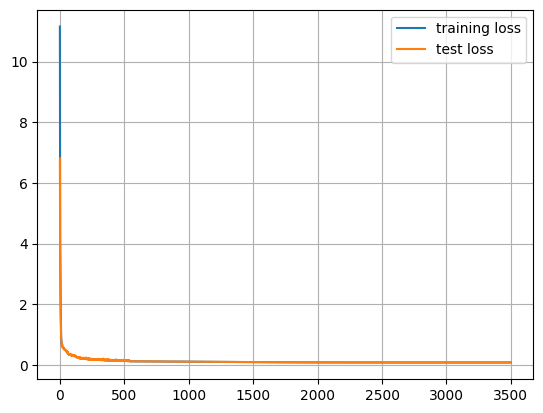

--------------------  EPOCH: 3500  --------------------
LOSS train 0.07837931994272739 valid 0.07929866015911102
--------------------  EPOCH: 3501  --------------------
LOSS train 0.07838047371835125 valid 0.07929892838001251
--------------------  EPOCH: 3502  --------------------
LOSS train 0.0783815221214781 valid 0.07930213212966919
--------------------  EPOCH: 3503  --------------------
LOSS train 0.0783829780257478 valid 0.07929855585098267
--------------------  EPOCH: 3504  --------------------
LOSS train 0.07838244873042009 valid 0.07929911464452744
--------------------  EPOCH: 3505  --------------------
LOSS train 0.07838090798076318 valid 0.07929833233356476
--------------------  EPOCH: 3506  --------------------
LOSS train 0.07837895836148943 valid 0.07929836958646774
--------------------  EPOCH: 3507  --------------------
LOSS train 0.07838045623229474 valid 0.07929898798465729
--------------------  EPOCH: 3508  --------------------
LOSS train 0.07838688942850852 valid 0.079

LOSS train 0.07838285471103629 valid 0.07929680496454239
--------------------  EPOCH: 3574  --------------------
LOSS train 0.07839055222516157 valid 0.0792965367436409
--------------------  EPOCH: 3575  --------------------
LOSS train 0.07838134832528172 valid 0.07929704338312149
--------------------  EPOCH: 3576  --------------------
LOSS train 0.0783789051430566 valid 0.07929737120866776
--------------------  EPOCH: 3577  --------------------
LOSS train 0.07839297670490887 valid 0.07929626107215881
--------------------  EPOCH: 3578  --------------------
LOSS train 0.07837720093678455 valid 0.07929647713899612
--------------------  EPOCH: 3579  --------------------
LOSS train 0.07838119764109047 valid 0.07930050045251846
--------------------  EPOCH: 3580  --------------------
LOSS train 0.07838046900471862 valid 0.07929681986570358
--------------------  EPOCH: 3581  --------------------
LOSS train 0.07839144538251722 valid 0.07929648458957672
--------------------  EPOCH: 3582  ------

LOSS train 0.07838009830032076 valid 0.07929486036300659
--------------------  EPOCH: 3647  --------------------
LOSS train 0.07837884827535979 valid 0.07929474860429764
--------------------  EPOCH: 3648  --------------------
LOSS train 0.07837996403781736 valid 0.07929467409849167
--------------------  EPOCH: 3649  --------------------
LOSS train 0.07837577954846986 valid 0.079294852912426
--------------------  EPOCH: 3650  --------------------
LOSS train 0.07838666408645864 valid 0.07929618656635284
--------------------  EPOCH: 3651  --------------------
LOSS train 0.07838449323055696 valid 0.07929470390081406
--------------------  EPOCH: 3652  --------------------
LOSS train 0.07837466013674833 valid 0.07929477095603943
--------------------  EPOCH: 3653  --------------------
LOSS train 0.0783724777248441 valid 0.07929495722055435
--------------------  EPOCH: 3654  --------------------
LOSS train 0.07838153185284867 valid 0.0792945921421051
--------------------  EPOCH: 3655  --------

LOSS train 0.07837829024207835 valid 0.07929312437772751
--------------------  EPOCH: 3720  --------------------
LOSS train 0.07837907118456704 valid 0.07929294556379318
--------------------  EPOCH: 3721  --------------------
LOSS train 0.07837720869147048 valid 0.0792926773428917
--------------------  EPOCH: 3722  --------------------
LOSS train 0.07838613205418295 valid 0.07929283380508423
--------------------  EPOCH: 3723  --------------------
LOSS train 0.07836851097491322 valid 0.07929279655218124
--------------------  EPOCH: 3724  --------------------
LOSS train 0.07837781370902548 valid 0.07929312437772751
--------------------  EPOCH: 3725  --------------------
LOSS train 0.07837539211827882 valid 0.07929238677024841
--------------------  EPOCH: 3726  --------------------
LOSS train 0.07838437523768872 valid 0.0792931541800499
--------------------  EPOCH: 3727  --------------------
LOSS train 0.07835774366952936 valid 0.07929439097642899
--------------------  EPOCH: 3728  ------

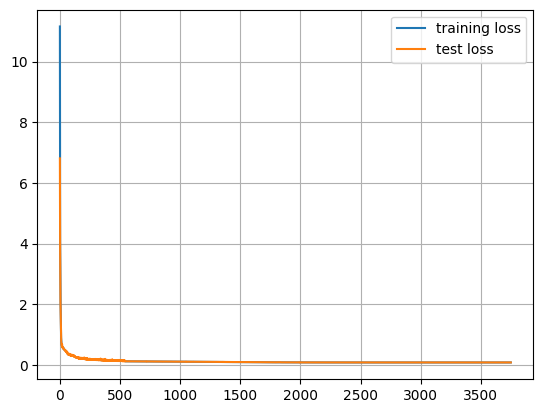

--------------------  EPOCH: 3750  --------------------
LOSS train 0.07837974143271544 valid 0.07929225265979767
--------------------  EPOCH: 3751  --------------------
LOSS train 0.07838398096512775 valid 0.07929179817438126
--------------------  EPOCH: 3752  --------------------
LOSS train 0.07838207316033695 valid 0.07929212599992752
--------------------  EPOCH: 3753  --------------------
LOSS train 0.07838262085403715 valid 0.07929175347089767
--------------------  EPOCH: 3754  --------------------
LOSS train 0.07837930975519881 valid 0.07929205149412155
--------------------  EPOCH: 3755  --------------------
LOSS train 0.07838160635865464 valid 0.07929457724094391
--------------------  EPOCH: 3756  --------------------
LOSS train 0.0783796348437971 valid 0.0792919248342514
--------------------  EPOCH: 3757  --------------------
LOSS train 0.07837200332052853 valid 0.07929202914237976
--------------------  EPOCH: 3758  --------------------
LOSS train 0.07837851345539093 valid 0.079

LOSS train 0.07837578106899651 valid 0.07928993552923203
--------------------  EPOCH: 3824  --------------------
LOSS train 0.0783767361117869 valid 0.07928971201181412
--------------------  EPOCH: 3825  --------------------
LOSS train 0.07837120489198335 valid 0.07929041236639023
--------------------  EPOCH: 3826  --------------------
LOSS train 0.07837591578765792 valid 0.07929059863090515
--------------------  EPOCH: 3827  --------------------
LOSS train 0.078374303725301 valid 0.07929090410470963
--------------------  EPOCH: 3828  --------------------
LOSS train 0.07837157529227588 valid 0.07929005473852158
--------------------  EPOCH: 3829  --------------------
LOSS train 0.0783751380382752 valid 0.07929037511348724
--------------------  EPOCH: 3830  --------------------
LOSS train 0.0783689721506469 valid 0.07929109036922455
--------------------  EPOCH: 3831  --------------------
LOSS train 0.07837486966532103 valid 0.07929021865129471
--------------------  EPOCH: 3832  ---------

LOSS train 0.07837555131741933 valid 0.07928846031427383
--------------------  EPOCH: 3897  --------------------
LOSS train 0.07837289313272554 valid 0.07928827404975891
--------------------  EPOCH: 3898  --------------------
LOSS train 0.07837684999923317 valid 0.07928834110498428
--------------------  EPOCH: 3899  --------------------
LOSS train 0.07837870458559114 valid 0.07928851991891861
--------------------  EPOCH: 3900  --------------------
LOSS train 0.07837553474367881 valid 0.07928770035505295
--------------------  EPOCH: 3901  --------------------
LOSS train 0.07837511553448073 valid 0.07928814738988876
--------------------  EPOCH: 3902  --------------------
LOSS train 0.07836940534869019 valid 0.07928827404975891
--------------------  EPOCH: 3903  --------------------
LOSS train 0.07837719956831056 valid 0.07928837835788727
--------------------  EPOCH: 3904  --------------------
LOSS train 0.0783764727565707 valid 0.07928837090730667
--------------------  EPOCH: 3905  -----

LOSS train 0.07837191056840274 valid 0.07928670942783356
--------------------  EPOCH: 3970  --------------------
LOSS train 0.07836151335920606 valid 0.07928604632616043
--------------------  EPOCH: 3971  --------------------
LOSS train 0.07836787980429981 valid 0.07928606867790222
--------------------  EPOCH: 3972  --------------------
LOSS train 0.07836511822379365 valid 0.07928599417209625
--------------------  EPOCH: 3973  --------------------
LOSS train 0.07837006890652132 valid 0.07928600162267685
--------------------  EPOCH: 3974  --------------------
LOSS train 0.0783765090971577 valid 0.07928585261106491
--------------------  EPOCH: 3975  --------------------
LOSS train 0.07836148492535766 valid 0.07928604632616043
--------------------  EPOCH: 3976  --------------------
LOSS train 0.07836532425515506 valid 0.07928608357906342
--------------------  EPOCH: 3977  --------------------
LOSS train 0.0783731925244234 valid 0.0792858824133873
--------------------  EPOCH: 3978  -------

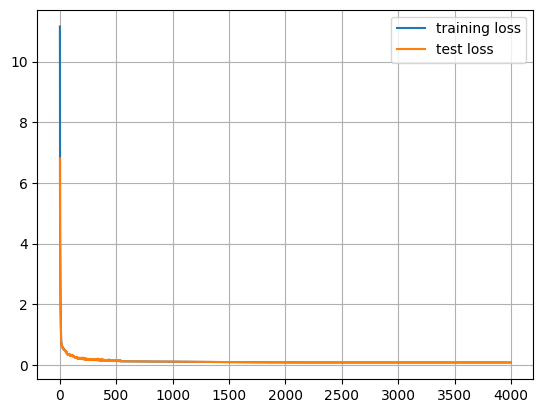

--------------------  EPOCH: 4000  --------------------
LOSS train 0.07838139515750263 valid 0.07928535342216492
--------------------  EPOCH: 4001  --------------------
LOSS train 0.07836550687040601 valid 0.07928649336099625
--------------------  EPOCH: 4002  --------------------
LOSS train 0.0783661281575962 valid 0.0792853981256485
--------------------  EPOCH: 4003  --------------------
LOSS train 0.07837592962445045 valid 0.0792853832244873
--------------------  EPOCH: 4004  --------------------
LOSS train 0.07837440195132275 valid 0.07928561419248581
--------------------  EPOCH: 4005  --------------------
LOSS train 0.07835999754618625 valid 0.0792854055762291
--------------------  EPOCH: 4006  --------------------
LOSS train 0.07836994620002045 valid 0.07928488403558731
--------------------  EPOCH: 4007  --------------------
LOSS train 0.07837605643637326 valid 0.07928537577390671
--------------------  EPOCH: 4008  --------------------
LOSS train 0.07837098167867076 valid 0.07928

LOSS train 0.07837458867199566 valid 0.0792841985821724
--------------------  EPOCH: 4074  --------------------
LOSS train 0.07837577301020525 valid 0.07928463816642761
--------------------  EPOCH: 4075  --------------------
LOSS train 0.07837397924491338 valid 0.07928292453289032
--------------------  EPOCH: 4076  --------------------
LOSS train 0.07836162755075766 valid 0.07928316295146942
--------------------  EPOCH: 4077  --------------------
LOSS train 0.07836873175538316 valid 0.07928388565778732
--------------------  EPOCH: 4078  --------------------
LOSS train 0.07836946099996567 valid 0.07928412407636642
--------------------  EPOCH: 4079  --------------------
LOSS train 0.07836318335362844 valid 0.07928309589624405
--------------------  EPOCH: 4080  --------------------
LOSS train 0.07837267067967629 valid 0.07928416132926941
--------------------  EPOCH: 4081  --------------------
LOSS train 0.07836965395479786 valid 0.07928293943405151
--------------------  EPOCH: 4082  -----

LOSS train 0.0783607651080404 valid 0.07928131520748138
--------------------  EPOCH: 4147  --------------------
LOSS train 0.07837332222534686 valid 0.07928179949522018
--------------------  EPOCH: 4148  --------------------
LOSS train 0.07836920038169744 valid 0.07928141206502914
--------------------  EPOCH: 4149  --------------------
LOSS train 0.07835647615851188 valid 0.07928133010864258
--------------------  EPOCH: 4150  --------------------
LOSS train 0.07836554001788704 valid 0.07928146421909332
--------------------  EPOCH: 4151  --------------------
LOSS train 0.07836526389024695 valid 0.07928134500980377
--------------------  EPOCH: 4152  --------------------
LOSS train 0.07836021817460352 valid 0.07928133755922318
--------------------  EPOCH: 4153  --------------------
LOSS train 0.07836418325195507 valid 0.07928135246038437
--------------------  EPOCH: 4154  --------------------
LOSS train 0.07836545866971113 valid 0.07928112149238586
--------------------  EPOCH: 4155  -----

LOSS train 0.07836620205519151 valid 0.07927899807691574
--------------------  EPOCH: 4220  --------------------
LOSS train 0.07836980190204114 valid 0.07927989214658737
--------------------  EPOCH: 4221  --------------------
LOSS train 0.07837050712230254 valid 0.07928065210580826
--------------------  EPOCH: 4222  --------------------
LOSS train 0.07837261472429548 valid 0.07927992939949036
--------------------  EPOCH: 4223  --------------------
LOSS train 0.07836774006790044 valid 0.07927928864955902
--------------------  EPOCH: 4224  --------------------
LOSS train 0.07836075248766919 valid 0.07927904278039932
--------------------  EPOCH: 4225  --------------------
LOSS train 0.07836657154316805 valid 0.07927960157394409
--------------------  EPOCH: 4226  --------------------
LOSS train 0.07837288172877564 valid 0.0792795941233635
--------------------  EPOCH: 4227  --------------------
LOSS train 0.07836966657516908 valid 0.07927963137626648
--------------------  EPOCH: 4228  -----

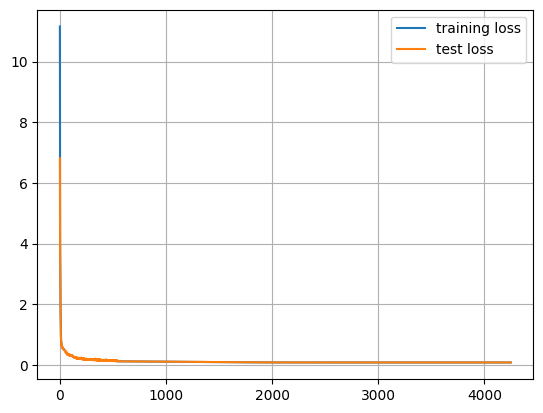

--------------------  EPOCH: 4250  --------------------
LOSS train 0.07837380620898032 valid 0.07927880436182022
--------------------  EPOCH: 4251  --------------------
LOSS train 0.07836231193980392 valid 0.07927881926298141
--------------------  EPOCH: 4252  --------------------
LOSS train 0.07837042258102067 valid 0.07927839457988739
--------------------  EPOCH: 4253  --------------------
LOSS train 0.07836751791895652 valid 0.07927846908569336
--------------------  EPOCH: 4254  --------------------
LOSS train 0.07837500058266582 valid 0.07927872985601425
--------------------  EPOCH: 4255  --------------------
LOSS train 0.07836317787973249 valid 0.07927832752466202
--------------------  EPOCH: 4256  --------------------
LOSS train 0.07836277129090562 valid 0.07927977293729782
--------------------  EPOCH: 4257  --------------------
LOSS train 0.07835181832921748 valid 0.0792783722281456
--------------------  EPOCH: 4258  --------------------
LOSS train 0.07836128117478623 valid 0.07

LOSS train 0.07836473489902457 valid 0.07927688956260681
--------------------  EPOCH: 4324  --------------------
LOSS train 0.07835114747285843 valid 0.07927683740854263
--------------------  EPOCH: 4325  --------------------
LOSS train 0.0783515536055273 valid 0.07927702367305756
--------------------  EPOCH: 4326  --------------------
LOSS train 0.07836812445703818 valid 0.07927670329809189
--------------------  EPOCH: 4327  --------------------
LOSS train 0.07836795750321174 valid 0.07927744835615158
--------------------  EPOCH: 4328  --------------------
LOSS train 0.07836543114817872 valid 0.07927703112363815
--------------------  EPOCH: 4329  --------------------
LOSS train 0.07835188766523284 valid 0.0792764201760292
--------------------  EPOCH: 4330  --------------------
LOSS train 0.07836274772274252 valid 0.07927648723125458
--------------------  EPOCH: 4331  --------------------
LOSS train 0.07836819212047422 valid 0.07927640527486801
--------------------  EPOCH: 4332  ------

LOSS train 0.07835920139843104 valid 0.07927530258893967
--------------------  EPOCH: 4397  --------------------
LOSS train 0.07836172091109413 valid 0.07927470654249191
--------------------  EPOCH: 4398  --------------------
LOSS train 0.07836507017515143 valid 0.07927515357732773
--------------------  EPOCH: 4399  --------------------
LOSS train 0.07836133804248303 valid 0.0792749673128128
--------------------  EPOCH: 4400  --------------------
LOSS train 0.07836341660241691 valid 0.0792752057313919
--------------------  EPOCH: 4401  --------------------
LOSS train 0.07836419024637767 valid 0.07927432656288147
--------------------  EPOCH: 4402  --------------------
LOSS train 0.07835448061933323 valid 0.07927457243204117
--------------------  EPOCH: 4403  --------------------
LOSS train 0.07836229734274806 valid 0.0792749673128128
--------------------  EPOCH: 4404  --------------------
LOSS train 0.07835984823046899 valid 0.07927459478378296
--------------------  EPOCH: 4405  -------

LOSS train 0.0783540747907697 valid 0.07927287369966507
--------------------  EPOCH: 4470  --------------------
LOSS train 0.07835923956365001 valid 0.07927355915307999
--------------------  EPOCH: 4471  --------------------
LOSS train 0.07835969131211845 valid 0.07927290350198746
--------------------  EPOCH: 4472  --------------------
LOSS train 0.07835840327399117 valid 0.07927307486534119
--------------------  EPOCH: 4473  --------------------
LOSS train 0.07836520078839088 valid 0.07927269488573074
--------------------  EPOCH: 4474  --------------------
LOSS train 0.07835564382222233 valid 0.0792730525135994
--------------------  EPOCH: 4475  --------------------
LOSS train 0.07836899952012666 valid 0.07927285134792328
--------------------  EPOCH: 4476  --------------------
LOSS train 0.07836764518703733 valid 0.07927300781011581
--------------------  EPOCH: 4477  --------------------
LOSS train 0.07835960661878391 valid 0.07927311956882477
--------------------  EPOCH: 4478  ------

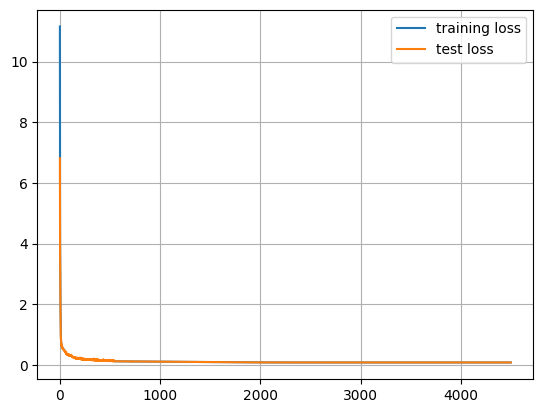

--------------------  EPOCH: 4500  --------------------
LOSS train 0.07835315456803964 valid 0.07927206158638
--------------------  EPOCH: 4501  --------------------
LOSS train 0.07834692603471327 valid 0.07927224040031433
--------------------  EPOCH: 4502  --------------------
LOSS train 0.07835524346755475 valid 0.07927224785089493
--------------------  EPOCH: 4503  --------------------
LOSS train 0.0783573685556042 valid 0.07927194982767105
--------------------  EPOCH: 4504  --------------------
LOSS train 0.07836403302392181 valid 0.07927198708057404
--------------------  EPOCH: 4505  --------------------
LOSS train 0.07835483839925454 valid 0.07927168160676956
--------------------  EPOCH: 4506  --------------------
LOSS train 0.07835402476544283 valid 0.07927190512418747
--------------------  EPOCH: 4507  --------------------
LOSS train 0.07835611974706455 valid 0.07927209138870239
--------------------  EPOCH: 4508  --------------------
LOSS train 0.07835516424811616 valid 0.07927

LOSS train 0.07836274376937322 valid 0.07927051186561584
--------------------  EPOCH: 4574  --------------------
LOSS train 0.07836442820879878 valid 0.0792703628540039
--------------------  EPOCH: 4575  --------------------
LOSS train 0.0783596967860144 valid 0.07927140593528748
--------------------  EPOCH: 4576  --------------------
LOSS train 0.07835579237767629 valid 0.07927186042070389
--------------------  EPOCH: 4577  --------------------
LOSS train 0.078351157204229 valid 0.07927028089761734
--------------------  EPOCH: 4578  --------------------
LOSS train 0.07835893454600354 valid 0.07927025854587555
--------------------  EPOCH: 4579  --------------------
LOSS train 0.07835138604349019 valid 0.07927019149065018
--------------------  EPOCH: 4580  --------------------
LOSS train 0.0783582868016496 valid 0.07927002012729645
--------------------  EPOCH: 4581  --------------------
LOSS train 0.07836375339907042 valid 0.0792703703045845
--------------------  EPOCH: 4582  ----------

LOSS train 0.07834532370372695 valid 0.07926839590072632
--------------------  EPOCH: 4647  --------------------
LOSS train 0.07835669557050783 valid 0.07926838845014572
--------------------  EPOCH: 4648  --------------------
LOSS train 0.07834794478757041 valid 0.0792684257030487
--------------------  EPOCH: 4649  --------------------
LOSS train 0.07834814352040388 valid 0.07926805317401886
--------------------  EPOCH: 4650  --------------------
LOSS train 0.07834995264301495 valid 0.07926828414201736
--------------------  EPOCH: 4651  --------------------
LOSS train 0.07835217854198144 valid 0.0792694091796875
--------------------  EPOCH: 4652  --------------------
LOSS train 0.07835124433040619 valid 0.07926823198795319
--------------------  EPOCH: 4653  --------------------
LOSS train 0.07834822243573714 valid 0.0792679637670517
--------------------  EPOCH: 4654  --------------------
LOSS train 0.07836024478381994 valid 0.07926846295595169
--------------------  EPOCH: 4655  -------

LOSS train 0.07833987444030996 valid 0.07926694303750992
--------------------  EPOCH: 4720  --------------------
LOSS train 0.0783466564453378 valid 0.07926707714796066
--------------------  EPOCH: 4721  --------------------
LOSS train 0.07835357180055307 valid 0.07926937937736511
--------------------  EPOCH: 4722  --------------------
LOSS train 0.07835299947432109 valid 0.07926665991544724
--------------------  EPOCH: 4723  --------------------
LOSS train 0.07834730768690304 valid 0.07926734536886215
--------------------  EPOCH: 4724  --------------------
LOSS train 0.07835415112120765 valid 0.07926633954048157
--------------------  EPOCH: 4725  --------------------
LOSS train 0.07835375487196203 valid 0.07926647365093231
--------------------  EPOCH: 4726  --------------------
LOSS train 0.07835294002172899 valid 0.07926633954048157
--------------------  EPOCH: 4727  --------------------
LOSS train 0.07835513231705646 valid 0.0792667344212532
--------------------  EPOCH: 4728  ------

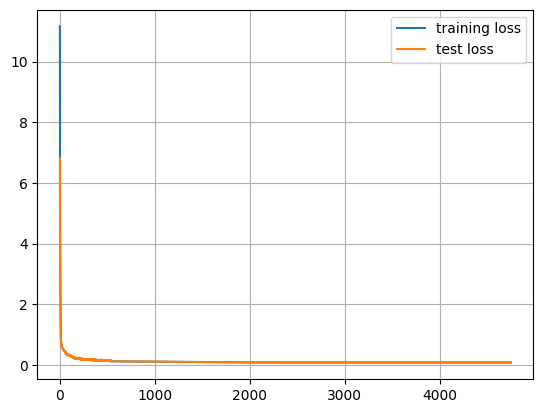

--------------------  EPOCH: 4750  --------------------
LOSS train 0.07835127458888658 valid 0.0792655274271965
--------------------  EPOCH: 4751  --------------------
LOSS train 0.07834819050467744 valid 0.07926563173532486
--------------------  EPOCH: 4752  --------------------
LOSS train 0.07834712035801945 valid 0.07926581054925919
--------------------  EPOCH: 4753  --------------------
LOSS train 0.07836275030763781 valid 0.07926575839519501
--------------------  EPOCH: 4754  --------------------
LOSS train 0.07836186794602142 valid 0.07926565408706665
--------------------  EPOCH: 4755  --------------------
LOSS train 0.07834642182807533 valid 0.07926551252603531
--------------------  EPOCH: 4756  --------------------
LOSS train 0.07835087316985033 valid 0.07926757633686066
--------------------  EPOCH: 4757  --------------------
LOSS train 0.07834774423010495 valid 0.07926549762487411
--------------------  EPOCH: 4758  --------------------
LOSS train 0.07835140444186268 valid 0.07

LOSS train 0.07834196166724575 valid 0.07926421612501144
--------------------  EPOCH: 4824  --------------------
LOSS train 0.07835299035116118 valid 0.0792633593082428
--------------------  EPOCH: 4825  --------------------
LOSS train 0.07834774103699899 valid 0.07926422357559204
--------------------  EPOCH: 4826  --------------------
LOSS train 0.07836015248785214 valid 0.07926394045352936
--------------------  EPOCH: 4827  --------------------
LOSS train 0.07834813272466465 valid 0.07926532626152039
--------------------  EPOCH: 4828  --------------------
LOSS train 0.0783505950655256 valid 0.07926374673843384
--------------------  EPOCH: 4829  --------------------
LOSS train 0.07834253809889968 valid 0.07926393300294876
--------------------  EPOCH: 4830  --------------------
LOSS train 0.07835241087845393 valid 0.07926423102617264
--------------------  EPOCH: 4831  --------------------
LOSS train 0.07833346891768124 valid 0.07926367223262787
--------------------  EPOCH: 4832  ------

LOSS train 0.07833969653869162 valid 0.07926216721534729
--------------------  EPOCH: 4897  --------------------
LOSS train 0.07835305816664988 valid 0.07926197350025177
--------------------  EPOCH: 4898  --------------------
LOSS train 0.07834511508747023 valid 0.0792621448636055
--------------------  EPOCH: 4899  --------------------
LOSS train 0.07834257656822399 valid 0.07926194369792938
--------------------  EPOCH: 4900  --------------------
LOSS train 0.0783519341933484 valid 0.07926218211650848
--------------------  EPOCH: 4901  --------------------
LOSS train 0.07834559861494571 valid 0.07926195114850998
--------------------  EPOCH: 4902  --------------------
LOSS train 0.07834208771890523 valid 0.07926256209611893
--------------------  EPOCH: 4903  --------------------
LOSS train 0.07835241604824456 valid 0.07926224917173386
--------------------  EPOCH: 4904  --------------------
LOSS train 0.07834536567026255 valid 0.07926294952630997
--------------------  EPOCH: 4905  ------

LOSS train 0.07834716551766104 valid 0.07926235347986221
--------------------  EPOCH: 4970  --------------------
LOSS train 0.07833991595068757 valid 0.07926060259342194
--------------------  EPOCH: 4971  --------------------
LOSS train 0.07834764737255719 valid 0.07926005125045776
--------------------  EPOCH: 4972  --------------------
LOSS train 0.07835667686803001 valid 0.07925966382026672
--------------------  EPOCH: 4973  --------------------
LOSS train 0.07833968908811102 valid 0.0792604386806488
--------------------  EPOCH: 4974  --------------------
LOSS train 0.07834886364182647 valid 0.07926012575626373
--------------------  EPOCH: 4975  --------------------
LOSS train 0.07833937753219994 valid 0.07925967127084732
--------------------  EPOCH: 4976  --------------------
LOSS train 0.07835554696467457 valid 0.07926122099161148
--------------------  EPOCH: 4977  --------------------
LOSS train 0.0783487681527527 valid 0.07925929874181747
--------------------  EPOCH: 4978  ------

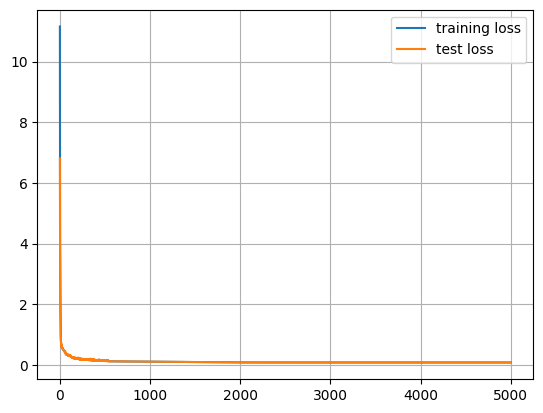

--------------------  EPOCH: 5000  --------------------
LOSS train 0.07834835745850388 valid 0.07926160097122192
--------------------  EPOCH: 5001  --------------------
LOSS train 0.07835453429392406 valid 0.07925910502672195
--------------------  EPOCH: 5002  --------------------
LOSS train 0.07834267251345577 valid 0.07925941795110703
--------------------  EPOCH: 5003  --------------------
LOSS train 0.07834122512413531 valid 0.07925910502672195
--------------------  EPOCH: 5004  --------------------
LOSS train 0.07835099739687783 valid 0.07925866544246674
--------------------  EPOCH: 5005  --------------------
LOSS train 0.0783490345490222 valid 0.07925979793071747
--------------------  EPOCH: 5006  --------------------
LOSS train 0.07834317595983038 valid 0.07925908267498016
--------------------  EPOCH: 5007  --------------------
LOSS train 0.07834336039971332 valid 0.07925869524478912
--------------------  EPOCH: 5008  --------------------
LOSS train 0.0783511471687531 valid 0.079

LOSS train 0.07833428954591556 valid 0.07925792038440704
--------------------  EPOCH: 5074  --------------------
LOSS train 0.07834636800143184 valid 0.0792577788233757
--------------------  EPOCH: 5075  --------------------
LOSS train 0.07833199248630174 valid 0.07925783097743988
--------------------  EPOCH: 5076  --------------------
LOSS train 0.07833969714690228 valid 0.07925700396299362
--------------------  EPOCH: 5077  --------------------
LOSS train 0.07834644478802778 valid 0.07925709336996078
--------------------  EPOCH: 5078  --------------------
LOSS train 0.07833783328533173 valid 0.07925831526517868
--------------------  EPOCH: 5079  --------------------
LOSS train 0.07833687322480339 valid 0.07925748825073242
--------------------  EPOCH: 5080  --------------------
LOSS train 0.0783445990207244 valid 0.07925719022750854
--------------------  EPOCH: 5081  --------------------
LOSS train 0.07834354134238496 valid 0.07925698906183243
--------------------  EPOCH: 5082  ------

LOSS train 0.07833259157380279 valid 0.07925588637590408
--------------------  EPOCH: 5147  --------------------
LOSS train 0.0783357895454582 valid 0.07925494015216827
--------------------  EPOCH: 5148  --------------------
LOSS train 0.07833342649498765 valid 0.0792556032538414
--------------------  EPOCH: 5149  --------------------
LOSS train 0.07833640551080509 valid 0.07925550639629364
--------------------  EPOCH: 5150  --------------------
LOSS train 0.07834099993413808 valid 0.07925550639629364
--------------------  EPOCH: 5151  --------------------
LOSS train 0.07834407124592334 valid 0.07925565540790558
--------------------  EPOCH: 5152  --------------------
LOSS train 0.07835371427390041 valid 0.07925520092248917
--------------------  EPOCH: 5153  --------------------
LOSS train 0.07834322294410394 valid 0.07925613224506378
--------------------  EPOCH: 5154  --------------------
LOSS train 0.07833956607750484 valid 0.07925604283809662
--------------------  EPOCH: 5155  ------

LOSS train 0.0783471455987619 valid 0.07925332337617874
--------------------  EPOCH: 5220  --------------------
LOSS train 0.07832846896989006 valid 0.07925549894571304
--------------------  EPOCH: 5221  --------------------
LOSS train 0.07834016607732189 valid 0.07925345748662949
--------------------  EPOCH: 5222  --------------------
LOSS train 0.07834379861549455 valid 0.0792534351348877
--------------------  EPOCH: 5223  --------------------
LOSS train 0.07833785578912618 valid 0.07925320416688919
--------------------  EPOCH: 5224  --------------------
LOSS train 0.07833400034174627 valid 0.07925333827733994
--------------------  EPOCH: 5225  --------------------
LOSS train 0.07833511063030787 valid 0.0792531669139862
--------------------  EPOCH: 5226  --------------------
LOSS train 0.07834485811846596 valid 0.07925310730934143
--------------------  EPOCH: 5227  --------------------
LOSS train 0.07834556790030732 valid 0.07925295829772949
--------------------  EPOCH: 5228  -------

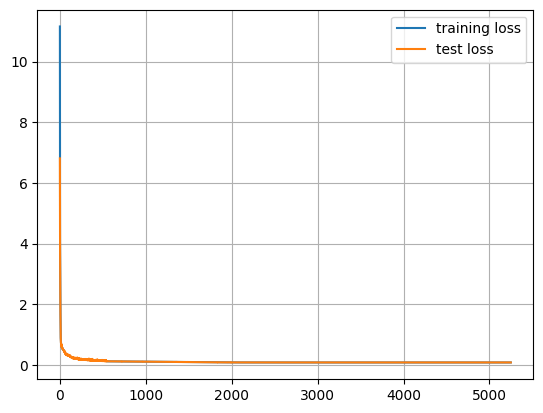

--------------------  EPOCH: 5250  --------------------
LOSS train 0.07833835330544686 valid 0.07925263047218323
--------------------  EPOCH: 5251  --------------------
LOSS train 0.0783434869075308 valid 0.07925271987915039
--------------------  EPOCH: 5252  --------------------
LOSS train 0.07833567869906523 valid 0.07925227284431458
--------------------  EPOCH: 5253  --------------------
LOSS train 0.07833201346956954 valid 0.0792534127831459
--------------------  EPOCH: 5254  --------------------
LOSS train 0.07833507109661492 valid 0.07925289124250412
--------------------  EPOCH: 5255  --------------------
LOSS train 0.07833462968772771 valid 0.07925280928611755
--------------------  EPOCH: 5256  --------------------
LOSS train 0.07834415761183719 valid 0.07925231754779816
--------------------  EPOCH: 5257  --------------------
LOSS train 0.07834306070391013 valid 0.07925304025411606
--------------------  EPOCH: 5258  --------------------
LOSS train 0.07833138290716678 valid 0.079

LOSS train 0.07833378929264691 valid 0.0792510062456131
--------------------  EPOCH: 5324  --------------------
LOSS train 0.07833614002685158 valid 0.07925066351890564
--------------------  EPOCH: 5325  --------------------
LOSS train 0.0783421696752918 valid 0.07925056666135788
--------------------  EPOCH: 5326  --------------------
LOSS train 0.07833504433534583 valid 0.07925049215555191
--------------------  EPOCH: 5327  --------------------
LOSS train 0.07834272132236131 valid 0.0792507454752922
--------------------  EPOCH: 5328  --------------------
LOSS train 0.0783366504676488 valid 0.07925034314393997
--------------------  EPOCH: 5329  --------------------
LOSS train 0.07834414848867728 valid 0.07925017178058624
--------------------  EPOCH: 5330  --------------------
LOSS train 0.07833402679891002 valid 0.07925007492303848
--------------------  EPOCH: 5331  --------------------
LOSS train 0.07833877631596156 valid 0.07925046235322952
--------------------  EPOCH: 5332  --------

LOSS train 0.07833104033251198 valid 0.07924844324588776
--------------------  EPOCH: 5397  --------------------
LOSS train 0.07833239725049661 valid 0.07924884557723999
--------------------  EPOCH: 5398  --------------------
LOSS train 0.07833494139569146 valid 0.07924994826316833
--------------------  EPOCH: 5399  --------------------
LOSS train 0.07833911660982638 valid 0.07924891263246536
--------------------  EPOCH: 5400  --------------------
LOSS train 0.07833514590652621 valid 0.07924947142601013
--------------------  EPOCH: 5401  --------------------
LOSS train 0.07832334479507135 valid 0.07924936711788177
--------------------  EPOCH: 5402  --------------------
LOSS train 0.07833839876919377 valid 0.07924827188253403
--------------------  EPOCH: 5403  --------------------
LOSS train 0.07833654296641447 valid 0.07924895733594894
--------------------  EPOCH: 5404  --------------------
LOSS train 0.07834171853503402 valid 0.07924937456846237
--------------------  EPOCH: 5405  ----

LOSS train 0.07833623855697866 valid 0.07924730330705643
--------------------  EPOCH: 5470  --------------------
LOSS train 0.07833577205940169 valid 0.07924692332744598
--------------------  EPOCH: 5471  --------------------
LOSS train 0.07833806987927884 valid 0.07924716174602509
--------------------  EPOCH: 5472  --------------------
LOSS train 0.07833795340693726 valid 0.07924671471118927
--------------------  EPOCH: 5473  --------------------
LOSS train 0.07833467667200128 valid 0.07924750447273254
--------------------  EPOCH: 5474  --------------------
LOSS train 0.07833543100527354 valid 0.07924643158912659
--------------------  EPOCH: 5475  --------------------
LOSS train 0.07833029481829429 valid 0.07924780249595642
--------------------  EPOCH: 5476  --------------------
LOSS train 0.07832557495151247 valid 0.07924684882164001
--------------------  EPOCH: 5477  --------------------
LOSS train 0.07833503141086928 valid 0.07924742996692657
--------------------  EPOCH: 5478  ----

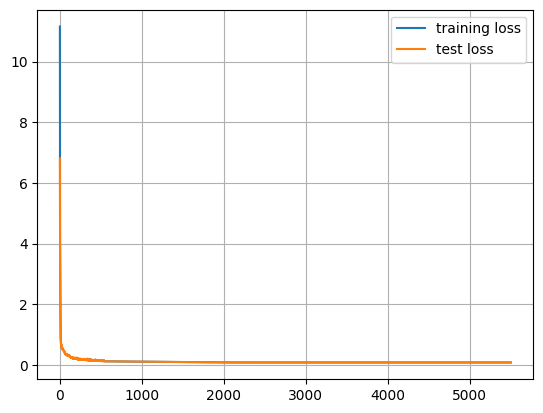

--------------------  EPOCH: 5500  --------------------
LOSS train 0.07833550703160617 valid 0.07924631237983704
--------------------  EPOCH: 5501  --------------------
LOSS train 0.07832967216263012 valid 0.07924626767635345
--------------------  EPOCH: 5502  --------------------
LOSS train 0.07833447079269254 valid 0.07924772053956985
--------------------  EPOCH: 5503  --------------------
LOSS train 0.0783327258363062 valid 0.07924611121416092
--------------------  EPOCH: 5504  --------------------
LOSS train 0.07832789846829005 valid 0.07924589514732361
--------------------  EPOCH: 5505  --------------------
LOSS train 0.07833643014333685 valid 0.07924599945545197
--------------------  EPOCH: 5506  --------------------
LOSS train 0.07832636760205638 valid 0.07924604415893555
--------------------  EPOCH: 5507  --------------------
LOSS train 0.07833102436698212 valid 0.0792456716299057
--------------------  EPOCH: 5508  --------------------
LOSS train 0.07833605229246374 valid 0.079

LOSS train 0.07835249815668378 valid 0.07924381643533707
--------------------  EPOCH: 5574  --------------------
LOSS train 0.07832851641032161 valid 0.07924410700798035
--------------------  EPOCH: 5575  --------------------
LOSS train 0.07833012299878257 valid 0.07924395054578781
--------------------  EPOCH: 5576  --------------------
LOSS train 0.07834006815540548 valid 0.07924389839172363
--------------------  EPOCH: 5577  --------------------
LOSS train 0.07831699553192878 valid 0.07924424111843109
--------------------  EPOCH: 5578  --------------------
LOSS train 0.07833094894886017 valid 0.0792439877986908
--------------------  EPOCH: 5579  --------------------
LOSS train 0.07833481397555798 valid 0.07924404740333557
--------------------  EPOCH: 5580  --------------------
LOSS train 0.078343394155405 valid 0.07924390584230423
--------------------  EPOCH: 5581  --------------------
LOSS train 0.07832865417003632 valid 0.0792449489235878
--------------------  EPOCH: 5582  --------

LOSS train 0.07832151225634984 valid 0.07924217730760574
--------------------  EPOCH: 5647  --------------------
LOSS train 0.07832553785066215 valid 0.07924279570579529
--------------------  EPOCH: 5648  --------------------
LOSS train 0.07832385690844788 valid 0.07924231141805649
--------------------  EPOCH: 5649  --------------------
LOSS train 0.07832035741635732 valid 0.07924307137727737
--------------------  EPOCH: 5650  --------------------
LOSS train 0.07833538356484199 valid 0.07924354821443558
--------------------  EPOCH: 5651  --------------------
LOSS train 0.07833632401057652 valid 0.07924336194992065
--------------------  EPOCH: 5652  --------------------
LOSS train 0.07832863333882117 valid 0.079243004322052
--------------------  EPOCH: 5653  --------------------
LOSS train 0.07833819030498972 valid 0.0792430117726326
--------------------  EPOCH: 5654  --------------------
LOSS train 0.07832622847386769 valid 0.07924208045005798
--------------------  EPOCH: 5655  -------

LOSS train 0.07832746527024678 valid 0.07924074679613113
--------------------  EPOCH: 5720  --------------------
LOSS train 0.07833214940465226 valid 0.07924073934555054
--------------------  EPOCH: 5721  --------------------
LOSS train 0.07832632837246875 valid 0.07924055308103561
--------------------  EPOCH: 5722  --------------------
LOSS train 0.07832486988330374 valid 0.0792398676276207
--------------------  EPOCH: 5723  --------------------
LOSS train 0.07832230277815644 valid 0.07924018055200577
--------------------  EPOCH: 5724  --------------------
LOSS train 0.07832618437859477 valid 0.07923999428749084
--------------------  EPOCH: 5725  --------------------
LOSS train 0.07833009547725016 valid 0.07924047857522964
--------------------  EPOCH: 5726  --------------------
LOSS train 0.0783233996860835 valid 0.07924018055200577
--------------------  EPOCH: 5727  --------------------
LOSS train 0.07832863425113717 valid 0.07924102246761322
--------------------  EPOCH: 5728  ------

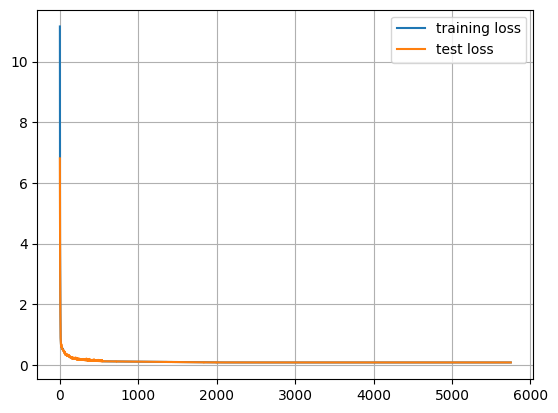

--------------------  EPOCH: 5750  --------------------
LOSS train 0.07833132755999662 valid 0.07924091070890427
--------------------  EPOCH: 5751  --------------------
LOSS train 0.07833109309478682 valid 0.07924184948205948
--------------------  EPOCH: 5752  --------------------
LOSS train 0.07832912051556062 valid 0.07923944294452667
--------------------  EPOCH: 5753  --------------------
LOSS train 0.0783235891437044 valid 0.07923903316259384
--------------------  EPOCH: 5754  --------------------
LOSS train 0.07832465077541312 valid 0.07923949509859085
--------------------  EPOCH: 5755  --------------------
LOSS train 0.07834104691841165 valid 0.07923979312181473
--------------------  EPOCH: 5756  --------------------
LOSS train 0.0783198893982537 valid 0.07924062013626099
--------------------  EPOCH: 5757  --------------------
LOSS train 0.07832368432867284 valid 0.07923901826143265
--------------------  EPOCH: 5758  --------------------
LOSS train 0.07832824180320817 valid 0.079

LOSS train 0.07831699492371812 valid 0.07923755049705505
--------------------  EPOCH: 5824  --------------------
LOSS train 0.07831885467986671 valid 0.07923758774995804
--------------------  EPOCH: 5825  --------------------
LOSS train 0.07832396942742016 valid 0.07923757284879684
--------------------  EPOCH: 5826  --------------------
LOSS train 0.07832044210969186 valid 0.07923737913370132
--------------------  EPOCH: 5827  --------------------
LOSS train 0.07832423749626899 valid 0.07923866808414459
--------------------  EPOCH: 5828  --------------------
LOSS train 0.07831970617479207 valid 0.07923811674118042
--------------------  EPOCH: 5829  --------------------
LOSS train 0.07833275259757529 valid 0.07923723757266998
--------------------  EPOCH: 5830  --------------------
LOSS train 0.07832569416080203 valid 0.07923730462789536
--------------------  EPOCH: 5831  --------------------
LOSS train 0.07832024885075432 valid 0.07924066483974457
--------------------  EPOCH: 5832  ----

LOSS train 0.07833196800582264 valid 0.07923661917448044
--------------------  EPOCH: 5897  --------------------
LOSS train 0.07832814251281778 valid 0.07923564314842224
--------------------  EPOCH: 5898  --------------------
LOSS train 0.07833147018539663 valid 0.07923569530248642
--------------------  EPOCH: 5899  --------------------
LOSS train 0.07832816136734826 valid 0.07923571020364761
--------------------  EPOCH: 5900  --------------------
LOSS train 0.07832691073417664 valid 0.07923565804958344
--------------------  EPOCH: 5901  --------------------
LOSS train 0.07832268823166283 valid 0.07923661172389984
--------------------  EPOCH: 5902  --------------------
LOSS train 0.07832626527061268 valid 0.07923585921525955
--------------------  EPOCH: 5903  --------------------
LOSS train 0.07831484702776889 valid 0.07923576235771179
--------------------  EPOCH: 5904  --------------------
LOSS train 0.07832513962473188 valid 0.07923547923564911
--------------------  EPOCH: 5905  ----

LOSS train 0.078319962383533 valid 0.07923362404108047
--------------------  EPOCH: 5970  --------------------
LOSS train 0.07831531230892454 valid 0.07923624664545059
--------------------  EPOCH: 5971  --------------------
LOSS train 0.07831233207668577 valid 0.07923431694507599
--------------------  EPOCH: 5972  --------------------
LOSS train 0.07832286324428052 valid 0.0792335793375969
--------------------  EPOCH: 5973  --------------------
LOSS train 0.07832285077596197 valid 0.07923371344804764
--------------------  EPOCH: 5974  --------------------
LOSS train 0.07832129558130187 valid 0.07923373579978943
--------------------  EPOCH: 5975  --------------------
LOSS train 0.07832622680128837 valid 0.07923397421836853
--------------------  EPOCH: 5976  --------------------
LOSS train 0.07830895939651801 valid 0.07923346757888794
--------------------  EPOCH: 5977  --------------------
LOSS train 0.07832024520149036 valid 0.07923389971256256
--------------------  EPOCH: 5978  -------

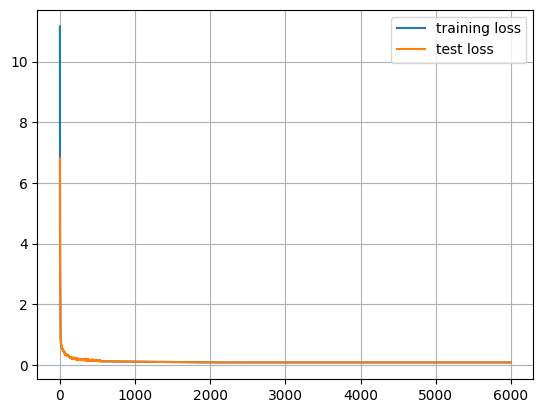

--------------------  EPOCH: 6000  --------------------
LOSS train 0.07832347632062678 valid 0.07923292368650436
--------------------  EPOCH: 6001  --------------------
LOSS train 0.0783241398784579 valid 0.07923395931720734
--------------------  EPOCH: 6002  --------------------
LOSS train 0.07831236157490283 valid 0.07923300564289093
--------------------  EPOCH: 6003  --------------------
LOSS train 0.0783190271075891 valid 0.07923838496208191
--------------------  EPOCH: 6004  --------------------
LOSS train 0.07831840308345094 valid 0.07923304289579391
--------------------  EPOCH: 6005  --------------------
LOSS train 0.07831914357993068 valid 0.07923314720392227
--------------------  EPOCH: 6006  --------------------
LOSS train 0.0783279656755681 valid 0.07923322916030884
--------------------  EPOCH: 6007  --------------------
LOSS train 0.07832610211810287 valid 0.07923368364572525
--------------------  EPOCH: 6008  --------------------
LOSS train 0.07831725295709104 valid 0.0792

LOSS train 0.07830783375063721 valid 0.0792338103055954
--------------------  EPOCH: 6074  --------------------
LOSS train 0.07832044727948247 valid 0.07923131436109543
--------------------  EPOCH: 6075  --------------------
LOSS train 0.0783101633495214 valid 0.07923153042793274
--------------------  EPOCH: 6076  --------------------
LOSS train 0.07831212726174569 valid 0.07923126220703125
--------------------  EPOCH: 6077  --------------------
LOSS train 0.07833575578976651 valid 0.07923104614019394
--------------------  EPOCH: 6078  --------------------
LOSS train 0.07832069208427352 valid 0.07923099398612976
--------------------  EPOCH: 6079  --------------------
LOSS train 0.07833077986629641 valid 0.07923108339309692
--------------------  EPOCH: 6080  --------------------
LOSS train 0.07831961920066756 valid 0.07923132181167603
--------------------  EPOCH: 6081  --------------------
LOSS train 0.07832373359373637 valid 0.07923121750354767
--------------------  EPOCH: 6082  ------

LOSS train 0.07831968610384027 valid 0.07922985404729843
--------------------  EPOCH: 6147  --------------------
LOSS train 0.07831613202484286 valid 0.07922939211130142
--------------------  EPOCH: 6148  --------------------
LOSS train 0.07831112173747043 valid 0.07922957837581635
--------------------  EPOCH: 6149  --------------------
LOSS train 0.07831774697620042 valid 0.07922940701246262
--------------------  EPOCH: 6150  --------------------
LOSS train 0.07831616334769191 valid 0.07922928035259247
--------------------  EPOCH: 6151  --------------------
LOSS train 0.07830881190543272 valid 0.0792294591665268
--------------------  EPOCH: 6152  --------------------
LOSS train 0.07832176359940549 valid 0.07922925800085068
--------------------  EPOCH: 6153  --------------------
LOSS train 0.07830815914334083 valid 0.07922922819852829
--------------------  EPOCH: 6154  --------------------
LOSS train 0.07831738159364583 valid 0.07922912389039993
--------------------  EPOCH: 6155  -----

LOSS train 0.07831054880302779 valid 0.07922755181789398
--------------------  EPOCH: 6220  --------------------
LOSS train 0.0783108764765214 valid 0.0792282223701477
--------------------  EPOCH: 6221  --------------------
LOSS train 0.07831007272613291 valid 0.07922716438770294
--------------------  EPOCH: 6222  --------------------
LOSS train 0.07831279963863139 valid 0.07922699302434921
--------------------  EPOCH: 6223  --------------------
LOSS train 0.0783086347640777 valid 0.07922717928886414
--------------------  EPOCH: 6224  --------------------
LOSS train 0.07830637510941953 valid 0.0792279839515686
--------------------  EPOCH: 6225  --------------------
LOSS train 0.07832067079690037 valid 0.07922695577144623
--------------------  EPOCH: 6226  --------------------
LOSS train 0.07831136715047214 valid 0.0792270228266716
--------------------  EPOCH: 6227  --------------------
LOSS train 0.0783200131691232 valid 0.07922792434692383
--------------------  EPOCH: 6228  ----------

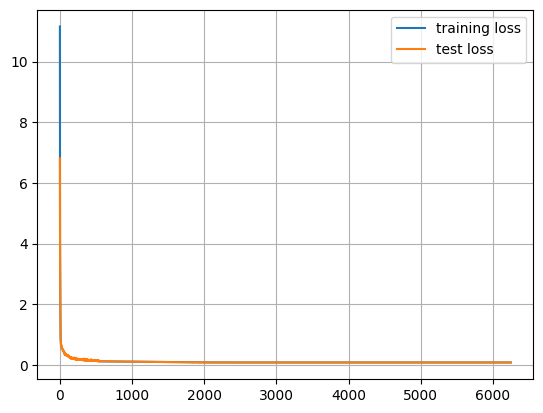

--------------------  EPOCH: 6250  --------------------
LOSS train 0.07832461078556216 valid 0.07922745496034622
--------------------  EPOCH: 6251  --------------------
LOSS train 0.078314123409135 valid 0.07922748476266861
--------------------  EPOCH: 6252  --------------------
LOSS train 0.07831714728048869 valid 0.07922658324241638
--------------------  EPOCH: 6253  --------------------
LOSS train 0.07831342837640218 valid 0.07922730594873428
--------------------  EPOCH: 6254  --------------------
LOSS train 0.07831436897418936 valid 0.07922686636447906
--------------------  EPOCH: 6255  --------------------
LOSS train 0.07831499071753754 valid 0.07922644168138504
--------------------  EPOCH: 6256  --------------------
LOSS train 0.07831327495526294 valid 0.07922700047492981
--------------------  EPOCH: 6257  --------------------
LOSS train 0.07831535017003818 valid 0.07922668755054474
--------------------  EPOCH: 6258  --------------------
LOSS train 0.07830832442458795 valid 0.079

LOSS train 0.07831524008390855 valid 0.0792248472571373
--------------------  EPOCH: 6324  --------------------
LOSS train 0.0783132939618461 valid 0.07922493666410446
--------------------  EPOCH: 6325  --------------------
LOSS train 0.078315369328674 valid 0.07922451943159103
--------------------  EPOCH: 6326  --------------------
LOSS train 0.07830553912386602 valid 0.07922452688217163
--------------------  EPOCH: 6327  --------------------
LOSS train 0.078314265122219 valid 0.07922503352165222
--------------------  EPOCH: 6328  --------------------
LOSS train 0.07830759107458349 valid 0.07922491431236267
--------------------  EPOCH: 6329  --------------------
LOSS train 0.078315475613487 valid 0.07922501116991043
--------------------  EPOCH: 6330  --------------------
LOSS train 0.0783152963433947 valid 0.07922443747520447
--------------------  EPOCH: 6331  --------------------
LOSS train 0.07830816476928945 valid 0.07922559231519699
--------------------  EPOCH: 6332  -------------

LOSS train 0.07830914353229562 valid 0.07922348380088806
--------------------  EPOCH: 6397  --------------------
LOSS train 0.0783105877285101 valid 0.07922261208295822
--------------------  EPOCH: 6398  --------------------
LOSS train 0.07831168585285848 valid 0.07922295480966568
--------------------  EPOCH: 6399  --------------------
LOSS train 0.07830165569879571 valid 0.07922284305095673
--------------------  EPOCH: 6400  --------------------
LOSS train 0.07831072852927812 valid 0.07922329753637314
--------------------  EPOCH: 6401  --------------------
LOSS train 0.07829429406900795 valid 0.0792224258184433
--------------------  EPOCH: 6402  --------------------
LOSS train 0.07830754652315257 valid 0.07922238111495972
--------------------  EPOCH: 6403  --------------------
LOSS train 0.07831195209707532 valid 0.0792231485247612
--------------------  EPOCH: 6404  --------------------
LOSS train 0.07831295473234993 valid 0.07922285795211792
--------------------  EPOCH: 6405  -------

LOSS train 0.0783152092172175 valid 0.07922147959470749
--------------------  EPOCH: 6470  --------------------
LOSS train 0.07830740085669927 valid 0.07922086119651794
--------------------  EPOCH: 6471  --------------------
LOSS train 0.07830608240803894 valid 0.07922115921974182
--------------------  EPOCH: 6472  --------------------
LOSS train 0.0783081269081758 valid 0.0792209655046463
--------------------  EPOCH: 6473  --------------------
LOSS train 0.07831913552113942 valid 0.0792209804058075
--------------------  EPOCH: 6474  --------------------
LOSS train 0.07831436669339939 valid 0.07922138273715973
--------------------  EPOCH: 6475  --------------------
LOSS train 0.07831019421621245 valid 0.07922069728374481
--------------------  EPOCH: 6476  --------------------
LOSS train 0.07830502685843682 valid 0.07922066748142242
--------------------  EPOCH: 6477  --------------------
LOSS train 0.07830925757179455 valid 0.07922077924013138
--------------------  EPOCH: 6478  --------

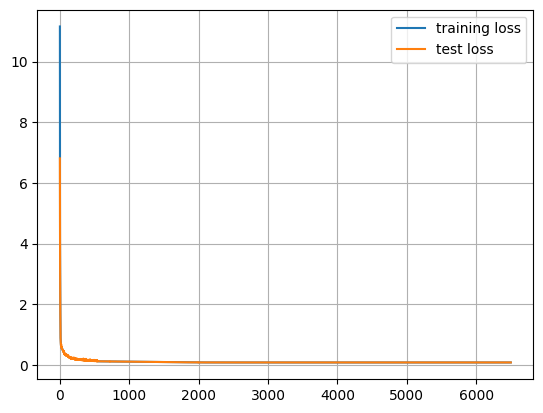

--------------------  EPOCH: 6500  --------------------
LOSS train 0.07831235594895421 valid 0.07922035455703735
--------------------  EPOCH: 6501  --------------------
LOSS train 0.07830672133333828 valid 0.0792202353477478
--------------------  EPOCH: 6502  --------------------
LOSS train 0.0783042770867445 valid 0.07922115921974182
--------------------  EPOCH: 6503  --------------------
LOSS train 0.07830437424839759 valid 0.07922366261482239
--------------------  EPOCH: 6504  --------------------
LOSS train 0.07830242751812448 valid 0.07922045141458511
--------------------  EPOCH: 6505  --------------------
LOSS train 0.07831196045997191 valid 0.0792209804058075
--------------------  EPOCH: 6506  --------------------
LOSS train 0.07830555630581719 valid 0.07922063767910004
--------------------  EPOCH: 6507  --------------------
LOSS train 0.0783105103337035 valid 0.07922028005123138
--------------------  EPOCH: 6508  --------------------
LOSS train 0.07831093957837747 valid 0.07922

LOSS train 0.07830286968727501 valid 0.0792185589671135
--------------------  EPOCH: 6574  --------------------
LOSS train 0.07830685924510566 valid 0.0792188048362732
--------------------  EPOCH: 6575  --------------------
LOSS train 0.0783081304053871 valid 0.07921818643808365
--------------------  EPOCH: 6576  --------------------
LOSS train 0.07830189655021745 valid 0.0792195275425911
--------------------  EPOCH: 6577  --------------------
LOSS train 0.07830359862775219 valid 0.07921871542930603
--------------------  EPOCH: 6578  --------------------
LOSS train 0.07829939832492751 valid 0.07921886444091797
--------------------  EPOCH: 6579  --------------------
LOSS train 0.07830612224583723 valid 0.07921822369098663
--------------------  EPOCH: 6580  --------------------
LOSS train 0.07830645828222742 valid 0.07921883463859558
--------------------  EPOCH: 6581  --------------------
LOSS train 0.07831326750468234 valid 0.07922019064426422
--------------------  EPOCH: 6582  --------

LOSS train 0.07831016806315402 valid 0.07921711355447769
--------------------  EPOCH: 6647  --------------------
LOSS train 0.0783056276185172 valid 0.079216368496418
--------------------  EPOCH: 6648  --------------------
LOSS train 0.07831012640072375 valid 0.07921654731035233
--------------------  EPOCH: 6649  --------------------
LOSS train 0.07831039386136192 valid 0.07921714335680008
--------------------  EPOCH: 6650  --------------------
LOSS train 0.07830035321566524 valid 0.07921648770570755
--------------------  EPOCH: 6651  --------------------
LOSS train 0.07829344272613525 valid 0.07921828329563141
--------------------  EPOCH: 6652  --------------------
LOSS train 0.07831046943153654 valid 0.07921712845563889
--------------------  EPOCH: 6653  --------------------
LOSS train 0.07830672178949628 valid 0.07921678572893143
--------------------  EPOCH: 6654  --------------------
LOSS train 0.0782960914835638 valid 0.07921645790338516
--------------------  EPOCH: 6655  --------

LOSS train 0.07830945615257535 valid 0.07921760529279709
--------------------  EPOCH: 6720  --------------------
LOSS train 0.078313590160438 valid 0.07921455800533295
--------------------  EPOCH: 6721  --------------------
LOSS train 0.0783040526570106 valid 0.07921439409255981
--------------------  EPOCH: 6722  --------------------
LOSS train 0.07830260587590081 valid 0.07921487092971802
--------------------  EPOCH: 6723  --------------------
LOSS train 0.07829595341974376 valid 0.0792149007320404
--------------------  EPOCH: 6724  --------------------
LOSS train 0.07830111454336011 valid 0.0792149230837822
--------------------  EPOCH: 6725  --------------------
LOSS train 0.07829636502630856 valid 0.07921512424945831
--------------------  EPOCH: 6726  --------------------
LOSS train 0.07830059148219166 valid 0.07921471446752548
--------------------  EPOCH: 6727  --------------------
LOSS train 0.07830030729576033 valid 0.07921440899372101
--------------------  EPOCH: 6728  ---------

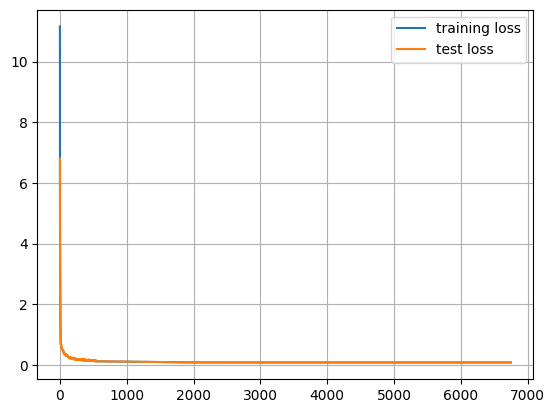

--------------------  EPOCH: 6750  --------------------
LOSS train 0.07831290820423438 valid 0.07921424508094788
--------------------  EPOCH: 6751  --------------------
LOSS train 0.07830315159291637 valid 0.07921407371759415
--------------------  EPOCH: 6752  --------------------
LOSS train 0.07830165524263771 valid 0.07921376079320908
--------------------  EPOCH: 6753  --------------------
LOSS train 0.07830027749343794 valid 0.07921382784843445
--------------------  EPOCH: 6754  --------------------
LOSS train 0.07830072133516779 valid 0.079213947057724
--------------------  EPOCH: 6755  --------------------
LOSS train 0.07830336218585773 valid 0.07921392470598221
--------------------  EPOCH: 6756  --------------------
LOSS train 0.07828970664009756 valid 0.07921388745307922
--------------------  EPOCH: 6757  --------------------
LOSS train 0.07829881185779766 valid 0.07921440154314041
--------------------  EPOCH: 6758  --------------------
LOSS train 0.07829340106370497 valid 0.079

LOSS train 0.07829962762034669 valid 0.07921186089515686
--------------------  EPOCH: 6824  --------------------
LOSS train 0.07829062792719627 valid 0.07921336591243744
--------------------  EPOCH: 6825  --------------------
LOSS train 0.07830781778510736 valid 0.07921212166547775
--------------------  EPOCH: 6826  --------------------
LOSS train 0.07829723583192241 valid 0.07921227812767029
--------------------  EPOCH: 6827  --------------------
LOSS train 0.07829563137219876 valid 0.07921214401721954
--------------------  EPOCH: 6828  --------------------
LOSS train 0.07830348899778054 valid 0.07921217381954193
--------------------  EPOCH: 6829  --------------------
LOSS train 0.07830296487224345 valid 0.07921179383993149
--------------------  EPOCH: 6830  --------------------
LOSS train 0.07830072224748377 valid 0.07921203970909119
--------------------  EPOCH: 6831  --------------------
LOSS train 0.07829853223294628 valid 0.07921255379915237
--------------------  EPOCH: 6832  ----

LOSS train 0.0782997837784339 valid 0.07921016961336136
--------------------  EPOCH: 6897  --------------------
LOSS train 0.07830350511536306 valid 0.07921013981103897
--------------------  EPOCH: 6898  --------------------
LOSS train 0.07829671809259726 valid 0.07921074330806732
--------------------  EPOCH: 6899  --------------------
LOSS train 0.0783033982223394 valid 0.0792127251625061
--------------------  EPOCH: 6900  --------------------
LOSS train 0.07828829331057412 valid 0.07920978963375092
--------------------  EPOCH: 6901  --------------------
LOSS train 0.07829468636488428 valid 0.07921020686626434
--------------------  EPOCH: 6902  --------------------
LOSS train 0.07829636745915121 valid 0.07920997589826584
--------------------  EPOCH: 6903  --------------------
LOSS train 0.07830227090387928 valid 0.079210065305233
--------------------  EPOCH: 6904  --------------------
LOSS train 0.07830096918101213 valid 0.07921082526445389
--------------------  EPOCH: 6905  ---------

LOSS train 0.07828959427317794 valid 0.07921012490987778
--------------------  EPOCH: 6970  --------------------
LOSS train 0.07829757308473392 valid 0.07920911908149719
--------------------  EPOCH: 6971  --------------------
LOSS train 0.07829901652068508 valid 0.07920873910188675
--------------------  EPOCH: 6972  --------------------
LOSS train 0.07829672736780983 valid 0.07921046018600464
--------------------  EPOCH: 6973  --------------------
LOSS train 0.078295642624096 valid 0.0792078822851181
--------------------  EPOCH: 6974  --------------------
LOSS train 0.07829471373436403 valid 0.0792086198925972
--------------------  EPOCH: 6975  --------------------
LOSS train 0.07829866482287037 valid 0.07920864224433899
--------------------  EPOCH: 6976  --------------------
LOSS train 0.07830172701149571 valid 0.07920856028795242
--------------------  EPOCH: 6977  --------------------
LOSS train 0.07830090486273474 valid 0.07920821756124496
--------------------  EPOCH: 6978  --------

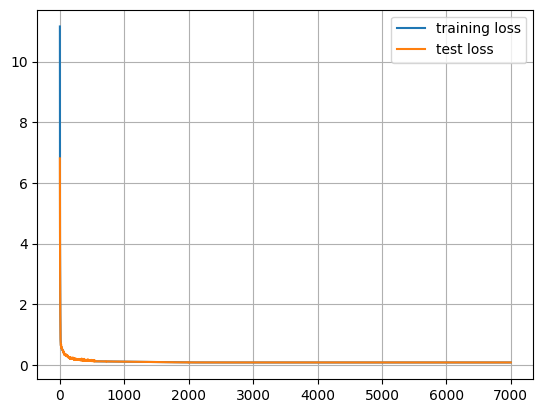

--------------------  EPOCH: 7000  --------------------
LOSS train 0.07828599716327628 valid 0.07920797169208527
--------------------  EPOCH: 7001  --------------------
LOSS train 0.0782990501243241 valid 0.0792079046368599
--------------------  EPOCH: 7002  --------------------
LOSS train 0.07828079878675695 valid 0.07920800894498825
--------------------  EPOCH: 7003  --------------------
LOSS train 0.07830394044214366 valid 0.07920772582292557
--------------------  EPOCH: 7004  --------------------
LOSS train 0.07829603659255165 valid 0.07920859754085541
--------------------  EPOCH: 7005  --------------------
LOSS train 0.07829057075539414 valid 0.07920777052640915
--------------------  EPOCH: 7006  --------------------
LOSS train 0.07829311611701031 valid 0.07920754700899124
--------------------  EPOCH: 7007  --------------------
LOSS train 0.07828969234714703 valid 0.07920744270086288
--------------------  EPOCH: 7008  --------------------
LOSS train 0.07829899644973326 valid 0.079

LOSS train 0.0783014536208036 valid 0.07920585572719574
--------------------  EPOCH: 7074  --------------------
LOSS train 0.07829771783887124 valid 0.07920580357313156
--------------------  EPOCH: 7075  --------------------
LOSS train 0.07830396203362212 valid 0.07920614629983902
--------------------  EPOCH: 7076  --------------------
LOSS train 0.0782839584411407 valid 0.07920587807893753
--------------------  EPOCH: 7077  --------------------
LOSS train 0.07828889589528648 valid 0.07920584082603455
--------------------  EPOCH: 7078  --------------------
LOSS train 0.0782908202738178 valid 0.07920549064874649
--------------------  EPOCH: 7079  --------------------
LOSS train 0.07829760760068893 valid 0.07920632511377335
--------------------  EPOCH: 7080  --------------------
LOSS train 0.07830223471534495 valid 0.07920560240745544
--------------------  EPOCH: 7081  --------------------
LOSS train 0.07830093892253175 valid 0.0792057067155838
--------------------  EPOCH: 7082  --------

LOSS train 0.07828933563159436 valid 0.07920408248901367
--------------------  EPOCH: 7147  --------------------
LOSS train 0.07829448991284078 valid 0.07920415699481964
--------------------  EPOCH: 7148  --------------------
LOSS train 0.07828524571900465 valid 0.07920534908771515
--------------------  EPOCH: 7149  --------------------
LOSS train 0.07829191185990159 valid 0.07920408993959427
--------------------  EPOCH: 7150  --------------------
LOSS train 0.07829466492545847 valid 0.07920385152101517
--------------------  EPOCH: 7151  --------------------
LOSS train 0.07828478636790295 valid 0.07920494675636292
--------------------  EPOCH: 7152  --------------------
LOSS train 0.07828771535839353 valid 0.07920355349779129
--------------------  EPOCH: 7153  --------------------
LOSS train 0.07829348606114485 valid 0.07920437306165695
--------------------  EPOCH: 7154  --------------------
LOSS train 0.0782981563587578 valid 0.07920368015766144
--------------------  EPOCH: 7155  -----

LOSS train 0.07829330907184251 valid 0.07920227199792862
--------------------  EPOCH: 7220  --------------------
LOSS train 0.0782807040579465 valid 0.07920222729444504
--------------------  EPOCH: 7221  --------------------
LOSS train 0.0782944771404169 valid 0.07920210808515549
--------------------  EPOCH: 7222  --------------------
LOSS train 0.07828984409570694 valid 0.07920309901237488
--------------------  EPOCH: 7223  --------------------
LOSS train 0.07828929974716536 valid 0.07920210063457489
--------------------  EPOCH: 7224  --------------------
LOSS train 0.07828384136058847 valid 0.07920284569263458
--------------------  EPOCH: 7225  --------------------
LOSS train 0.07828789432438052 valid 0.07920223474502563
--------------------  EPOCH: 7226  --------------------
LOSS train 0.0782898162700692 valid 0.07920216023921967
--------------------  EPOCH: 7227  --------------------
LOSS train 0.07828827202320099 valid 0.07920210063457489
--------------------  EPOCH: 7228  -------

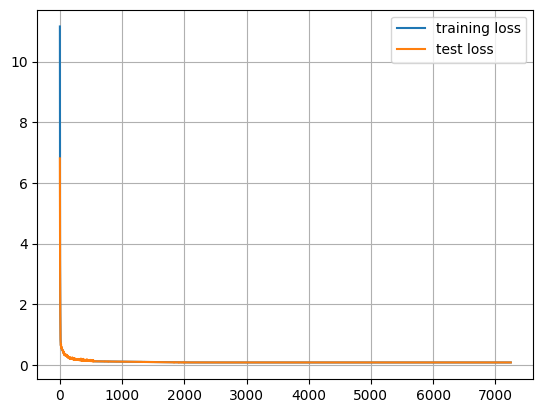

--------------------  EPOCH: 7250  --------------------
LOSS train 0.07829846137640428 valid 0.07920233905315399
--------------------  EPOCH: 7251  --------------------
LOSS train 0.07829122853522398 valid 0.07920287549495697
--------------------  EPOCH: 7252  --------------------
LOSS train 0.07828560015376733 valid 0.0792020931839943
--------------------  EPOCH: 7253  --------------------
LOSS train 0.07829359128158919 valid 0.07920167595148087
--------------------  EPOCH: 7254  --------------------
LOSS train 0.07828875965609843 valid 0.07920144498348236
--------------------  EPOCH: 7255  --------------------
LOSS train 0.07828345560297674 valid 0.07920167595148087
--------------------  EPOCH: 7256  --------------------
LOSS train 0.07828753563214322 valid 0.07920116931200027
--------------------  EPOCH: 7257  --------------------
LOSS train 0.07829161049151907 valid 0.07920203357934952
--------------------  EPOCH: 7258  --------------------
LOSS train 0.07828404632758121 valid 0.07

LOSS train 0.07828592311362831 valid 0.07920008152723312
--------------------  EPOCH: 7324  --------------------
LOSS train 0.07828933730417369 valid 0.0791996568441391
--------------------  EPOCH: 7325  --------------------
LOSS train 0.07828225605950064 valid 0.07919948548078537
--------------------  EPOCH: 7326  --------------------
LOSS train 0.07828801657472338 valid 0.0791996642947197
--------------------  EPOCH: 7327  --------------------
LOSS train 0.07828654242413384 valid 0.07919920980930328
--------------------  EPOCH: 7328  --------------------
LOSS train 0.07829435215312608 valid 0.07919967919588089
--------------------  EPOCH: 7329  --------------------
LOSS train 0.07829384003974954 valid 0.07919933646917343
--------------------  EPOCH: 7330  --------------------
LOSS train 0.0782793364962753 valid 0.07919956743717194
--------------------  EPOCH: 7331  --------------------
LOSS train 0.07829354916300092 valid 0.07920113950967789
--------------------  EPOCH: 7332  -------

LOSS train 0.07828100512222368 valid 0.07919744402170181
--------------------  EPOCH: 7397  --------------------
LOSS train 0.0782853815020347 valid 0.07919765263795853
--------------------  EPOCH: 7398  --------------------
LOSS train 0.07828908808985535 valid 0.07919828593730927
--------------------  EPOCH: 7399  --------------------
LOSS train 0.0782917398883372 valid 0.079198457300663
--------------------  EPOCH: 7400  --------------------
LOSS train 0.07828565504477948 valid 0.07919735461473465
--------------------  EPOCH: 7401  --------------------
LOSS train 0.0782888914857592 valid 0.07919972389936447
--------------------  EPOCH: 7402  --------------------
LOSS train 0.07828047156942133 valid 0.07919787615537643
--------------------  EPOCH: 7403  --------------------
LOSS train 0.07828563208482703 valid 0.07919783890247345
--------------------  EPOCH: 7404  --------------------
LOSS train 0.0782928856051698 valid 0.07919760048389435
--------------------  EPOCH: 7405  ----------

LOSS train 0.07828866720807795 valid 0.07919620722532272
--------------------  EPOCH: 7470  --------------------
LOSS train 0.07828577501433236 valid 0.07919612526893616
--------------------  EPOCH: 7471  --------------------
LOSS train 0.0782732507404016 valid 0.07919810712337494
--------------------  EPOCH: 7472  --------------------
LOSS train 0.07829107541819008 valid 0.07919681817293167
--------------------  EPOCH: 7473  --------------------
LOSS train 0.07828259863415543 valid 0.0791957676410675
--------------------  EPOCH: 7474  --------------------
LOSS train 0.0782845949335974 valid 0.07919646054506302
--------------------  EPOCH: 7475  --------------------
LOSS train 0.07828254283082728 valid 0.07919541746377945
--------------------  EPOCH: 7476  --------------------
LOSS train 0.07828121465079639 valid 0.0791965052485466
--------------------  EPOCH: 7477  --------------------
LOSS train 0.0782835065406196 valid 0.07919586449861526
--------------------  EPOCH: 7478  ---------

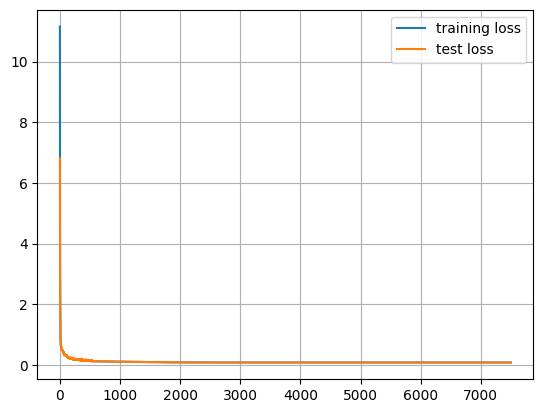

--------------------  EPOCH: 7500  --------------------
LOSS train 0.07828851454720205 valid 0.07919558137655258
--------------------  EPOCH: 7501  --------------------
LOSS train 0.07828655899787436 valid 0.07919542491436005
--------------------  EPOCH: 7502  --------------------
LOSS train 0.07828060674424074 valid 0.07919500023126602
--------------------  EPOCH: 7503  --------------------
LOSS train 0.07829216852480052 valid 0.07919523119926453
--------------------  EPOCH: 7504  --------------------
LOSS train 0.07828442022508504 valid 0.07919551432132721
--------------------  EPOCH: 7505  --------------------
LOSS train 0.07828805702073234 valid 0.07919471710920334
--------------------  EPOCH: 7506  --------------------
LOSS train 0.07828486680376287 valid 0.07919567078351974
--------------------  EPOCH: 7507  --------------------
LOSS train 0.0782783753713783 valid 0.07919551432132721
--------------------  EPOCH: 7508  --------------------
LOSS train 0.07828626827317842 valid 0.07

LOSS train 0.07828055656686121 valid 0.07919372618198395
--------------------  EPOCH: 7574  --------------------
LOSS train 0.07827542859072588 valid 0.07919333130121231
--------------------  EPOCH: 7575  --------------------
LOSS train 0.07827816903591156 valid 0.07919329404830933
--------------------  EPOCH: 7576  --------------------
LOSS train 0.07827918870108468 valid 0.07919327914714813
--------------------  EPOCH: 7577  --------------------
LOSS train 0.07827697739917405 valid 0.07919324934482574
--------------------  EPOCH: 7578  --------------------
LOSS train 0.07828333989089849 valid 0.07919400930404663
--------------------  EPOCH: 7579  --------------------
LOSS train 0.07829072067932207 valid 0.07919324934482574
--------------------  EPOCH: 7580  --------------------
LOSS train 0.07827762468736998 valid 0.07919368147850037
--------------------  EPOCH: 7581  --------------------
LOSS train 0.07827860314627083 valid 0.07919333130121231
--------------------  EPOCH: 7582  ----

LOSS train 0.07827807841252307 valid 0.07919187843799591
--------------------  EPOCH: 7647  --------------------
LOSS train 0.07828350380367162 valid 0.07919364422559738
--------------------  EPOCH: 7648  --------------------
LOSS train 0.07828303608967334 valid 0.07919222861528397
--------------------  EPOCH: 7649  --------------------
LOSS train 0.07827069138994022 valid 0.07919202744960785
--------------------  EPOCH: 7650  --------------------
LOSS train 0.07828490329640252 valid 0.07919348776340485
--------------------  EPOCH: 7651  --------------------
LOSS train 0.07827232945330288 valid 0.07919145375490189
--------------------  EPOCH: 7652  --------------------
LOSS train 0.07826557892317675 valid 0.07919243723154068
--------------------  EPOCH: 7653  --------------------
LOSS train 0.07827177065975811 valid 0.07919250428676605
--------------------  EPOCH: 7654  --------------------
LOSS train 0.07828534683402703 valid 0.07919273525476456
--------------------  EPOCH: 7655  ----

LOSS train 0.07828770653933895 valid 0.07919227331876755
--------------------  EPOCH: 7720  --------------------
LOSS train 0.07828228251666439 valid 0.07918981462717056
--------------------  EPOCH: 7721  --------------------
LOSS train 0.07827552894548494 valid 0.0791899561882019
--------------------  EPOCH: 7722  --------------------
LOSS train 0.07828100375374969 valid 0.07918976992368698
--------------------  EPOCH: 7723  --------------------
LOSS train 0.07827105570812615 valid 0.07918965071439743
--------------------  EPOCH: 7724  --------------------
LOSS train 0.07828162367246588 valid 0.07918985188007355
--------------------  EPOCH: 7725  --------------------
LOSS train 0.07827565134788046 valid 0.07918993383646011
--------------------  EPOCH: 7726  --------------------
LOSS train 0.07827490188029347 valid 0.0791892409324646
--------------------  EPOCH: 7727  --------------------
LOSS train 0.07826575271937312 valid 0.0791897177696228
--------------------  EPOCH: 7728  -------

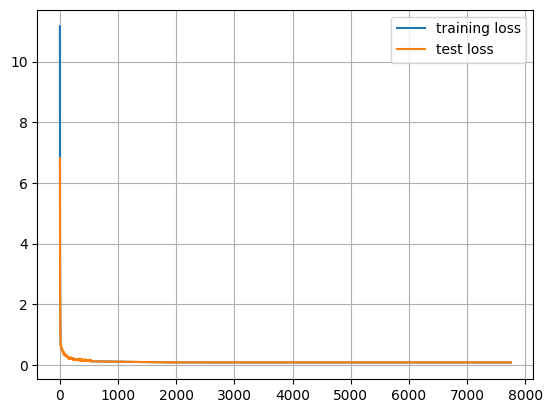

--------------------  EPOCH: 7750  --------------------
LOSS train 0.07827348125224211 valid 0.07918932288885117
--------------------  EPOCH: 7751  --------------------
LOSS train 0.07826619868984028 valid 0.0791887566447258
--------------------  EPOCH: 7752  --------------------
LOSS train 0.0782788386758493 valid 0.07918909937143326
--------------------  EPOCH: 7753  --------------------
LOSS train 0.07827545413557364 valid 0.07918976247310638
--------------------  EPOCH: 7754  --------------------
LOSS train 0.07828632118750592 valid 0.07918912172317505
--------------------  EPOCH: 7755  --------------------
LOSS train 0.07827994485898894 valid 0.07918964326381683
--------------------  EPOCH: 7756  --------------------
LOSS train 0.07829056664997218 valid 0.07918903976678848
--------------------  EPOCH: 7757  --------------------
LOSS train 0.07828153411344606 valid 0.07919023185968399
--------------------  EPOCH: 7758  --------------------
LOSS train 0.0782738990929662 valid 0.0791

LOSS train 0.07827325134861227 valid 0.07918864488601685
--------------------  EPOCH: 7824  --------------------
LOSS train 0.07827536807376512 valid 0.07918699085712433
--------------------  EPOCH: 7825  --------------------
LOSS train 0.07827729777413972 valid 0.07918737828731537
--------------------  EPOCH: 7826  --------------------
LOSS train 0.0782750448097988 valid 0.07918692380189896
--------------------  EPOCH: 7827  --------------------
LOSS train 0.07827899985167446 valid 0.07918697595596313
--------------------  EPOCH: 7828  --------------------
LOSS train 0.07826753584097842 valid 0.07918790727853775
--------------------  EPOCH: 7829  --------------------
LOSS train 0.07827699747012586 valid 0.0791875496506691
--------------------  EPOCH: 7830  --------------------
LOSS train 0.07827898130124929 valid 0.0791868269443512
--------------------  EPOCH: 7831  --------------------
LOSS train 0.07826720467027352 valid 0.07918766885995865
--------------------  EPOCH: 7832  -------

LOSS train 0.07827149194722273 valid 0.07918525487184525
--------------------  EPOCH: 7897  --------------------
LOSS train 0.07827470588440798 valid 0.07918555289506912
--------------------  EPOCH: 7898  --------------------
LOSS train 0.07827163578904404 valid 0.07918626815080643
--------------------  EPOCH: 7899  --------------------
LOSS train 0.07827844333891966 valid 0.07918590307235718
--------------------  EPOCH: 7900  --------------------
LOSS train 0.07827514744534785 valid 0.07918538898229599
--------------------  EPOCH: 7901  --------------------
LOSS train 0.07827050923084726 valid 0.07918564975261688
--------------------  EPOCH: 7902  --------------------
LOSS train 0.07827408733416577 valid 0.07918550819158554
--------------------  EPOCH: 7903  --------------------
LOSS train 0.07827992570035312 valid 0.07918681204319
--------------------  EPOCH: 7904  --------------------
LOSS train 0.0782737744097807 valid 0.0791853740811348
--------------------  EPOCH: 7905  ---------

LOSS train 0.07827492468819326 valid 0.07918351143598557
--------------------  EPOCH: 7970  --------------------
LOSS train 0.0782707794284334 valid 0.07918411493301392
--------------------  EPOCH: 7971  --------------------
LOSS train 0.07826513356092024 valid 0.07918419688940048
--------------------  EPOCH: 7972  --------------------
LOSS train 0.07827582514407683 valid 0.07918334752321243
--------------------  EPOCH: 7973  --------------------
LOSS train 0.07827781901067617 valid 0.07918354868888855
--------------------  EPOCH: 7974  --------------------
LOSS train 0.07826712986036223 valid 0.07918392866849899
--------------------  EPOCH: 7975  --------------------
LOSS train 0.07827449164220265 valid 0.07918359339237213
--------------------  EPOCH: 7976  --------------------
LOSS train 0.0782655699520695 valid 0.07918328791856766
--------------------  EPOCH: 7977  --------------------
LOSS train 0.07827288931121631 valid 0.07918321341276169
--------------------  EPOCH: 7978  ------

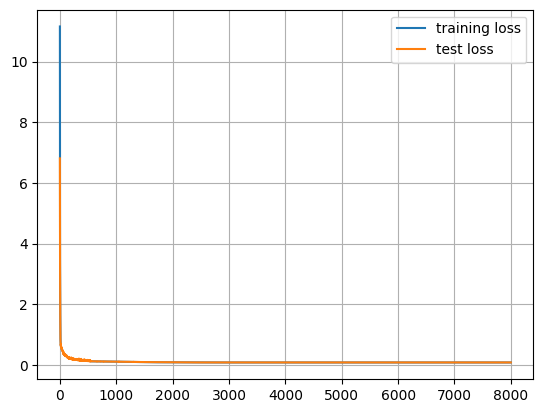

--------------------  EPOCH: 8000  --------------------
LOSS train 0.07827640446473141 valid 0.07918272167444229
--------------------  EPOCH: 8001  --------------------
LOSS train 0.07827005961111613 valid 0.07918300479650497
--------------------  EPOCH: 8002  --------------------
LOSS train 0.07827480699943036 valid 0.07918363064527512
--------------------  EPOCH: 8003  --------------------
LOSS train 0.07826232788514118 valid 0.0791826918721199
--------------------  EPOCH: 8004  --------------------
LOSS train 0.07826491308455565 valid 0.07918278872966766
--------------------  EPOCH: 8005  --------------------
LOSS train 0.07827018444635431 valid 0.07918287813663483
--------------------  EPOCH: 8006  --------------------
LOSS train 0.07826893928707862 valid 0.0791826918721199
--------------------  EPOCH: 8007  --------------------
LOSS train 0.07826860887663704 valid 0.07918291538953781
--------------------  EPOCH: 8008  --------------------
LOSS train 0.07827500497200052 valid 0.079

LOSS train 0.07827459169285637 valid 0.07918071001768112
--------------------  EPOCH: 8074  --------------------
LOSS train 0.07826677770638953 valid 0.0791812613606453
--------------------  EPOCH: 8075  --------------------
LOSS train 0.07826881931752575 valid 0.07918085902929306
--------------------  EPOCH: 8076  --------------------
LOSS train 0.07827024982900035 valid 0.07918120920658112
--------------------  EPOCH: 8077  --------------------
LOSS train 0.07826478855342281 valid 0.07918056845664978
--------------------  EPOCH: 8078  --------------------
LOSS train 0.07826998373683618 valid 0.07918108254671097
--------------------  EPOCH: 8079  --------------------
LOSS train 0.0782698348772769 valid 0.07918082177639008
--------------------  EPOCH: 8080  --------------------
LOSS train 0.07825990903134249 valid 0.07918062806129456
--------------------  EPOCH: 8081  --------------------
LOSS train 0.07827521298004657 valid 0.07918085902929306
--------------------  EPOCH: 8082  ------

LOSS train 0.0782648603222808 valid 0.0791790708899498
--------------------  EPOCH: 8147  --------------------
LOSS train 0.07826113700866699 valid 0.07917911559343338
--------------------  EPOCH: 8148  --------------------
LOSS train 0.07826375322682518 valid 0.07918079197406769
--------------------  EPOCH: 8149  --------------------
LOSS train 0.07827556406965061 valid 0.07917959243059158
--------------------  EPOCH: 8150  --------------------
LOSS train 0.07827242980806196 valid 0.07917898893356323
--------------------  EPOCH: 8151  --------------------
LOSS train 0.07827527501753398 valid 0.07917982339859009
--------------------  EPOCH: 8152  --------------------
LOSS train 0.07827756401835656 valid 0.07917886227369308
--------------------  EPOCH: 8153  --------------------
LOSS train 0.07826513371297292 valid 0.07917898148298264
--------------------  EPOCH: 8154  --------------------
LOSS train 0.07826616964778121 valid 0.07917965948581696
--------------------  EPOCH: 8155  ------

LOSS train 0.07826738834989314 valid 0.07917729020118713
--------------------  EPOCH: 8220  --------------------
LOSS train 0.07826678971855008 valid 0.07917764037847519
--------------------  EPOCH: 8221  --------------------
LOSS train 0.07826034937586103 valid 0.079177126288414
--------------------  EPOCH: 8222  --------------------
LOSS train 0.07827286194173658 valid 0.07917706668376923
--------------------  EPOCH: 8223  --------------------
LOSS train 0.07826155241654843 valid 0.07917667180299759
--------------------  EPOCH: 8224  --------------------
LOSS train 0.07826982164869503 valid 0.07917892187833786
--------------------  EPOCH: 8225  --------------------
LOSS train 0.07826778307861211 valid 0.0791771337389946
--------------------  EPOCH: 8226  --------------------
LOSS train 0.07826081131185804 valid 0.0791785717010498
--------------------  EPOCH: 8227  --------------------
LOSS train 0.07826711435099037 valid 0.07917913794517517
--------------------  EPOCH: 8228  --------

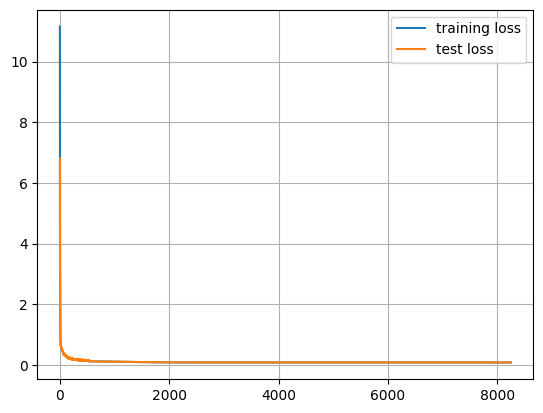

--------------------  EPOCH: 8250  --------------------
LOSS train 0.07826886128406135 valid 0.07917794585227966
--------------------  EPOCH: 8251  --------------------
LOSS train 0.07826688490351852 valid 0.07917681336402893
--------------------  EPOCH: 8252  --------------------
LOSS train 0.07825762504825787 valid 0.07917608320713043
--------------------  EPOCH: 8253  --------------------
LOSS train 0.07826740325105433 valid 0.07917741686105728
--------------------  EPOCH: 8254  --------------------
LOSS train 0.07827016756850846 valid 0.07917767763137817
--------------------  EPOCH: 8255  --------------------
LOSS train 0.0782593795839621 valid 0.07917788624763489
--------------------  EPOCH: 8256  --------------------
LOSS train 0.07827331885999562 valid 0.07917613536119461
--------------------  EPOCH: 8257  --------------------
LOSS train 0.07826950842020464 valid 0.0791764035820961
--------------------  EPOCH: 8258  --------------------
LOSS train 0.07826066610156274 valid 0.079

LOSS train 0.07826766538984921 valid 0.07917453348636627
--------------------  EPOCH: 8324  --------------------
LOSS train 0.07826552540063858 valid 0.0791744589805603
--------------------  EPOCH: 8325  --------------------
LOSS train 0.07826439169596652 valid 0.07917561382055283
--------------------  EPOCH: 8326  --------------------
LOSS train 0.07825506311290119 valid 0.07917412370443344
--------------------  EPOCH: 8327  --------------------
LOSS train 0.07827276325955683 valid 0.07917454093694687
--------------------  EPOCH: 8328  --------------------
LOSS train 0.07825912155058919 valid 0.07917557656764984
--------------------  EPOCH: 8329  --------------------
LOSS train 0.07825687193140692 valid 0.07917440682649612
--------------------  EPOCH: 8330  --------------------
LOSS train 0.07826632884692172 valid 0.0791783258318901
--------------------  EPOCH: 8331  --------------------
LOSS train 0.07825663518540714 valid 0.07917441427707672
--------------------  EPOCH: 8332  ------

LOSS train 0.07825512043675598 valid 0.07917369902133942
--------------------  EPOCH: 8397  --------------------
LOSS train 0.07826216260389406 valid 0.07917223870754242
--------------------  EPOCH: 8398  --------------------
LOSS train 0.07825696589995404 valid 0.07917267084121704
--------------------  EPOCH: 8399  --------------------
LOSS train 0.07827068698041294 valid 0.07917360216379166
--------------------  EPOCH: 8400  --------------------
LOSS train 0.07825941835739175 valid 0.07917272299528122
--------------------  EPOCH: 8401  --------------------
LOSS train 0.07825614344708774 valid 0.07917262613773346
--------------------  EPOCH: 8402  --------------------
LOSS train 0.07825575981821332 valid 0.07917315512895584
--------------------  EPOCH: 8403  --------------------
LOSS train 0.07827026473016155 valid 0.07917250692844391
--------------------  EPOCH: 8404  --------------------
LOSS train 0.07825964172275698 valid 0.0791727676987648
--------------------  EPOCH: 8405  -----

LOSS train 0.07826522646509872 valid 0.07917165011167526
--------------------  EPOCH: 8470  --------------------
LOSS train 0.07826125226458724 valid 0.07917115092277527
--------------------  EPOCH: 8471  --------------------
LOSS train 0.07825933442432054 valid 0.0791708454489708
--------------------  EPOCH: 8472  --------------------
LOSS train 0.07825643538820501 valid 0.0791708305478096
--------------------  EPOCH: 8473  --------------------
LOSS train 0.0782590922044248 valid 0.07917065173387527
--------------------  EPOCH: 8474  --------------------
LOSS train 0.07826045444425271 valid 0.07917089015245438
--------------------  EPOCH: 8475  --------------------
LOSS train 0.07826527968353154 valid 0.07917137444019318
--------------------  EPOCH: 8476  --------------------
LOSS train 0.07825797689812523 valid 0.07917048782110214
--------------------  EPOCH: 8477  --------------------
LOSS train 0.0782570137965436 valid 0.07917176187038422
--------------------  EPOCH: 8478  --------

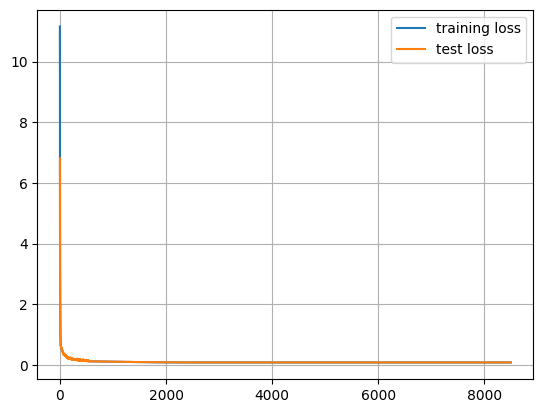

--------------------  EPOCH: 8500  --------------------
LOSS train 0.07825532433938007 valid 0.07916998118162155
--------------------  EPOCH: 8501  --------------------
LOSS train 0.07825737522572887 valid 0.07917144149541855
--------------------  EPOCH: 8502  --------------------
LOSS train 0.07825961480943525 valid 0.07917006313800812
--------------------  EPOCH: 8503  --------------------
LOSS train 0.0782502792319473 valid 0.07917135208845139
--------------------  EPOCH: 8504  --------------------
LOSS train 0.07825910178374271 valid 0.07917070388793945
--------------------  EPOCH: 8505  --------------------
LOSS train 0.07826450375878082 valid 0.07917077094316483
--------------------  EPOCH: 8506  --------------------
LOSS train 0.07826303371361323 valid 0.07917045801877975
--------------------  EPOCH: 8507  --------------------
LOSS train 0.0782591534816489 valid 0.07917164266109467
--------------------  EPOCH: 8508  --------------------
LOSS train 0.07826816427464388 valid 0.079

LOSS train 0.07825784506846448 valid 0.07916795462369919
--------------------  EPOCH: 8574  --------------------
LOSS train 0.07825489707139073 valid 0.07916802912950516
--------------------  EPOCH: 8575  --------------------
LOSS train 0.0782554173956112 valid 0.07916857302188873
--------------------  EPOCH: 8576  --------------------
LOSS train 0.07825228845586582 valid 0.07916866987943649
--------------------  EPOCH: 8577  --------------------
LOSS train 0.07824681608044372 valid 0.07916843146085739
--------------------  EPOCH: 8578  --------------------
LOSS train 0.07826422048466546 valid 0.07916862517595291
--------------------  EPOCH: 8579  --------------------
LOSS train 0.07825808850478153 valid 0.07916786521673203
--------------------  EPOCH: 8580  --------------------
LOSS train 0.07825165272367243 valid 0.0791689082980156
--------------------  EPOCH: 8581  --------------------
LOSS train 0.0782601465376056 valid 0.0791681781411171
--------------------  EPOCH: 8582  --------

LOSS train 0.0782616881995785 valid 0.07916636765003204
--------------------  EPOCH: 8647  --------------------
LOSS train 0.07825230852681764 valid 0.07916798442602158
--------------------  EPOCH: 8648  --------------------
LOSS train 0.0782521804984735 valid 0.07916640490293503
--------------------  EPOCH: 8649  --------------------
LOSS train 0.07825631572275746 valid 0.0791669636964798
--------------------  EPOCH: 8650  --------------------
LOSS train 0.07825569458761994 valid 0.07916643470525742
--------------------  EPOCH: 8651  --------------------
LOSS train 0.0782575680285084 valid 0.07916702330112457
--------------------  EPOCH: 8652  --------------------
LOSS train 0.07825780751145615 valid 0.07916653901338577
--------------------  EPOCH: 8653  --------------------
LOSS train 0.07824345313164653 valid 0.0791664868593216
--------------------  EPOCH: 8654  --------------------
LOSS train 0.07825119778209803 valid 0.07917070388793945
--------------------  EPOCH: 8655  ---------

LOSS train 0.07825266949984493 valid 0.07916465401649475
--------------------  EPOCH: 8720  --------------------
LOSS train 0.07825287522710099 valid 0.07916649430990219
--------------------  EPOCH: 8721  --------------------
LOSS train 0.07825903503262267 valid 0.07916437089443207
--------------------  EPOCH: 8722  --------------------
LOSS train 0.07825164648951316 valid 0.07916542887687683
--------------------  EPOCH: 8723  --------------------
LOSS train 0.07825006559795263 valid 0.07916442304849625
--------------------  EPOCH: 8724  --------------------
LOSS train 0.07824973245056308 valid 0.07916425913572311
--------------------  EPOCH: 8725  --------------------
LOSS train 0.07825595034020287 valid 0.07916434109210968
--------------------  EPOCH: 8726  --------------------
LOSS train 0.07825847654318323 valid 0.07916461676359177
--------------------  EPOCH: 8727  --------------------
LOSS train 0.07825400771535172 valid 0.07916392385959625
--------------------  EPOCH: 8728  ----

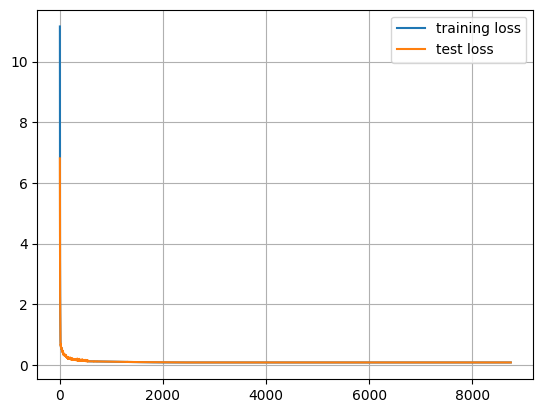

--------------------  EPOCH: 8750  --------------------
LOSS train 0.07825617917946406 valid 0.07916388660669327
--------------------  EPOCH: 8751  --------------------
LOSS train 0.07824732591303027 valid 0.07916442304849625
--------------------  EPOCH: 8752  --------------------
LOSS train 0.07825807922956896 valid 0.07916465401649475
--------------------  EPOCH: 8753  --------------------
LOSS train 0.07824418815423032 valid 0.07916360348463058
--------------------  EPOCH: 8754  --------------------
LOSS train 0.0782488578436326 valid 0.07916385680437088
--------------------  EPOCH: 8755  --------------------
LOSS train 0.07825592783640842 valid 0.07916412502527237
--------------------  EPOCH: 8756  --------------------
LOSS train 0.07825394856686495 valid 0.07916364818811417
--------------------  EPOCH: 8757  --------------------
LOSS train 0.07824999170035732 valid 0.0791642814874649
--------------------  EPOCH: 8758  --------------------
LOSS train 0.07825137978913832 valid 0.079

LOSS train 0.07825511435464937 valid 0.07916330546140671
--------------------  EPOCH: 8824  --------------------
LOSS train 0.07825181146665496 valid 0.0791618600487709
--------------------  EPOCH: 8825  --------------------
LOSS train 0.07824547011025097 valid 0.0791623666882515
--------------------  EPOCH: 8826  --------------------
LOSS train 0.07825045424456499 valid 0.07916317135095596
--------------------  EPOCH: 8827  --------------------
LOSS train 0.07824573148878253 valid 0.07916325330734253
--------------------  EPOCH: 8828  --------------------
LOSS train 0.07824437274616591 valid 0.07916274666786194
--------------------  EPOCH: 8829  --------------------
LOSS train 0.07825280011308436 valid 0.07916158437728882
--------------------  EPOCH: 8830  --------------------
LOSS train 0.0782522194239558 valid 0.07916241139173508
--------------------  EPOCH: 8831  --------------------
LOSS train 0.07824024816556853 valid 0.07916165888309479
--------------------  EPOCH: 8832  -------

LOSS train 0.07824848364202344 valid 0.07916039973497391
--------------------  EPOCH: 8897  --------------------
LOSS train 0.0782485061458179 valid 0.0791599452495575
--------------------  EPOCH: 8898  --------------------
LOSS train 0.07825250391449247 valid 0.07916052639484406
--------------------  EPOCH: 8899  --------------------
LOSS train 0.07825067487298226 valid 0.07916004210710526
--------------------  EPOCH: 8900  --------------------
LOSS train 0.07824885358615798 valid 0.07916007936000824
--------------------  EPOCH: 8901  --------------------
LOSS train 0.07824287153020197 valid 0.07916013896465302
--------------------  EPOCH: 8902  --------------------
LOSS train 0.07824821496496395 valid 0.07916022837162018
--------------------  EPOCH: 8903  --------------------
LOSS train 0.07825295201369695 valid 0.07916056364774704
--------------------  EPOCH: 8904  --------------------
LOSS train 0.07825371486191847 valid 0.07916027307510376
--------------------  EPOCH: 8905  ------

LOSS train 0.07824552621768445 valid 0.07915952801704407
--------------------  EPOCH: 8970  --------------------
LOSS train 0.07823389190800335 valid 0.07915852218866348
--------------------  EPOCH: 8971  --------------------
LOSS train 0.07824777842176203 valid 0.07915837317705154
--------------------  EPOCH: 8972  --------------------
LOSS train 0.07824794142221918 valid 0.0791582465171814
--------------------  EPOCH: 8973  --------------------
LOSS train 0.07824461511811431 valid 0.07915814220905304
--------------------  EPOCH: 8974  --------------------
LOSS train 0.07823666321988008 valid 0.07915829122066498
--------------------  EPOCH: 8975  --------------------
LOSS train 0.07824275429759707 valid 0.07915884256362915
--------------------  EPOCH: 8976  --------------------
LOSS train 0.07824979251136585 valid 0.07915888726711273
--------------------  EPOCH: 8977  --------------------
LOSS train 0.0782383981407905 valid 0.07915835827589035
--------------------  EPOCH: 8978  ------

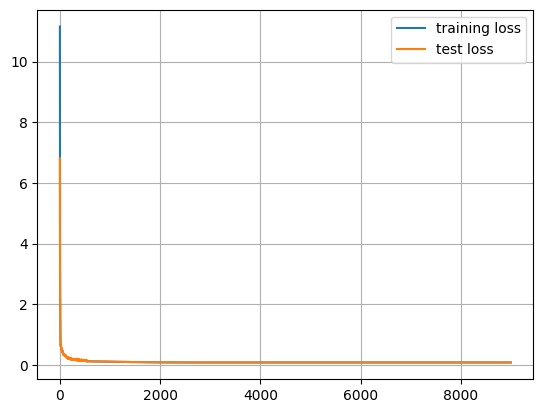

--------------------  EPOCH: 9000  --------------------
LOSS train 0.0782385635740903 valid 0.07915908843278885
--------------------  EPOCH: 9001  --------------------
LOSS train 0.07824519276618958 valid 0.07915795594453812
--------------------  EPOCH: 9002  --------------------
LOSS train 0.07823839890105384 valid 0.07915946841239929
--------------------  EPOCH: 9003  --------------------
LOSS train 0.07824914415880126 valid 0.07915741205215454
--------------------  EPOCH: 9004  --------------------
LOSS train 0.07824642393662005 valid 0.07915762066841125
--------------------  EPOCH: 9005  --------------------
LOSS train 0.07824956564878931 valid 0.07915740460157394
--------------------  EPOCH: 9006  --------------------
LOSS train 0.07823694755836409 valid 0.07915852963924408
--------------------  EPOCH: 9007  --------------------
LOSS train 0.07824952733151767 valid 0.07915833592414856
--------------------  EPOCH: 9008  --------------------
LOSS train 0.07823949748156023 valid 0.07

LOSS train 0.07825002211089037 valid 0.07915569841861725
--------------------  EPOCH: 9074  --------------------
LOSS train 0.07825972231066956 valid 0.07915553450584412
--------------------  EPOCH: 9075  --------------------
LOSS train 0.07824813407294605 valid 0.07915578037500381
--------------------  EPOCH: 9076  --------------------
LOSS train 0.07823764076646493 valid 0.07915571331977844
--------------------  EPOCH: 9077  --------------------
LOSS train 0.07824247147963971 valid 0.07915554940700531
--------------------  EPOCH: 9078  --------------------
LOSS train 0.07824925850240552 valid 0.0791560485959053
--------------------  EPOCH: 9079  --------------------
LOSS train 0.07824560011527976 valid 0.07916117459535599
--------------------  EPOCH: 9080  --------------------
LOSS train 0.07824395749033713 valid 0.0791555866599083
--------------------  EPOCH: 9081  --------------------
LOSS train 0.07825192383357457 valid 0.07915741205215454
--------------------  EPOCH: 9082  ------

LOSS train 0.07824808769688314 valid 0.07915428280830383
--------------------  EPOCH: 9147  --------------------
LOSS train 0.07824674887316567 valid 0.07915422320365906
--------------------  EPOCH: 9148  --------------------
LOSS train 0.07824814030710532 valid 0.07915385812520981
--------------------  EPOCH: 9149  --------------------
LOSS train 0.0782357501436253 valid 0.07915420085191727
--------------------  EPOCH: 9150  --------------------
LOSS train 0.07825111232850017 valid 0.07915456593036652
--------------------  EPOCH: 9151  --------------------
LOSS train 0.0782432559193397 valid 0.07915375381708145
--------------------  EPOCH: 9152  --------------------
LOSS train 0.07824074887499517 valid 0.07915379852056503
--------------------  EPOCH: 9153  --------------------
LOSS train 0.07824858992683645 valid 0.07915356755256653
--------------------  EPOCH: 9154  --------------------
LOSS train 0.07824386777926465 valid 0.0791536346077919
--------------------  EPOCH: 9155  -------

LOSS train 0.07824045936672056 valid 0.07915229350328445
--------------------  EPOCH: 9220  --------------------
LOSS train 0.07823772454748348 valid 0.07915253937244415
--------------------  EPOCH: 9221  --------------------
LOSS train 0.07824377974077147 valid 0.07915209233760834
--------------------  EPOCH: 9222  --------------------
LOSS train 0.07824841430600808 valid 0.07915221154689789
--------------------  EPOCH: 9223  --------------------
LOSS train 0.07823805161276642 valid 0.07915186136960983
--------------------  EPOCH: 9224  --------------------
LOSS train 0.07824886727089785 valid 0.07915178686380386
--------------------  EPOCH: 9225  --------------------
LOSS train 0.07824745911116503 valid 0.07915179431438446
--------------------  EPOCH: 9226  --------------------
LOSS train 0.07824060229622588 valid 0.07915160059928894
--------------------  EPOCH: 9227  --------------------
LOSS train 0.07822894076911771 valid 0.07915203273296356
--------------------  EPOCH: 9228  ----

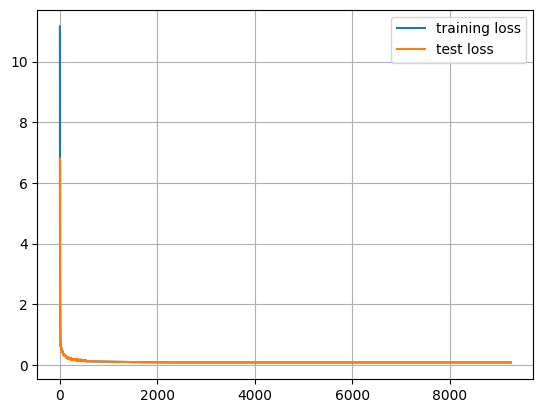

--------------------  EPOCH: 9250  --------------------
LOSS train 0.07823541684418309 valid 0.07915250211954117
--------------------  EPOCH: 9251  --------------------
LOSS train 0.07824257472339942 valid 0.07915084064006805
--------------------  EPOCH: 9252  --------------------
LOSS train 0.07824332890461902 valid 0.07915456593036652
--------------------  EPOCH: 9253  --------------------
LOSS train 0.07825420021402593 valid 0.07915142923593521
--------------------  EPOCH: 9254  --------------------
LOSS train 0.0782439077691156 valid 0.07915112376213074
--------------------  EPOCH: 9255  --------------------
LOSS train 0.07823875333581652 valid 0.07915118336677551
--------------------  EPOCH: 9256  --------------------
LOSS train 0.07823701613411611 valid 0.07915093004703522
--------------------  EPOCH: 9257  --------------------
LOSS train 0.0782448225179497 valid 0.07915116101503372
--------------------  EPOCH: 9258  --------------------
LOSS train 0.07823205313512258 valid 0.079

LOSS train 0.07823993584939412 valid 0.07914963364601135
--------------------  EPOCH: 9324  --------------------
LOSS train 0.07823671628626025 valid 0.07914957404136658
--------------------  EPOCH: 9325  --------------------
LOSS train 0.0782352054909784 valid 0.07914894819259644
--------------------  EPOCH: 9326  --------------------
LOSS train 0.07823859580925532 valid 0.07914949953556061
--------------------  EPOCH: 9327  --------------------
LOSS train 0.07823790792299777 valid 0.07914981245994568
--------------------  EPOCH: 9328  --------------------
LOSS train 0.07824945875576564 valid 0.07914982736110687
--------------------  EPOCH: 9329  --------------------
LOSS train 0.0782500329066296 valid 0.07914923131465912
--------------------  EPOCH: 9330  --------------------
LOSS train 0.0782341646904848 valid 0.07914918661117554
--------------------  EPOCH: 9331  --------------------
LOSS train 0.07823436144663364 valid 0.0791497454047203
--------------------  EPOCH: 9332  --------

LOSS train 0.07823760655461526 valid 0.07914768904447556
--------------------  EPOCH: 9397  --------------------
LOSS train 0.078235745734098 valid 0.0791480615735054
--------------------  EPOCH: 9398  --------------------
LOSS train 0.07823595206956474 valid 0.07914764434099197
--------------------  EPOCH: 9399  --------------------
LOSS train 0.07823383063077927 valid 0.07914724946022034
--------------------  EPOCH: 9400  --------------------
LOSS train 0.07823570832914235 valid 0.0791478306055069
--------------------  EPOCH: 9401  --------------------
LOSS train 0.07823962201269305 valid 0.07914814352989197
--------------------  EPOCH: 9402  --------------------
LOSS train 0.07822856778392986 valid 0.07914818078279495
--------------------  EPOCH: 9403  --------------------
LOSS train 0.07822963352106055 valid 0.07914747297763824
--------------------  EPOCH: 9404  --------------------
LOSS train 0.07824356443419749 valid 0.07914692908525467
--------------------  EPOCH: 9405  --------

LOSS train 0.0782315262726375 valid 0.07914751768112183
--------------------  EPOCH: 9470  --------------------
LOSS train 0.07824926306398547 valid 0.07914712280035019
--------------------  EPOCH: 9471  --------------------
LOSS train 0.07823742713247027 valid 0.07914597541093826
--------------------  EPOCH: 9472  --------------------
LOSS train 0.07824644932941514 valid 0.07914678752422333
--------------------  EPOCH: 9473  --------------------
LOSS train 0.0782266374753446 valid 0.07914572209119797
--------------------  EPOCH: 9474  --------------------
LOSS train 0.07824049601141288 valid 0.07914531975984573
--------------------  EPOCH: 9475  --------------------
LOSS train 0.07822982769231407 valid 0.07914517819881439
--------------------  EPOCH: 9476  --------------------
LOSS train 0.07823753448165192 valid 0.07914575934410095
--------------------  EPOCH: 9477  --------------------
LOSS train 0.07823552495362807 valid 0.07914582639932632
--------------------  EPOCH: 9478  ------

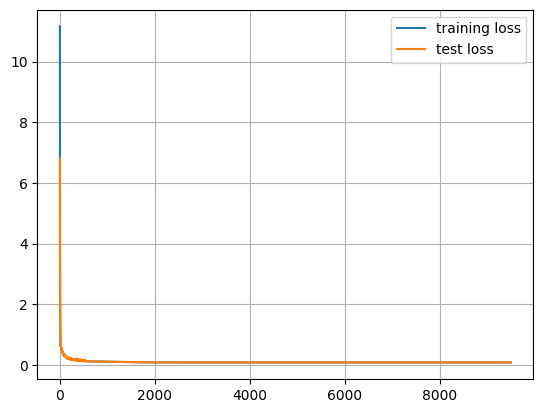

--------------------  EPOCH: 9500  --------------------
LOSS train 0.07823565602302551 valid 0.0791451707482338
--------------------  EPOCH: 9501  --------------------
LOSS train 0.07823065683549764 valid 0.07914482802152634
--------------------  EPOCH: 9502  --------------------
LOSS train 0.07824254841828833 valid 0.07914518564939499
--------------------  EPOCH: 9503  --------------------
LOSS train 0.07822876834139532 valid 0.0791454166173935
--------------------  EPOCH: 9504  --------------------
LOSS train 0.07824300320781007 valid 0.07914534956216812
--------------------  EPOCH: 9505  --------------------
LOSS train 0.0782301726998115 valid 0.07914639264345169
--------------------  EPOCH: 9506  --------------------
LOSS train 0.07821839105109779 valid 0.07914476841688156
--------------------  EPOCH: 9507  --------------------
LOSS train 0.07823550047314896 valid 0.07914622873067856
--------------------  EPOCH: 9508  --------------------
LOSS train 0.07823193529430701 valid 0.0791

LOSS train 0.07823306504560977 valid 0.07914572954177856
--------------------  EPOCH: 9574  --------------------
LOSS train 0.07822748106353138 valid 0.07914294302463531
--------------------  EPOCH: 9575  --------------------
LOSS train 0.07822982373894477 valid 0.0791444331407547
--------------------  EPOCH: 9576  --------------------
LOSS train 0.07824602114910982 valid 0.07914341241121292
--------------------  EPOCH: 9577  --------------------
LOSS train 0.07823260143703344 valid 0.07914334535598755
--------------------  EPOCH: 9578  --------------------
LOSS train 0.07823383063077927 valid 0.07914289832115173
--------------------  EPOCH: 9579  --------------------
LOSS train 0.07823893823185746 valid 0.07914291322231293
--------------------  EPOCH: 9580  --------------------
LOSS train 0.07823179145248568 valid 0.0791432335972786
--------------------  EPOCH: 9581  --------------------
LOSS train 0.07823213630793047 valid 0.07914341986179352
--------------------  EPOCH: 9582  ------

LOSS train 0.07823487918595878 valid 0.07914319634437561
--------------------  EPOCH: 9647  --------------------
LOSS train 0.07822958592857633 valid 0.07914150506258011
--------------------  EPOCH: 9648  --------------------
LOSS train 0.07823004999331065 valid 0.07914170622825623
--------------------  EPOCH: 9649  --------------------
LOSS train 0.07823611218102124 valid 0.07914112508296967
--------------------  EPOCH: 9650  --------------------
LOSS train 0.07822224604231971 valid 0.07914093136787415
--------------------  EPOCH: 9651  --------------------
LOSS train 0.07822781314655226 valid 0.07914146035909653
--------------------  EPOCH: 9652  --------------------
LOSS train 0.07823313058030848 valid 0.07914114743471146
--------------------  EPOCH: 9653  --------------------
LOSS train 0.07823805267713507 valid 0.0791412815451622
--------------------  EPOCH: 9654  --------------------
LOSS train 0.07823704015843723 valid 0.07914093136787415
--------------------  EPOCH: 9655  -----

LOSS train 0.07823216382946287 valid 0.07914000749588013
--------------------  EPOCH: 9720  --------------------
LOSS train 0.07822906697282986 valid 0.07913948595523834
--------------------  EPOCH: 9721  --------------------
LOSS train 0.07822708268554843 valid 0.07913923263549805
--------------------  EPOCH: 9722  --------------------
LOSS train 0.0782294395018597 valid 0.0791415348649025
--------------------  EPOCH: 9723  --------------------
LOSS train 0.07822344619400647 valid 0.07913937419652939
--------------------  EPOCH: 9724  --------------------
LOSS train 0.0782333142599281 valid 0.07913978397846222
--------------------  EPOCH: 9725  --------------------
LOSS train 0.07823026894914861 valid 0.07914035022258759
--------------------  EPOCH: 9726  --------------------
LOSS train 0.07824006068463228 valid 0.07913878560066223
--------------------  EPOCH: 9727  --------------------
LOSS train 0.07822204350816961 valid 0.07913967967033386
--------------------  EPOCH: 9728  -------

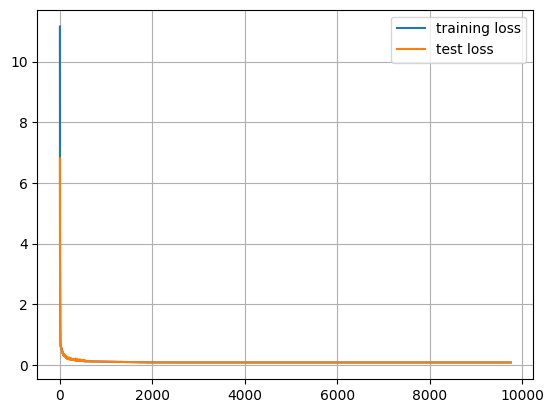

--------------------  EPOCH: 9750  --------------------
LOSS train 0.07823283666250658 valid 0.07913866639137268
--------------------  EPOCH: 9751  --------------------
LOSS train 0.07822177559137344 valid 0.07913971692323685
--------------------  EPOCH: 9752  --------------------
LOSS train 0.07822879038903179 valid 0.07913899421691895
--------------------  EPOCH: 9753  --------------------
LOSS train 0.0782287981437177 valid 0.07913859933614731
--------------------  EPOCH: 9754  --------------------
LOSS train 0.0782231358545167 valid 0.07913896441459656
--------------------  EPOCH: 9755  --------------------
LOSS train 0.07821676256705304 valid 0.07913997769355774
--------------------  EPOCH: 9756  --------------------
LOSS train 0.0782303442152179 valid 0.07913843542337418
--------------------  EPOCH: 9757  --------------------
LOSS train 0.0782285860302497 valid 0.07913848757743835
--------------------  EPOCH: 9758  --------------------
LOSS train 0.07823552951520803 valid 0.07913

LOSS train 0.07822353088734102 valid 0.07913654297590256
--------------------  EPOCH: 9824  --------------------
LOSS train 0.07822200230189733 valid 0.07913636416196823
--------------------  EPOCH: 9825  --------------------
LOSS train 0.07822835141298723 valid 0.07913707196712494
--------------------  EPOCH: 9826  --------------------
LOSS train 0.07822439895600689 valid 0.07913660258054733
--------------------  EPOCH: 9827  --------------------
LOSS train 0.07822702399321965 valid 0.07913805544376373
--------------------  EPOCH: 9828  --------------------
LOSS train 0.0782249506030764 valid 0.07913742959499359
--------------------  EPOCH: 9829  --------------------
LOSS train 0.07822445460728236 valid 0.07913818210363388
--------------------  EPOCH: 9830  --------------------
LOSS train 0.0782262210030945 valid 0.07913660258054733
--------------------  EPOCH: 9831  --------------------
LOSS train 0.07821627113283897 valid 0.07913653552532196
--------------------  EPOCH: 9832  ------

LOSS train 0.07822025187161503 valid 0.07913491129875183
--------------------  EPOCH: 9897  --------------------
LOSS train 0.07821622354035475 valid 0.0791342630982399
--------------------  EPOCH: 9898  --------------------
LOSS train 0.07821610645980251 valid 0.07913481444120407
--------------------  EPOCH: 9899  --------------------
LOSS train 0.0782252563809862 valid 0.07913535088300705
--------------------  EPOCH: 9900  --------------------
LOSS train 0.07822171446620202 valid 0.07913461327552795
--------------------  EPOCH: 9901  --------------------
LOSS train 0.07821867250058116 valid 0.07913432270288467
--------------------  EPOCH: 9902  --------------------
LOSS train 0.07822487822600774 valid 0.0791344866156578
--------------------  EPOCH: 9903  --------------------
LOSS train 0.0782385990023613 valid 0.07913487404584885
--------------------  EPOCH: 9904  --------------------
LOSS train 0.07822169013777558 valid 0.07913472503423691
--------------------  EPOCH: 9905  --------

LOSS train 0.07822106656979541 valid 0.0791332945227623
--------------------  EPOCH: 9970  --------------------
LOSS train 0.07822059931195512 valid 0.07913319766521454
--------------------  EPOCH: 9971  --------------------
LOSS train 0.07822372718733184 valid 0.07913308590650558
--------------------  EPOCH: 9972  --------------------
LOSS train 0.07821548973419229 valid 0.07913265377283096
--------------------  EPOCH: 9973  --------------------
LOSS train 0.07821875095975642 valid 0.07913289964199066
--------------------  EPOCH: 9974  --------------------
LOSS train 0.07822319165784486 valid 0.07913320511579514
--------------------  EPOCH: 9975  --------------------
LOSS train 0.07821947199349501 valid 0.079132579267025
--------------------  EPOCH: 9976  --------------------
LOSS train 0.07822443377606723 valid 0.07913309335708618
--------------------  EPOCH: 9977  --------------------
LOSS train 0.07821877893744683 valid 0.07913275063037872
--------------------  EPOCH: 9978  -------

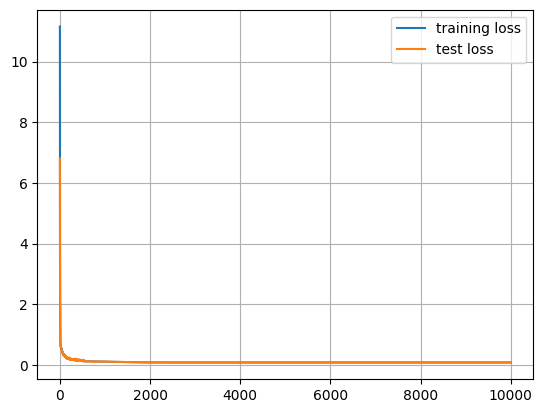

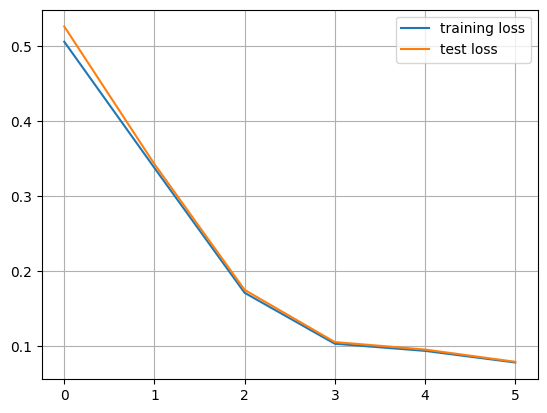

data_size: 400000
--------------------  EPOCH: 0  --------------------
LOSS train 7.9177963441731976 valid 4.174170017242432
--------------------  EPOCH: 1  --------------------
LOSS train 3.4067161642775243 valid 2.7151410579681396
--------------------  EPOCH: 2  --------------------
LOSS train 2.3599900956056556 valid 2.0658771991729736
--------------------  EPOCH: 3  --------------------
LOSS train 1.7231848580496651 valid 1.3322125673294067
--------------------  EPOCH: 4  --------------------
LOSS train 0.9806332801069532 valid 0.8081691265106201
--------------------  EPOCH: 5  --------------------
LOSS train 0.7860306787247561 valid 0.7559594511985779
--------------------  EPOCH: 6  --------------------
LOSS train 0.7482318732203269 valid 0.731036365032196
--------------------  EPOCH: 7  --------------------
LOSS train 0.7240410739061783 valid 0.716376543045044
--------------------  EPOCH: 8  --------------------
LOSS train 0.7080568166411653 valid 0.7199798226356506
-------------

LOSS train 0.18489870535475866 valid 0.18351981043815613
--------------------  EPOCH: 75  --------------------
LOSS train 0.186530950270137 valid 0.2123478651046753
--------------------  EPOCH: 76  --------------------
LOSS train 0.18437639563059322 valid 0.20446254312992096
--------------------  EPOCH: 77  --------------------
LOSS train 0.1893454595487945 valid 0.18091993033885956
--------------------  EPOCH: 78  --------------------
LOSS train 0.181957197584668 valid 0.17748667299747467
--------------------  EPOCH: 79  --------------------
LOSS train 0.18417170522164325 valid 0.1796194165945053
--------------------  EPOCH: 80  --------------------
LOSS train 0.1857793109149349 valid 0.17434601485729218
--------------------  EPOCH: 81  --------------------
LOSS train 0.18677383068264747 valid 0.17342177033424377
--------------------  EPOCH: 82  --------------------
LOSS train 0.1816857998468438 valid 0.17378360033035278
--------------------  EPOCH: 83  --------------------
LOSS train

LOSS train 0.1486707750935944 valid 0.14491601288318634
--------------------  EPOCH: 149  --------------------
LOSS train 0.14860352797775853 valid 0.13987453281879425
--------------------  EPOCH: 150  --------------------
LOSS train 0.14454965050123175 valid 0.14417308568954468
--------------------  EPOCH: 151  --------------------
LOSS train 0.1471556034319255 valid 0.13740231096744537
--------------------  EPOCH: 152  --------------------
LOSS train 0.14753265040261404 valid 0.13645842671394348
--------------------  EPOCH: 153  --------------------
LOSS train 0.14640359367643083 valid 0.13994744420051575
--------------------  EPOCH: 154  --------------------
LOSS train 0.14561851094571912 valid 0.14597733318805695
--------------------  EPOCH: 155  --------------------
LOSS train 0.1433739960193634 valid 0.13551627099514008
--------------------  EPOCH: 156  --------------------
LOSS train 0.14489160949478344 valid 0.15903128683567047
--------------------  EPOCH: 157  ----------------

KeyboardInterrupt: 

In [17]:
num_epoch = 1500
# Initialize the model, loss function, and optimizer with 4 layers
input_size = 9
hidden_size1 = 40
hidden_size2 = 40
hidden_size3 = 40
hidden_size4 = 40
output_size = 1
leaky_slope = 0.01
initial_lr = 1e-3

log = {'datasize': [], 
                    'training_MAE': [], 
                    'test_MAE': []
                   }

for data_size in [10000, 20000, 40000, 80000, 100000, 200000, 400000, 800000, 1000000, 1200000, 1400000, 1800000]:
    print("data_size:", data_size)
    early_stopper = EarlyStopper(patience=50, min_delta=1e-4)

    #Construct training set
    tmp_tr = tmp_train.sample(data_size).copy()
    tr = TmpDataset(x = tmp_tr[features].values,
                    y = tmp_tr[label].values)
    train_dataloader = DataLoader(tr, 
                                  batch_size=bs, 
                                  shuffle=True)


    avg_losses = []
    avg_vlosses = []


    model = OptionPricingModel(input_size, 
                       hidden_size1, 
                       hidden_size2, 
                       hidden_size3, 
                       output_size, 
                       leaky_slope).to(device)

    loss_fn = nn.L1Loss()  # You can experiment with other loss functions like nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience=20, min_lr=1e-7, verbose=True)

    for epoch in range(num_epoch):
        print("--------------------  EPOCH:", epoch, " --------------------")
        avg_loss, avg_vloss = train_one_epoch(train_dataloader, 
                                              test_dataloader, 
                                              epoch, 
                                              device,
                                              model,
                                              optimizer,
                                              loss_fn,
                                              scheduler)
        avg_losses.append(avg_loss)
        avg_vlosses.append(avg_vloss)

        if epoch % 250 == 249:
            plt.plot(avg_losses, label='training loss')
            plt.plot(avg_vlosses, label='test loss')
            plt.legend()
            plt.grid()
            plt.show()

        if early_stopper.early_stop(avg_vlosses[-1]):
            print("----- EARLY STOPPING TRIGGERED -----")
            break
    log['datasize'].append(data_size)
    log['training_MAE'].append(np.min(avg_losses))
    log['test_MAE'].append(np.min(avg_vlosses))
    
    plt.plot(log['training_MAE'], label='training loss')
    plt.plot(log['test_MAE'], label='test loss')
    plt.legend()
    plt.grid()
    plt.show()

In [23]:
# import pickle

# with open('tmp_save2.pkl', 'wb') as f:
#     pickle.dump(log, f)

In [21]:
tmp_train

T         r         q        v0     theta     kappa     sigma  \
0        0.967377  0.056513  0.024845  0.064385  0.254966  1.501569  0.523559   
1        0.863669  0.047413  0.021036  0.029750  0.384443  2.555275  0.874321   
2        0.266642  0.027938  0.012161  0.343404  0.077882  1.954023  0.035320   
3        0.985549  0.040352  0.015037  0.128845  0.181342  1.708042  0.554061   
4        0.198229  0.044727  0.028024  0.206895  0.262811  0.950664  0.266169   
...           ...       ...       ...       ...       ...       ...       ...   
1345490  0.370366  0.017227  0.016165  0.257367  0.205315  3.334536  0.699779   
1345491  0.460316  0.053303  0.010525  0.350610  0.184747  2.272910  0.609151   
1345492  0.742432  0.011470  0.022865  0.206923  0.257889  2.704046  0.997496   
1345493  0.134882  0.048310  0.025744  0.270200  0.342133  4.146570  0.436437   
1345494  0.178018  0.026574  0.015416  0.116475  0.230028  4.809555  0.293097   

              rho         m  option_price  
0       -0.102877  0.975474     17.030778  
1       -0.402464  1.034082     16.565026  
2       -0.553336  0.965772     12.722473  
3       -0.561965  0.988732     16.286708  
4        0.314611  0.931368     11.836154  
...           ...       ...           ...  
1345490 -0.635213  1.076489      8.067413  
1345491  0.495006  1.084239     12.070120  
1345492 -0.539744  0.971011     16.321806  
1345493 -0.481358  1.055879      5.544584  
1345494  0.807814  0.959759      8.637332  

[1345495 rows x 10 columns]

data_size: 400000
--------------------  EPOCH: 0  --------------------
LOSS train 8.280306237084526 valid 4.268718719482422
--------------------  EPOCH: 1  --------------------
LOSS train 3.6664908078252054 valid 3.0325984954833984
--------------------  EPOCH: 2  --------------------
LOSS train 2.558362678605683 valid 2.2800889015197754
--------------------  EPOCH: 3  --------------------
LOSS train 1.9781200301890471 valid 1.5572234392166138
--------------------  EPOCH: 4  --------------------
LOSS train 1.1757017179411284 valid 0.9650552868843079
--------------------  EPOCH: 5  --------------------
LOSS train 0.8716151653503885 valid 0.7931244969367981
--------------------  EPOCH: 6  --------------------
LOSS train 0.7537662107117322 valid 0.7155262231826782
--------------------  EPOCH: 7  --------------------
LOSS train 0.6913423215856358 valid 0.6591413021087646
--------------------  EPOCH: 8  --------------------
LOSS train 0.6437658047189518 valid 0.6290605664253235
-------------

LOSS train 0.19897729705791084 valid 0.18923448026180267
--------------------  EPOCH: 76  --------------------
LOSS train 0.19795652433317534 valid 0.20004814863204956
--------------------  EPOCH: 77  --------------------
LOSS train 0.19606764751429462 valid 0.18617767095565796
--------------------  EPOCH: 78  --------------------
LOSS train 0.19857741831516734 valid 0.18879817426204681
--------------------  EPOCH: 79  --------------------
LOSS train 0.19542620026943636 valid 0.20602311193943024
--------------------  EPOCH: 80  --------------------
LOSS train 0.19738974118111086 valid 0.20074765384197235
--------------------  EPOCH: 81  --------------------
LOSS train 0.19354374220176618 valid 0.20188294351100922
--------------------  EPOCH: 82  --------------------
LOSS train 0.19342722530875886 valid 0.18645046651363373
--------------------  EPOCH: 83  --------------------
LOSS train 0.19196186533996037 valid 0.18182256817817688
--------------------  EPOCH: 84  --------------------
L

LOSS train 0.15607933319953024 valid 0.15807321667671204
--------------------  EPOCH: 150  --------------------
LOSS train 0.15744817439390688 valid 0.18972793221473694
--------------------  EPOCH: 151  --------------------
LOSS train 0.15805246011943233 valid 0.1540694683790207
--------------------  EPOCH: 152  --------------------
LOSS train 0.1513947651398425 valid 0.14235739409923553
--------------------  EPOCH: 153  --------------------
LOSS train 0.15754800837258903 valid 0.19369728863239288
--------------------  EPOCH: 154  --------------------
LOSS train 0.15370464613851237 valid 0.17558547854423523
--------------------  EPOCH: 155  --------------------
LOSS train 0.15406221501073059 valid 0.1551162153482437
--------------------  EPOCH: 156  --------------------
LOSS train 0.1525638836378954 valid 0.14050182700157166
--------------------  EPOCH: 157  --------------------
LOSS train 0.15190233852790327 valid 0.17073136568069458
--------------------  EPOCH: 158  -----------------

LOSS train 0.12143052536614087 valid 0.1251761019229889
--------------------  EPOCH: 224  --------------------
LOSS train 0.12186940972294126 valid 0.10566805303096771
--------------------  EPOCH: 225  --------------------
LOSS train 0.1224351766310176 valid 0.10832443833351135
--------------------  EPOCH: 226  --------------------
LOSS train 0.12276774561222718 valid 0.10983898490667343
--------------------  EPOCH: 227  --------------------
LOSS train 0.12016138746118059 valid 0.10517522692680359
--------------------  EPOCH: 228  --------------------
LOSS train 0.12043851020993018 valid 0.12088292837142944
--------------------  EPOCH: 229  --------------------
LOSS train 0.12194080856077526 valid 0.133771151304245
--------------------  EPOCH: 230  --------------------
LOSS train 0.11933348191027739 valid 0.1146407350897789
--------------------  EPOCH: 231  --------------------
LOSS train 0.11964872623888814 valid 0.13296179473400116
--------------------  EPOCH: 232  ------------------

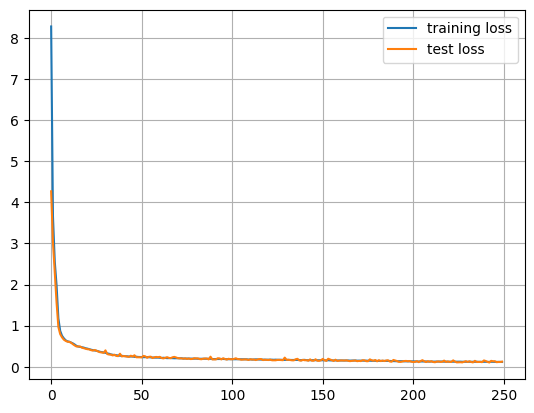

--------------------  EPOCH: 250  --------------------
LOSS train 0.11835255732341689 valid 0.12326250970363617
--------------------  EPOCH: 251  --------------------
LOSS train 0.11560633360427253 valid 0.12092602252960205
--------------------  EPOCH: 252  --------------------
LOSS train 0.11571974976330388 valid 0.10510998219251633
--------------------  EPOCH: 253  --------------------
LOSS train 0.11738414659487958 valid 0.11230644583702087
--------------------  EPOCH: 254  --------------------
LOSS train 0.11602461839817008 valid 0.10606782138347626
--------------------  EPOCH: 255  --------------------
LOSS train 0.11814944788205381 valid 0.13200902938842773
--------------------  EPOCH: 256  --------------------
LOSS train 0.11395520412800264 valid 0.1227710023522377
--------------------  EPOCH: 257  --------------------
LOSS train 0.11680311435947613 valid 0.106669582426548
--------------------  EPOCH: 258  --------------------
LOSS train 0.11494714857972398 valid 0.1134361699223

LOSS train 0.10460600682667323 valid 0.09398885071277618
--------------------  EPOCH: 324  --------------------
LOSS train 0.10512759977457475 valid 0.0964217558503151
--------------------  EPOCH: 325  --------------------
LOSS train 0.10501024256251296 valid 0.12693923711776733
--------------------  EPOCH: 326  --------------------
LOSS train 0.10668472497134793 valid 0.09397143125534058
--------------------  EPOCH: 327  --------------------
LOSS train 0.1039707966300906 valid 0.11031291633844376
--------------------  EPOCH: 328  --------------------
LOSS train 0.10436181800097835 valid 0.10093624889850616
--------------------  EPOCH: 329  --------------------
LOSS train 0.10399598909579978 valid 0.11976698040962219
--------------------  EPOCH: 330  --------------------
LOSS train 0.10254494169232797 valid 0.11817803233861923
--------------------  EPOCH: 331  --------------------
LOSS train 0.10400999428666367 valid 0.10065510869026184
--------------------  EPOCH: 332  ---------------

LOSS train 0.07870397899223834 valid 0.07936189323663712
--------------------  EPOCH: 397  --------------------
LOSS train 0.07868993343139181 valid 0.07931708544492722
--------------------  EPOCH: 398  --------------------
LOSS train 0.07865830723728452 valid 0.0792790874838829
--------------------  EPOCH: 399  --------------------
LOSS train 0.07863204675365468 valid 0.07935769110918045
--------------------  EPOCH: 400  --------------------
LOSS train 0.07857571876778895 valid 0.0792343020439148
--------------------  EPOCH: 401  --------------------
LOSS train 0.07861029607604961 valid 0.07922940701246262
--------------------  EPOCH: 402  --------------------
LOSS train 0.07855393258588654 valid 0.07924859970808029
--------------------  EPOCH: 403  --------------------
LOSS train 0.07856374606490135 valid 0.07934338599443436
--------------------  EPOCH: 404  --------------------
LOSS train 0.078482202425295 valid 0.07915744930505753
--------------------  EPOCH: 405  -----------------

LOSS train 0.0760604778722841 valid 0.07638025283813477
--------------------  EPOCH: 471  --------------------
LOSS train 0.07591484813969962 valid 0.07722160965204239
--------------------  EPOCH: 472  --------------------
LOSS train 0.0760855147120904 valid 0.07684839516878128
--------------------  EPOCH: 473  --------------------
LOSS train 0.07674336532244877 valid 0.07638330012559891
--------------------  EPOCH: 474  --------------------
LOSS train 0.07583585221852575 valid 0.07616855949163437
--------------------  EPOCH: 475  --------------------
LOSS train 0.07590746096506411 valid 0.07626987993717194
--------------------  EPOCH: 476  --------------------
LOSS train 0.0758703171598668 valid 0.07604824751615524
--------------------  EPOCH: 477  --------------------
LOSS train 0.07584715436915962 valid 0.07621941715478897
--------------------  EPOCH: 478  --------------------
LOSS train 0.07579146029085529 valid 0.07771315425634384
--------------------  EPOCH: 479  ----------------

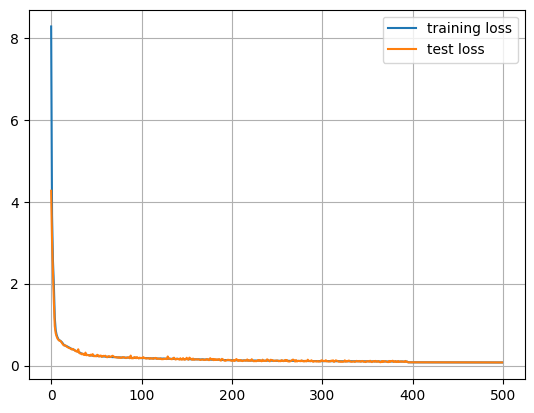

--------------------  EPOCH: 500  --------------------
LOSS train 0.07519056473155411 valid 0.07557972520589828
--------------------  EPOCH: 501  --------------------
LOSS train 0.07503123368535723 valid 0.0752757266163826
--------------------  EPOCH: 502  --------------------
LOSS train 0.0748983663411773 valid 0.07534633576869965
--------------------  EPOCH: 503  --------------------
LOSS train 0.07495836312977636 valid 0.07549089193344116
--------------------  EPOCH: 504  --------------------
LOSS train 0.07493491356774253 valid 0.07517535984516144
--------------------  EPOCH: 505  --------------------
LOSS train 0.0748288747759498 valid 0.07529476284980774
--------------------  EPOCH: 506  --------------------
LOSS train 0.07517815708201758 valid 0.07643496245145798
--------------------  EPOCH: 507  --------------------
LOSS train 0.07487034356715727 valid 0.07648072391748428
--------------------  EPOCH: 508  --------------------
LOSS train 0.0746818084497841 valid 0.07533457130193

LOSS train 0.07293878047137844 valid 0.07317238301038742
--------------------  EPOCH: 574  --------------------
LOSS train 0.07279253606589473 valid 0.0742650106549263
--------------------  EPOCH: 575  --------------------
LOSS train 0.07296777645848235 valid 0.07356340438127518
--------------------  EPOCH: 576  --------------------
LOSS train 0.07271163614124668 valid 0.07537148892879486
--------------------  EPOCH: 577  --------------------
LOSS train 0.07328972859042031 valid 0.0731869637966156
--------------------  EPOCH: 578  --------------------
LOSS train 0.0729308583754666 valid 0.07333754003047943
--------------------  EPOCH: 579  --------------------
LOSS train 0.07287920813779442 valid 0.07345261424779892
--------------------  EPOCH: 580  --------------------
LOSS train 0.07272938760567685 valid 0.07293734699487686
--------------------  EPOCH: 581  --------------------
LOSS train 0.07255145800965172 valid 0.07386023551225662
--------------------  EPOCH: 582  ----------------

LOSS train 0.07112970590895536 valid 0.07145646214485168
--------------------  EPOCH: 648  --------------------
LOSS train 0.07116731423504498 valid 0.07226371020078659
--------------------  EPOCH: 649  --------------------
LOSS train 0.07140901091755653 valid 0.07188770174980164
--------------------  EPOCH: 650  --------------------
LOSS train 0.07128401062622362 valid 0.07164040207862854
--------------------  EPOCH: 651  --------------------
LOSS train 0.07098132037386602 valid 0.0714605450630188
--------------------  EPOCH: 652  --------------------
LOSS train 0.07116580784929041 valid 0.07184302061796188
--------------------  EPOCH: 653  --------------------
LOSS train 0.07152595720729049 valid 0.0729430690407753
--------------------  EPOCH: 654  --------------------
LOSS train 0.0711043079440691 valid 0.07138779759407043
--------------------  EPOCH: 655  --------------------
LOSS train 0.07127133293115363 valid 0.07187487930059433
--------------------  EPOCH: 656  ----------------

LOSS train 0.07031413449012504 valid 0.07145076990127563
--------------------  EPOCH: 722  --------------------
LOSS train 0.06996727780419953 valid 0.07066396623849869
--------------------  EPOCH: 723  --------------------
LOSS train 0.06996145585970003 valid 0.07074467092752457
--------------------  EPOCH: 724  --------------------
LOSS train 0.06995271815329182 valid 0.07019384950399399
--------------------  EPOCH: 725  --------------------
LOSS train 0.06965716418867209 valid 0.07011275738477707
--------------------  EPOCH: 726  --------------------
LOSS train 0.06984577624469387 valid 0.07011951506137848
--------------------  EPOCH: 727  --------------------
LOSS train 0.07006403195614717 valid 0.07057300209999084
--------------------  EPOCH: 728  --------------------
LOSS train 0.06975593265830254 valid 0.0703493058681488
--------------------  EPOCH: 729  --------------------
LOSS train 0.06978259881844326 valid 0.07077241688966751
--------------------  EPOCH: 730  --------------

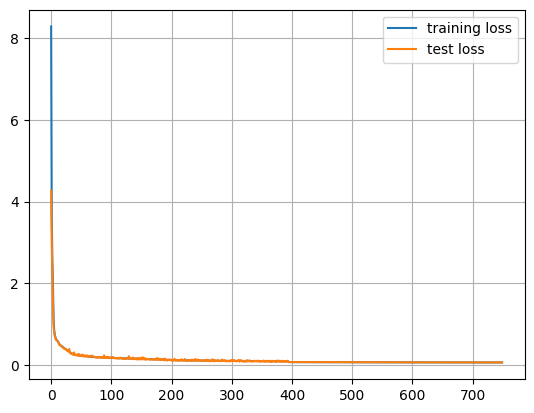

--------------------  EPOCH: 750  --------------------
LOSS train 0.06940280197530377 valid 0.06977047026157379
--------------------  EPOCH: 751  --------------------
LOSS train 0.06929148110199948 valid 0.07000645995140076
--------------------  EPOCH: 752  --------------------
LOSS train 0.06926832515366223 valid 0.07099246978759766
--------------------  EPOCH: 753  --------------------
LOSS train 0.07024036347866058 valid 0.0708240419626236
--------------------  EPOCH: 754  --------------------
LOSS train 0.06954928928492021 valid 0.07019771635532379
--------------------  EPOCH: 755  --------------------
LOSS train 0.06923356857530925 valid 0.06971433013677597
--------------------  EPOCH: 756  --------------------
LOSS train 0.06958088978212706 valid 0.07004771381616592
--------------------  EPOCH: 757  --------------------
LOSS train 0.06950317041910424 valid 0.0701153427362442
--------------------  EPOCH: 758  --------------------
LOSS train 0.0693958181203628 valid 0.0698621422052

LOSS train 0.06845727973446554 valid 0.06923670321702957
--------------------  EPOCH: 824  --------------------
LOSS train 0.06838384764839192 valid 0.06895368546247482
--------------------  EPOCH: 825  --------------------
LOSS train 0.0684029119355338 valid 0.0720248892903328
--------------------  EPOCH: 826  --------------------
LOSS train 0.0681469871529511 valid 0.06924130767583847
--------------------  EPOCH: 827  --------------------
LOSS train 0.0685196266490586 valid 0.0687699019908905
--------------------  EPOCH: 828  --------------------
LOSS train 0.06823737888920064 valid 0.06985802203416824
--------------------  EPOCH: 829  --------------------
LOSS train 0.06825294353219928 valid 0.06860687583684921
--------------------  EPOCH: 830  --------------------
LOSS train 0.0685647903200315 valid 0.06882346421480179
--------------------  EPOCH: 831  --------------------
LOSS train 0.06847029270566239 valid 0.06953104585409164
--------------------  EPOCH: 832  -------------------

LOSS train 0.06690790549832948 valid 0.0683412179350853
--------------------  EPOCH: 898  --------------------
LOSS train 0.06687695958784648 valid 0.06739673018455505
--------------------  EPOCH: 899  --------------------
LOSS train 0.0667610764503479 valid 0.06697820872068405
--------------------  EPOCH: 900  --------------------
LOSS train 0.06695929428144377 valid 0.06724158674478531
--------------------  EPOCH: 901  --------------------
LOSS train 0.06664443738302406 valid 0.06824737787246704
--------------------  EPOCH: 902  --------------------
LOSS train 0.06704389250704221 valid 0.06762497872114182
--------------------  EPOCH: 903  --------------------
LOSS train 0.0666046345568433 valid 0.0669894814491272
--------------------  EPOCH: 904  --------------------
LOSS train 0.06659214168178793 valid 0.06793974339962006
--------------------  EPOCH: 905  --------------------
LOSS train 0.06672174072995478 valid 0.06873658299446106
--------------------  EPOCH: 906  -----------------

LOSS train 0.06469987123748477 valid 0.06457383185625076
--------------------  EPOCH: 972  --------------------
LOSS train 0.06421746975001023 valid 0.0650353953242302
--------------------  EPOCH: 973  --------------------
LOSS train 0.06444605896059348 valid 0.06484688818454742
--------------------  EPOCH: 974  --------------------
LOSS train 0.06418532155910317 valid 0.06481828540563583
--------------------  EPOCH: 975  --------------------
LOSS train 0.06457521333074083 valid 0.0680621862411499
--------------------  EPOCH: 976  --------------------
LOSS train 0.06455480143884007 valid 0.06509678810834885
--------------------  EPOCH: 977  --------------------
LOSS train 0.06430987576592942 valid 0.06481500715017319
--------------------  EPOCH: 978  --------------------
LOSS train 0.06438149013841639 valid 0.06461630761623383
--------------------  EPOCH: 979  --------------------
LOSS train 0.064036544754493 valid 0.06437409669160843
--------------------  EPOCH: 980  -----------------

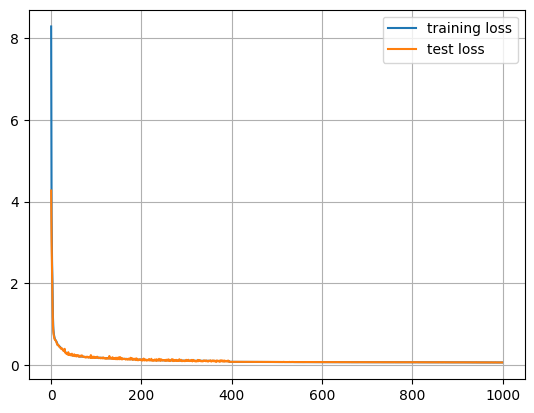

--------------------  EPOCH: 1000  --------------------
LOSS train 0.06347069311506894 valid 0.06524607539176941
--------------------  EPOCH: 1001  --------------------
LOSS train 0.06399360914923707 valid 0.06400302052497864
--------------------  EPOCH: 1002  --------------------
LOSS train 0.06368513390117762 valid 0.06413587927818298
--------------------  EPOCH: 1003  --------------------
LOSS train 0.06376396431302538 valid 0.06403138488531113
--------------------  EPOCH: 1004  --------------------
LOSS train 0.06363647921505022 valid 0.06414521485567093
--------------------  EPOCH: 1005  --------------------
LOSS train 0.06354229657777719 valid 0.06690958887338638
--------------------  EPOCH: 1006  --------------------
LOSS train 0.06396409990836163 valid 0.0639253705739975
--------------------  EPOCH: 1007  --------------------
LOSS train 0.06367921072761623 valid 0.06537257134914398
--------------------  EPOCH: 1008  --------------------
LOSS train 0.06355074762689825 valid 0.06

LOSS train 0.06283496879041195 valid 0.06302676349878311
--------------------  EPOCH: 1074  --------------------
LOSS train 0.0631377493620527 valid 0.06314558535814285
--------------------  EPOCH: 1075  --------------------
LOSS train 0.06250793467826989 valid 0.06317464262247086
--------------------  EPOCH: 1076  --------------------
LOSS train 0.06263069629821243 valid 0.06274601817131042
--------------------  EPOCH: 1077  --------------------
LOSS train 0.06278263849719447 valid 0.06276427954435349
--------------------  EPOCH: 1078  --------------------
LOSS train 0.06279817022079108 valid 0.06300396472215652
--------------------  EPOCH: 1079  --------------------
LOSS train 0.06239939492423924 valid 0.06322819739580154
--------------------  EPOCH: 1080  --------------------
LOSS train 0.06259685317624589 valid 0.06285540014505386
--------------------  EPOCH: 1081  --------------------
LOSS train 0.06256215897749881 valid 0.06317014992237091
--------------------  EPOCH: 1082  -----

LOSS train 0.061777014893536666 valid 0.06322792172431946
--------------------  EPOCH: 1147  --------------------
LOSS train 0.0620420187787742 valid 0.06222423538565636
--------------------  EPOCH: 1148  --------------------
LOSS train 0.06217653619847736 valid 0.06280290335416794
--------------------  EPOCH: 1149  --------------------
LOSS train 0.06179919029224892 valid 0.06274376809597015
--------------------  EPOCH: 1150  --------------------
LOSS train 0.06174429194355498 valid 0.06204548105597496
--------------------  EPOCH: 1151  --------------------
LOSS train 0.06171760875351575 valid 0.06194835156202316
--------------------  EPOCH: 1152  --------------------
LOSS train 0.062151302602522225 valid 0.062239307910203934
--------------------  EPOCH: 1153  --------------------
LOSS train 0.061600981812391965 valid 0.06322453916072845
--------------------  EPOCH: 1154  --------------------
LOSS train 0.06178625977160979 valid 0.06193613260984421
--------------------  EPOCH: 1155  -

LOSS train 0.06153411102690259 valid 0.06128663569688797
--------------------  EPOCH: 1220  --------------------
LOSS train 0.06090977472462216 valid 0.0624898225069046
--------------------  EPOCH: 1221  --------------------
LOSS train 0.06097480263180879 valid 0.06136065721511841
--------------------  EPOCH: 1222  --------------------
LOSS train 0.06104854927683363 valid 0.06154949218034744
--------------------  EPOCH: 1223  --------------------
LOSS train 0.06099115258881024 valid 0.06154656410217285
--------------------  EPOCH: 1224  --------------------
LOSS train 0.06084849012597483 valid 0.06219179555773735
--------------------  EPOCH: 1225  --------------------
LOSS train 0.06106383703192886 valid 0.06332932412624359
--------------------  EPOCH: 1226  --------------------
LOSS train 0.06133614157383539 valid 0.06176575645804405
--------------------  EPOCH: 1227  --------------------
LOSS train 0.06114849805527804 valid 0.0612628348171711
--------------------  EPOCH: 1228  ------

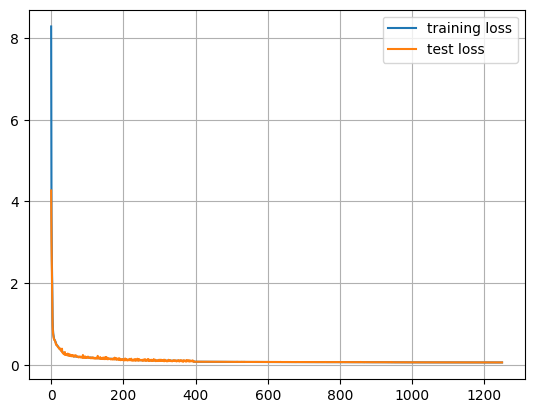

--------------------  EPOCH: 1250  --------------------
LOSS train 0.06080557770875036 valid 0.061261244118213654
--------------------  EPOCH: 1251  --------------------
LOSS train 0.06096590530811524 valid 0.0611930675804615
--------------------  EPOCH: 1252  --------------------
LOSS train 0.06069087043252527 valid 0.0617840550839901
--------------------  EPOCH: 1253  --------------------
LOSS train 0.06089793544794832 valid 0.06218699365854263
--------------------  EPOCH: 1254  --------------------
LOSS train 0.06116406573932998 valid 0.061055611819028854
--------------------  EPOCH: 1255  --------------------
LOSS train 0.06066814403296733 valid 0.06211185082793236
--------------------  EPOCH: 1256  --------------------
LOSS train 0.06108329160024925 valid 0.06104401499032974
--------------------  EPOCH: 1257  --------------------
LOSS train 0.06069418461043007 valid 0.06122308596968651
--------------------  EPOCH: 1258  --------------------
LOSS train 0.06075056779141329 valid 0.0

LOSS train 0.06013045520806799 valid 0.060989588499069214
--------------------  EPOCH: 1323  --------------------
LOSS train 0.060912824673007945 valid 0.06059286370873451
--------------------  EPOCH: 1324  --------------------
LOSS train 0.06031426213377593 valid 0.060698896646499634
--------------------  EPOCH: 1325  --------------------
LOSS train 0.06056844804207889 valid 0.06081002205610275
--------------------  EPOCH: 1326  --------------------
LOSS train 0.060496884341142615 valid 0.060436829924583435
--------------------  EPOCH: 1327  --------------------
LOSS train 0.060275107242014944 valid 0.060923054814338684
--------------------  EPOCH: 1328  --------------------
LOSS train 0.06053801732403891 valid 0.06054356321692467
--------------------  EPOCH: 1329  --------------------
LOSS train 0.06038733130815078 valid 0.06057065725326538
--------------------  EPOCH: 1330  --------------------
LOSS train 0.06041127717008396 valid 0.06088551506400108
--------------------  EPOCH: 133

LOSS train 0.05993086559583946 valid 0.06012319400906563
--------------------  EPOCH: 1396  --------------------
LOSS train 0.06002225711637614 valid 0.06029671058058739
--------------------  EPOCH: 1397  --------------------
LOSS train 0.060082501902872204 valid 0.06012885272502899
--------------------  EPOCH: 1398  --------------------
LOSS train 0.05997286698952013 valid 0.06079275906085968
--------------------  EPOCH: 1399  --------------------
LOSS train 0.060449631086417606 valid 0.06047964096069336
--------------------  EPOCH: 1400  --------------------
LOSS train 0.05979645666571296 valid 0.060146111994981766
--------------------  EPOCH: 1401  --------------------
LOSS train 0.05976936536632022 valid 0.06087803095579147
--------------------  EPOCH: 1402  --------------------
LOSS train 0.05980392191939208 valid 0.06011069193482399
--------------------  EPOCH: 1403  --------------------
LOSS train 0.06017916033766708 valid 0.06006234884262085
--------------------  EPOCH: 1404  -

LOSS train 0.0591860621863482 valid 0.05978717282414436
--------------------  EPOCH: 1467  --------------------
LOSS train 0.059166952055327744 valid 0.05978727713227272
--------------------  EPOCH: 1468  --------------------
LOSS train 0.05917161858963723 valid 0.05978751927614212
--------------------  EPOCH: 1469  --------------------
LOSS train 0.059168005856324216 valid 0.05978751182556152
--------------------  EPOCH: 1470  --------------------
LOSS train 0.05916465100433145 valid 0.0597885325551033
--------------------  EPOCH: 1471  --------------------
LOSS train 0.05916620623700473 valid 0.05978870019316673
--------------------  EPOCH: 1472  --------------------
LOSS train 0.05917398167812094 valid 0.05978652089834213
--------------------  EPOCH: 1473  --------------------
LOSS train 0.05916595747884439 valid 0.0597880557179451
--------------------  EPOCH: 1474  --------------------
LOSS train 0.059171280272457064 valid 0.05978688597679138
--------------------  EPOCH: 1475  ----

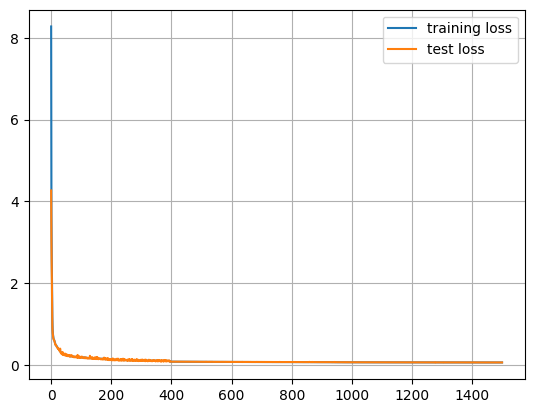

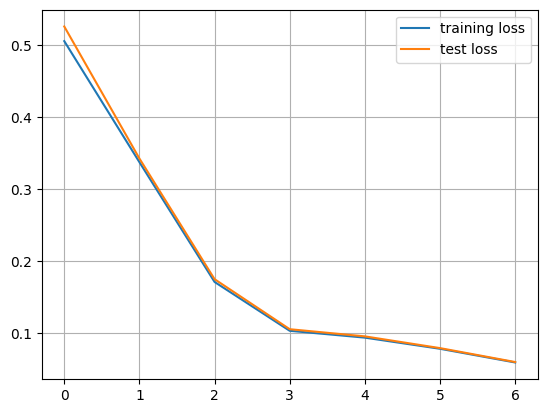

data_size: 800000
--------------------  EPOCH: 0  --------------------
LOSS train 5.752149377550397 valid 3.207505226135254
--------------------  EPOCH: 1  --------------------
LOSS train 2.1874500780689474 valid 1.3042786121368408
--------------------  EPOCH: 2  --------------------
LOSS train 0.8488766657454627 valid 0.701946496963501
--------------------  EPOCH: 3  --------------------
LOSS train 0.6442265206453751 valid 0.6149418950080872
--------------------  EPOCH: 4  --------------------
LOSS train 0.5951375672403647 valid 0.5824822187423706
--------------------  EPOCH: 5  --------------------
LOSS train 0.5759309192701262 valid 0.5850275754928589
--------------------  EPOCH: 6  --------------------
LOSS train 0.5481108627757247 valid 0.5506477355957031
--------------------  EPOCH: 7  --------------------
LOSS train 0.5289211718707668 valid 0.5143448710441589
--------------------  EPOCH: 8  --------------------
LOSS train 0.5125429081369419 valid 0.4976641833782196
-------------

LOSS train 0.136856809258461 valid 0.15456855297088623
--------------------  EPOCH: 76  --------------------
LOSS train 0.1348339329492681 valid 0.14272983372211456
--------------------  EPOCH: 77  --------------------
LOSS train 0.1343174076125938 valid 0.1570272296667099
--------------------  EPOCH: 78  --------------------
LOSS train 0.1354275410044558 valid 0.12990956008434296
--------------------  EPOCH: 79  --------------------
LOSS train 0.13409686301435744 valid 0.12398913502693176
--------------------  EPOCH: 80  --------------------
LOSS train 0.13310031064462904 valid 0.13317973911762238
--------------------  EPOCH: 81  --------------------
LOSS train 0.1340123378120515 valid 0.12427972257137299
--------------------  EPOCH: 82  --------------------
LOSS train 0.1330405049862302 valid 0.14657552540302277
--------------------  EPOCH: 83  --------------------
LOSS train 0.13217448291121697 valid 0.12917181849479675
--------------------  EPOCH: 84  --------------------
LOSS trai

LOSS train 0.1045214379472392 valid 0.09360145777463913
--------------------  EPOCH: 150  --------------------
LOSS train 0.10533065854438714 valid 0.10533595085144043
--------------------  EPOCH: 151  --------------------
LOSS train 0.1035541484550554 valid 0.12005358189344406
--------------------  EPOCH: 152  --------------------
LOSS train 0.10544216659452234 valid 0.09369911253452301
--------------------  EPOCH: 153  --------------------
LOSS train 0.10395447966851751 valid 0.11356336623430252
--------------------  EPOCH: 154  --------------------
LOSS train 0.10460063944361647 valid 0.1130751222372055
--------------------  EPOCH: 155  --------------------
LOSS train 0.1036295302364291 valid 0.09860222786664963
--------------------  EPOCH: 156  --------------------
LOSS train 0.10388745968135035 valid 0.10514605045318604
--------------------  EPOCH: 157  --------------------
LOSS train 0.1031503290394131 valid 0.0922955572605133
--------------------  EPOCH: 158  -------------------

LOSS train 0.09003506916366061 valid 0.08803898096084595
--------------------  EPOCH: 224  --------------------
LOSS train 0.09069444577456737 valid 0.09654265642166138
--------------------  EPOCH: 225  --------------------
LOSS train 0.09014169522085969 valid 0.07878316938877106
--------------------  EPOCH: 226  --------------------
LOSS train 0.0896123897436322 valid 0.09567342698574066
--------------------  EPOCH: 227  --------------------
LOSS train 0.08975732668626066 valid 0.08328212797641754
--------------------  EPOCH: 228  --------------------
LOSS train 0.08883622262094702 valid 0.08033927530050278
--------------------  EPOCH: 229  --------------------
LOSS train 0.09010293133252738 valid 0.10342193394899368
--------------------  EPOCH: 230  --------------------
LOSS train 0.08975853117144837 valid 0.09134946018457413
--------------------  EPOCH: 231  --------------------
LOSS train 0.0885655982990046 valid 0.1058816909790039
--------------------  EPOCH: 232  ----------------

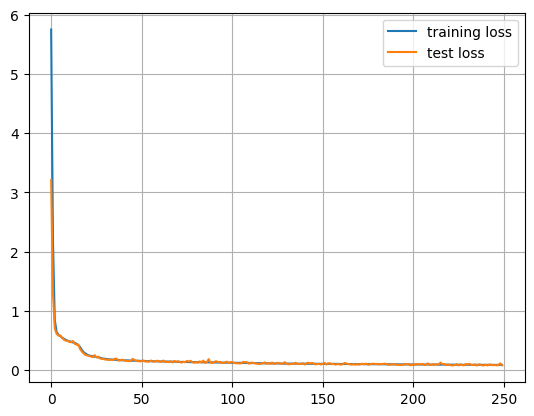

--------------------  EPOCH: 250  --------------------
LOSS train 0.087107459197239 valid 0.08423064649105072
--------------------  EPOCH: 251  --------------------
LOSS train 0.08643838485740886 valid 0.0801992192864418
--------------------  EPOCH: 252  --------------------
LOSS train 0.08694811701318439 valid 0.07794522494077682
--------------------  EPOCH: 253  --------------------
LOSS train 0.08626681053060659 valid 0.08547116070985794
--------------------  EPOCH: 254  --------------------
LOSS train 0.08568277460884074 valid 0.0938054695725441
--------------------  EPOCH: 255  --------------------
LOSS train 0.08615404911035178 valid 0.07591692358255386
--------------------  EPOCH: 256  --------------------
LOSS train 0.08694738765456239 valid 0.08896200358867645
--------------------  EPOCH: 257  --------------------
LOSS train 0.08521602485252887 valid 0.08102837204933167
--------------------  EPOCH: 258  --------------------
LOSS train 0.0861397498496333 valid 0.117064625024795

LOSS train 0.07953023385940766 valid 0.08878310024738312
--------------------  EPOCH: 324  --------------------
LOSS train 0.08080428067062582 valid 0.07323729246854782
--------------------  EPOCH: 325  --------------------
LOSS train 0.07999003442878626 valid 0.0871666744351387
--------------------  EPOCH: 326  --------------------
LOSS train 0.08071013357566327 valid 0.07388973236083984
--------------------  EPOCH: 327  --------------------
LOSS train 0.07920992363016216 valid 0.07676482200622559
--------------------  EPOCH: 328  --------------------
LOSS train 0.08004445917144114 valid 0.0732741504907608
--------------------  EPOCH: 329  --------------------
LOSS train 0.08111030942931467 valid 0.08203250169754028
--------------------  EPOCH: 330  --------------------
LOSS train 0.07968935370445251 valid 0.09972724318504333
--------------------  EPOCH: 331  --------------------
LOSS train 0.0796322757948418 valid 0.07591965794563293
--------------------  EPOCH: 332  ----------------

LOSS train 0.0747789422392237 valid 0.06883925944566727
--------------------  EPOCH: 398  --------------------
LOSS train 0.0747344702368184 valid 0.0794212594628334
--------------------  EPOCH: 399  --------------------
LOSS train 0.07448492094646303 valid 0.09217137843370438
--------------------  EPOCH: 400  --------------------
LOSS train 0.07381892335430092 valid 0.08134441822767258
--------------------  EPOCH: 401  --------------------
LOSS train 0.07530690068188979 valid 0.07576149702072144
--------------------  EPOCH: 402  --------------------
LOSS train 0.07435795303662213 valid 0.07873795926570892
--------------------  EPOCH: 403  --------------------
LOSS train 0.07396146050673358 valid 0.06582741439342499
--------------------  EPOCH: 404  --------------------
LOSS train 0.07378275939548502 valid 0.07382102310657501
--------------------  EPOCH: 405  --------------------
LOSS train 0.07472376958752165 valid 0.07212009280920029
--------------------  EPOCH: 406  ----------------

LOSS train 0.06907631791367823 valid 0.06685549765825272
--------------------  EPOCH: 472  --------------------
LOSS train 0.06989144106224483 valid 0.07649824768304825
--------------------  EPOCH: 473  --------------------
LOSS train 0.07078492027536339 valid 0.0640513002872467
--------------------  EPOCH: 474  --------------------
LOSS train 0.06938804182395035 valid 0.06863690912723541
--------------------  EPOCH: 475  --------------------
LOSS train 0.07014290043818099 valid 0.0801621824502945
--------------------  EPOCH: 476  --------------------
LOSS train 0.06907600230936493 valid 0.06888613104820251
--------------------  EPOCH: 477  --------------------
LOSS train 0.06944533032650242 valid 0.06054460257291794
--------------------  EPOCH: 478  --------------------
LOSS train 0.0694194409274021 valid 0.08354128897190094
--------------------  EPOCH: 479  --------------------
LOSS train 0.0695404072615261 valid 0.06999290734529495
--------------------  EPOCH: 480  -----------------

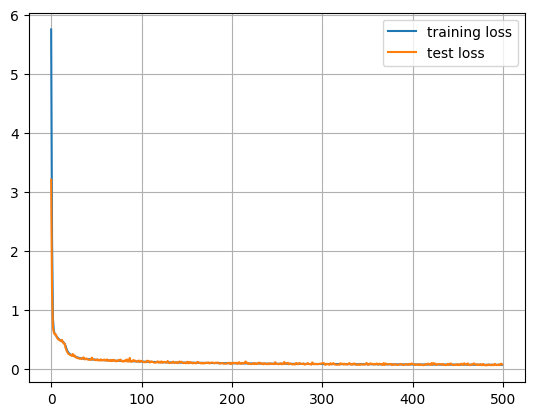

--------------------  EPOCH: 500  --------------------
LOSS train 0.06822941672741151 valid 0.07106541842222214
--------------------  EPOCH: 501  --------------------
LOSS train 0.06792945918456024 valid 0.05755579471588135
--------------------  EPOCH: 502  --------------------
LOSS train 0.06827349287970942 valid 0.06317809224128723
--------------------  EPOCH: 503  --------------------
LOSS train 0.06890050441558872 valid 0.07269345968961716
--------------------  EPOCH: 504  --------------------
LOSS train 0.06771483717068118 valid 0.05634859949350357
--------------------  EPOCH: 505  --------------------
LOSS train 0.06752133137565486 valid 0.08410898596048355
--------------------  EPOCH: 506  --------------------
LOSS train 0.0684781612600295 valid 0.06668952852487564
--------------------  EPOCH: 507  --------------------
LOSS train 0.06741666470711329 valid 0.06229741498827934
--------------------  EPOCH: 508  --------------------
LOSS train 0.06895392091602695 valid 0.06499551236

LOSS train 0.06580229147280357 valid 0.08039862662553787
--------------------  EPOCH: 574  --------------------
LOSS train 0.06544167685265444 valid 0.06657236069440842
--------------------  EPOCH: 575  --------------------
LOSS train 0.06614037029141066 valid 0.05627839267253876
--------------------  EPOCH: 576  --------------------
LOSS train 0.06512860149829364 valid 0.06893237680196762
--------------------  EPOCH: 577  --------------------
LOSS train 0.06536560651979276 valid 0.05974005535244942
--------------------  EPOCH: 578  --------------------
LOSS train 0.06525309081664499 valid 0.06314961612224579
--------------------  EPOCH: 579  --------------------
LOSS train 0.0651419390829242 valid 0.06043423339724541
--------------------  EPOCH: 580  --------------------
LOSS train 0.0661529431081548 valid 0.06692446023225784
--------------------  EPOCH: 581  --------------------
LOSS train 0.06578255555003273 valid 0.06966749578714371
--------------------  EPOCH: 582  ---------------

LOSS train 0.06261153969609616 valid 0.06259620934724808
--------------------  EPOCH: 648  --------------------
LOSS train 0.06346922538870452 valid 0.05712968111038208
--------------------  EPOCH: 649  --------------------
LOSS train 0.0635026432953927 valid 0.05205094441771507
--------------------  EPOCH: 650  --------------------
LOSS train 0.06422474645838445 valid 0.06629089266061783
--------------------  EPOCH: 651  --------------------
LOSS train 0.06270298127997287 valid 0.060826171189546585
--------------------  EPOCH: 652  --------------------
LOSS train 0.06311560387970233 valid 0.05179587006568909
--------------------  EPOCH: 653  --------------------
LOSS train 0.0637557267648529 valid 0.06476899981498718
--------------------  EPOCH: 654  --------------------
LOSS train 0.06368748982417949 valid 0.07795184850692749
--------------------  EPOCH: 655  --------------------
LOSS train 0.06341816720609762 valid 0.05157792195677757
--------------------  EPOCH: 656  --------------

LOSS train 0.04986252396234444 valid 0.049733128398656845
--------------------  EPOCH: 722  --------------------
LOSS train 0.04954430135917299 valid 0.04968903958797455
--------------------  EPOCH: 723  --------------------
LOSS train 0.04953107061054634 valid 0.04969009384512901
--------------------  EPOCH: 724  --------------------
LOSS train 0.04949530523878579 valid 0.04974156990647316
--------------------  EPOCH: 725  --------------------
LOSS train 0.04949838402015822 valid 0.04969670996069908
--------------------  EPOCH: 726  --------------------
LOSS train 0.049503713827200084 valid 0.04974447935819626
--------------------  EPOCH: 727  --------------------
LOSS train 0.049500057188679975 valid 0.049764227122068405
--------------------  EPOCH: 728  --------------------
LOSS train 0.049491675399547935 valid 0.049747586250305176
--------------------  EPOCH: 729  --------------------
LOSS train 0.04949804062822035 valid 0.049754273146390915
--------------------  EPOCH: 730  ------

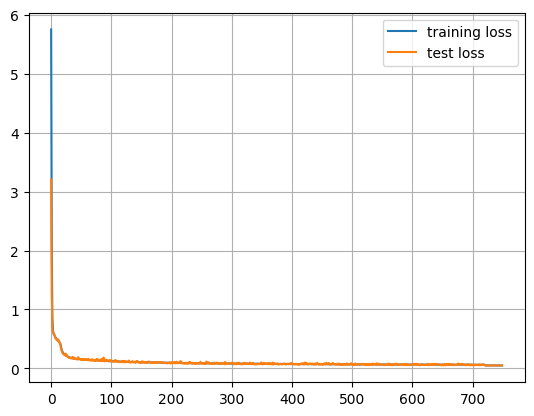

--------------------  EPOCH: 750  --------------------
LOSS train 0.04944148555169908 valid 0.04963846504688263
--------------------  EPOCH: 751  --------------------
LOSS train 0.049420484949891666 valid 0.04934283718466759
--------------------  EPOCH: 752  --------------------
LOSS train 0.04961053291525768 valid 0.05061597377061844
--------------------  EPOCH: 753  --------------------
LOSS train 0.0493440768890539 valid 0.049924373626708984
--------------------  EPOCH: 754  --------------------
LOSS train 0.04938160802940933 valid 0.0498959943652153
--------------------  EPOCH: 755  --------------------
LOSS train 0.04931181701546421 valid 0.04931836575269699
--------------------  EPOCH: 756  --------------------
LOSS train 0.049331674333281665 valid 0.04942071810364723
--------------------  EPOCH: 757  --------------------
LOSS train 0.049325703453196555 valid 0.04934123530983925
--------------------  EPOCH: 758  --------------------
LOSS train 0.049315309931277015 valid 0.0491461

LOSS train 0.04861577670565065 valid 0.049432069063186646
--------------------  EPOCH: 824  --------------------
LOSS train 0.048449813844446014 valid 0.04897119477391243
--------------------  EPOCH: 825  --------------------
LOSS train 0.04840779770165682 valid 0.0502394363284111
--------------------  EPOCH: 826  --------------------
LOSS train 0.048549962686184715 valid 0.04843650758266449
--------------------  EPOCH: 827  --------------------
LOSS train 0.04863687503930866 valid 0.04842405766248703
--------------------  EPOCH: 828  --------------------
LOSS train 0.048442557777221104 valid 0.04865708947181702
--------------------  EPOCH: 829  --------------------
LOSS train 0.04850006934103309 valid 0.048340290784835815
--------------------  EPOCH: 830  --------------------
LOSS train 0.04845256664391075 valid 0.04850880801677704
--------------------  EPOCH: 831  --------------------
LOSS train 0.04839625363523255 valid 0.04936450347304344
--------------------  EPOCH: 832  ---------

LOSS train 0.047881421442998916 valid 0.04821503162384033
--------------------  EPOCH: 897  --------------------
LOSS train 0.04785942738609655 valid 0.04879014566540718
--------------------  EPOCH: 898  --------------------
LOSS train 0.04802596282061874 valid 0.04810364171862602
--------------------  EPOCH: 899  --------------------
LOSS train 0.048090829190855125 valid 0.04764736443758011
--------------------  EPOCH: 900  --------------------
LOSS train 0.0477402333968452 valid 0.04776693880558014
--------------------  EPOCH: 901  --------------------
LOSS train 0.04768982656984305 valid 0.049837321043014526
--------------------  EPOCH: 902  --------------------
LOSS train 0.04790323738921053 valid 0.047653526067733765
--------------------  EPOCH: 903  --------------------
LOSS train 0.04774553851433554 valid 0.048565082252025604
--------------------  EPOCH: 904  --------------------
LOSS train 0.047887375521264514 valid 0.04774666205048561
--------------------  EPOCH: 905  --------

LOSS train 0.04727718097214796 valid 0.04803941026329994
--------------------  EPOCH: 970  --------------------
LOSS train 0.04747605736234358 valid 0.0475178137421608
--------------------  EPOCH: 971  --------------------
LOSS train 0.047119347473644484 valid 0.04710914194583893
--------------------  EPOCH: 972  --------------------
LOSS train 0.04711637993780326 valid 0.04710869863629341
--------------------  EPOCH: 973  --------------------
LOSS train 0.04724951232878529 valid 0.047634053975343704
--------------------  EPOCH: 974  --------------------
LOSS train 0.04714189581953141 valid 0.04781081900000572
--------------------  EPOCH: 975  --------------------
LOSS train 0.04724921400145608 valid 0.047392621636390686
--------------------  EPOCH: 976  --------------------
LOSS train 0.04738026114218697 valid 0.04703359678387642
--------------------  EPOCH: 977  --------------------
LOSS train 0.04712073096283236 valid 0.04724761098623276
--------------------  EPOCH: 978  -----------

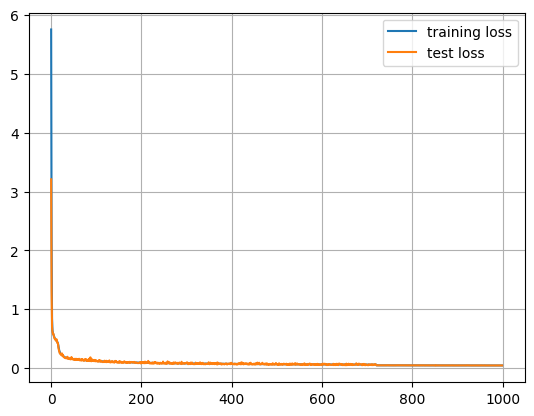

--------------------  EPOCH: 1000  --------------------
LOSS train 0.04717700755489724 valid 0.04768978804349899
--------------------  EPOCH: 1001  --------------------
LOSS train 0.04692673736384937 valid 0.04720476269721985
--------------------  EPOCH: 1002  --------------------
LOSS train 0.04700303855067005 valid 0.046858128160238266
--------------------  EPOCH: 1003  --------------------
LOSS train 0.046939321204411744 valid 0.04689223691821098
--------------------  EPOCH: 1004  --------------------
LOSS train 0.04696927419198411 valid 0.04696717485785484
--------------------  EPOCH: 1005  --------------------
LOSS train 0.04708849370707663 valid 0.04716677963733673
--------------------  EPOCH: 1006  --------------------
LOSS train 0.046822281117189904 valid 0.04833145812153816
--------------------  EPOCH: 1007  --------------------
LOSS train 0.047018571262608985 valid 0.04677622765302658
--------------------  EPOCH: 1008  --------------------
LOSS train 0.04687616438129727 valid

LOSS train 0.04651329732899155 valid 0.04714317247271538
--------------------  EPOCH: 1073  --------------------
LOSS train 0.04650433224682905 valid 0.04616595432162285
--------------------  EPOCH: 1074  --------------------
LOSS train 0.04652583325395779 valid 0.04620426520705223
--------------------  EPOCH: 1075  --------------------
LOSS train 0.04650289713576132 valid 0.046359602361917496
--------------------  EPOCH: 1076  --------------------
LOSS train 0.04632684708173786 valid 0.04739004746079445
--------------------  EPOCH: 1077  --------------------
LOSS train 0.04626830220602605 valid 0.04630998522043228
--------------------  EPOCH: 1078  --------------------
LOSS train 0.04623003305905327 valid 0.04660281166434288
--------------------  EPOCH: 1079  --------------------
LOSS train 0.04622548221781546 valid 0.04645126312971115
--------------------  EPOCH: 1080  --------------------
LOSS train 0.046304995460169654 valid 0.046271417289972305
--------------------  EPOCH: 1081  -

LOSS train 0.04595437480554897 valid 0.045791637152433395
--------------------  EPOCH: 1146  --------------------
LOSS train 0.0459905453786558 valid 0.04584065452218056
--------------------  EPOCH: 1147  --------------------
LOSS train 0.04588563082625671 valid 0.04608084633946419
--------------------  EPOCH: 1148  --------------------
LOSS train 0.04580130555419898 valid 0.046147871762514114
--------------------  EPOCH: 1149  --------------------
LOSS train 0.04586555624418721 valid 0.045944955199956894
--------------------  EPOCH: 1150  --------------------
LOSS train 0.0458551949574327 valid 0.04650556668639183
--------------------  EPOCH: 1151  --------------------
LOSS train 0.04579481877842728 valid 0.04612443223595619
--------------------  EPOCH: 1152  --------------------
LOSS train 0.04590562727226286 valid 0.045653052628040314
--------------------  EPOCH: 1153  --------------------
LOSS train 0.045848410386516124 valid 0.04608045518398285
--------------------  EPOCH: 1154  -

LOSS train 0.04542020257866504 valid 0.045250169932842255
--------------------  EPOCH: 1219  --------------------
LOSS train 0.04544609144558104 valid 0.048132508993148804
--------------------  EPOCH: 1220  --------------------
LOSS train 0.045460578719420094 valid 0.04549454152584076
--------------------  EPOCH: 1221  --------------------
LOSS train 0.045475816753293784 valid 0.04584679752588272
--------------------  EPOCH: 1222  --------------------
LOSS train 0.04530956995274339 valid 0.045212019234895706
--------------------  EPOCH: 1223  --------------------
LOSS train 0.04544161022545732 valid 0.04676847904920578
--------------------  EPOCH: 1224  --------------------
LOSS train 0.045488967351159273 valid 0.04525833949446678
--------------------  EPOCH: 1225  --------------------
LOSS train 0.045541392392193784 valid 0.0452585369348526
--------------------  EPOCH: 1226  --------------------
LOSS train 0.04543462675064802 valid 0.04568140581250191
--------------------  EPOCH: 1227

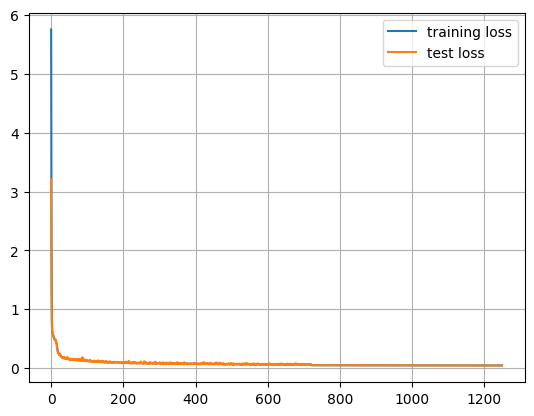

--------------------  EPOCH: 1250  --------------------
LOSS train 0.045227794641894956 valid 0.045113641768693924
--------------------  EPOCH: 1251  --------------------
LOSS train 0.04535320568449643 valid 0.04674965888261795
--------------------  EPOCH: 1252  --------------------
LOSS train 0.045155127494767 valid 0.04507973790168762
--------------------  EPOCH: 1253  --------------------
LOSS train 0.045220356757695576 valid 0.04524477571249008
--------------------  EPOCH: 1254  --------------------
LOSS train 0.04516518691896784 valid 0.04508335888385773
--------------------  EPOCH: 1255  --------------------
LOSS train 0.04529573198179809 valid 0.04547569155693054
--------------------  EPOCH: 1256  --------------------
LOSS train 0.04515117294706252 valid 0.04561459273099899
--------------------  EPOCH: 1257  --------------------
LOSS train 0.04520586328771042 valid 0.04513823240995407
--------------------  EPOCH: 1258  --------------------
LOSS train 0.04525568355254981 valid 0.

LOSS train 0.044925681562448035 valid 0.04537561163306236
--------------------  EPOCH: 1323  --------------------
LOSS train 0.04480675269602513 valid 0.04526302590966225
--------------------  EPOCH: 1324  --------------------
LOSS train 0.04462512740295152 valid 0.04674091562628746
--------------------  EPOCH: 1325  --------------------
LOSS train 0.044856863837613135 valid 0.04471075162291527
--------------------  EPOCH: 1326  --------------------
LOSS train 0.04479142630054635 valid 0.044806018471717834
--------------------  EPOCH: 1327  --------------------
LOSS train 0.044803242370182156 valid 0.04462390020489693
--------------------  EPOCH: 1328  --------------------
LOSS train 0.04485472341125109 valid 0.04478538781404495
--------------------  EPOCH: 1329  --------------------
LOSS train 0.04467954461899947 valid 0.044727083295583725
--------------------  EPOCH: 1330  --------------------
LOSS train 0.044756281075580995 valid 0.04488029703497887
--------------------  EPOCH: 1331

LOSS train 0.04425299279771897 valid 0.044498469680547714
--------------------  EPOCH: 1396  --------------------
LOSS train 0.04432613600273522 valid 0.044286951422691345
--------------------  EPOCH: 1397  --------------------
LOSS train 0.04427597859912381 valid 0.04437926411628723
--------------------  EPOCH: 1398  --------------------
LOSS train 0.0443621196651033 valid 0.044309407472610474
--------------------  EPOCH: 1399  --------------------
LOSS train 0.04419651811904445 valid 0.045112017542123795
--------------------  EPOCH: 1400  --------------------
LOSS train 0.04437937475360778 valid 0.044253282248973846
--------------------  EPOCH: 1401  --------------------
LOSS train 0.04415978107373325 valid 0.044367238879203796
--------------------  EPOCH: 1402  --------------------
LOSS train 0.044150433408058416 valid 0.04419615492224693
--------------------  EPOCH: 1403  --------------------
LOSS train 0.04413124265111223 valid 0.04451406002044678
--------------------  EPOCH: 1404

LOSS train 0.0437698150433752 valid 0.04379168152809143
--------------------  EPOCH: 1469  --------------------
LOSS train 0.04395466484129429 valid 0.0439046248793602
--------------------  EPOCH: 1470  --------------------
LOSS train 0.04376168636491104 valid 0.043696079403162
--------------------  EPOCH: 1471  --------------------
LOSS train 0.043882950114048254 valid 0.04459742084145546
--------------------  EPOCH: 1472  --------------------
LOSS train 0.04394977214765184 valid 0.044417813420295715
--------------------  EPOCH: 1473  --------------------
LOSS train 0.04367002000918194 valid 0.04380769655108452
--------------------  EPOCH: 1474  --------------------
LOSS train 0.043771683428512544 valid 0.04374118894338608
--------------------  EPOCH: 1475  --------------------
LOSS train 0.043805334888094544 valid 0.04398833587765694
--------------------  EPOCH: 1476  --------------------
LOSS train 0.04384119745952134 valid 0.043659504503011703
--------------------  EPOCH: 1477  ---

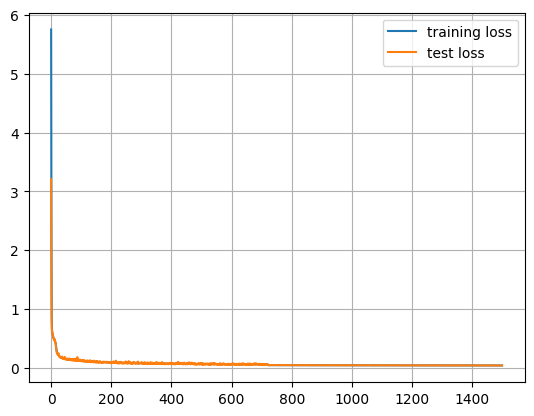

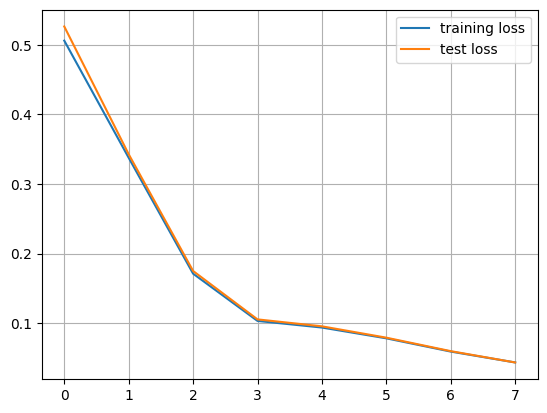

data_size: 1000000
--------------------  EPOCH: 0  --------------------
LOSS train 5.054927578750922 valid 2.309624433517456
--------------------  EPOCH: 1  --------------------
LOSS train 1.3931237196435733 valid 0.7041277289390564
--------------------  EPOCH: 2  --------------------
LOSS train 0.5963620125030985 valid 0.5694907307624817
--------------------  EPOCH: 3  --------------------
LOSS train 0.5338709662155229 valid 0.5223791003227234
--------------------  EPOCH: 4  --------------------
LOSS train 0.50677543233852 valid 0.4887479543685913
--------------------  EPOCH: 5  --------------------
LOSS train 0.48219259478607956 valid 0.4824119508266449
--------------------  EPOCH: 6  --------------------
LOSS train 0.46092395940605474 valid 0.43562787771224976
--------------------  EPOCH: 7  --------------------
LOSS train 0.42776118127667173 valid 0.42343637347221375
--------------------  EPOCH: 8  --------------------
LOSS train 0.40934799812277967 valid 0.4013090133666992
-------

LOSS train 0.14479759283819976 valid 0.13500474393367767
--------------------  EPOCH: 75  --------------------
LOSS train 0.14287117807840816 valid 0.1380925178527832
--------------------  EPOCH: 76  --------------------
LOSS train 0.14263704343109715 valid 0.1375376135110855
--------------------  EPOCH: 77  --------------------
LOSS train 0.14215841834642448 valid 0.12471979111433029
--------------------  EPOCH: 78  --------------------
LOSS train 0.1412910100452754 valid 0.12351285666227341
--------------------  EPOCH: 79  --------------------
LOSS train 0.13931388778954137 valid 0.14511823654174805
--------------------  EPOCH: 80  --------------------
LOSS train 0.14085196150200707 valid 0.12584418058395386
--------------------  EPOCH: 81  --------------------
LOSS train 0.13815425458003064 valid 0.15224362909793854
--------------------  EPOCH: 82  --------------------
LOSS train 0.1366858563556963 valid 0.1633661985397339
--------------------  EPOCH: 83  --------------------
LOSS t

LOSS train 0.11521832051934028 valid 0.10020607709884644
--------------------  EPOCH: 149  --------------------
LOSS train 0.11545180705737094 valid 0.11367859691381454
--------------------  EPOCH: 150  --------------------
LOSS train 0.11600056001726462 valid 0.12453296780586243
--------------------  EPOCH: 151  --------------------
LOSS train 0.11481463690193332 valid 0.11801246553659439
--------------------  EPOCH: 152  --------------------
LOSS train 0.11441234316752881 valid 0.10179588198661804
--------------------  EPOCH: 153  --------------------
LOSS train 0.11350381818352913 valid 0.11832205951213837
--------------------  EPOCH: 154  --------------------
LOSS train 0.11536946758931997 valid 0.12121572345495224
--------------------  EPOCH: 155  --------------------
LOSS train 0.11495856931623147 valid 0.14287525415420532
--------------------  EPOCH: 156  --------------------
LOSS train 0.11251329989457617 valid 0.11640402674674988
--------------------  EPOCH: 157  -------------

LOSS train 0.10301072430245731 valid 0.10931935906410217
--------------------  EPOCH: 223  --------------------
LOSS train 0.10261595337366572 valid 0.11072644591331482
--------------------  EPOCH: 224  --------------------
LOSS train 0.10170481934839365 valid 0.111493319272995
--------------------  EPOCH: 225  --------------------
LOSS train 0.10156949761570716 valid 0.09607870876789093
--------------------  EPOCH: 226  --------------------
LOSS train 0.10105464680462467 valid 0.13234779238700867
--------------------  EPOCH: 227  --------------------
LOSS train 0.10192207158828268 valid 0.11146949231624603
--------------------  EPOCH: 228  --------------------
LOSS train 0.10161119112554862 valid 0.13389694690704346
--------------------  EPOCH: 229  --------------------
LOSS train 0.10069338773586312 valid 0.08437425643205643
--------------------  EPOCH: 230  --------------------
LOSS train 0.10061279215982982 valid 0.08808635920286179
--------------------  EPOCH: 231  ---------------

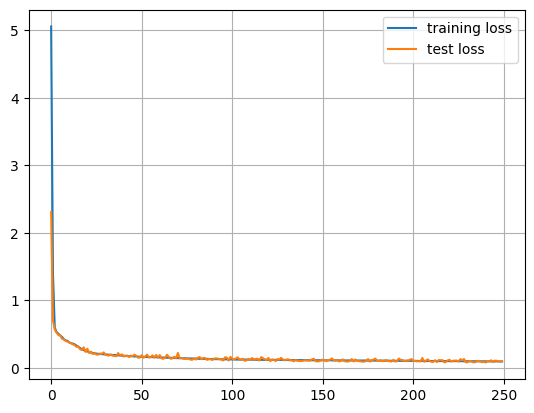

--------------------  EPOCH: 250  --------------------
LOSS train 0.09743684910389842 valid 0.08890555799007416
--------------------  EPOCH: 251  --------------------
LOSS train 0.0973516771987993 valid 0.13682959973812103
--------------------  EPOCH: 252  --------------------
LOSS train 0.09715363577920563 valid 0.09051787108182907
--------------------  EPOCH: 253  --------------------
LOSS train 0.09711930912976362 valid 0.08195678889751434
--------------------  EPOCH: 254  --------------------
LOSS train 0.09675545032535281 valid 0.08613739162683487
--------------------  EPOCH: 255  --------------------
LOSS train 0.09664331704986338 valid 0.11543336510658264
--------------------  EPOCH: 256  --------------------
LOSS train 0.09669441437842895 valid 0.11142364144325256
--------------------  EPOCH: 257  --------------------
LOSS train 0.09599226381705732 valid 0.08532777428627014
--------------------  EPOCH: 258  --------------------
LOSS train 0.09664017673657865 valid 0.11958620697

LOSS train 0.08525835619289047 valid 0.0701802521944046
--------------------  EPOCH: 324  --------------------
LOSS train 0.08608820921912486 valid 0.07585034519433975
--------------------  EPOCH: 325  --------------------
LOSS train 0.0859237294111933 valid 0.10539184510707855
--------------------  EPOCH: 326  --------------------
LOSS train 0.08521477184733565 valid 0.08113518357276917
--------------------  EPOCH: 327  --------------------
LOSS train 0.0858612566578145 valid 0.0954432338476181
--------------------  EPOCH: 328  --------------------
LOSS train 0.08547964603925237 valid 0.10057736188173294
--------------------  EPOCH: 329  --------------------
LOSS train 0.08537021595604566 valid 0.08598027378320694
--------------------  EPOCH: 330  --------------------
LOSS train 0.08501540115293191 valid 0.08484166860580444
--------------------  EPOCH: 331  --------------------
LOSS train 0.08472161648833022 valid 0.10154977440834045
--------------------  EPOCH: 332  -----------------

LOSS train 0.07870143077203205 valid 0.06278765946626663
--------------------  EPOCH: 398  --------------------
LOSS train 0.07851221981097241 valid 0.08621225506067276
--------------------  EPOCH: 399  --------------------
LOSS train 0.07844761762083793 valid 0.08372026681900024
--------------------  EPOCH: 400  --------------------
LOSS train 0.07893448298682972 valid 0.07124393433332443
--------------------  EPOCH: 401  --------------------
LOSS train 0.07739092408090222 valid 0.061576712876558304
--------------------  EPOCH: 402  --------------------
LOSS train 0.07861713342824761 valid 0.06393098831176758
--------------------  EPOCH: 403  --------------------
LOSS train 0.07801803672800259 valid 0.09009884297847748
--------------------  EPOCH: 404  --------------------
LOSS train 0.07754121970157234 valid 0.06855848431587219
--------------------  EPOCH: 405  --------------------
LOSS train 0.07793156218772032 valid 0.07372549921274185
--------------------  EPOCH: 406  ------------

LOSS train 0.07383534494711429 valid 0.07169803977012634
--------------------  EPOCH: 472  --------------------
LOSS train 0.07196819420371736 valid 0.08910772949457169
--------------------  EPOCH: 473  --------------------
LOSS train 0.07327715740824232 valid 0.06413627415895462
--------------------  EPOCH: 474  --------------------
LOSS train 0.07332346728261636 valid 0.07117253541946411
--------------------  EPOCH: 475  --------------------
LOSS train 0.07316473708773145 valid 0.07424324750900269
--------------------  EPOCH: 476  --------------------
LOSS train 0.07255049475601741 valid 0.06756267696619034
--------------------  EPOCH: 477  --------------------
LOSS train 0.07294078003995273 valid 0.07028535008430481
--------------------  EPOCH: 478  --------------------
LOSS train 0.07239331624337605 valid 0.05640595778822899
--------------------  EPOCH: 479  --------------------
LOSS train 0.07225575261578268 valid 0.06300482153892517
--------------------  EPOCH: 480  -------------

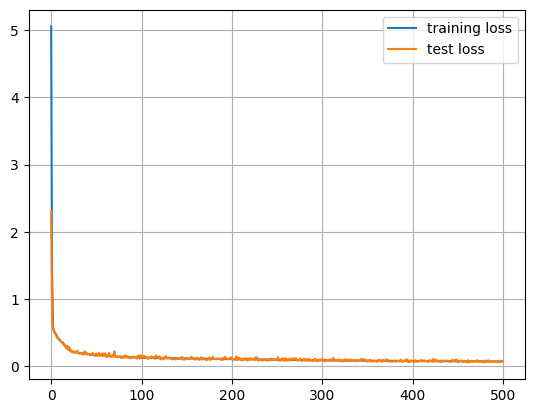

--------------------  EPOCH: 500  --------------------
LOSS train 0.07052392529285684 valid 0.06395424157381058
--------------------  EPOCH: 501  --------------------
LOSS train 0.07121226574693407 valid 0.06461042910814285
--------------------  EPOCH: 502  --------------------
LOSS train 0.07062802973146341 valid 0.06694662570953369
--------------------  EPOCH: 503  --------------------
LOSS train 0.07093273107798732 valid 0.06490760296583176
--------------------  EPOCH: 504  --------------------
LOSS train 0.0705227973965966 valid 0.09240593761205673
--------------------  EPOCH: 505  --------------------
LOSS train 0.07033262339477636 valid 0.08153396099805832
--------------------  EPOCH: 506  --------------------
LOSS train 0.07037681221049659 valid 0.08316505700349808
--------------------  EPOCH: 507  --------------------
LOSS train 0.07043085630450929 valid 0.07925836741924286
--------------------  EPOCH: 508  --------------------
LOSS train 0.07084190816599495 valid 0.05661714449

LOSS train 0.04980332235596618 valid 0.050133541226387024
--------------------  EPOCH: 574  --------------------
LOSS train 0.0498115208532129 valid 0.050135500729084015
--------------------  EPOCH: 575  --------------------
LOSS train 0.04986556420216755 valid 0.05034815892577171
--------------------  EPOCH: 576  --------------------
LOSS train 0.049915312625923934 valid 0.051750779151916504
--------------------  EPOCH: 577  --------------------
LOSS train 0.049769018955376686 valid 0.049959905445575714
--------------------  EPOCH: 578  --------------------
LOSS train 0.04990760915133418 valid 0.0505073182284832
--------------------  EPOCH: 579  --------------------
LOSS train 0.04989391775155554 valid 0.04985477402806282
--------------------  EPOCH: 580  --------------------
LOSS train 0.04981348383791593 valid 0.053249917924404144
--------------------  EPOCH: 581  --------------------
LOSS train 0.049771396557287295 valid 0.050916511565446854
--------------------  EPOCH: 582  ------

LOSS train 0.04801382889248887 valid 0.049094077199697495
--------------------  EPOCH: 647  --------------------
LOSS train 0.04811391085386276 valid 0.04812418296933174
--------------------  EPOCH: 648  --------------------
LOSS train 0.048066866063341804 valid 0.04831329360604286
--------------------  EPOCH: 649  --------------------
LOSS train 0.047875493339129854 valid 0.05002046376466751
--------------------  EPOCH: 650  --------------------
LOSS train 0.0481716230663718 valid 0.04814905673265457
--------------------  EPOCH: 651  --------------------
LOSS train 0.04796283768147838 valid 0.04842706769704819
--------------------  EPOCH: 652  --------------------
LOSS train 0.047851665165959574 valid 0.04928361251950264
--------------------  EPOCH: 653  --------------------
LOSS train 0.047939991023467514 valid 0.04896150529384613
--------------------  EPOCH: 654  --------------------
LOSS train 0.04781077011507385 valid 0.04847166687250137
--------------------  EPOCH: 655  ---------

LOSS train 0.04663761943882826 valid 0.04669806733727455
--------------------  EPOCH: 720  --------------------
LOSS train 0.04666911608406476 valid 0.04674479737877846
--------------------  EPOCH: 721  --------------------
LOSS train 0.04671177369903545 valid 0.04655608907341957
--------------------  EPOCH: 722  --------------------
LOSS train 0.046563595259676176 valid 0.046791303902864456
--------------------  EPOCH: 723  --------------------
LOSS train 0.04672920147375185 valid 0.04670695587992668
--------------------  EPOCH: 724  --------------------
LOSS train 0.04669977192367826 valid 0.04663200303912163
--------------------  EPOCH: 725  --------------------
LOSS train 0.04648804688940243 valid 0.04750934988260269
--------------------  EPOCH: 726  --------------------
LOSS train 0.046517091761438215 valid 0.047028593719005585
--------------------  EPOCH: 727  --------------------
LOSS train 0.046475738515051046 valid 0.04645456746220589
--------------------  EPOCH: 728  --------

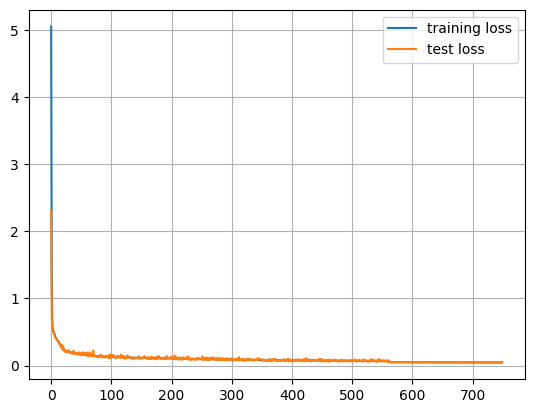

--------------------  EPOCH: 750  --------------------
LOSS train 0.046082714549740965 valid 0.04630671814084053
--------------------  EPOCH: 751  --------------------
LOSS train 0.046293328231086533 valid 0.04608715698122978
--------------------  EPOCH: 752  --------------------
LOSS train 0.0460860869258034 valid 0.04618920013308525
--------------------  EPOCH: 753  --------------------
LOSS train 0.04605746903285688 valid 0.04628091678023338
--------------------  EPOCH: 754  --------------------
LOSS train 0.046008014952649876 valid 0.04651006683707237
--------------------  EPOCH: 755  --------------------
LOSS train 0.045950486039628785 valid 0.04607700556516647
--------------------  EPOCH: 756  --------------------
LOSS train 0.04603128973014501 valid 0.04594707861542702
--------------------  EPOCH: 757  --------------------
LOSS train 0.04606974263276373 valid 0.0467100627720356
--------------------  EPOCH: 758  --------------------
LOSS train 0.046041436599833625 valid 0.0460208

LOSS train 0.04484116486748871 valid 0.044719383120536804
--------------------  EPOCH: 824  --------------------
LOSS train 0.044902016070424294 valid 0.04900652542710304
--------------------  EPOCH: 825  --------------------
LOSS train 0.045027217329764856 valid 0.045045580714941025
--------------------  EPOCH: 826  --------------------
LOSS train 0.0448362941492577 valid 0.04574863985180855
--------------------  EPOCH: 827  --------------------
LOSS train 0.04484808621357898 valid 0.04486146196722984
--------------------  EPOCH: 828  --------------------
LOSS train 0.04474317180562992 valid 0.04590369760990143
--------------------  EPOCH: 829  --------------------
LOSS train 0.044777851460539565 valid 0.04485687240958214
--------------------  EPOCH: 830  --------------------
LOSS train 0.04470835980408046 valid 0.04511149227619171
--------------------  EPOCH: 831  --------------------
LOSS train 0.0447593763318597 valid 0.044781479984521866
--------------------  EPOCH: 832  ---------

LOSS train 0.043742811071629424 valid 0.043744057416915894
--------------------  EPOCH: 897  --------------------
LOSS train 0.04376571122176793 valid 0.043668657541275024
--------------------  EPOCH: 898  --------------------
LOSS train 0.04377839948449816 valid 0.04408356174826622
--------------------  EPOCH: 899  --------------------
LOSS train 0.04376801256926692 valid 0.04551249369978905
--------------------  EPOCH: 900  --------------------
LOSS train 0.04372797345324438 valid 0.04520038887858391
--------------------  EPOCH: 901  --------------------
LOSS train 0.04368983196968935 valid 0.043591443449258804
--------------------  EPOCH: 902  --------------------
LOSS train 0.04368281461754624 valid 0.04385518282651901
--------------------  EPOCH: 903  --------------------
LOSS train 0.04362253680521128 valid 0.043740544468164444
--------------------  EPOCH: 904  --------------------
LOSS train 0.04368407668507829 valid 0.047070201486349106
--------------------  EPOCH: 905  -------

LOSS train 0.042929185607603615 valid 0.04294601082801819
--------------------  EPOCH: 970  --------------------
LOSS train 0.04295403428223668 valid 0.0433315746486187
--------------------  EPOCH: 971  --------------------
LOSS train 0.04293907008000782 valid 0.044166531413793564
--------------------  EPOCH: 972  --------------------
LOSS train 0.04287340014564748 valid 0.04297422990202904
--------------------  EPOCH: 973  --------------------
LOSS train 0.042927304214360765 valid 0.042875178158283234
--------------------  EPOCH: 974  --------------------
LOSS train 0.04288824928962454 valid 0.043155428022146225
--------------------  EPOCH: 975  --------------------
LOSS train 0.04277311767242393 valid 0.04294237494468689
--------------------  EPOCH: 976  --------------------
LOSS train 0.042827770919824135 valid 0.04477928951382637
--------------------  EPOCH: 977  --------------------
LOSS train 0.04282511842190003 valid 0.04361039772629738
--------------------  EPOCH: 978  --------

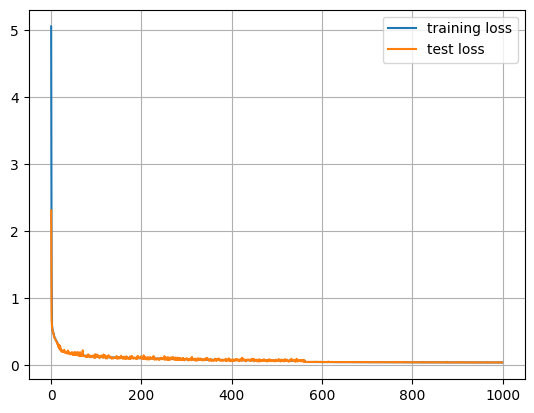

--------------------  EPOCH: 1000  --------------------
LOSS train 0.042640343901454186 valid 0.04383162036538124
--------------------  EPOCH: 1001  --------------------
LOSS train 0.04268245199809269 valid 0.042617034167051315
--------------------  EPOCH: 1002  --------------------
LOSS train 0.04260808986668684 valid 0.04337524250149727
--------------------  EPOCH: 1003  --------------------
LOSS train 0.04259195306471416 valid 0.04284136742353439
--------------------  EPOCH: 1004  --------------------
LOSS train 0.04255174000044258 valid 0.04267553240060806
--------------------  EPOCH: 1005  --------------------
LOSS train 0.042725878436954655 valid 0.043565090745687485
--------------------  EPOCH: 1006  --------------------
LOSS train 0.042609766216910615 valid 0.043350495398044586
--------------------  EPOCH: 1007  --------------------
LOSS train 0.0427100130185789 valid 0.04286310821771622
--------------------  EPOCH: 1008  --------------------
LOSS train 0.04258681236177075 vali

LOSS train 0.04207432409938501 valid 0.04210450127720833
--------------------  EPOCH: 1073  --------------------
LOSS train 0.04211941300606241 valid 0.042384691536426544
--------------------  EPOCH: 1074  --------------------
LOSS train 0.04181328733660737 valid 0.04249085113406181
--------------------  EPOCH: 1075  --------------------
LOSS train 0.04210484775961662 valid 0.041999701410532
--------------------  EPOCH: 1076  --------------------
LOSS train 0.041983155997432006 valid 0.041899438947439194
--------------------  EPOCH: 1077  --------------------
LOSS train 0.04207706608030261 valid 0.04205838590860367
--------------------  EPOCH: 1078  --------------------
LOSS train 0.04195955033813204 valid 0.04207403212785721
--------------------  EPOCH: 1079  --------------------
LOSS train 0.04215094780131262 valid 0.04204730689525604
--------------------  EPOCH: 1080  --------------------
LOSS train 0.04183217261214645 valid 0.04389574006199837
--------------------  EPOCH: 1081  ---

LOSS train 0.04118811249428866 valid 0.04167778044939041
--------------------  EPOCH: 1146  --------------------
LOSS train 0.04146760335686255 valid 0.041390515863895416
--------------------  EPOCH: 1147  --------------------
LOSS train 0.04128292938884424 valid 0.04166266322135925
--------------------  EPOCH: 1148  --------------------
LOSS train 0.04132917804681525 valid 0.041551899164915085
--------------------  EPOCH: 1149  --------------------
LOSS train 0.04143286113228117 valid 0.04139901325106621
--------------------  EPOCH: 1150  --------------------
LOSS train 0.041228082791274906 valid 0.04195256158709526
--------------------  EPOCH: 1151  --------------------
LOSS train 0.04138439509029291 valid 0.041610054671764374
--------------------  EPOCH: 1152  --------------------
LOSS train 0.041227026283740996 valid 0.04182276129722595
--------------------  EPOCH: 1153  --------------------
LOSS train 0.041468979570330404 valid 0.04134424403309822
--------------------  EPOCH: 1154

LOSS train 0.04088905674158311 valid 0.04090943560004234
--------------------  EPOCH: 1219  --------------------
LOSS train 0.04074109661944059 valid 0.04102296754717827
--------------------  EPOCH: 1220  --------------------
LOSS train 0.04070019731108023 valid 0.04090213403105736
--------------------  EPOCH: 1221  --------------------
LOSS train 0.04077323453158748 valid 0.04176991805434227
--------------------  EPOCH: 1222  --------------------
LOSS train 0.040788325378481226 valid 0.04093782603740692
--------------------  EPOCH: 1223  --------------------
LOSS train 0.040687999707095475 valid 0.041638534516096115
--------------------  EPOCH: 1224  --------------------
LOSS train 0.040772161389491995 valid 0.04156884923577309
--------------------  EPOCH: 1225  --------------------
LOSS train 0.04066371222843929 valid 0.04122147336602211
--------------------  EPOCH: 1226  --------------------
LOSS train 0.04086480814279342 valid 0.041118551045656204
--------------------  EPOCH: 1227 

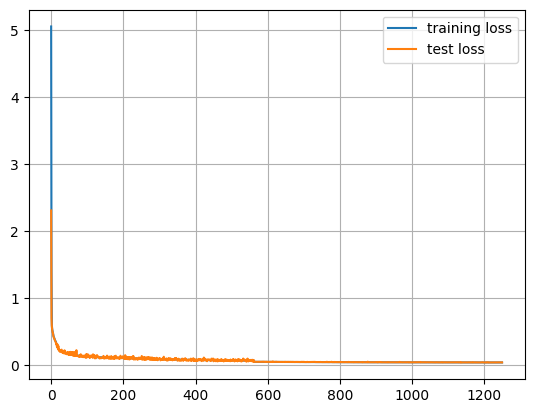

--------------------  EPOCH: 1250  --------------------
LOSS train 0.040618821644053164 valid 0.043188877403736115
--------------------  EPOCH: 1251  --------------------
LOSS train 0.04055150719929715 valid 0.040751878172159195
--------------------  EPOCH: 1252  --------------------
LOSS train 0.04056676264320101 valid 0.04184986650943756
--------------------  EPOCH: 1253  --------------------
LOSS train 0.04040726605726748 valid 0.040914345532655716
--------------------  EPOCH: 1254  --------------------
LOSS train 0.04057180584997547 valid 0.0410151369869709
--------------------  EPOCH: 1255  --------------------
LOSS train 0.04053481207514296 valid 0.04080331698060036
--------------------  EPOCH: 1256  --------------------
LOSS train 0.04042274628062637 valid 0.04052529111504555
--------------------  EPOCH: 1257  --------------------
LOSS train 0.04056126636509993 valid 0.04059373214840889
--------------------  EPOCH: 1258  --------------------
LOSS train 0.04042556891027762 valid 

LOSS train 0.040080750429508635 valid 0.04035886749625206
--------------------  EPOCH: 1323  --------------------
LOSS train 0.039921104649499974 valid 0.04006991162896156
--------------------  EPOCH: 1324  --------------------
LOSS train 0.040131061873873886 valid 0.04219171032309532
--------------------  EPOCH: 1325  --------------------
LOSS train 0.039946656430862384 valid 0.04072054103016853
--------------------  EPOCH: 1326  --------------------
LOSS train 0.04006516887825363 valid 0.039946842938661575
--------------------  EPOCH: 1327  --------------------
LOSS train 0.04001306169191185 valid 0.04004793241620064
--------------------  EPOCH: 1328  --------------------
LOSS train 0.040016235897735675 valid 0.040291644632816315
--------------------  EPOCH: 1329  --------------------
LOSS train 0.040274236016735736 valid 0.04262607544660568
--------------------  EPOCH: 1330  --------------------
LOSS train 0.03985003760578681 valid 0.040043704211711884
--------------------  EPOCH: 1

LOSS train 0.03945346187267985 valid 0.03974738344550133
--------------------  EPOCH: 1396  --------------------
LOSS train 0.039795431814023424 valid 0.04073473438620567
--------------------  EPOCH: 1397  --------------------
LOSS train 0.039735205958084184 valid 0.04000909626483917
--------------------  EPOCH: 1398  --------------------
LOSS train 0.03942822512923455 valid 0.040850963443517685
--------------------  EPOCH: 1399  --------------------
LOSS train 0.039507333462943835 valid 0.04080002009868622
--------------------  EPOCH: 1400  --------------------
LOSS train 0.039489630853035015 valid 0.04150228202342987
--------------------  EPOCH: 1401  --------------------
LOSS train 0.03965962678194046 valid 0.040104709565639496
--------------------  EPOCH: 1402  --------------------
LOSS train 0.03952841141394207 valid 0.04058542475104332
--------------------  EPOCH: 1403  --------------------
LOSS train 0.039420558420979246 valid 0.039401356130838394
--------------------  EPOCH: 14

LOSS train 0.03874764342089088 valid 0.039069224148988724
--------------------  EPOCH: 1468  --------------------
LOSS train 0.038740094523040614 valid 0.03905326500535011
--------------------  EPOCH: 1469  --------------------
LOSS train 0.038741970579234924 valid 0.03918320685625076
--------------------  EPOCH: 1470  --------------------
LOSS train 0.03874166741663096 valid 0.03946264088153839
--------------------  EPOCH: 1471  --------------------
LOSS train 0.038777448617073954 valid 0.03904251754283905
--------------------  EPOCH: 1472  --------------------
LOSS train 0.03872324099041978 valid 0.039052680134773254
--------------------  EPOCH: 1473  --------------------
LOSS train 0.038748291514965956 valid 0.039046935737133026
--------------------  EPOCH: 1474  --------------------
LOSS train 0.0387500594008942 valid 0.0390811525285244
--------------------  EPOCH: 1475  --------------------
LOSS train 0.038748312543849556 valid 0.03914760798215866
--------------------  EPOCH: 1476

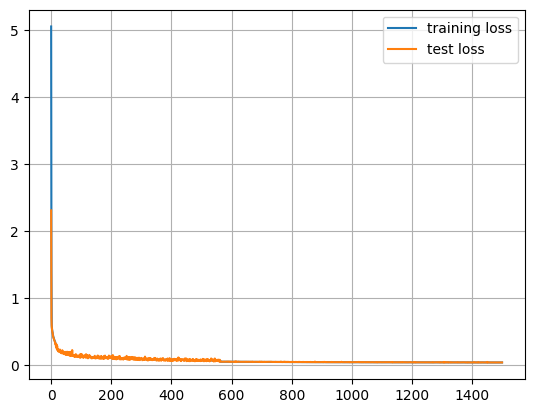

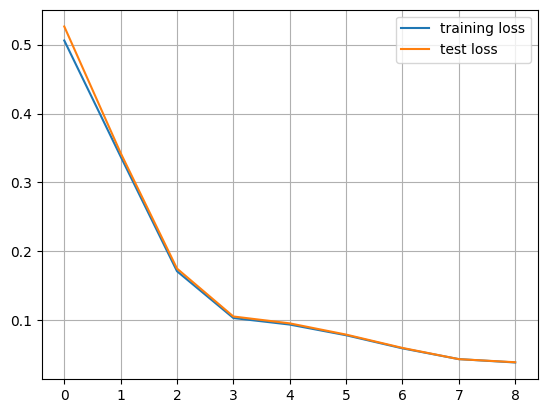

data_size: 1200000
--------------------  EPOCH: 0  --------------------
LOSS train 4.509716540066456 valid 2.0823442935943604
--------------------  EPOCH: 1  --------------------
LOSS train 1.2683602459601575 valid 0.9141123294830322
--------------------  EPOCH: 2  --------------------
LOSS train 0.8784775986199493 valid 0.8313498497009277
--------------------  EPOCH: 3  --------------------
LOSS train 0.7251535047850104 valid 0.6177564859390259
--------------------  EPOCH: 4  --------------------
LOSS train 0.5421283986584725 valid 0.4685252606868744
--------------------  EPOCH: 5  --------------------
LOSS train 0.4355319413919091 valid 0.4070739150047302
--------------------  EPOCH: 6  --------------------
LOSS train 0.39668155225063756 valid 0.3793186545372009
--------------------  EPOCH: 7  --------------------
LOSS train 0.3682396376295708 valid 0.35057204961776733
--------------------  EPOCH: 8  --------------------
LOSS train 0.34376011244672966 valid 0.33109375834465027
------

LOSS train 0.12266255663421781 valid 0.11130444705486298
--------------------  EPOCH: 75  --------------------
LOSS train 0.12186496821788391 valid 0.1434260606765747
--------------------  EPOCH: 76  --------------------
LOSS train 0.12195749578317278 valid 0.135919451713562
--------------------  EPOCH: 77  --------------------
LOSS train 0.12067308467606229 valid 0.1514439731836319
--------------------  EPOCH: 78  --------------------
LOSS train 0.12100958480871578 valid 0.11476753652095795
--------------------  EPOCH: 79  --------------------
LOSS train 0.12016662751855296 valid 0.11531363427639008
--------------------  EPOCH: 80  --------------------
LOSS train 0.11935970466901824 valid 0.10732158273458481
--------------------  EPOCH: 81  --------------------
LOSS train 0.11928196627735685 valid 0.11801309138536453
--------------------  EPOCH: 82  --------------------
LOSS train 0.1186449438486083 valid 0.11025971919298172
--------------------  EPOCH: 83  --------------------
LOSS t

LOSS train 0.09110540891568408 valid 0.08157909661531448
--------------------  EPOCH: 149  --------------------
LOSS train 0.09075641161650928 valid 0.08732903748750687
--------------------  EPOCH: 150  --------------------
LOSS train 0.09124680707682521 valid 0.08675102144479752
--------------------  EPOCH: 151  --------------------
LOSS train 0.09117986808559593 valid 0.07785211503505707
--------------------  EPOCH: 152  --------------------
LOSS train 0.09026061977440994 valid 0.09820978343486786
--------------------  EPOCH: 153  --------------------
LOSS train 0.09013494767833488 valid 0.10687317699193954
--------------------  EPOCH: 154  --------------------
LOSS train 0.09019499317879563 valid 0.094883494079113
--------------------  EPOCH: 155  --------------------
LOSS train 0.08983899136757281 valid 0.085307776927948
--------------------  EPOCH: 156  --------------------
LOSS train 0.0890549208218734 valid 0.1028655543923378
--------------------  EPOCH: 157  -------------------

LOSS train 0.07973404271915911 valid 0.09434504806995392
--------------------  EPOCH: 223  --------------------
LOSS train 0.08060432365323089 valid 0.0891842246055603
--------------------  EPOCH: 224  --------------------
LOSS train 0.07940894286482 valid 0.08095002919435501
--------------------  EPOCH: 225  --------------------
LOSS train 0.07969187708641481 valid 0.07301145046949387
--------------------  EPOCH: 226  --------------------
LOSS train 0.07897365294117163 valid 0.08638893812894821
--------------------  EPOCH: 227  --------------------
LOSS train 0.0786594604825404 valid 0.10707147419452667
--------------------  EPOCH: 228  --------------------
LOSS train 0.080198198429757 valid 0.08752863109111786
--------------------  EPOCH: 229  --------------------
LOSS train 0.07892144911321763 valid 0.07772578299045563
--------------------  EPOCH: 230  --------------------
LOSS train 0.07917486484648832 valid 0.09014807641506195
--------------------  EPOCH: 231  --------------------

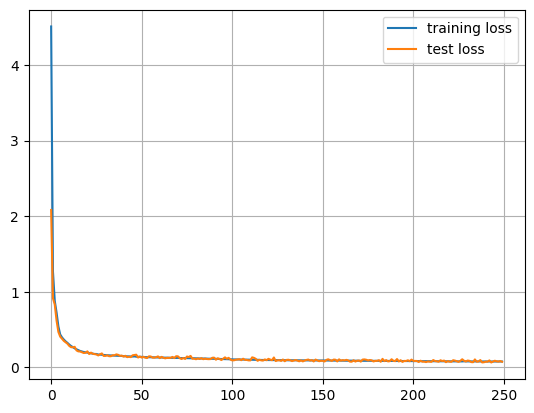

--------------------  EPOCH: 250  --------------------
LOSS train 0.07610168661477217 valid 0.07671002298593521
--------------------  EPOCH: 251  --------------------
LOSS train 0.07550789123407403 valid 0.08054614067077637
--------------------  EPOCH: 252  --------------------
LOSS train 0.07643873563652966 valid 0.07668302953243256
--------------------  EPOCH: 253  --------------------
LOSS train 0.07615353971872313 valid 0.08359421044588089
--------------------  EPOCH: 254  --------------------
LOSS train 0.07567483589765155 valid 0.08175837248563766
--------------------  EPOCH: 255  --------------------
LOSS train 0.07641741096871704 valid 0.0955004096031189
--------------------  EPOCH: 256  --------------------
LOSS train 0.07501446690931662 valid 0.079497329890728
--------------------  EPOCH: 257  --------------------
LOSS train 0.07595051443617498 valid 0.07607525587081909
--------------------  EPOCH: 258  --------------------
LOSS train 0.0757275451699418 valid 0.08304081112146

LOSS train 0.06779552140486118 valid 0.0785827711224556
--------------------  EPOCH: 324  --------------------
LOSS train 0.0684888116099932 valid 0.056604135781526566
--------------------  EPOCH: 325  --------------------
LOSS train 0.06809762107532585 valid 0.058574941009283066
--------------------  EPOCH: 326  --------------------
LOSS train 0.0683168717516974 valid 0.07678833603858948
--------------------  EPOCH: 327  --------------------
LOSS train 0.06783057578899755 valid 0.06142982840538025
--------------------  EPOCH: 328  --------------------
LOSS train 0.06809109661715429 valid 0.06948569416999817
--------------------  EPOCH: 329  --------------------
LOSS train 0.06847578596082157 valid 0.08189389854669571
--------------------  EPOCH: 330  --------------------
LOSS train 0.0676126218442217 valid 0.07252239435911179
--------------------  EPOCH: 331  --------------------
LOSS train 0.06747692546238264 valid 0.06500163674354553
--------------------  EPOCH: 332  ---------------

LOSS train 0.06318765737548623 valid 0.07593590021133423
--------------------  EPOCH: 398  --------------------
LOSS train 0.06374093441375286 valid 0.06500918418169022
--------------------  EPOCH: 399  --------------------
LOSS train 0.06283506073388223 valid 0.07224496454000473
--------------------  EPOCH: 400  --------------------
LOSS train 0.0636376516048005 valid 0.05919767916202545
--------------------  EPOCH: 401  --------------------
LOSS train 0.06232033995434693 valid 0.06714805215597153
--------------------  EPOCH: 402  --------------------
LOSS train 0.06339321027385904 valid 0.049462512135505676
--------------------  EPOCH: 403  --------------------
LOSS train 0.06306295204945798 valid 0.05853546783328056
--------------------  EPOCH: 404  --------------------
LOSS train 0.06289350200736889 valid 0.06444698572158813
--------------------  EPOCH: 405  --------------------
LOSS train 0.06311832987560347 valid 0.0673687681555748
--------------------  EPOCH: 406  --------------

LOSS train 0.06009341427999145 valid 0.062156178057193756
--------------------  EPOCH: 472  --------------------
LOSS train 0.059108548641916836 valid 0.04704517871141434
--------------------  EPOCH: 473  --------------------
LOSS train 0.06019158288836479 valid 0.05309341102838516
--------------------  EPOCH: 474  --------------------
LOSS train 0.06027293643904627 valid 0.04895555227994919
--------------------  EPOCH: 475  --------------------
LOSS train 0.05935543888715754 valid 0.057955481112003326
--------------------  EPOCH: 476  --------------------
LOSS train 0.060007266420553165 valid 0.06361179798841476
--------------------  EPOCH: 477  --------------------
LOSS train 0.059699326957045155 valid 0.05554616078734398
--------------------  EPOCH: 478  --------------------
LOSS train 0.05934938372656347 valid 0.06745170056819916
--------------------  EPOCH: 479  --------------------
LOSS train 0.059957217870108506 valid 0.05924404785037041
--------------------  EPOCH: 480  -------

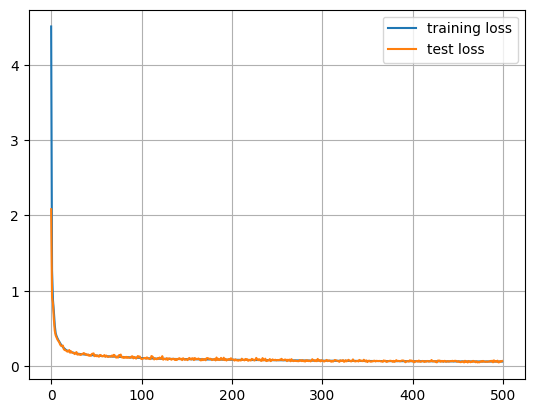

--------------------  EPOCH: 500  --------------------
LOSS train 0.05894553534203422 valid 0.06120150536298752
--------------------  EPOCH: 501  --------------------
LOSS train 0.05856890750114421 valid 0.0663423016667366
--------------------  EPOCH: 502  --------------------
LOSS train 0.05860607547259575 valid 0.05847419425845146
--------------------  EPOCH: 503  --------------------
LOSS train 0.058866352262452196 valid 0.06307527422904968
--------------------  EPOCH: 504  --------------------
LOSS train 0.05847110966722713 valid 0.05237000063061714
--------------------  EPOCH: 505  --------------------
LOSS train 0.05863531074985709 valid 0.06196996197104454
--------------------  EPOCH: 506  --------------------
LOSS train 0.05831239530149174 valid 0.0711812749505043
--------------------  EPOCH: 507  --------------------
LOSS train 0.058465825006009775 valid 0.05093444883823395
----- EARLY STOPPING TRIGGERED -----


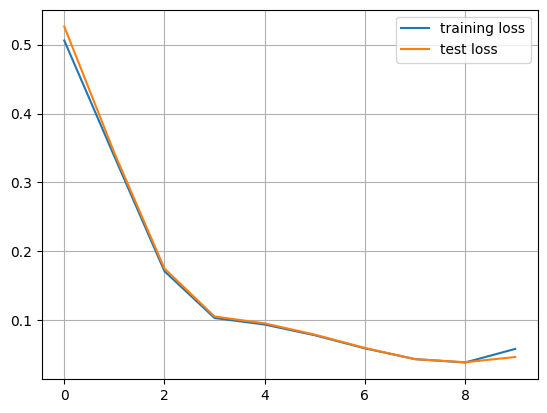

data_size: 1400000


ValueError: Cannot take a larger sample than population when 'replace=False'

In [20]:
num_epoch = 1500
# Initialize the model, loss function, and optimizer with 4 layers
input_size = 9
hidden_size1 = 40
hidden_size2 = 40
hidden_size3 = 40
hidden_size4 = 40
output_size = 1
leaky_slope = 0.01
initial_lr = 1e-3


for data_size in [400000, 800000, 1000000, 1200000, 1400000, 1800000]:
    print("data_size:", data_size)
    early_stopper = EarlyStopper(patience=50, min_delta=1e-4)

    #Construct training set
    tmp_tr = tmp_train.sample(data_size).copy()
    tr = TmpDataset(x = tmp_tr[features].values,
                    y = tmp_tr[label].values)
    train_dataloader = DataLoader(tr, 
                                  batch_size=bs, 
                                  shuffle=True)


    avg_losses = []
    avg_vlosses = []


    model = OptionPricingModel(input_size, 
                       hidden_size1, 
                       hidden_size2, 
                       hidden_size3, 
                       output_size, 
                       leaky_slope).to(device)

    loss_fn = nn.L1Loss()  # You can experiment with other loss functions like nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience=20, min_lr=1e-7, verbose=True)

    for epoch in range(num_epoch):
        print("--------------------  EPOCH:", epoch, " --------------------")
        avg_loss, avg_vloss = train_one_epoch(train_dataloader, 
                                              test_dataloader, 
                                              epoch, 
                                              device,
                                              model,
                                              optimizer,
                                              loss_fn,
                                              scheduler)
        avg_losses.append(avg_loss)
        avg_vlosses.append(avg_vloss)

        if epoch % 250 == 249:
            plt.plot(avg_losses, label='training loss')
            plt.plot(avg_vlosses, label='test loss')
            plt.legend()
            plt.grid()
            plt.show()

        if early_stopper.early_stop(avg_vlosses[-1]):
            print("----- EARLY STOPPING TRIGGERED -----")
            break
    log['datasize'].append(data_size)
    log['training_MAE'].append(np.min(avg_losses))
    log['test_MAE'].append(np.min(avg_vlosses))
    
    plt.plot(log['training_MAE'], label='training loss')
    plt.plot(log['test_MAE'], label='test loss')
    plt.legend()
    plt.grid()
    plt.show()

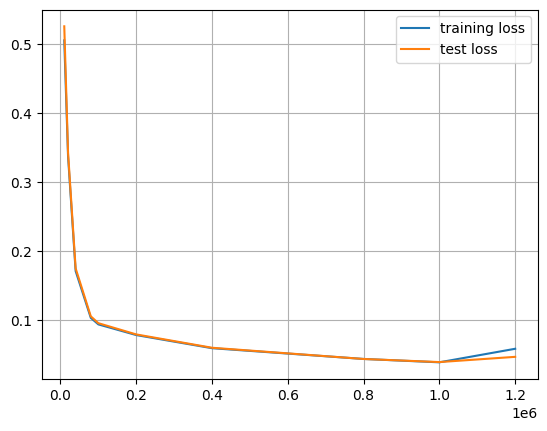

In [24]:
plt.plot(log['datasize'],log['training_MAE'], label='training loss')
plt.plot(log['datasize'],log['test_MAE'], label='test loss')
plt.legend()
plt.grid()
plt.show()

In [17]:
model = OptionPricingModel(input_size, 
                           hidden_size1, 
                           hidden_size2, 
                           hidden_size3, 
                           output_size, 
                           leaky_slope).to(device)

In [3]:
import pickle

with open('tmp_save2.pkl', 'rb') as f:
    log = pickle.load(f)

In [4]:
log

{'datasize': [10000,
  20000,
  40000,
  80000,
  100000,
  200000,
  400000,
  800000,
  1000000,
  1200000],
 'training_MAE': [0.5059828360875448,
  0.33767189979553225,
  0.17112526297569275,
  0.10321347415447235,
  0.09369977325201034,
  0.07820954310650728,
  0.05916231562744598,
  0.04353106808753646,
  0.038668905168163535,
  0.05831239530149174],
 'test_MAE': [0.5263374447822571,
  0.3427457809448242,
  0.17496702075004578,
  0.10542131215333939,
  0.09544740617275238,
  0.07913198322057724,
  0.05978639796376228,
  0.04350285604596138,
  0.03900769352912903,
  0.0466049388051033]}

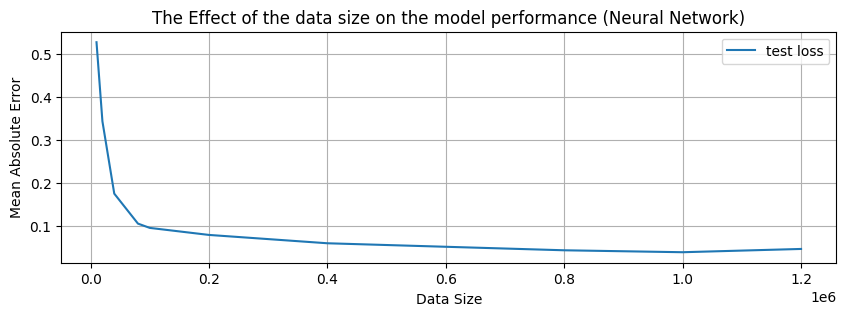

In [45]:
plt.figure(figsize=(10,3))
# plt.plot(log['datasize'],log['training_MAE'], label='training loss')
plt.plot(log['datasize'],log['test_MAE'], label='test loss')
plt.xlabel('Data Size')
plt.ylabel('Mean Absolute Error')
plt.title("The Effect of the data size on the model performance (Neural Network)")
plt.legend()
plt.grid()
plt.show()

In [36]:
dff = pd.concat([pd.read_csv('dataset_size_analysis_decision_tree_fixed_params.csv'),
                 pd.read_csv('dataset_size_small_analysis_fixed_params.csv').rename(columns={'Test_MAE': "MAE"})])
dff['Dataset_Size'] = dff['Dataset_Size'] * 2000000
dff = dff[dff['Dataset_Size']<=1200000]
dff

Model                                         Parameters  \
0       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
1       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
2       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
3       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
4       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
5       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
10  Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
11  Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
12  Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
13  Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
14  Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
15  Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
20      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
21      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
22      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
23      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
24      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
25      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
0       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
1       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
2       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
3       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
4       Random Forest  Optuna Tuned ({'n_estimators': 285, 'max_depth...   
5   Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
6   Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
7   Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
8   Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
9   Gradient Boosting  Optuna Tuned ({'n_estimators': 296, 'max_depth...   
10      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
11      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
12      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
13      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   
14      Decision Tree  Optuna Tuned ({'max_depth': 31, 'min_samples_s...   

    Dataset_Size       MSE       MAE        Time  Train_MSE  Train_MAE  \
0     200000.000  0.022833  0.097123    2.938804        NaN        NaN   
1     400000.000  0.016950  0.084666    6.631794        NaN        NaN   
2     600000.000  0.014359  0.077032   10.777146        NaN        NaN   
3     800000.000  0.012510  0.073249   15.767510        NaN        NaN   
4    1000000.000  0.011409  0.069459   20.766000        NaN        NaN   
5    1200000.000  0.010282  0.066035   31.728498        NaN        NaN   
10    200000.000  0.010340  0.069650    0.310338        NaN        NaN   
11    400000.000  0.007828  0.061443    0.669186        NaN        NaN   
12    600000.000  0.006737  0.058089    0.974230        NaN        NaN   
13    800000.000  0.005969  0.055140    1.304016        NaN        NaN   
14   1000000.000  0.005675  0.053745    1.650929        NaN        NaN   
15   1200000.000  0.005333  0.052536    1.977924        NaN        NaN   
20    200000.000  0.092489  0.204081    0.015689        NaN        NaN   
21    400000.000  0.067502  0.174257    0.015624        NaN        NaN   
22    600000.000  0.057713  0.160181    0.033627        NaN        NaN   
23    800000.000  0.050871  0.150590    0.046869        NaN        NaN   
24   1000000.000  0.046167  0.143521    0.047429        NaN        NaN   
25   1200000.000  0.042814  0.137868    0.063002        NaN        NaN   
0      10000.016       Na

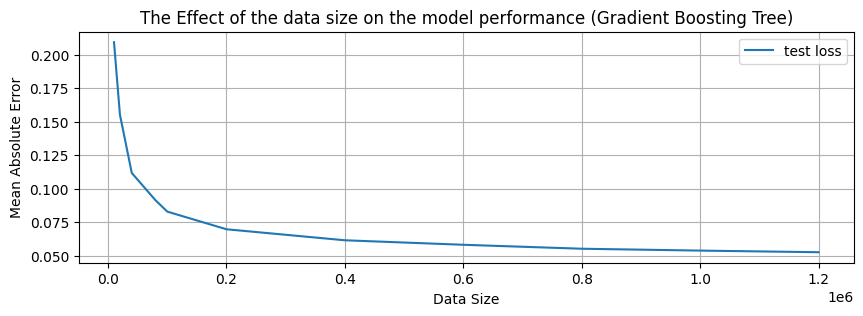

In [46]:
tmp_df = dff[dff['Model']=='Gradient Boosting'].sort_values('Dataset_Size').copy()

plt.figure(figsize=(10,3))

# plt.plot(log['datasize'],log['training_MAE'], label='training loss')
plt.plot(tmp_df['Dataset_Size'],tmp_df['MAE'], label='test loss')
plt.xlabel('Data Size')
plt.ylabel('Mean Absolute Error')
plt.title("The Effect of the data size on the model performance (Gradient Boosting Tree)")
plt.legend()
plt.grid()
plt.show()

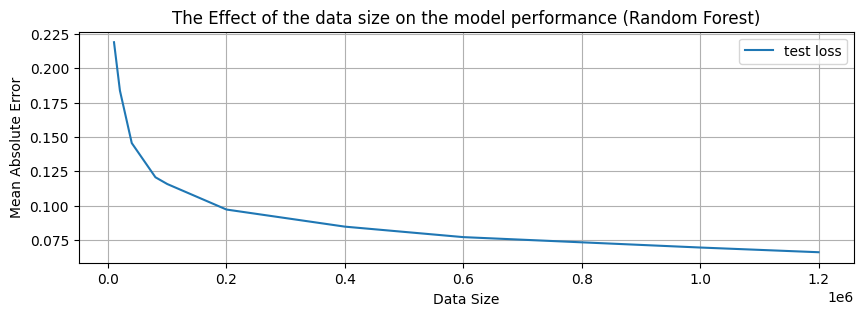

In [47]:
tmp_df = dff[dff['Model']=='Random Forest'].sort_values('Dataset_Size').copy()

plt.figure(figsize=(10,3))

# plt.plot(log['datasize'],log['training_MAE'], label='training loss')
plt.plot(tmp_df['Dataset_Size'],tmp_df['MAE'], label='test loss')
plt.xlabel('Data Size')
plt.ylabel('Mean Absolute Error')
plt.title("The Effect of the data size on the model performance (Random Forest)")
plt.legend()
plt.grid()
plt.show()

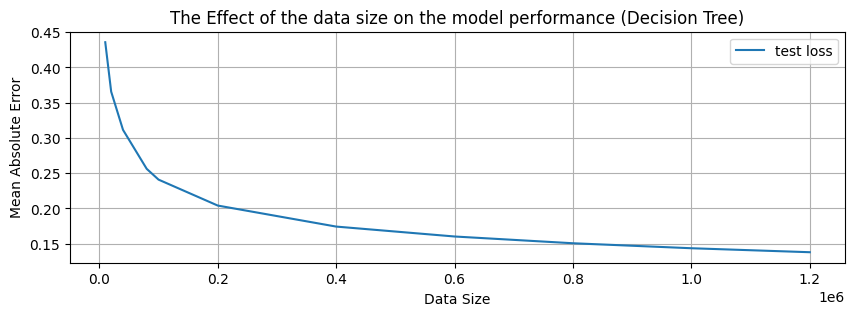

In [48]:
tmp_df = dff[dff['Model']=='Decision Tree'].sort_values('Dataset_Size').copy()

plt.figure(figsize=(10,3))

# plt.plot(log['datasize'],log['training_MAE'], label='training loss')
plt.plot(tmp_df['Dataset_Size'],tmp_df['MAE'], label='test loss')
plt.xlabel('Data Size')
plt.ylabel('Mean Absolute Error')
plt.title("The Effect of the data size on the model performance (Decision Tree)")
plt.legend()
plt.grid()
plt.show()